In [1]:
import os
os.chdir('/Users/wangzhuoyao/MyWorkSpace/DeepLearning/Kaggle/MNIST')
os.getcwd()

'/Users/wangzhuoyao/MyWorkSpace/DeepLearning/Kaggle/MNIST'

In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.cross_validation import train_test_split

import seaborn as sns

%matplotlib inline

/anaconda3/envs/tensorflow35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/anaconda3/envs/tensorflow35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/anaconda3/envs/tensorflow35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
train_data = pd.read_csv('./dataset/train.csv')
test_data = pd.read_csv('./dataset/test.csv')

In [4]:
y_train = train_data['label'].values
x_train = train_data.drop('label',axis = 1).astype(float).values
x_test = test_data.astype(float).values
print("x_train shape: {} \ny_train shape: {} \nx_test shape:{}".format\
      (np.shape(x_train),np.shape(y_train),np.shape(x_test)))

x_train shape: (42000, 784) 
y_train shape: (42000,) 
x_test shape:(28000, 784)


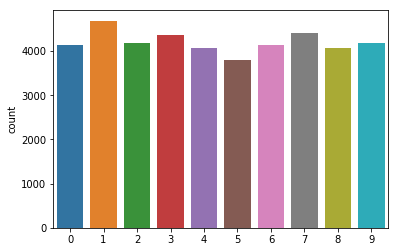

In [5]:
#confirm the distribution
sns.countplot(y_train)

count       785
unique        1
top       False
freq        785
dtype: object

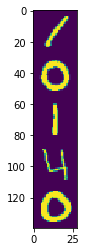

In [6]:
x = x_train[:5].reshape(28*5,28)
plt.imshow(x)
#check the null value in the training data
train_data.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

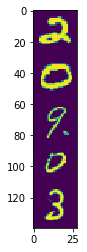

In [7]:
x = x_test[:5].reshape(28*5,28)
plt.imshow(x)
#check the null value in the test data
test_data.isnull().any().describe()

In [8]:
#free the space
del train_data
del test_data

In [9]:
X_train, X_valid, Y_train,  Y_valid = train_test_split(x_train,y_train, test_size = 0.1, random_state=0)

In [10]:
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    # Input Layer
    input_layer = tf.reshape(features["x"], [-1,28,28,1])
    
    #Convolutional Layer #1
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[5,5],
        padding = 'same',
        activation = tf.nn.relu)
    conv2 = tf.layers.conv2d(
        inputs = conv1,
        filters=32,
        kernel_size=[5,5],
        padding = 'same',
        activation = tf.nn.relu)
    #pooling layer #1
    pool1 = tf.layers.max_pooling2d(inputs = conv2, pool_size=[2,2],strides = 2)
    dropout1 = tf.layers.dropout(inputs = pool1, rate = 0.25, training=(mode == tf.estimator.ModeKeys.TRAIN))
    
    #Convolutional Layer #2 and pooling layer #2
    conv3 = tf.layers.conv2d(inputs = dropout1, 
                             filters = 64, 
                             kernel_size = [3,3],
                             padding = 'same',
                             activation = tf.nn.relu
                            )
    conv4 = tf.layers.conv2d(inputs = conv3, 
                             filters = 64, 
                             kernel_size = [3,3],
                             padding = 'same',
                             activation = tf.nn.relu
                            )
    pool2 = tf.layers.max_pooling2d(inputs = conv4, pool_size=[2,2],strides = 2)
    dropout2 = tf.layers.dropout(inputs = pool2, rate = 0.25, training=(mode == tf.estimator.ModeKeys.TRAIN))
    
    #Dense Layer
    flatten = tf.reshape(dropout2,[-1,7*7*64])
    dense = tf.layers.dense(inputs = flatten, units = 256, activation = tf.nn.relu)
    dropout = tf.layers.dropout(
                inputs = dense, rate=0.5, training=(mode ==tf.estimator.ModeKeys.TRAIN))
    
    #logits layer
    logits = tf.layers.dense(inputs = dropout, units=10)
    
    predictions = {
        #Generate predictions ( for Predict and eval mode)
        "classes": tf.argmax(input= logits,axis=1),
        #Add 'softmax_tensor' to the graph. It's used for PREDICT and by the 
        #'logging_hook'.
        "probabilities":tf.nn.softmax(logits, name='softmax_tensor')
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode = mode, predictions= predictions)
    
    loss = tf.losses.sparse_softmax_cross_entropy(labels = labels, logits = logits)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.001)
        train_op = optimizer.minimize(
            loss = loss,
            global_step = tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode = mode, loss=loss,train_op=train_op)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])
    }
    return tf.estimator.EstimatorSpec(
        mode = mode, loss=loss,eval_metric_ops=eval_metric_ops)

In [11]:
mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="./model/mnist_convert_model")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_log_step_count_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_task_type': 'worker', '_num_worker_replicas': 1, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x103cb5a90>, '_session_config': None, '_tf_random_seed': None, '_keep_checkpoint_max': 5, '_train_distribute': None, '_save_checkpoints_secs': 600, '_global_id_in_cluster': 0, '_model_dir': './model/mnist_convert_model', '_master': '', '_num_ps_replicas': 0, '_service': None, '_evaluation_master': '', '_is_chief': True, '_task_id': 0}


In [12]:
tensors_to_log = {"probabilities":"softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=50)

In [13]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x":X_train},
    y=Y_train,
    batch_size=100,
    num_epochs=None,
    shuffle=True)
mnist_classifier.train(
    input_fn=train_input_fn,
    steps=20000,
    hooks=[logging_hook])

eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_valid},
    y=Y_valid,
    num_epochs=1,
    shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convert_model/model.ckpt-12741
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 12742 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:probabilities = [[0.00007445 0.00000049 0.00000177 0.00350604 0.00000006 0.99495071
  0.00000312 0.00000497 0.00025773 0.00120066]
 [0.99931303 0.00000001 0.0005727  0.00000003 0.00000002 0.
  0.00011385 0.         0.00000009 0.00000026]
 [0.00000044 0.00001576 0.00000018 0.00000002 0.00000247 0.00000123
  0.00000024 0.99996319 0.00000015 0.00001632]
 [0.36524343 0.01192371 0.43552386 0.00528046 0.00033916 0.01138302
  0.00098761 0.0106871  0.12879282 0.02983881]
 [0.00014217 0.00001716 0.0003079  0.00009419 0.00003142 0.00010146
  0.0000002  0.00069665 0.99545532

INFO:tensorflow:loss = 0.10211549699306488, step = 12742
INFO:tensorflow:probabilities = [[0.00000061 0.00000659 0.00000215 0.00000026 0.00000395 0.00003011
  0.00000184 0.00001454 0.99992623 0.00001371]
 [0.00037445 0.00000103 0.00000286 0.00000067 0.00000659 0.00003961
  0.99940288 0.00000006 0.00017183 0.00000003]
 [0.00000006 0.         0.99999416 0.00000007 0.         0.
  0.         0.00000002 0.00000569 0.        ]
 [0.57074277 0.01020563 0.20739542 0.00317205 0.07584478 0.0132168
  0.03985167 0.00120632 0.06894796 0.00941659]
 [0.00000351 0.00000051 0.00000284 0.04402301 0.00000343 0.95417035
  0.00003342 0.00011093 0.0016261  0.00002589]
 [0.         0.00000567 0.         0.         0.99999432 0.
  0.         0.00000001 0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.99999961 0.         0.00000038]
 [0.00000001 0.0000003  0.99999788 0.         0.00000001 0.
  0.0000008  0.         0.000001   0.        ]
 [0.00000031 0.00001183 

INFO:tensorflow:global_step/sec: 0.854315
INFO:tensorflow:probabilities = [[0.0031633  0.00010954 0.00007336 0.00110943 0.00053289 0.02385645
  0.95373203 0.00020566 0.01719643 0.00002092]
 [0.99999857 0.         0.00000141 0.         0.         0.
  0.         0.         0.00000002 0.        ]
 [0.00000835 0.00000019 0.0000066  0.00024149 0.0000002  0.00017715
  0.00000076 0.00001231 0.9911884  0.00836455]
 [0.00000072 0.00007158 0.00007877 0.98884965 0.00011934 0.0064053
  0.00000073 0.00000539 0.00013051 0.004338  ]
 [0.00015383 0.00000071 0.00006352 0.00002712 0.00000466 0.00001089
  0.00000046 0.00006785 0.98550867 0.01416228]
 [0.00000441 0.97458251 0.00007003 0.00001807 0.02036333 0.00000701
  0.00004062 0.00404261 0.00043949 0.00043192]
 [0.00000005 0.00000001 0.00000433 0.00000117 0.00000014 0.
  0.00000023 0.99980004 0.         0.00019402]
 [0.         0.00000048 0.00000005 0.00001128 0.00009791 0.0000011
  0.00000012 0.00096287 0.0004469  0.99847928]
 [0.99387196 0.00005631 

INFO:tensorflow:loss = 0.07110452651977539, step = 12842 (117.059 sec)
INFO:tensorflow:probabilities = [[0.00001606 0.9991585  0.00011664 0.00000054 0.00059122 0.00000018
  0.00001897 0.0000395  0.00001846 0.00003994]
 [0.00000279 0.         0.         0.00000004 0.00003044 0.00013716
  0.99982922 0.         0.00000032 0.00000003]
 [0.00006412 0.00019214 0.00000078 0.00000007 0.00018457 0.00000504
  0.00000069 0.97580065 0.00000525 0.0237467 ]
 [0.00015023 0.00061193 0.01858225 0.00014464 0.00000122 0.00004241
  0.0000002  0.98037099 0.0000084  0.00008774]
 [0.00000001 0.00000237 0.00016503 0.00135885 0.00000089 0.00000051
  0.         0.99386624 0.00000001 0.0046061 ]
 [0.000038   0.00000375 0.00033817 0.00011719 0.00000206 0.00000461
  0.00000107 0.97899832 0.00000817 0.02048868]
 [0.00000006 0.00001239 0.00008627 0.99770151 0.0000003  0.00032894
  0.00000806 0.00005294 0.00024042 0.0015691 ]
 [0.0000216  0.00000002 0.00000032 0.00000002 0.00000019 0.00000002
  0.99997781 0.         

INFO:tensorflow:global_step/sec: 0.816511
INFO:tensorflow:probabilities = [[0.00000108 0.00000118 0.00002044 0.00000035 0.00007123 0.00000134
  0.00000008 0.00047183 0.00003733 0.99939514]
 [0.         0.9999948  0.00000034 0.         0.00000342 0.
  0.00000001 0.00000029 0.00000028 0.00000085]
 [0.00000855 0.00000058 0.0000081  0.00503977 0.00061483 0.00120886
  0.00001849 0.95769834 0.00006313 0.03533934]
 [0.0000001  0.00000063 0.00000032 0.9995458  0.00000005 0.00044541
  0.         0.00000691 0.00000006 0.00000073]
 [0.00000078 0.99989284 0.00002568 0.         0.00004484 0.
  0.00000049 0.00000444 0.00000591 0.00002501]
 [0.00000012 0.00000132 0.00000003 0.00082939 0.00034651 0.98465168
  0.0000222  0.00000001 0.00007386 0.01407488]
 [0.00076694 0.00004213 0.00073955 0.55626353 0.00007153 0.00720083
  0.00000229 0.43413225 0.00000098 0.00077996]
 [0.00000004 0.0000137  0.9999168  0.00005071 0.00000003 0.
  0.         0.00001714 0.00000005 0.00000155]
 [0.         0.00000004 0.0000

INFO:tensorflow:loss = 0.15416161715984344, step = 12942 (122.471 sec)
INFO:tensorflow:probabilities = [[0.         0.00000052 0.         0.00000001 0.99991185 0.
  0.         0.00000007 0.00000001 0.00008754]
 [0.00002184 0.0001153  0.00000481 0.00000037 0.00099883 0.00000269
  0.00001191 0.99880434 0.00002539 0.00001452]
 [0.         0.         0.00000011 0.         0.         0.
  0.         0.99999988 0.         0.        ]
 [0.         0.         0.         0.         0.00002129 0.00000003
  0.         0.00000006 0.         0.99997862]
 [0.05930163 0.00474081 0.83097795 0.00489757 0.00341605 0.00006121
  0.00104122 0.00036443 0.08559389 0.00960524]
 [0.         0.00000002 0.         0.01502581 0.0000001  0.98497391
  0.         0.         0.00000002 0.00000014]
 [0.00000017 0.86110285 0.00000642 0.00000065 0.13815454 0.00000699
  0.00000301 0.00035319 0.00036557 0.00000662]
 [0.00000152 0.00000001 0.00000082 0.00000071 0.         0.00001134
  0.00000098 0.         0.99998461 0.000

INFO:tensorflow:global_step/sec: 0.899956
INFO:tensorflow:probabilities = [[0.00000025 0.0000006  0.00001058 0.00044162 0.00081539 0.00004855
  0.00000012 0.00492962 0.0018189  0.99193437]
 [0.0000001  0.00000004 0.00000002 0.00000082 0.00021267 0.00000365
  0.00000001 0.00001015 0.00006741 0.99970514]
 [0.0000088  0.00000978 0.0000003  0.00000012 0.00000491 0.00000016
  0.99966948 0.         0.00030639 0.00000005]
 [0.00000001 0.00000009 0.         0.00266432 0.00001543 0.9965403
  0.00000135 0.00000015 0.00001087 0.00076749]
 [0.99994284 0.         0.00000043 0.00000001 0.         0.
  0.00005624 0.00000038 0.00000007 0.00000003]
 [0.00000004 0.99998254 0.0000015  0.00000011 0.00001316 0.00000014
  0.00000039 0.00000005 0.00000008 0.00000198]
 [0.00000024 0.00000001 0.00000043 0.         0.00000045 0.00000001
  0.00000027 0.99999387 0.00000011 0.00000461]
 [0.00000011 0.00000002 0.00003501 0.99960996 0.         0.00003279
  0.00000006 0.00029486 0.000027   0.0000002 ]
 [0.00002375 0.

INFO:tensorflow:loss = 0.06687530130147934, step = 13042 (111.113 sec)
INFO:tensorflow:probabilities = [[0.00002014 0.00097857 0.00022423 0.00025677 0.00042508 0.01195691
  0.00137665 0.00001235 0.98438856 0.00036075]
 [0.         0.00000002 0.99943484 0.00023759 0.00000001 0.
  0.00000015 0.00000046 0.00032691 0.        ]
 [0.000001   0.00000005 0.00000011 0.00000003 0.00000152 0.0000064
  0.99998875 0.00000001 0.00000213 0.        ]
 [0.00000378 0.00000518 0.00000918 0.00102473 0.00004117 0.99829463
  0.00050759 0.0000009  0.00008477 0.00002808]
 [0.00006371 0.00013829 0.00000036 0.00000677 0.00084528 0.00002085
  0.00000012 0.99798369 0.0000007  0.00094021]
 [0.00000002 0.00004964 0.00521241 0.01023595 0.00000865 0.00000816
  0.0000001  0.91676064 0.00000266 0.06772175]
 [0.00000508 0.00300178 0.9949649  0.00003023 0.0000149  0.00000066
  0.00000673 0.00177743 0.0001884  0.0000099 ]
 [0.00000002 0.00000086 0.         0.00039395 0.00001139 0.99850133
  0.00000063 0.00000537 0.0008184

INFO:tensorflow:global_step/sec: 0.772016
INFO:tensorflow:probabilities = [[0.         0.00000003 0.0000005  0.99474823 0.0000001  0.00450058
  0.00000001 0.00000156 0.00012257 0.00062643]
 [0.         0.00000317 0.99984879 0.00012585 0.         0.
  0.0000002  0.00002191 0.00000007 0.        ]
 [0.         0.         0.         0.         0.99960005 0.
  0.         0.00000001 0.         0.00039994]
 [0.00000728 0.00000294 0.00000099 0.00001537 0.00044743 0.00001251
  0.00000014 0.00018647 0.00000163 0.99932525]
 [0.00000147 0.         0.         0.         0.         0.00000001
  0.99999851 0.         0.00000001 0.        ]
 [0.99992731 0.00000048 0.00001019 0.         0.00000045 0.00000001
  0.0000452  0.         0.00001632 0.00000002]
 [0.00000002 0.00000003 0.00000009 0.00002409 0.00000266 0.99997076
  0.00000015 0.         0.00000022 0.00000198]
 [0.         0.00006441 0.00000315 0.99958234 0.00000039 0.00006513
  0.00000022 0.0002649  0.00000021 0.00001925]
 [0.00000047 0.0000006

INFO:tensorflow:loss = 0.060036107897758484, step = 13142 (129.536 sec)
INFO:tensorflow:probabilities = [[0.00005329 0.00000528 0.00011244 0.00051381 0.00000522 0.00361499
  0.00011983 0.00005171 0.99535482 0.0001686 ]
 [0.00002182 0.00000003 0.         0.         0.00000558 0.00000014
  0.99997242 0.         0.         0.        ]
 [0.00031885 0.00000635 0.00000081 0.00015407 0.29936461 0.00747582
  0.00031788 0.00108636 0.00000016 0.69127509]
 [0.00566613 0.00101406 0.12609819 0.00710374 0.02686181 0.01055201
  0.00138012 0.77212301 0.03268795 0.01651297]
 [0.00000209 0.9992364  0.00000246 0.         0.00014102 0.00000001
  0.00000041 0.00058466 0.00000057 0.00003237]
 [0.00114713 0.00045995 0.00010002 0.00182823 0.00527009 0.0104975
  0.00003475 0.05112738 0.01393119 0.91560376]
 [0.99883749 0.00005549 0.00011442 0.00000021 0.000743   0.00000092
  0.00008534 0.00003103 0.00004495 0.00008716]
 [0.00012085 0.001088   0.00010697 0.12526097 0.00997054 0.8586196
  0.00004537 0.00098665 0

INFO:tensorflow:global_step/sec: 0.88781
INFO:tensorflow:probabilities = [[0.         0.00001126 0.00000003 0.99869199 0.         0.00129507
  0.         0.00000004 0.00000123 0.00000037]
 [0.         0.00000001 0.         0.00000406 0.00000005 0.99999037
  0.00000084 0.00000002 0.00000271 0.00000194]
 [0.00000106 0.         0.00000002 0.         0.00000001 0.00023514
  0.99976346 0.         0.00000029 0.00000001]
 [0.00000053 0.00000055 0.99804662 0.00172224 0.0000033  0.00000004
  0.00000049 0.0002245  0.00000129 0.00000045]
 [0.         0.00000608 0.         0.         0.99999121 0.00000007
  0.00000001 0.00000001 0.         0.0000026 ]
 [0.00419903 0.00010692 0.89504618 0.06574775 0.0000445  0.02190057
  0.00116214 0.00432098 0.00565719 0.00181474]
 [0.         0.         0.00000004 0.99990272 0.         0.00009724
  0.         0.         0.         0.        ]
 [0.         0.99999997 0.         0.         0.00000003 0.
  0.         0.         0.         0.        ]
 [0.00000404 0.

INFO:tensorflow:loss = 0.1743094027042389, step = 13242 (112.632 sec)
INFO:tensorflow:Saving checkpoints for 13249 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:probabilities = [[0.00125932 0.0000162  0.99858873 0.00000045 0.00000007 0.00000022
  0.00001159 0.00011992 0.00000343 0.00000007]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.0000009  0.         0.         0.99999909 0.00000001
  0.         0.         0.         0.        ]
 [0.00005031 0.99789207 0.00044048 0.00001264 0.0000667  0.00000215
  0.00004824 0.00111633 0.0000758  0.00029529]
 [0.00000064 0.00009508 0.99800944 0.00001588 0.00000204 0.00000008
  0.00009837 0.0000104  0.00176517 0.00000291]
 [0.00004166 0.00000183 0.00093601 0.00029953 0.00000395 0.00020819
  0.00000594 0.00000112 0.99818912 0.00031265]
 [0.         0.         0.00000044 0.99999814 0.         0.00000024
  0.         0.00000118 0.         0.        ]
 [0.0000761

INFO:tensorflow:global_step/sec: 0.907303
INFO:tensorflow:probabilities = [[0.         0.         0.         0.00000038 0.         0.99999515
  0.         0.         0.00000446 0.        ]
 [0.00000019 0.00000002 0.99639799 0.00000509 0.00006833 0.00000002
  0.00000045 0.00000151 0.00352318 0.00000321]
 [0.         0.         0.         0.00000146 0.         0.99999829
  0.         0.         0.00000001 0.00000024]
 [0.00000001 0.00439113 0.9955967  0.00001114 0.         0.
  0.         0.00000096 0.00000004 0.00000001]
 [0.00014882 0.00460295 0.00465753 0.00027483 0.00012619 0.00002884
  0.00001015 0.94391341 0.00938688 0.0368504 ]
 [0.         0.00000011 0.99999914 0.00000015 0.         0.
  0.         0.         0.00000059 0.        ]
 [0.         0.         0.         0.00003922 0.00000033 0.99996035
  0.00000005 0.         0.00000004 0.00000001]
 [0.00567831 0.00030617 0.00000562 0.00000054 0.00180271 0.00004938
  0.99207274 0.00007046 0.00001096 0.0000031 ]
 [0.00000015 0.0000000

INFO:tensorflow:loss = 0.16386011242866516, step = 13342 (110.218 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         0.00000052 0.00007635 0.99990608
  0.00000971 0.         0.0000012  0.00000612]
 [0.00000005 0.00000093 0.00121676 0.00000101 0.0001241  0.00000004
  0.00000001 0.00000241 0.9986527  0.00000199]
 [0.         0.         0.00000002 0.9999915  0.         0.00000043
  0.00000001 0.0000041  0.00000382 0.00000012]
 [0.         0.         0.00001077 0.99998336 0.         0.00000434
  0.         0.00000149 0.00000001 0.00000002]
 [0.99911416 0.00000014 0.00084495 0.00000003 0.00000036 0.00000004
  0.00000805 0.00000001 0.00002005 0.00001222]
 [0.98839365 0.00000004 0.00000051 0.         0.         0.00000013
  0.0116054  0.00000022 0.00000006 0.        ]
 [0.         0.         0.00000001 0.         0.         0.
  0.99999998 0.         0.00000001 0.        ]
 [0.00024125 0.00006959 0.00001726 0.00284658 0.00545418 0.00094016
  0.00001315 0.04309192 0.000098

INFO:tensorflow:global_step/sec: 0.913317
INFO:tensorflow:probabilities = [[0.00000131 0.         0.00000002 0.00000001 0.00000002 0.00000014
  0.99999845 0.         0.00000001 0.00000003]
 [0.00000047 0.         0.         0.00000191 0.         0.99999575
  0.00000181 0.         0.00000005 0.        ]
 [0.00004048 0.         0.         0.         0.         0.00000617
  0.99995333 0.         0.00000001 0.        ]
 [0.00000001 0.00000011 0.         0.00000191 0.99987399 0.00000744
  0.0000001  0.00004927 0.00000004 0.00006713]
 [0.         0.00022574 0.99977342 0.00000056 0.         0.
  0.         0.00000027 0.         0.        ]
 [0.00000012 0.00203584 0.0001368  0.00000032 0.99756224 0.00005533
  0.00007949 0.00000109 0.00005819 0.00007057]
 [0.00002639 0.00000013 0.00000039 0.00000182 0.00000006 0.00000385
  0.00000036 0.00000003 0.99990835 0.00005862]
 [0.00001652 0.00000321 0.03377702 0.00081513 0.00000055 0.00000111
  0.00000045 0.96524305 0.00000504 0.00013792]
 [0.         0

INFO:tensorflow:loss = 0.14717450737953186, step = 13442 (109.493 sec)
INFO:tensorflow:probabilities = [[0.00000201 0.00000438 0.00000005 0.00044689 0.00000759 0.72704404
  0.00593544 0.00000309 0.26648    0.0000765 ]
 [0.00018326 0.9988782  0.00000575 0.00000005 0.00051746 0.00000017
  0.00002422 0.00004838 0.00033604 0.00000648]
 [0.02200886 0.00009782 0.00070262 0.00003191 0.00049573 0.00009553
  0.95601304 0.00005535 0.02042179 0.00007736]
 [0.00000029 0.00001193 0.00070885 0.00000005 0.00000011 0.00000012
  0.00000201 0.00000258 0.99927382 0.00000025]
 [0.0000015  0.9999732  0.00001086 0.         0.00000814 0.
  0.0000007  0.00000412 0.00000112 0.00000036]
 [0.00001607 0.00000052 0.00000077 0.0000026  0.0000003  0.00000548
  0.00006276 0.0000003  0.9999029  0.0000083 ]
 [0.00000001 0.00000352 0.99959393 0.00040195 0.         0.00000001
  0.         0.         0.00000013 0.00000045]
 [0.         0.         0.0000012  0.00000008 0.00000017 0.0000001
  0.         0.99999844 0.       

INFO:tensorflow:global_step/sec: 0.912924
INFO:tensorflow:probabilities = [[0.9997762  0.         0.00017914 0.00000003 0.00000001 0.00000119
  0.0000004  0.00000002 0.00000294 0.00004007]
 [0.00090943 0.00000114 0.00000895 0.0000002  0.00021892 0.00000946
  0.99883917 0.00000011 0.0000124  0.00000022]
 [0.00000589 0.99844609 0.0000261  0.         0.00024272 0.00000134
  0.00087406 0.00000033 0.00040307 0.00000037]
 [0.00048521 0.00001131 0.99932253 0.00001996 0.00000446 0.00000002
  0.00000208 0.00000087 0.00010628 0.00004728]
 [0.00000187 0.00009653 0.00030049 0.00006506 0.00060757 0.00001022
  0.00000213 0.00003213 0.00105348 0.99783051]
 [0.00762441 0.00097422 0.00119314 0.0276769  0.00454809 0.20900902
  0.08744113 0.00064874 0.60655387 0.05433048]
 [0.99954238 0.00000003 0.00005825 0.00000003 0.00000001 0.00000001
  0.00039249 0.         0.00000678 0.00000002]
 [0.00000865 0.         0.00000057 0.00000186 0.00001477 0.99965419
  0.00000007 0.00004025 0.0000376  0.00024204]
 [0.00

INFO:tensorflow:loss = 0.10597995668649673, step = 13542 (109.535 sec)
INFO:tensorflow:probabilities = [[0.00000002 0.         0.99999984 0.00000011 0.         0.
  0.         0.         0.00000004 0.        ]
 [0.00000261 0.00000008 0.00003959 0.99990258 0.         0.00004393
  0.         0.00000442 0.00000159 0.00000519]
 [0.01738229 0.84213887 0.00778491 0.00056187 0.00408104 0.00011728
  0.00075287 0.00693652 0.11797257 0.00227178]
 [0.00000256 0.00000065 0.00028355 0.00116894 0.00000029 0.00730658
  0.00022805 0.00002132 0.99098769 0.00000038]
 [0.72736004 0.00000561 0.13217358 0.00578363 0.00289626 0.00074853
  0.11459407 0.0000227  0.00045816 0.01595742]
 [0.00000005 0.00000002 0.00000004 0.00001663 0.00000001 0.0000169
  0.00000007 0.00000001 0.9999652  0.00000109]
 [0.00568359 0.00391925 0.0202998  0.00114513 0.00330133 0.00094248
  0.01723734 0.0178143  0.92738286 0.00227393]
 [0.00001384 0.99947006 0.00013823 0.00000015 0.00002675 0.00000197
  0.00006128 0.0002758  0.0000107

INFO:tensorflow:global_step/sec: 0.914317
INFO:tensorflow:probabilities = [[0.00000002 0.         0.00003216 0.99993203 0.         0.00000254
  0.         0.00003172 0.00000022 0.00000129]
 [0.0000014  0.         0.         0.         0.         0.
  0.9999986  0.         0.         0.        ]
 [0.00000003 0.00000014 0.00000002 0.0078414  0.00000015 0.99215117
  0.00000004 0.         0.00000046 0.00000658]
 [0.00001869 0.03454449 0.00016177 0.00000277 0.9623703  0.00005313
  0.00030609 0.00230653 0.0000614  0.00017484]
 [0.9999511  0.00000002 0.00001278 0.00000021 0.0000032  0.00000007
  0.00003022 0.         0.00000231 0.00000008]
 [0.99964475 0.00000258 0.00000654 0.00000029 0.00000304 0.00000041
  0.00020668 0.00000067 0.00012304 0.00001201]
 [0.00000015 0.         0.00000001 0.00002431 0.         0.999841
  0.00013445 0.         0.00000007 0.00000001]
 [0.00001815 0.00001438 0.00004839 0.00014035 0.00000169 0.00088604
  0.00018629 0.00000589 0.99868812 0.0000107 ]
 [0.00000009 0.0

INFO:tensorflow:loss = 0.15160198509693146, step = 13642 (109.374 sec)
INFO:tensorflow:probabilities = [[0.00000018 0.         0.00000023 0.00000022 0.00000004 0.00000001
  0.         0.99999888 0.         0.00000044]
 [0.00000001 0.00000092 0.00000652 0.00002243 0.00001362 0.00000252
  0.00021364 0.         0.99974025 0.0000001 ]
 [0.00000013 0.00010866 0.00001591 0.99975165 0.00000011 0.00009754
  0.0000004  0.00000041 0.00000094 0.00002423]
 [0.00000058 0.00002304 0.00028984 0.99916074 0.00000725 0.0000048
  0.         0.00001277 0.00001128 0.00048971]
 [0.99690143 0.00000004 0.00000161 0.         0.00000183 0.
  0.00305492 0.00000001 0.0000401  0.00000006]
 [0.00000481 0.0000002  0.00000002 0.00000089 0.00021663 0.00000007
  0.00000002 0.0031788  0.00000034 0.99659822]
 [0.000003   0.00000004 0.00000028 0.00017072 0.00003774 0.99966056
  0.00012125 0.00000482 0.00000055 0.00000104]
 [0.         0.00000001 0.         0.00000001 0.00000002 0.
  0.         0.99999984 0.         0.0000

INFO:tensorflow:global_step/sec: 0.914231
INFO:tensorflow:probabilities = [[0.9985038  0.00001247 0.00023695 0.00000127 0.00002145 0.00000107
  0.00080655 0.00010631 0.00023877 0.00007137]
 [0.00000026 0.01666048 0.98327161 0.00000288 0.00000006 0.00000001
  0.00000237 0.00003073 0.00003133 0.00000026]
 [0.00000046 0.         0.         0.00009956 0.         0.99918861
  0.0000003  0.00000001 0.00071104 0.00000002]
 [0.00000003 0.00000009 0.00000066 0.99572129 0.00000001 0.00423498
  0.         0.00000003 0.00004167 0.00000123]
 [0.00000327 0.00000385 0.0000129  0.23055528 0.0000237  0.76529556
  0.00007257 0.00005214 0.00397138 0.00000936]
 [0.00000177 0.07119357 0.00001582 0.00000144 0.92837681 0.00001412
  0.00000218 0.00000774 0.00028614 0.0001004 ]
 [0.00000039 0.         0.01354525 0.98633255 0.         0.00000145
  0.         0.00001683 0.00000011 0.00010342]
 [0.00000029 0.9993667  0.00002764 0.00000163 0.00023912 0.00000203
  0.00006707 0.00029211 0.00000243 0.00000097]
 [0.99

INFO:tensorflow:loss = 0.10688295215368271, step = 13742 (109.380 sec)
INFO:tensorflow:Saving checkpoints for 13786 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:probabilities = [[0.00000022 0.00000011 0.99997895 0.00000035 0.00000421 0.
  0.00000002 0.00000001 0.00001612 0.00000001]
 [0.00003128 0.00473471 0.35288106 0.02526943 0.0016974  0.48861555
  0.10321892 0.0226174  0.00012939 0.00080486]
 [0.00000004 0.99662277 0.00001952 0.         0.00328603 0.
  0.00000005 0.00000074 0.00006826 0.00000259]
 [0.00000668 0.00579504 0.0002336  0.00000614 0.00000157 0.00002561
  0.99342345 0.00000059 0.00050731 0.00000001]
 [0.00000636 0.9994489  0.00013406 0.00000031 0.00000457 0.00001423
  0.00020346 0.00000393 0.00018405 0.00000013]
 [0.         0.00000003 0.         0.00001097 0.00000033 0.9999231
  0.00000387 0.         0.00006079 0.00000092]
 [0.99829198 0.00016347 0.00046935 0.00000099 0.00008699 0.00019702
  0.00068077 0.00000177 0.00000968 0.00009799]
 [0.00000009 0.0000

INFO:tensorflow:global_step/sec: 0.731877
INFO:tensorflow:probabilities = [[0.00009759 0.00000903 0.00007195 0.00000001 0.00000892 0.00000504
  0.99980156 0.00000099 0.00000492 0.        ]
 [0.00000622 0.00000016 0.00000107 0.00002353 0.00778317 0.0000004
  0.00000001 0.00064662 0.00001849 0.99152032]
 [0.00000002 0.00001791 0.00000005 0.         0.99969139 0.00000008
  0.00029003 0.00000003 0.00000034 0.00000014]
 [0.00002896 0.00031116 0.00000845 0.00000605 0.00002992 0.00000539
  0.00000376 0.99816397 0.00000022 0.00144213]
 [0.0000005  0.00006616 0.00000001 0.0000001  0.99989556 0.00000001
  0.00000007 0.00000279 0.00000031 0.00003449]
 [0.         0.9999886  0.00000026 0.         0.00000747 0.00000003
  0.00000014 0.00000318 0.00000017 0.00000015]
 [0.         0.00000018 0.00003326 0.00249716 0.00000068 0.00000809
  0.00000011 0.99741332 0.00004026 0.00000692]
 [0.         0.         0.00000016 0.99999722 0.         0.
  0.         0.00000249 0.0000001  0.00000004]
 [0.         0.

INFO:tensorflow:loss = 0.04781383275985718, step = 13842 (136.634 sec)
INFO:tensorflow:probabilities = [[0.00000183 0.99759811 0.00000011 0.00000001 0.00003022 0.00000003
  0.00000014 0.00236746 0.00000009 0.00000199]
 [0.00002475 0.99971644 0.00000047 0.         0.00020943 0.00000001
  0.00004029 0.00000523 0.0000032  0.00000018]
 [0.00000007 0.00017645 0.00000004 0.00354996 0.00063163 0.98826188
  0.0072873  0.00000007 0.00002614 0.00006646]
 [0.0000018  0.00000388 0.00000323 0.99997371 0.00000001 0.00000837
  0.         0.00000752 0.00000008 0.0000014 ]
 [0.         0.         0.         0.00000032 0.         0.99999968
  0.         0.         0.         0.        ]
 [0.99635775 0.00000345 0.00196064 0.00012178 0.00007703 0.00071522
  0.0000364  0.00001303 0.00004703 0.00066767]
 [0.92222677 0.00000001 0.00017449 0.00000001 0.00004702 0.00000006
  0.01069737 0.00000002 0.06685424 0.00000001]
 [0.00000232 0.99960881 0.00028039 0.00000003 0.00000061 0.00000031
  0.00000028 0.0000173  

INFO:tensorflow:global_step/sec: 0.87782
INFO:tensorflow:probabilities = [[0.00000003 0.00000327 0.0010291  0.0012348  0.00000006 0.00000048
  0.00000091 0.99769704 0.00002961 0.00000469]
 [0.00000011 0.00000001 0.         0.         0.00000002 0.00000048
  0.99999915 0.         0.00000023 0.        ]
 [0.00000066 0.00038544 0.0005024  0.00009655 0.00000446 0.0000007
  0.00000214 0.99856769 0.00000133 0.00043862]
 [0.00028558 0.93601188 0.00017321 0.00000967 0.00076312 0.00001375
  0.00002031 0.00024623 0.05999366 0.00248259]
 [0.00000553 0.99986736 0.00006164 0.00000424 0.0000193  0.00000022
  0.00000247 0.00000047 0.00003683 0.00000193]
 [0.99963741 0.00000098 0.00006214 0.00000001 0.0000007  0.00000013
  0.00012082 0.00000028 0.00012351 0.00005403]
 [0.         0.00000053 0.         0.         0.99999917 0.
  0.         0.         0.         0.0000003 ]
 [0.         0.         0.00000001 0.         0.         0.
  0.         0.99999999 0.         0.        ]
 [0.00000095 0.00000001 

INFO:tensorflow:loss = 0.13571524620056152, step = 13942 (113.925 sec)
INFO:tensorflow:probabilities = [[0.00003458 0.99586761 0.00002266 0.00000046 0.00392795 0.00000017
  0.00006957 0.00005817 0.0000103  0.00000853]
 [0.         0.         0.00000004 0.99998992 0.         0.00000997
  0.         0.         0.00000004 0.00000002]
 [0.         0.00000016 0.00000006 0.99995953 0.00000037 0.00003715
  0.         0.00000159 0.00000004 0.0000011 ]
 [0.31888498 0.00000958 0.00016601 0.00000821 0.00009466 0.00028897
  0.68047231 0.00002495 0.00000787 0.00004245]
 [0.         0.         0.99999963 0.00000035 0.         0.
  0.         0.00000002 0.         0.        ]
 [0.00003634 0.00001371 0.00006149 0.99926126 0.00000235 0.00051168
  0.00000002 0.00004583 0.0000439  0.00002343]
 [0.00004204 0.         0.00000007 0.         0.         0.01585844
  0.9673104  0.         0.01678904 0.        ]
 [0.00001078 0.00000036 0.00000001 0.00000152 0.00000051 0.00012708
  0.99985754 0.00000001 0.000002

INFO:tensorflow:global_step/sec: 0.767903
INFO:tensorflow:probabilities = [[0.00000043 0.99990625 0.00000004 0.         0.00007502 0.
  0.00000072 0.00001625 0.00000001 0.00000127]
 [0.00084051 0.00148307 0.13144908 0.00238106 0.00060263 0.00000411
  0.00007408 0.86303866 0.00000767 0.00011914]
 [0.         0.00000006 0.00000007 0.         0.99999716 0.00000001
  0.00000002 0.00000015 0.0000025  0.00000001]
 [0.00204881 0.00018214 0.03842445 0.78879899 0.00000343 0.00004578
  0.00001236 0.0001201  0.16834107 0.00202287]
 [0.0000003  0.00004448 0.00000687 0.00314172 0.00951095 0.93890562
  0.0000454  0.00093165 0.00461207 0.04280093]
 [0.00901119 0.00000007 0.00000004 0.         0.0000037  0.00000042
  0.99098439 0.         0.00000018 0.        ]
 [0.         0.00000001 0.00000017 0.00000001 0.00000002 0.00000001
  0.         0.99999971 0.         0.00000006]
 [0.00069294 0.00831955 0.00225762 0.00003728 0.00110972 0.00003299
  0.00000674 0.97671138 0.00103494 0.00979684]
 [0.         0

INFO:tensorflow:loss = 0.06234000250697136, step = 14042 (130.232 sec)
INFO:tensorflow:probabilities = [[0.00000001 0.         0.         0.00000006 0.00045048 0.0000025
  0.00000006 0.00000215 0.00000003 0.99954469]
 [0.0000114  0.00000012 0.00000002 0.         0.00000052 0.00004238
  0.999944   0.         0.00000154 0.        ]
 [0.00000166 0.00000001 0.00026571 0.00000136 0.00000007 0.00000016
  0.00000002 0.99947384 0.00000657 0.00025061]
 [0.00000051 0.00000563 0.00000434 0.0000002  0.99996828 0.00000001
  0.00000002 0.00000344 0.00000044 0.00001715]
 [0.99999906 0.         0.00000003 0.         0.         0.
  0.00000006 0.         0.00000022 0.00000063]
 [0.         0.         0.         0.99997448 0.         0.00002549
  0.         0.00000003 0.         0.        ]
 [0.         0.         0.00000013 0.9992861  0.         0.00070734
  0.         0.00000001 0.00000629 0.00000011]
 [0.00000005 0.00015731 0.00000826 0.99979795 0.00000001 0.00000691
  0.         0.00000008 0.0000004

INFO:tensorflow:global_step/sec: 0.756505
INFO:tensorflow:probabilities = [[0.00000002 0.00015846 0.00000433 0.0000008  0.99981217 0.00000711
  0.00000097 0.00001303 0.00000136 0.00000174]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.        ]
 [0.00048158 0.00000169 0.97496544 0.00598885 0.00010942 0.00001111
  0.00000102 0.00519294 0.01293199 0.00031597]
 [0.         0.00000432 0.00000002 0.00000216 0.00631715 0.00000001
  0.00000001 0.99366861 0.00000056 0.00000716]
 [0.00000001 0.99997839 0.00000017 0.00000002 0.0000015  0.
  0.00000023 0.00000001 0.00001965 0.00000002]
 [0.00000403 0.99006082 0.00002156 0.00000085 0.00071846 0.00000143
  0.00000437 0.00860477 0.00001635 0.00056736]
 [0.00000086 0.00015751 0.00000006 0.00000021 0.00001571 0.00001006
  0.99979959 0.00000042 0.00001542 0.00000015]
 [0.00000016 0.00000005 0.99999397 0.00000031 0.         0.
  0.         0.00000545 0.00000005 0.        ]
 [0.99940199 0.         0.0000

INFO:tensorflow:loss = 0.07213014364242554, step = 14142 (132.176 sec)
INFO:tensorflow:probabilities = [[0.00000001 0.00000005 0.00005503 0.99989327 0.00000017 0.0000421
  0.00000001 0.00000223 0.00000077 0.00000638]
 [0.00000013 0.00000444 0.00004972 0.00039637 0.00001688 0.00001404
  0.00000144 0.00000019 0.99852393 0.00099285]
 [0.00000135 0.00000009 0.00000003 0.00291871 0.00907316 0.02276155
  0.00000152 0.00018802 0.00002971 0.96502585]
 [0.00068189 0.00325897 0.01261555 0.00101495 0.000034   0.00066933
  0.01193753 0.00011264 0.96954666 0.00012849]
 [0.00000027 0.00000722 0.         0.00031262 0.00033507 0.99908091
  0.00002835 0.00000013 0.00001314 0.00022229]
 [0.         0.00000029 0.9999936  0.00000429 0.         0.
  0.00000106 0.00000014 0.00000061 0.        ]
 [0.00000985 0.         0.00000001 0.00000048 0.         0.99997902
  0.00000964 0.         0.000001   0.        ]
 [0.00000052 0.00000002 0.00000673 0.00000002 0.00000005 0.00000045
  0.00000014 0.00000004 0.9999862

INFO:tensorflow:global_step/sec: 0.862896
INFO:tensorflow:probabilities = [[0.00053286 0.00000197 0.00001196 0.00001696 0.         0.58530456
  0.41315555 0.00000145 0.00097457 0.0000001 ]
 [0.         0.00000004 0.         0.00002582 0.00000009 0.99993907
  0.         0.         0.00000029 0.00003469]
 [0.00000003 0.00000646 0.00000001 0.00000224 0.00003838 0.00000003
  0.         0.00051507 0.00000001 0.99943777]
 [0.         0.         0.0000006  0.97718119 0.         0.00000478
  0.         0.00000069 0.00000035 0.02281238]
 [0.00000001 0.99954479 0.00000039 0.         0.00040696 0.
  0.00000003 0.00004506 0.00000148 0.00000128]
 [0.         0.         0.00000014 0.99997702 0.         0.00000059
  0.         0.00000007 0.00001141 0.00001078]
 [0.00013411 0.0000033  0.00001084 0.00022119 0.00840509 0.00022305
  0.00003787 0.00029896 0.00001158 0.99065402]
 [0.00000202 0.99996938 0.         0.         0.00002793 0.00000002
  0.00000004 0.00000004 0.00000006 0.00000051]
 [0.00000004 0

INFO:tensorflow:loss = 0.1327913999557495, step = 14242 (115.886 sec)
INFO:tensorflow:Saving checkpoints for 14271 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:probabilities = [[0.         0.00000835 0.00000186 0.99985773 0.00000002 0.00001524
  0.00000003 0.00000864 0.00009965 0.00000847]
 [0.99388521 0.00000004 0.00000019 0.         0.00000025 0.00000009
  0.00611105 0.00000312 0.         0.00000004]
 [0.00000006 0.00000054 0.99984321 0.00001191 0.         0.
  0.00000004 0.00004954 0.00009467 0.00000003]
 [0.0000007  0.         0.         0.00000135 0.         0.99999609
  0.00000141 0.         0.00000042 0.00000003]
 [0.00000418 0.99936988 0.00001089 0.00000012 0.00008133 0.00000003
  0.00002806 0.00001689 0.00048436 0.00000427]
 [0.         0.         0.         0.99991386 0.00000012 0.00001949
  0.         0.00000012 0.00000001 0.00006639]
 [0.         0.00000068 0.00000034 0.99999875 0.         0.00000002
  0.         0.00000003 0.00000015 0.00000003]
 [0.9911707

INFO:tensorflow:global_step/sec: 0.908784
INFO:tensorflow:probabilities = [[0.00000009 0.         0.00000002 0.00000011 0.00000017 0.99753086
  0.00085794 0.00000001 0.00161042 0.00000039]
 [0.00000245 0.00066477 0.00000018 0.00000001 0.99930563 0.00000002
  0.00002242 0.00000152 0.00000018 0.00000282]
 [0.00001601 0.         0.00000024 0.         0.         0.00000014
  0.99998355 0.         0.00000005 0.        ]
 [0.00000009 0.0000672  0.00000193 0.00000213 0.99796276 0.00000536
  0.00000208 0.00000021 0.00189975 0.0000585 ]
 [0.00000016 0.00002503 0.00000326 0.00000004 0.00000074 0.00000027
  0.00000002 0.99970766 0.00000135 0.00026147]
 [0.00003014 0.00000003 0.00000024 0.00000003 0.00027332 0.00000003
  0.99969576 0.00000039 0.00000005 0.        ]
 [0.0000279  0.00000001 0.00000424 0.00002409 0.0000499  0.00000059
  0.00000012 0.55590993 0.00000697 0.44397624]
 [0.99993995 0.         0.00002578 0.00000002 0.00000006 0.
  0.00000563 0.         0.00001621 0.00001234]
 [0.00000034 0

INFO:tensorflow:loss = 0.06673286110162735, step = 14342 (110.037 sec)
INFO:tensorflow:probabilities = [[0.00005138 0.00018788 0.00010111 0.00208289 0.01684662 0.00084632
  0.00000557 0.00326005 0.00007879 0.97653938]
 [0.00000798 0.00852336 0.00024635 0.01003436 0.00022561 0.00000494
  0.00000552 0.97691239 0.00000229 0.00403719]
 [0.00015118 0.00000182 0.00006592 0.0000006  0.00001403 0.00072062
  0.99815486 0.00000052 0.0008793  0.00001115]
 [0.         0.         0.         0.00000005 0.00000112 0.99998857
  0.00000002 0.         0.00000489 0.00000534]
 [0.00000524 0.00000058 0.0005036  0.00151048 0.00000166 0.00002672
  0.00000098 0.00000072 0.9979117  0.00003831]
 [0.0000002  0.00000003 0.00000974 0.00003757 0.         0.00000033
  0.         0.99968487 0.00000007 0.00026719]
 [0.00003363 0.99891348 0.00028473 0.00000019 0.00019185 0.00000006
  0.00000396 0.00026865 0.00021053 0.00009294]
 [0.00521422 0.00745143 0.00025021 0.00062165 0.000039   0.02265399
  0.00008589 0.03620078 

INFO:tensorflow:global_step/sec: 0.914591
INFO:tensorflow:probabilities = [[0.00000003 0.00000003 0.00000067 0.00000372 0.00000064 0.00000505
  0.00000035 0.00000002 0.99995071 0.00003879]
 [0.00000845 0.00005268 0.00000084 0.00002524 0.00015437 0.00045812
  0.00176628 0.00000027 0.99753341 0.00000034]
 [0.00000017 0.0054473  0.00001735 0.00108427 0.98495845 0.00039939
  0.00004026 0.00050575 0.0072487  0.00029837]
 [0.00003279 0.00023596 0.00002728 0.00074011 0.00731665 0.00098061
  0.00039136 0.00001597 0.99025497 0.0000043 ]
 [0.00011584 0.00004454 0.00019802 0.93406929 0.00021552 0.00280909
  0.0000197  0.06216438 0.0000621  0.00030152]
 [0.00000014 0.99994389 0.00000013 0.00000002 0.00000173 0.
  0.00000009 0.00005293 0.00000002 0.00000104]
 [0.00000001 0.99999979 0.00000001 0.         0.00000012 0.
  0.00000001 0.00000003 0.00000003 0.        ]
 [0.         0.00019375 0.         0.         0.99980383 0.
  0.         0.00000111 0.         0.00000131]
 [0.         0.         0.    

INFO:tensorflow:loss = 0.20405834913253784, step = 14442 (109.341 sec)
INFO:tensorflow:probabilities = [[0.00000272 0.00001733 0.000012   0.00026636 0.00000163 0.99775005
  0.00065416 0.00000089 0.00129465 0.00000019]
 [0.99997749 0.00000012 0.00000204 0.         0.00000002 0.00000002
  0.00002031 0.         0.00000001 0.        ]
 [0.99999719 0.         0.0000015  0.         0.         0.
  0.0000013  0.         0.00000001 0.00000001]
 [0.99987848 0.00000001 0.00004888 0.00000004 0.00000243 0.00000006
  0.00006194 0.00000008 0.00000764 0.00000045]
 [0.99952588 0.00000074 0.00004152 0.00000079 0.00000046 0.00000009
  0.0000007  0.00004587 0.00014203 0.00024192]
 [0.00001833 0.00001391 0.00023886 0.00007208 0.00001118 0.00003018
  0.00001958 0.00000052 0.99959478 0.00000057]
 [0.99980875 0.00000994 0.00001008 0.00000002 0.00000014 0.00000055
  0.00013959 0.00000371 0.00002709 0.00000013]
 [0.00000231 0.00013889 0.00147621 0.00255928 0.00003161 0.00000058
  0.00000114 0.99500565 0.000000

INFO:tensorflow:global_step/sec: 0.931626
INFO:tensorflow:probabilities = [[0.00000016 0.99987635 0.000002   0.         0.00011953 0.
  0.0000006  0.00000047 0.00000086 0.00000002]
 [0.99950195 0.00000002 0.00004586 0.00000031 0.00000001 0.0000003
  0.00027152 0.         0.00017664 0.00000339]
 [0.00000015 0.00000028 0.00000014 0.04429055 0.0000595  0.95486797
  0.00000172 0.0000001  0.00008563 0.00069396]
 [0.00001479 0.00830356 0.00022809 0.00000138 0.00035133 0.00000355
  0.00000022 0.97049879 0.00000401 0.02059427]
 [0.00057684 0.00020947 0.04006487 0.9467789  0.00019005 0.00613657
  0.00000024 0.0006304  0.00414974 0.00126292]
 [0.00099737 0.00189118 0.99563454 0.00004539 0.00000025 0.00000434
  0.0000058  0.00103105 0.00038507 0.000005  ]
 [0.         0.         0.00000003 0.00000001 0.         0.
  0.         0.99999922 0.         0.00000074]
 [0.00000111 0.00009931 0.00003036 0.00024046 0.00000066 0.02070706
  0.00266659 0.00000648 0.97618467 0.00006331]
 [0.0000557  0.00047219

INFO:tensorflow:loss = 0.17013075947761536, step = 14542 (107.336 sec)
INFO:tensorflow:probabilities = [[0.00000255 0.00000003 0.99981837 0.00000044 0.         0.
  0.         0.0000096  0.00016878 0.00000023]
 [0.0000193  0.001253   0.00001183 0.98533893 0.00001589 0.0064666
  0.00003824 0.00084053 0.00001027 0.0060054 ]
 [0.00000191 0.00000162 0.00000001 0.00000029 0.00271161 0.00000017
  0.00000004 0.00000022 0.00000001 0.99728412]
 [0.         0.         0.00000003 0.99999189 0.         0.00000747
  0.         0.00000001 0.00000027 0.00000033]
 [0.00000006 0.99975331 0.00003195 0.00000001 0.00020543 0.
  0.00000001 0.00000892 0.00000017 0.00000015]
 [0.         0.         0.         0.99999999 0.         0.00000001
  0.         0.         0.         0.00000001]
 [0.00000258 0.00000025 0.00004882 0.98249848 0.00000871 0.00014995
  0.00000001 0.00001534 0.01318277 0.0040931 ]
 [0.00000274 0.00000002 0.         0.         0.0000002  0.00000019
  0.9999968  0.         0.00000005 0.    

INFO:tensorflow:global_step/sec: 0.931117
INFO:tensorflow:probabilities = [[0.99998237 0.         0.00000985 0.00000001 0.00000026 0.00000011
  0.0000072  0.00000004 0.00000009 0.00000005]
 [0.00000005 0.         0.99999246 0.00000541 0.         0.
  0.         0.0000001  0.00000196 0.00000002]
 [0.00000848 0.         0.00000002 0.         0.00000001 0.00000006
  0.99998749 0.         0.00000394 0.        ]
 [0.         0.0000002  0.0000017  0.999988   0.         0.0000054
  0.         0.0000004  0.00000027 0.00000401]
 [0.         0.99963812 0.00000002 0.         0.00035997 0.
  0.         0.00000171 0.         0.00000017]
 [0.         0.00000004 0.23090727 0.00006217 0.         0.
  0.00000001 0.76903047 0.00000002 0.00000001]
 [0.00029237 0.00007002 0.00003877 0.00029277 0.00009151 0.00139718
  0.00003013 0.00005454 0.9966588  0.00107391]
 [0.00000034 0.00000004 0.00000008 0.00000001 0.00000008 0.00000082
  0.99999861 0.00000001 0.         0.        ]
 [0.00000006 0.00000126 0.00005

INFO:tensorflow:loss = 0.07001732289791107, step = 14642 (107.400 sec)
INFO:tensorflow:probabilities = [[0.00000008 0.0002478  0.00003593 0.00003775 0.99681568 0.00001462
  0.00001401 0.00019754 0.00237554 0.00026104]
 [0.         0.00000008 0.00006302 0.99984468 0.00000001 0.00000157
  0.00000009 0.00000343 0.00007192 0.0000152 ]
 [0.00001457 0.00005619 0.98808091 0.0061157  0.0000006  0.00000026
  0.00000483 0.0023127  0.00341313 0.00000109]
 [0.00000113 0.00001242 0.99995193 0.00000228 0.0000018  0.00000015
  0.00001775 0.0000113  0.00000085 0.00000038]
 [0.0000072  0.99954983 0.00000052 0.00000004 0.00028725 0.00000008
  0.00010217 0.00000056 0.00004884 0.00000351]
 [0.00000077 0.0000002  0.00000151 0.0000421  0.00081801 0.00001482
  0.00000005 0.00018722 0.00002088 0.99891446]
 [0.0000005  0.00000099 0.00000001 0.00004884 0.00000226 0.99992237
  0.00000227 0.00000014 0.00002176 0.00000087]
 [0.00028452 0.00000011 0.000005   0.00017881 0.00017172 0.00000834
  0.00000001 0.00298561 

INFO:tensorflow:global_step/sec: 0.931086
INFO:tensorflow:probabilities = [[0.00000001 0.00000001 0.00001118 0.00009544 0.         0.00001178
  0.00000001 0.00000002 0.99988143 0.00000012]
 [0.00000028 0.         0.03445585 0.00000272 0.00000011 0.
  0.00000008 0.00000001 0.96554076 0.0000002 ]
 [0.00000003 0.00000015 0.99989637 0.0000218  0.00000001 0.00000017
  0.00000003 0.00008139 0.00000002 0.00000002]
 [0.0000058  0.         0.00000012 0.00000002 0.00000398 0.00000002
  0.99999003 0.         0.00000001 0.00000001]
 [0.         0.         0.         0.99999925 0.         0.00000074
  0.         0.         0.         0.        ]
 [0.         0.00000133 0.         0.00000102 0.00000131 0.99999555
  0.00000007 0.         0.00000071 0.00000001]
 [0.         0.00000014 0.         0.00000007 0.00002155 0.00000001
  0.         0.99988222 0.         0.000096  ]
 [0.00000114 0.00000052 0.         0.00002781 0.00025024 0.00010475
  0.00000009 0.00009346 0.00001111 0.99951087]
 [0.00000002 0

INFO:tensorflow:loss = 0.10613299906253815, step = 14742 (107.399 sec)
INFO:tensorflow:probabilities = [[0.99838308 0.0000001  0.00045699 0.00000001 0.00000004 0.00000001
  0.00103568 0.00000001 0.000119   0.00000509]
 [0.         0.00000015 0.99999948 0.00000001 0.00000001 0.
  0.         0.00000027 0.00000008 0.        ]
 [0.00001942 0.00000797 0.99993231 0.00000028 0.00000395 0.
  0.00000166 0.00001525 0.00001784 0.00000134]
 [0.00002716 0.00001182 0.00074347 0.00771678 0.00006917 0.00518658
  0.00002801 0.0000864  0.98472048 0.00141013]
 [0.00000004 0.9999983  0.0000003  0.         0.0000007  0.
  0.00000001 0.00000011 0.00000052 0.00000002]
 [0.71548599 0.00011495 0.00008009 0.0000003  0.00000086 0.00099304
  0.28326149 0.00005528 0.00000768 0.00000033]
 [0.00000303 0.00004636 0.0000791  0.00002294 0.00003268 0.0000075
  0.00000053 0.99948935 0.00012265 0.00019588]
 [0.00000091 0.99999168 0.00000139 0.         0.00000006 0.00000001
  0.00000004 0.00000104 0.00000262 0.00000224]
 [

INFO:tensorflow:Saving checkpoints for 14826 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:global_step/sec: 0.925455
INFO:tensorflow:probabilities = [[0.00001095 0.98277285 0.00006671 0.00002847 0.00173585 0.00001568
  0.0002854  0.00082362 0.00669204 0.00756842]
 [0.000052   0.0000207  0.07222552 0.00584845 0.00000418 0.00001423
  0.00000047 0.92149412 0.00019034 0.00015   ]
 [0.         0.00000219 0.         0.         0.99999378 0.00000001
  0.00000001 0.00000006 0.0000018  0.00000216]
 [0.00153367 0.00014287 0.0018272  0.00001423 0.00210979 0.00013039
  0.97145706 0.00230155 0.02045444 0.00002879]
 [0.         0.         0.00000008 0.         0.         0.
  0.         0.99999951 0.         0.00000041]
 [0.00000216 0.0000016  0.0000021  0.00038466 0.00000052 0.0016862
  0.00000091 0.00000945 0.99791012 0.00000229]
 [0.         0.00000003 0.00030379 0.9994503  0.         0.00000011
  0.         0.00024289 0.00000034 0.00000254]
 [0.00000003 0.99997191 0.00000053 0.   

INFO:tensorflow:loss = 0.11519300192594528, step = 14842 (108.056 sec)
INFO:tensorflow:probabilities = [[0.         0.99996452 0.00000016 0.         0.00002052 0.00000001
  0.00000023 0.00001365 0.00000066 0.00000025]
 [0.         0.00000161 0.00000014 0.9999529  0.00000001 0.00001739
  0.         0.00000342 0.00000002 0.00002451]
 [0.00000466 0.00001317 0.00001292 0.00000024 0.99987152 0.0000003
  0.00000445 0.00000026 0.00001873 0.00007375]
 [0.00000063 0.00076771 0.00000131 0.00000798 0.0000041  0.00007742
  0.9926101  0.00000021 0.00653004 0.00000049]
 [0.00000018 0.00000001 0.99999753 0.         0.0000007  0.
  0.         0.         0.00000157 0.        ]
 [0.         0.00014348 0.         0.         0.99985464 0.
  0.         0.00000188 0.         0.        ]
 [0.00017192 0.00013205 0.00201578 0.00000023 0.98070075 0.00001331
  0.01694175 0.00001993 0.00000356 0.00000072]
 [0.00000345 0.04141432 0.00017824 0.0001199  0.55332362 0.0000805
  0.00001328 0.0006183  0.00033273 0.40391

INFO:tensorflow:global_step/sec: 0.647598
INFO:tensorflow:probabilities = [[0.00014221 0.00011147 0.13852117 0.1909016  0.00013571 0.00397433
  0.00006354 0.62165165 0.04155869 0.00293964]
 [0.00000003 0.00000017 0.00009881 0.00029972 0.0000212  0.00000007
  0.00000136 0.00000298 0.99957283 0.00000282]
 [0.00000412 0.00035079 0.00001405 0.08082339 0.00009615 0.91463593
  0.00000512 0.00001781 0.00016909 0.00388355]
 [0.00003942 0.00341346 0.99636704 0.0000564  0.0000002  0.00000015
  0.00003232 0.00008359 0.00000728 0.00000015]
 [0.         0.         0.         0.00195807 0.00000044 0.99802126
  0.00000001 0.         0.0000202  0.00000001]
 [0.0000109  0.00000027 0.00006916 0.00000172 0.99979937 0.00000003
  0.00001962 0.00009013 0.00000062 0.00000818]
 [0.0000003  0.99725213 0.0000002  0.         0.00273792 0.
  0.         0.0000077  0.00000014 0.00000161]
 [0.00000359 0.00000357 0.00000001 0.00000006 0.99963774 0.00000002
  0.00002875 0.00031696 0.         0.00000931]
 [0.00013141 0

INFO:tensorflow:loss = 0.17472070455551147, step = 14942 (154.422 sec)
INFO:tensorflow:probabilities = [[0.00000138 0.00000004 0.00000217 0.00000022 0.00001358 0.00012107
  0.99986009 0.00000006 0.00000137 0.00000002]
 [0.00000432 0.00000118 0.00004265 0.0000023  0.00004889 0.00016694
  0.99972874 0.00000404 0.00000073 0.00000021]
 [0.99627113 0.00000001 0.00007318 0.00030911 0.0000003  0.00000376
  0.00000609 0.00018867 0.0023288  0.00081896]
 [0.99814535 0.00000037 0.00050717 0.00000007 0.00000021 0.00000013
  0.00131682 0.00002019 0.00000709 0.0000026 ]
 [0.00000146 0.00000141 0.00002677 0.0006499  0.00000017 0.00000018
  0.00000012 0.81345181 0.00000519 0.185863  ]
 [0.0224208  0.00014378 0.00223689 0.00864355 0.02866654 0.22465344
  0.56187314 0.00333025 0.14354219 0.00448942]
 [0.00000007 0.         0.00000623 0.00000014 0.         0.00002403
  0.         0.99996867 0.00000001 0.00000085]
 [0.00000006 0.         0.00000319 0.00000161 0.         0.00000001
  0.00000001 0.         

INFO:tensorflow:global_step/sec: 0.69839
INFO:tensorflow:probabilities = [[0.00000007 0.0000002  0.07505879 0.12051075 0.00009198 0.0000071
  0.00000467 0.80132653 0.00299979 0.00000012]
 [0.         0.         0.         0.00000007 0.00092361 0.00000024
  0.         0.00006876 0.00000098 0.99900635]
 [0.00009689 0.0000031  0.99662105 0.00000485 0.00000079 0.00000032
  0.00002274 0.00322343 0.00002628 0.00000054]
 [0.00494108 0.00189192 0.00209882 0.00359814 0.00732684 0.00588959
  0.00079013 0.03530202 0.218204   0.71995747]
 [0.00000001 0.00000003 0.00000018 0.0016366  0.0000405  0.00006355
  0.00000001 0.97418638 0.00000248 0.02407025]
 [0.0000001  0.00000074 0.         0.00000001 0.00000265 0.00073619
  0.99926005 0.         0.00000025 0.        ]
 [0.00003905 0.00000136 0.00000013 0.00001381 0.00014202 0.99974759
  0.00004933 0.00000142 0.00000022 0.00000505]
 [0.00000004 0.99934114 0.00000107 0.         0.00065154 0.00000001
  0.00000001 0.00000084 0.00000004 0.00000531]
 [0.0000

INFO:tensorflow:loss = 0.18616876006126404, step = 15042 (143.190 sec)
INFO:tensorflow:probabilities = [[0.00520391 0.00425685 0.16753077 0.01557195 0.00077719 0.00878786
  0.00001308 0.77775494 0.00030598 0.01979749]
 [0.00000188 0.00000481 0.00000499 0.00000069 0.00019848 0.0000001
  0.00000003 0.30286031 0.00000686 0.69692184]
 [0.         0.         0.         0.99999239 0.         0.00000645
  0.         0.00000001 0.00000057 0.00000058]
 [0.00000803 0.00000415 0.00000185 0.00049585 0.00005443 0.00021527
  0.0000027  0.00022854 0.00851782 0.99047135]
 [0.00004116 0.95128981 0.00001305 0.0000174  0.04044053 0.00013607
  0.00001989 0.00712081 0.00013004 0.00079125]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000005 0.00000974 0.00000005 0.00660178 0.00000002 0.99336945
  0.00000068 0.00000001 0.00001725 0.00000099]
 [0.         0.00000027 0.         0.00100948 0.         0.99898943
  0.00000062 0.0000001  0.0000000

INFO:tensorflow:global_step/sec: 0.668117
INFO:tensorflow:probabilities = [[0.0029629  0.08072232 0.00540199 0.32674672 0.00967798 0.4545043
  0.00123102 0.00446605 0.07277256 0.04151414]
 [0.00000146 0.18814483 0.80902615 0.0000552  0.00000079 0.00000003
  0.00025085 0.00015192 0.00225849 0.00011027]
 [0.         0.         0.         0.00000088 0.         0.00000006
  0.         0.         0.99999906 0.00000001]
 [0.0003555  0.0000012  0.00000863 0.00002479 0.00030478 0.00020587
  0.00016143 0.99500535 0.00001288 0.00391956]
 [0.00000003 0.00002032 0.99989481 0.00000155 0.00000007 0.
  0.00000228 0.00000023 0.00007995 0.00000076]
 [0.54528251 0.00000002 0.0000037  0.00000563 0.00000012 0.00001507
  0.45468229 0.00000012 0.00001016 0.0000004 ]
 [0.         0.99999999 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.00000066 0.00000002 0.00000091 0.00017234 0.00003858
  0.         0.00089509 0.00017524 0.99871716]
 [0.00000132 0.00031413

INFO:tensorflow:loss = 0.11603659391403198, step = 15142 (149.670 sec)
INFO:tensorflow:probabilities = [[0.00000021 0.00009818 0.00000004 0.0000035  0.99766856 0.00001818
  0.00000207 0.00001698 0.00001287 0.00217942]
 [0.01218263 0.0000419  0.00021114 0.00012862 0.00006042 0.00304141
  0.97110281 0.00001106 0.01295023 0.00026977]
 [0.00001399 0.00000088 0.00000004 0.000245   0.00001098 0.00000136
  0.00000027 0.00146976 0.00011156 0.99814616]
 [0.99496846 0.00000003 0.00004731 0.00000156 0.00000555 0.00000606
  0.00488478 0.00000013 0.00008502 0.0000011 ]
 [0.00001265 0.00539025 0.00133064 0.00087025 0.00005826 0.00033733
  0.00434585 0.00001477 0.98758286 0.00005713]
 [0.         0.00000014 0.         0.00000001 0.99915635 0.00000001
  0.         0.00003691 0.         0.00080658]
 [0.         0.         0.00000062 0.99999884 0.         0.00000026
  0.         0.00000001 0.00000019 0.00000009]
 [0.99860289 0.00000132 0.0010372  0.00000059 0.00000033 0.0000003
  0.00010647 0.000001   0

INFO:tensorflow:Saving checkpoints for 15239 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:global_step/sec: 0.712794
INFO:tensorflow:probabilities = [[0.99989118 0.         0.00001825 0.00000004 0.         0.
  0.00000001 0.         0.00009026 0.00000027]
 [0.00037675 0.00018487 0.00095725 0.00023784 0.01314969 0.00008272
  0.00000551 0.00221648 0.11935827 0.86343062]
 [0.00051665 0.00000226 0.00007413 0.0000291  0.0217295  0.00016818
  0.000155   0.00557559 0.00006304 0.97168654]
 [0.00023674 0.00002177 0.00001208 0.00121339 0.00006456 0.00165873
  0.00000011 0.01479799 0.0000015  0.98199311]
 [0.00000006 0.00000013 0.00000007 0.0001586  0.00008602 0.99865889
  0.00003004 0.00002743 0.00103284 0.0000059 ]
 [0.0000001  0.00001135 0.97684238 0.01587178 0.00001635 0.00000046
  0.0000003  0.00703323 0.00018602 0.00003803]
 [0.00000026 0.         0.00000007 0.00000993 0.00000282 0.00012675
  0.00000003 0.00000231 0.00008206 0.99977578]
 [0.00000047 0.         0.00000001 0.00

INFO:tensorflow:loss = 0.025758998468518257, step = 15242 (140.292 sec)
INFO:tensorflow:probabilities = [[0.00001068 0.00001315 0.00008449 0.00000118 0.00000036 0.00000251
  0.00000082 0.00000332 0.99987677 0.00000672]
 [0.99271822 0.00059601 0.00052844 0.00000012 0.00467167 0.00000046
  0.0011485  0.00003764 0.0002219  0.00007705]
 [0.00000047 0.00003772 0.04250285 0.00002391 0.0000002  0.00000026
  0.00000208 0.95713209 0.00000825 0.00029216]
 [0.96069718 0.00462401 0.00303415 0.0000003  0.0293532  0.
  0.00003288 0.00048931 0.0003009  0.00146806]
 [0.00002703 0.00000474 0.00065233 0.00000039 0.00000193 0.00000724
  0.00000046 0.99929406 0.00000274 0.00000906]
 [0.00000261 0.00007594 0.00000637 0.00000004 0.99986831 0.00000006
  0.00001013 0.00000593 0.00001174 0.00001887]
 [0.00000673 0.00002025 0.00001741 0.00001241 0.99460482 0.00003351
  0.00025869 0.00009163 0.00030513 0.00464942]
 [0.000001   0.00001719 0.9998195  0.00002141 0.00001581 0.00000033
  0.00000025 0.00001701 0.00009

INFO:tensorflow:global_step/sec: 0.679488
INFO:tensorflow:probabilities = [[0.00001352 0.22916076 0.67050164 0.02750067 0.00173803 0.0000683
  0.01841846 0.0519993  0.00034432 0.00025499]
 [0.98131099 0.0000382  0.00010176 0.0000125  0.00378127 0.00001962
  0.00684017 0.00015059 0.00113245 0.00661247]
 [0.         0.00000001 0.00001449 0.99998012 0.         0.00000232
  0.         0.00000282 0.         0.00000025]
 [0.00000009 0.         0.00000014 0.00000078 0.00000041 0.00000003
  0.         0.99999078 0.00000024 0.00000752]
 [0.         0.00000056 0.99999899 0.         0.         0.
  0.         0.00000044 0.00000001 0.        ]
 [0.00000083 0.0000015  0.00001392 0.00004545 0.00002325 0.00000319
  0.00000004 0.93620727 0.00003123 0.06367334]
 [0.00000023 0.00142274 0.00000154 0.00000015 0.99838105 0.00000037
  0.00000575 0.00000151 0.00013858 0.00004808]
 [0.00035414 0.00006354 0.00102723 0.00004396 0.00000102 0.00478507
  0.99138119 0.00000289 0.00233966 0.00000131]
 [0.00000036 0.

INFO:tensorflow:loss = 0.08376903086900711, step = 15342 (147.170 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.00000002 0.00000035 0.         0.00000127
  0.00000009 0.         0.99999803 0.00000025]
 [0.         0.0000005  0.0000102  0.00000156 0.99780253 0.00001737
  0.00000036 0.00059399 0.00000202 0.00157146]
 [0.00000023 0.00058729 0.99902328 0.00016707 0.00000001 0.00000004
  0.00000021 0.00021923 0.00000152 0.00000113]
 [0.99999825 0.         0.00000153 0.         0.         0.
  0.00000007 0.00000008 0.00000006 0.        ]
 [0.         0.         0.         0.00000005 0.00000008 0.99999869
  0.00000117 0.         0.         0.        ]
 [0.00002709 0.00001313 0.00005328 0.00376547 0.00061983 0.00070913
  0.00001009 0.04785747 0.01092316 0.93602134]
 [0.99680661 0.0000002  0.00006049 0.00000115 0.0000061  0.0001558
  0.00247628 0.0001332  0.00027108 0.0000891 ]
 [0.         0.99984782 0.00000128 0.         0.00015071 0.
  0.00000001 0.0000001  0.00000008 0.    

INFO:tensorflow:global_step/sec: 0.70124
INFO:tensorflow:probabilities = [[0.         0.         0.00002419 0.99997398 0.         0.00000023
  0.         0.00000126 0.00000033 0.        ]
 [0.00127943 0.00047896 0.69035101 0.00166469 0.00152013 0.00002744
  0.00010162 0.00659941 0.0953323  0.202645  ]
 [0.         0.         0.         0.00000011 0.00000008 0.00000039
  0.         0.00000007 0.00000001 0.99999934]
 [0.00016043 0.00371089 0.00003046 0.00399025 0.02102723 0.00065465
  0.00010698 0.01974247 0.00375849 0.94681814]
 [0.         0.         0.         0.00000005 0.00000588 0.00000727
  0.         0.00003281 0.00000254 0.99995146]
 [0.00000952 0.00000156 0.00000204 0.9916836  0.00000245 0.00416472
  0.00000001 0.00002994 0.00072981 0.00337635]
 [0.0000091  0.00000162 0.23276614 0.00092396 0.00000226 0.00000298
  0.00000002 0.76619403 0.00009774 0.00000215]
 [0.0000073  0.00006398 0.00002366 0.00413227 0.0002512  0.97846906
  0.01471085 0.00000013 0.00233914 0.00000241]
 [0.000

INFO:tensorflow:loss = 0.03650960326194763, step = 15442 (142.604 sec)
INFO:tensorflow:probabilities = [[0.00174372 0.00028447 0.24107347 0.03147679 0.00000072 0.00005795
  0.00038805 0.00001343 0.72491592 0.00004548]
 [0.00000015 0.00000002 0.00000001 0.00000017 0.00004605 0.00000302
  0.00000003 0.00004454 0.00000027 0.99990575]
 [0.         0.99963253 0.00000001 0.         0.00001305 0.
  0.         0.00034987 0.00000009 0.00000445]
 [0.00000648 0.00000285 0.00020054 0.00000069 0.000001   0.00000042
  0.00000209 0.00000007 0.99978531 0.00000055]
 [0.00000331 0.00000315 0.00000042 0.00341427 0.0000147  0.00025455
  0.0000385  0.00001482 0.99400103 0.00225524]
 [0.00000035 0.99608477 0.00024154 0.00000049 0.00115488 0.00000152
  0.00000017 0.00216026 0.00016944 0.00018656]
 [0.00611353 0.99118122 0.00002579 0.00003574 0.00002535 0.00000343
  0.00007409 0.00000411 0.00246797 0.00006878]
 [0.00000002 0.00057883 0.00000001 0.00000459 0.99931191 0.00002748
  0.00000371 0.00000256 0.000004

INFO:tensorflow:global_step/sec: 0.751998
INFO:tensorflow:probabilities = [[0.00000024 0.99973804 0.00019682 0.00000001 0.00005596 0.00000006
  0.00000053 0.00000363 0.0000047  0.00000001]
 [0.00001862 0.00000105 0.00019438 0.00008261 0.00000105 0.00001435
  0.00000918 0.00000093 0.99918738 0.00049044]
 [0.00055582 0.00088771 0.00188288 0.07140691 0.02724712 0.59626193
  0.12845302 0.02586346 0.09345984 0.05398131]
 [0.00000988 0.00013515 0.00010923 0.00006245 0.00010647 0.00000039
  0.00000036 0.82256916 0.00016855 0.17683835]
 [0.00000316 0.00000007 0.00000001 0.         0.00000049 0.00000392
  0.99999214 0.         0.00000021 0.        ]
 [0.00000001 0.00000615 0.00000003 0.00000222 0.99785604 0.00000044
  0.00000014 0.00000045 0.00000034 0.00213417]
 [0.00013838 0.000146   0.00001513 0.00994883 0.02520197 0.01307807
  0.00004225 0.00355805 0.00068918 0.94718215]
 [0.         0.         0.00000007 0.00000007 0.00000006 0.00000008
  0.00000007 0.00000001 0.99999964 0.        ]
 [0.  

INFO:tensorflow:loss = 0.024917470291256905, step = 15542 (132.978 sec)
INFO:tensorflow:probabilities = [[0.99909134 0.         0.00015761 0.00000005 0.00000618 0.00000003
  0.00000827 0.00000004 0.00013663 0.00059983]
 [0.00000672 0.00000001 0.00000008 0.00002309 0.00082509 0.00009597
  0.00000005 0.01066487 0.00000218 0.98838193]
 [0.99918102 0.         0.00000044 0.         0.         0.
  0.00081851 0.         0.         0.00000002]
 [0.00000064 0.999564   0.00001299 0.00000041 0.000346   0.0000032
  0.00003578 0.0000326  0.0000018  0.00000257]
 [0.00000393 0.00000008 0.99829291 0.00000152 0.00000936 0.
  0.00000043 0.00000002 0.00167229 0.00001945]
 [0.         0.00000015 0.0000191  0.99997921 0.         0.00000023
  0.         0.00000127 0.00000004 0.00000001]
 [0.00000003 0.00000008 0.00001554 0.0034037  0.00008454 0.00002102
  0.00000001 0.99614492 0.00000065 0.0003295 ]
 [0.00000021 0.00000023 0.00008785 0.00005986 0.00000026 0.0000003
  0.00002902 0.00000001 0.99982211 0.0000

INFO:tensorflow:global_step/sec: 0.758055
INFO:tensorflow:probabilities = [[0.00003558 0.00000169 0.00000038 0.00001275 0.00000826 0.0000055
  0.00000007 0.99925765 0.00000536 0.00067276]
 [0.00000101 0.99796931 0.00006483 0.00000138 0.00158161 0.00000041
  0.00002852 0.00033233 0.00001816 0.00000245]
 [0.         0.00004343 0.         0.         0.99994978 0.
  0.         0.00000003 0.00000008 0.00000668]
 [0.         0.         0.00004537 0.0000011  0.         0.
  0.         0.99995348 0.         0.00000004]
 [0.00000006 0.0000004  0.00000001 0.00000039 0.00070648 0.00000011
  0.         0.00000425 0.00000114 0.99928716]
 [0.         0.         0.00000058 0.99999825 0.         0.00000028
  0.         0.         0.00000011 0.00000079]
 [0.00000121 0.00000779 0.0000013  0.00000352 0.00084758 0.00000001
  0.         0.00039673 0.00000083 0.99874103]
 [0.00000001 0.999986   0.         0.00000003 0.00000204 0.00000023
  0.00001017 0.0000003  0.00000022 0.000001  ]
 [0.0000656  0.99913781

INFO:tensorflow:loss = 0.0749306008219719, step = 15642 (131.917 sec)
INFO:tensorflow:Saving checkpoints for 15674 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:probabilities = [[0.         0.         0.         0.00000001 0.00000061 0.
  0.         0.00000277 0.00000049 0.99999611]
 [0.00000004 0.00000001 0.00000003 0.00000006 0.00004939 0.00000003
  0.         0.00008435 0.00000023 0.99986587]
 [0.00000055 0.00000001 0.00000001 0.         0.00000017 0.00001167
  0.99998758 0.         0.00000001 0.        ]
 [0.00000003 0.         0.00000006 0.00000019 0.00000012 0.00000009
  0.00000039 0.00000006 0.99999571 0.00000336]
 [0.         0.         0.00000069 0.99999347 0.         0.00000023
  0.         0.00000002 0.00000559 0.00000001]
 [0.         0.00000283 0.         0.         0.99998863 0.
  0.00000002 0.00000067 0.00000017 0.00000768]
 [0.00059387 0.00003133 0.00017048 0.00002943 0.00207013 0.00124385
  0.99583846 0.00000245 0.00001937 0.00000063]
 [0.00000158 0.0000

INFO:tensorflow:global_step/sec: 0.754148
INFO:tensorflow:probabilities = [[0.01301542 0.00020055 0.00006094 0.00000058 0.00111187 0.050356
  0.93383281 0.00040179 0.0006151  0.00040495]
 [0.99955931 0.         0.00006799 0.         0.         0.00000339
  0.00035197 0.00000001 0.00001732 0.        ]
 [0.         0.         0.00000018 0.00000001 0.         0.00000001
  0.         0.00000001 0.99999805 0.00000175]
 [0.0000389  0.0003838  0.00001783 0.00883476 0.00003943 0.00187565
  0.00054671 0.00021377 0.98743428 0.00061486]
 [0.00001548 0.00000506 0.99996514 0.00000295 0.         0.
  0.         0.00000284 0.00000123 0.00000729]
 [0.         0.00000006 0.00000011 0.99997576 0.00000002 0.00000048
  0.         0.00002279 0.0000001  0.00000068]
 [0.         0.         0.00000227 0.00000073 0.00000001 0.
  0.         0.9999958  0.         0.00000118]
 [0.00000055 0.00000002 0.00000003 0.00001961 0.00000392 0.99995959
  0.00000989 0.00000001 0.00000556 0.00000082]
 [0.00000695 0.         

INFO:tensorflow:loss = 0.04097532480955124, step = 15742 (132.601 sec)
INFO:tensorflow:probabilities = [[0.00006425 0.99954078 0.00003428 0.00000203 0.00009823 0.00000026
  0.00015593 0.00006743 0.00003203 0.00000477]
 [0.98871851 0.00000023 0.00000844 0.00000016 0.00000016 0.00000247
  0.00015029 0.0000424  0.01107516 0.00000219]
 [0.         0.         0.         0.00000589 0.00000003 0.99996323
  0.0000021  0.         0.00002806 0.00000069]
 [0.99999958 0.         0.00000035 0.         0.         0.
  0.         0.         0.00000007 0.00000001]
 [0.02048282 0.0000072  0.00000068 0.00001394 0.00050051 0.0002739
  0.9787133  0.00000163 0.00000397 0.00000204]
 [0.00274302 0.00036024 0.00065572 0.00004572 0.00708007 0.00047461
  0.98593165 0.00175902 0.00071577 0.00023416]
 [0.00000157 0.00000001 0.00000131 0.00002358 0.00000026 0.00000001
  0.00000009 0.99997273 0.00000002 0.00000042]
 [0.00000347 0.00532202 0.9945967  0.00003486 0.0000004  0.00000012
  0.00000347 0.00000649 0.0000323

INFO:tensorflow:global_step/sec: 0.753947
INFO:tensorflow:probabilities = [[0.00011876 0.00000558 0.00072508 0.00109035 0.00000258 0.00001135
  0.0000005  0.99661928 0.00000011 0.00142639]
 [0.00000004 0.99993217 0.00000227 0.00000013 0.00001397 0.00000001
  0.00000006 0.0000464  0.00000396 0.000001  ]
 [0.00000033 0.00010992 0.00000165 0.00000181 0.9983004  0.00003139
  0.00003688 0.00047825 0.00006475 0.00097463]
 [0.00000152 0.00002067 0.00000006 0.00006236 0.00002886 0.98286555
  0.00741973 0.00000008 0.00959974 0.00000143]
 [0.00006868 0.00000159 0.00551593 0.00043035 0.00000223 0.00080658
  0.00000039 0.00120624 0.99057744 0.00139056]
 [0.00035746 0.00030925 0.00005141 0.00000073 0.99765272 0.00000001
  0.00001387 0.00100101 0.00003581 0.00057774]
 [0.         0.         0.00000431 0.99999541 0.         0.00000001
  0.         0.00000006 0.         0.0000002 ]
 [0.         0.         0.00000016 0.99998    0.00000005 0.00000315
  0.         0.00001281 0.00000069 0.00000313]
 [0.00

INFO:tensorflow:loss = 0.14045070111751556, step = 15842 (132.633 sec)
INFO:tensorflow:probabilities = [[0.00048238 0.00003507 0.00000789 0.00000016 0.00005311 0.00001217
  0.9993967  0.00000235 0.00001013 0.00000004]
 [0.00003861 0.9926513  0.0002858  0.00000279 0.00475377 0.00000114
  0.00060745 0.000053   0.00151178 0.00009435]
 [0.00000052 0.00000093 0.00064896 0.9993193  0.         0.00000112
  0.00000002 0.00001259 0.00000017 0.00001638]
 [0.00000021 0.00001336 0.00005312 0.         0.9999259  0.
  0.00000017 0.00000038 0.00000055 0.00000631]
 [0.         0.00000003 0.00160929 0.00000156 0.         0.00000003
  0.         0.9983193  0.         0.00006978]
 [0.00000067 0.00004626 0.00001639 0.04087559 0.00006787 0.7299433
  0.000044   0.00000057 0.22884115 0.00016422]
 [0.00000353 0.         0.         0.         0.         0.00000004
  0.99999642 0.         0.00000001 0.        ]
 [0.00003483 0.82728879 0.16774528 0.00002848 0.00000318 0.00000027
  0.00197219 0.00004223 0.0028820

INFO:tensorflow:global_step/sec: 0.749626
INFO:tensorflow:probabilities = [[0.00000517 0.00002161 0.00000726 0.00005971 0.00079351 0.00007981
  0.00000031 0.00025857 0.00002792 0.99874613]
 [0.99999957 0.         0.00000001 0.         0.         0.00000004
  0.00000009 0.         0.00000025 0.00000003]
 [0.00024281 0.00000117 0.00000108 0.00000263 0.00005875 0.00000338
  0.99967079 0.00000001 0.00001912 0.00000027]
 [0.95958352 0.00000007 0.00001067 0.00023124 0.00000628 0.00000535
  0.00000036 0.00000019 0.00006298 0.04009935]
 [0.00006479 0.99645718 0.0005362  0.0000058  0.00155654 0.00006334
  0.00020344 0.00044156 0.00020622 0.00046494]
 [0.00000027 0.0006992  0.99759315 0.00000373 0.00000016 0.00000003
  0.00000008 0.0014757  0.00022539 0.00000229]
 [0.0000009  0.99998724 0.00000044 0.00000101 0.00000001 0.
  0.00000008 0.00001004 0.00000004 0.00000023]
 [0.01731479 0.00101443 0.01614107 0.35775437 0.05168745 0.13083464
  0.00168063 0.22398469 0.10431411 0.09527382]
 [0.         0

INFO:tensorflow:loss = 0.1055833101272583, step = 15942 (133.404 sec)
INFO:tensorflow:probabilities = [[0.99637237 0.00000145 0.00001292 0.0000001  0.00033947 0.00000187
  0.0031707  0.         0.00009522 0.00000591]
 [0.00000053 0.9992096  0.00002935 0.00000001 0.00013646 0.00000024
  0.00000003 0.00059713 0.00002075 0.0000059 ]
 [0.00000004 0.00180736 0.99809853 0.00009399 0.         0.00000001
  0.         0.00000003 0.00000002 0.        ]
 [0.00006964 0.00000082 0.00002259 0.000144   0.00000131 0.99011202
  0.00009277 0.00000409 0.00894151 0.00061125]
 [0.00000378 0.00000194 0.00000075 0.0000025  0.00000448 0.00000507
  0.00000001 0.99893132 0.00000096 0.0010492 ]
 [0.00000013 0.00234575 0.00003846 0.00000063 0.99750182 0.00000335
  0.00000252 0.0000954  0.00000497 0.00000699]
 [0.00000119 0.00001092 0.00000031 0.00002796 0.92912112 0.0000049
  0.00000123 0.00006205 0.00000926 0.07076105]
 [0.00000316 0.00000003 0.00000007 0.00047315 0.00000572 0.99836157
  0.00000247 0.00000017 0.

INFO:tensorflow:global_step/sec: 0.744289
INFO:tensorflow:probabilities = [[0.         0.00000001 0.00016904 0.99983079 0.         0.
  0.         0.00000003 0.         0.00000013]
 [0.00002526 0.00000002 0.00000317 0.00000209 0.00000085 0.99952122
  0.00043693 0.00000861 0.00000141 0.00000045]
 [0.99967338 0.         0.00008475 0.00000102 0.00000204 0.00000564
  0.00000211 0.00000386 0.00004471 0.00018249]
 [0.00001082 0.99971696 0.00006045 0.00000007 0.00004089 0.00000001
  0.00015248 0.00000416 0.00001104 0.00000313]
 [0.00002542 0.00000001 0.         0.         0.00000002 0.00001163
  0.99995542 0.         0.00000749 0.00000001]
 [0.         0.         0.00000003 0.9999199  0.         0.00008007
  0.         0.         0.         0.        ]
 [0.00000629 0.00000362 0.00000235 0.00000001 0.00000083 0.00005373
  0.99992936 0.00000004 0.00000377 0.        ]
 [0.00003262 0.00000007 0.00000025 0.00000059 0.00000001 0.00044889
  0.99663733 0.         0.00288023 0.        ]
 [0.00000013 0

INFO:tensorflow:loss = 0.04347711056470871, step = 16042 (134.353 sec)
INFO:tensorflow:probabilities = [[0.99968438 0.         0.00031523 0.         0.         0.
  0.00000016 0.00000003 0.00000003 0.00000015]
 [0.00008033 0.00004398 0.99929662 0.00029994 0.00000001 0.
  0.00000692 0.00000103 0.0002678  0.00000338]
 [0.00001963 0.00000939 0.0000002  0.00001515 0.00000189 0.99990675
  0.00003709 0.0000003  0.00000958 0.00000004]
 [0.99999812 0.         0.00000011 0.00000038 0.         0.00000025
  0.0000001  0.00000002 0.00000025 0.00000076]
 [0.         0.00000004 0.00000005 0.00000655 0.00012469 0.00000016
  0.         0.00002019 0.00000021 0.99984811]
 [0.00000002 0.00000001 0.99998539 0.00000619 0.00000015 0.
  0.         0.00000042 0.0000013  0.00000652]
 [0.         0.00000043 0.         0.00919193 0.00000005 0.99076398
  0.         0.         0.0000005  0.00004311]
 [0.         0.00000025 0.         0.         0.99999926 0.
  0.         0.00000002 0.         0.00000047]
 [0.     

INFO:tensorflow:Saving checkpoints for 16124 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:global_step/sec: 0.753965
INFO:tensorflow:probabilities = [[0.00000218 0.         0.00002245 0.00000125 0.00000687 0.
  0.00000007 0.00000033 0.99354264 0.00642421]
 [0.00000469 0.99997384 0.00000266 0.         0.00000057 0.
  0.00001052 0.00000144 0.00000054 0.00000574]
 [0.00005727 0.00000106 0.00000041 0.0000004  0.00011517 0.00000042
  0.00000001 0.00007741 0.0000458  0.99970205]
 [0.         0.         0.         0.00000379 0.         0.99999535
  0.00000002 0.         0.0000001  0.00000075]
 [0.16434528 0.00004413 0.00005827 0.0000045  0.00000162 0.00003216
  0.83327644 0.0000011  0.00223552 0.00000098]
 [0.00000202 0.00157491 0.00018074 0.97327046 0.00000061 0.00000946
  0.00000011 0.00047977 0.00003556 0.02444637]
 [0.00000026 0.         0.00000004 0.00002406 0.00000816 0.00000003
  0.         0.00000001 0.00000002 0.99996741]
 [0.         0.0000002  0.         0.         0

INFO:tensorflow:loss = 0.21134214103221893, step = 16142 (132.633 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         0.00000154 0.         0.99999442
  0.         0.         0.00000404 0.        ]
 [0.00000137 0.0116344  0.00005936 0.00009175 0.97960159 0.00002296
  0.00000338 0.00744122 0.00010523 0.00103874]
 [0.00000156 0.00367733 0.00508101 0.00000144 0.99076553 0.00015197
  0.00008055 0.0000514  0.00015818 0.00003103]
 [0.         0.99999909 0.00000001 0.         0.00000009 0.
  0.         0.00000081 0.         0.        ]
 [0.00061156 0.00000005 0.00000006 0.00000003 0.00000007 0.00000637
  0.99937806 0.00000001 0.0000038  0.        ]
 [0.         0.00000029 0.00000003 0.00000008 0.99993694 0.0000001
  0.00000001 0.00000016 0.00000004 0.00006235]
 [0.00003588 0.0119201  0.0000052  0.00055159 0.05207981 0.00000542
  0.00000131 0.0001177  0.00179108 0.93349191]
 [0.00008864 0.00035225 0.00000923 0.00000987 0.00185553 0.00003776
  0.00002604 0.81761805 0.0001965

INFO:tensorflow:global_step/sec: 0.715757
INFO:tensorflow:probabilities = [[0.         0.         0.00000139 0.         0.00000188 0.00000167
  0.99999504 0.00000001 0.         0.        ]
 [0.00485227 0.00001517 0.00325868 0.0017549  0.02453655 0.00502385
  0.00241204 0.03115607 0.00143537 0.9255551 ]
 [0.00000201 0.00002941 0.00000056 0.00000136 0.00000045 0.00000049
  0.00000067 0.93815685 0.00000015 0.06180806]
 [0.00001669 0.00205199 0.0000484  0.00024903 0.00004068 0.00006916
  0.00004331 0.00005768 0.99720109 0.00022197]
 [0.00000295 0.00000001 0.00000674 0.00000761 0.0001123  0.000001
  0.00000003 0.00011596 0.00036013 0.99939327]
 [0.00000006 0.00000052 0.         0.00045319 0.00000002 0.99951004
  0.00003083 0.         0.00000518 0.00000014]
 [0.00000274 0.00033112 0.00002792 0.00046166 0.00001281 0.00554063
  0.0000292  0.00001045 0.99234884 0.00123463]
 [0.00014748 0.0000812  0.00306705 0.00047043 0.00867844 0.00020846
  0.00002767 0.00274721 0.00070055 0.98387151]
 [0.0000

INFO:tensorflow:loss = 0.1729779988527298, step = 16242 (139.709 sec)
INFO:tensorflow:probabilities = [[0.00002316 0.9989694  0.00000005 0.00003132 0.00047621 0.00000833
  0.00000148 0.00004121 0.00001836 0.00043047]
 [0.         0.         0.00000027 0.00000002 0.00000003 0.
  0.         0.         0.99999965 0.00000003]
 [0.         0.         0.         0.00002003 0.0000012  0.00003388
  0.         0.00001421 0.00019179 0.99973888]
 [0.0001214  0.00002628 0.00000747 0.00000413 0.00010357 0.0004796
  0.00008834 0.00011927 0.99904083 0.00000912]
 [0.00000943 0.99998479 0.00000429 0.         0.00000103 0.
  0.00000009 0.00000002 0.00000034 0.        ]
 [0.00000042 0.00000003 0.99917552 0.00002563 0.00000001 0.
  0.00000057 0.00000012 0.0007976  0.00000012]
 [0.00001473 0.00000314 0.00281256 0.97240639 0.00000019 0.00021605
  0.00000006 0.00025944 0.02359166 0.00069577]
 [0.         0.99999995 0.         0.         0.         0.
  0.         0.00000004 0.         0.        ]
 [0.0000079

INFO:tensorflow:global_step/sec: 0.630539
INFO:tensorflow:probabilities = [[0.00000005 0.00000001 0.00000001 0.00000134 0.00014212 0.00000067
  0.00000001 0.00012051 0.00000039 0.9997349 ]
 [0.00000313 0.00000483 0.00001974 0.00000109 0.0014286  0.00004029
  0.00000001 0.00001114 0.00242958 0.99606158]
 [0.         0.00000007 0.         0.00437617 0.00000641 0.99480145
  0.00000297 0.00000008 0.00040622 0.00040663]
 [0.00003636 0.00000003 0.00000058 0.0009049  0.00001025 0.00000399
  0.00000037 0.00011082 0.00038413 0.99854858]
 [0.00006624 0.00002939 0.00000533 0.00020793 0.00577812 0.00004211
  0.000067   0.03600656 0.00113032 0.956667  ]
 [0.00051847 0.         0.         0.00000001 0.00000001 0.00004243
  0.99943895 0.         0.00000012 0.        ]
 [0.0000003  0.00550418 0.00018543 0.00000065 0.98867481 0.00004981
  0.00000687 0.00001817 0.0055411  0.00001868]
 [0.         0.         0.         0.0000001  0.0002243  0.00000026
  0.         0.00000559 0.00000003 0.99976971]
 [0.  

INFO:tensorflow:loss = 0.08613262325525284, step = 16342 (158.598 sec)
INFO:tensorflow:probabilities = [[0.00000002 0.00000511 0.00000001 0.0024523  0.00000003 0.99751057
  0.00002356 0.         0.00000202 0.00000638]
 [0.         0.00000001 0.00000118 0.         0.         0.
  0.         0.99999762 0.0000001  0.00000107]
 [0.00348207 0.00014714 0.00335725 0.00651829 0.00436882 0.93866918
  0.00559697 0.00277262 0.03384376 0.00124389]
 [0.00001364 0.00001535 0.00000004 0.00040642 0.00020139 0.98780418
  0.0020576  0.00000066 0.00299395 0.00650678]
 [0.0000018  0.         0.         0.         0.00000006 0.00000008
  0.9999594  0.         0.00003865 0.        ]
 [0.00000026 0.00000279 0.         0.00000057 0.98753368 0.00000611
  0.00002519 0.00001964 0.00000401 0.01240776]
 [0.00000001 0.0000016  0.00000092 0.93855863 0.00002458 0.06129819
  0.00000002 0.00000049 0.00003819 0.00007735]
 [0.00000004 0.0000002  0.00007676 0.         0.         0.
  0.00000003 0.99992296 0.         0.   

INFO:tensorflow:global_step/sec: 0.673724
INFO:tensorflow:probabilities = [[0.00000007 0.99966752 0.00000526 0.00000116 0.0000169  0.00000749
  0.0000003  0.00012276 0.00000199 0.00017656]
 [0.9997953  0.00000893 0.0000345  0.00000028 0.00000208 0.00000076
  0.00015573 0.         0.00000159 0.00000083]
 [0.         0.00000002 0.00000195 0.99997713 0.         0.00000711
  0.         0.00000055 0.0000002  0.00001304]
 [0.00000019 0.         0.         0.         0.         0.00000002
  0.99999979 0.         0.         0.        ]
 [0.         0.00002204 0.         0.         0.99979127 0.
  0.         0.00000055 0.         0.00018615]
 [0.00022743 0.99156985 0.00013124 0.00070635 0.00023186 0.0016291
  0.00000942 0.00221429 0.00026802 0.00301243]
 [0.0000005  0.00008824 0.0000129  0.00000043 0.00000918 0.00000077
  0.00000019 0.99092538 0.00000996 0.00895246]
 [0.00003534 0.00002212 0.00041433 0.08394071 0.00106976 0.90979512
  0.00380939 0.00033104 0.00054957 0.00003263]
 [0.00004306 0.

INFO:tensorflow:loss = 0.05887940153479576, step = 16442 (148.435 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         0.00001259 0.00003914 0.99992989
  0.         0.00000001 0.00001562 0.00000275]
 [0.00000004 0.00000027 0.00001528 0.         0.00000001 0.00000001
  0.         0.99997753 0.00000001 0.00000684]
 [0.         0.         0.00000001 0.9999998  0.         0.00000014
  0.         0.         0.         0.00000005]
 [0.00000014 0.99997949 0.00000011 0.00000001 0.00000254 0.00000001
  0.00000017 0.00001646 0.00000005 0.00000101]
 [0.00013546 0.         0.00000001 0.         0.00138323 0.00000079
  0.99847956 0.00000081 0.00000006 0.00000008]
 [0.00000208 0.0000003  0.00008404 0.99751723 0.0000014  0.00184519
  0.00000047 0.00034643 0.00011461 0.00008825]
 [0.         0.00000007 0.00000769 0.00001512 0.0000039  0.00000027
  0.         0.99996516 0.00000001 0.00000778]
 [0.00000212 0.00152709 0.00141753 0.00000321 0.99654912 0.00001744
  0.00032024 0.00002495 

INFO:tensorflow:Saving checkpoints for 16530 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:global_step/sec: 0.673024
INFO:tensorflow:probabilities = [[0.00000041 0.0000207  0.99984495 0.00010339 0.00000025 0.0000001
  0.00000069 0.00002306 0.00000333 0.00000312]
 [0.00000008 0.00000029 0.         0.00000106 0.00059391 0.00000117
  0.00000004 0.00001681 0.00000026 0.99938638]
 [0.         0.         0.9999998  0.         0.         0.
  0.         0.0000002  0.         0.        ]
 [0.00000095 0.00000633 0.00027076 0.00010646 0.00004358 0.000011
  0.00000116 0.99941418 0.00006415 0.00008144]
 [0.00000001 0.00000001 0.00000001 0.00000001 0.00000005 0.0000022
  0.99999327 0.         0.00000444 0.        ]
 [0.00027317 0.00000519 0.99967677 0.00000025 0.00000003 0.00000003
  0.00000001 0.00004312 0.00000097 0.00000046]
 [0.         0.99999881 0.00000001 0.         0.00000104 0.
  0.         0.00000006 0.00000004 0.00000004]
 [0.         0.         0.         0.         0.999

INFO:tensorflow:loss = 0.021745070815086365, step = 16542 (148.576 sec)
INFO:tensorflow:probabilities = [[0.00000009 0.         0.00000001 0.00232006 0.         0.99683364
  0.00000015 0.00000003 0.00083746 0.00000856]
 [0.00000304 0.         0.00007528 0.00063332 0.00000001 0.00000379
  0.00000003 0.         0.99926031 0.00002422]
 [0.99964274 0.00000004 0.00029621 0.00000244 0.00000046 0.00000134
  0.00000525 0.00000027 0.00001612 0.00003513]
 [0.00000096 0.99109391 0.00000651 0.0000002  0.0006763  0.00000007
  0.0000003  0.00803267 0.0000013  0.00018779]
 [0.00000015 0.00000006 0.00013731 0.00000575 0.0000001  0.00002187
  0.00001135 0.00000036 0.9998227  0.00000036]
 [0.00000006 0.00000061 0.00000001 0.00000471 0.00067823 0.00000913
  0.00000094 0.00001802 0.00000359 0.99928471]
 [0.00003957 0.00000289 0.0000031  0.00001263 0.00796032 0.00001904
  0.00000073 0.00021278 0.00007195 0.99167699]
 [0.00000017 0.00000654 0.0000014  0.00000005 0.99987206 0.00000004
  0.00000038 0.00000029

INFO:tensorflow:global_step/sec: 0.709384
INFO:tensorflow:probabilities = [[0.00000001 0.00009157 0.99959135 0.00002161 0.00000068 0.00000052
  0.         0.00029225 0.00000193 0.00000008]
 [0.         0.         0.00000015 0.99968574 0.00000002 0.00000184
  0.         0.00031188 0.00000036 0.00000001]
 [0.00495593 0.00000153 0.00004754 0.00004376 0.00022638 0.00001276
  0.00093777 0.00000099 0.95663366 0.03713967]
 [0.99701541 0.00003103 0.00000233 0.00000002 0.00000359 0.00000004
  0.00289956 0.00002786 0.00001463 0.00000553]
 [0.00000005 0.00000032 0.         0.01153716 0.0000029  0.987797
  0.00015472 0.00000006 0.00009378 0.000414  ]
 [0.         0.         0.         0.00000001 0.00254233 0.00000002
  0.         0.00000041 0.         0.99745722]
 [0.         0.         0.         0.00000238 0.00001191 0.00000018
  0.         0.00000012 0.00000001 0.9999854 ]
 [0.00000005 0.0000039  0.00012639 0.99604539 0.00002115 0.00003402
  0.00000076 0.0032049  0.00000695 0.00055649]
 [0.0000

INFO:tensorflow:loss = 0.1316065788269043, step = 16642 (140.968 sec)
INFO:tensorflow:probabilities = [[0.         0.00000108 0.         0.00000003 0.99994482 0.
  0.         0.00000006 0.         0.000054  ]
 [0.         0.         0.         0.00000004 0.         0.99999982
  0.00000011 0.         0.00000001 0.00000003]
 [0.00000716 0.00000121 0.11818203 0.87622715 0.00000008 0.00001473
  0.00000036 0.00484145 0.00002513 0.0007007 ]
 [0.0000083  0.         0.00000002 0.00000004 0.         0.00000192
  0.00003111 0.         0.99995846 0.00000014]
 [0.00017173 0.00145613 0.69578915 0.06239535 0.00041534 0.00002038
  0.00071908 0.23107952 0.00046941 0.00748391]
 [0.00000003 0.00000073 0.00001342 0.00000245 0.0000001  0.
  0.00000001 0.99998318 0.         0.00000008]
 [0.00000046 0.         0.         0.         0.00000001 0.0000021
  0.99999738 0.         0.00000004 0.        ]
 [0.         0.         0.00000001 0.00000157 0.         0.99999737
  0.00000001 0.         0.00000104 0.     

INFO:tensorflow:global_step/sec: 0.750175
INFO:tensorflow:probabilities = [[0.         0.         0.00000012 0.99999912 0.         0.00000016
  0.         0.00000059 0.         0.        ]
 [0.         0.99999083 0.00000002 0.         0.00000889 0.
  0.00000019 0.00000002 0.00000004 0.        ]
 [0.00000079 0.         0.99989055 0.00009687 0.         0.00000002
  0.         0.00000422 0.00000666 0.00000088]
 [0.00000099 0.00015844 0.00000903 0.00039338 0.00004657 0.00037392
  0.99283239 0.00000093 0.00617788 0.00000648]
 [0.         0.00000038 0.00000001 0.         0.99991966 0.00000001
  0.         0.00000201 0.00000005 0.00007788]
 [0.00000001 0.00000026 0.00003507 0.99983359 0.00000001 0.00012288
  0.         0.         0.00000766 0.00000052]
 [0.00000359 0.00013172 0.00000051 0.00024112 0.03728809 0.00005987
  0.0000073  0.00012318 0.00001118 0.96213344]
 [0.00001107 0.00000001 0.00000063 0.00008715 0.00117388 0.00001048
  0.00000019 0.18059133 0.0000064  0.81811886]
 [0.00000003 0

INFO:tensorflow:loss = 0.0664619728922844, step = 16742 (133.302 sec)
INFO:tensorflow:probabilities = [[0.00000238 0.00000551 0.00000047 0.0000073  0.00002717 0.00000201
  0.0000001  0.01836011 0.00006113 0.98153383]
 [0.00000089 0.00000001 0.00001462 0.00293385 0.9604322  0.000032
  0.00000001 0.0231555  0.00000066 0.01343026]
 [0.00000241 0.00000008 0.0000011  0.00016358 0.00000005 0.99982665
  0.00000196 0.00000003 0.00000313 0.00000101]
 [0.99979099 0.         0.00017924 0.00000108 0.00000252 0.00000007
  0.00001193 0.         0.00000461 0.00000956]
 [0.00000004 0.99989629 0.00000023 0.00000001 0.00009421 0.
  0.00000001 0.0000089  0.00000028 0.00000002]
 [0.00000019 0.00000002 0.00000003 0.00000484 0.00061176 0.00001882
  0.         0.00002859 0.00000342 0.99933233]
 [0.00000147 0.00052794 0.00056627 0.95454398 0.0000006  0.00021098
  0.00001364 0.041042   0.00003723 0.0030559 ]
 [0.         0.         0.00000103 0.99999656 0.         0.00000094
  0.         0.00000004 0.0000014  

INFO:tensorflow:global_step/sec: 0.750483
INFO:tensorflow:probabilities = [[0.00043671 0.00016861 0.00000269 0.0012207  0.00037    0.00830468
  0.00001356 0.00007545 0.98853335 0.00087425]
 [0.00000014 0.00000517 0.         0.00000002 0.99967239 0.00000003
  0.00000112 0.00000007 0.00000022 0.00032083]
 [0.00000075 0.00000002 0.00000133 0.00000076 0.00000003 0.00000825
  0.00032926 0.00000001 0.9996594  0.00000019]
 [0.         0.         0.         0.00000378 0.00000147 0.99995899
  0.00000351 0.00000013 0.00003069 0.00000143]
 [0.00001268 0.00001525 0.01797533 0.03680799 0.00000263 0.00026302
  0.0000232  0.00056126 0.94415217 0.00018647]
 [0.000956   0.01934206 0.07933103 0.00041741 0.03272872 0.02813491
  0.00305023 0.00045707 0.83553113 0.00005144]
 [0.00523345 0.00000015 0.0000058  0.00000944 0.00268899 0.00026283
  0.9914494  0.00019735 0.00010575 0.00004684]
 [0.00000001 0.         0.         0.00000113 0.00000772 0.00000557
  0.         0.00000019 0.00001236 0.99997301]
 [0.00

INFO:tensorflow:loss = 0.03934643045067787, step = 16842 (133.250 sec)
INFO:tensorflow:probabilities = [[0.00000075 0.00000058 0.99560542 0.00303885 0.00000031 0.00000009
  0.00001443 0.0006623  0.00067728 0.00000001]
 [0.00000002 0.00000014 0.         0.         0.99999545 0.
  0.00000436 0.         0.00000002 0.        ]
 [0.00000218 0.99916474 0.00003379 0.00000012 0.00012173 0.00000002
  0.00001201 0.00059557 0.00006556 0.00000428]
 [0.00000002 0.00000041 0.00002499 0.99794903 0.00000066 0.00059575
  0.00000002 0.00002536 0.00070447 0.0006993 ]
 [0.00209715 0.91701396 0.00056375 0.00000105 0.07170415 0.0000226
  0.00012698 0.0000606  0.00824929 0.00016047]
 [0.         0.00000018 0.99994361 0.00005283 0.         0.
  0.         0.00000316 0.00000021 0.        ]
 [0.00000064 0.00000816 0.99997946 0.00000158 0.         0.00000008
  0.00000135 0.00000627 0.00000213 0.00000034]
 [0.98594179 0.00000404 0.00008572 0.00000058 0.00000068 0.00000159
  0.01393547 0.00000767 0.00001548 0.0000

INFO:tensorflow:global_step/sec: 0.742736
INFO:tensorflow:probabilities = [[0.78020053 0.00000043 0.00088272 0.00004593 0.00468785 0.00177765
  0.21065488 0.00002635 0.0000919  0.00163175]
 [0.00000364 0.00000001 0.00000001 0.         0.00000106 0.00000004
  0.99999505 0.         0.0000002  0.        ]
 [0.00000236 0.00002967 0.00000048 0.00031024 0.81849841 0.00181105
  0.00005588 0.00000255 0.00000036 0.179289  ]
 [0.00000404 0.99178877 0.00764694 0.00008331 0.00001325 0.00000639
  0.00000195 0.00024658 0.00017193 0.00003684]
 [0.         0.9999244  0.         0.         0.00007502 0.
  0.         0.00000055 0.         0.00000002]
 [0.0000468  0.00000009 0.00000353 0.00000105 0.00000009 0.00001483
  0.00000003 0.99675377 0.00001462 0.00316518]
 [0.00002444 0.00047705 0.99852212 0.00001067 0.00025251 0.00000004
  0.00025481 0.00000898 0.00044815 0.00000123]
 [0.00000001 0.00000001 0.         0.00000003 0.00004085 0.00000596
  0.         0.00015541 0.00000001 0.99979773]
 [0.99993733 0

INFO:tensorflow:loss = 0.06309321522712708, step = 16942 (134.635 sec)
INFO:tensorflow:Saving checkpoints for 16972 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:probabilities = [[0.00000009 0.00000008 0.00007719 0.00000015 0.         0.
  0.         0.99992161 0.         0.00000088]
 [0.00001334 0.0000162  0.00002501 0.00002041 0.01247204 0.00062877
  0.00000046 0.00227718 0.0005917  0.98395489]
 [0.         0.00000076 0.99987781 0.00007212 0.00000023 0.00000007
  0.0000005  0.00004811 0.00000033 0.00000005]
 [0.00000077 0.99964517 0.00000017 0.00000001 0.00033513 0.00000001
  0.00001598 0.00000003 0.00000247 0.00000026]
 [0.99998958 0.00000007 0.00000187 0.00000001 0.00000133 0.00000001
  0.00000153 0.         0.00000044 0.00000516]
 [0.00000001 0.99926358 0.00000361 0.00000001 0.00072224 0.00000003
  0.00000284 0.00000514 0.0000013  0.00000124]
 [0.00000001 0.00000003 0.00005956 0.99989676 0.00000004 0.00000004
  0.         0.00004294 0.00000041 0.00000021]
 [0.000246

INFO:tensorflow:global_step/sec: 0.683588
INFO:tensorflow:probabilities = [[0.         0.         0.00000034 0.0000001  0.00000021 0.
  0.         0.99999873 0.         0.00000061]
 [0.         0.         0.         0.00000026 0.00000002 0.99999922
  0.00000002 0.         0.00000015 0.00000033]
 [0.00000006 0.00000029 0.99999043 0.00000682 0.         0.
  0.         0.0000023  0.0000001  0.00000001]
 [0.         0.99999992 0.         0.         0.         0.
  0.         0.00000008 0.         0.        ]
 [0.00000137 0.00000016 0.00031591 0.00003196 0.00024355 0.00001634
  0.00000011 0.02050385 0.00014902 0.97873773]
 [0.99999289 0.         0.00000286 0.         0.         0.
  0.00000004 0.         0.00000094 0.00000327]
 [0.0000205  0.00000218 0.99393334 0.0019157  0.00000084 0.00000038
  0.00000039 0.00000001 0.00410212 0.00002454]
 [0.00000452 0.00012857 0.00000068 0.00091079 0.11350802 0.00660844
  0.00002305 0.00014822 0.00030356 0.87836415]
 [0.00000167 0.99814236 0.00001275 0.0

INFO:tensorflow:loss = 0.09862983226776123, step = 17042 (146.286 sec)
INFO:tensorflow:probabilities = [[0.99986333 0.         0.00000039 0.         0.         0.
  0.00013579 0.         0.00000049 0.00000001]
 [0.00000445 0.00004947 0.20901905 0.39218034 0.00015722 0.00015071
  0.00008929 0.00012219 0.39589729 0.00232997]
 [0.00002961 0.00764386 0.00011025 0.00002219 0.98279271 0.00000661
  0.00000629 0.0000097  0.00002571 0.00935307]
 [0.0327659  0.00000503 0.79689695 0.00002286 0.00000228 0.00000041
  0.0003202  0.00020767 0.1692287  0.00055001]
 [0.00002233 0.00000017 0.00000005 0.         0.00000108 0.0000016
  0.99997116 0.         0.00000361 0.        ]
 [0.         0.         0.         0.00000008 0.00000238 0.00000378
  0.         0.00000002 0.00000024 0.9999935 ]
 [0.         0.00000003 0.00000004 0.999739   0.         0.00010654
  0.         0.00006183 0.00000083 0.00009173]
 [0.00000023 0.99612921 0.00000029 0.00000001 0.00370829 0.
  0.0000002  0.0001476  0.00000081 0.0000

INFO:tensorflow:global_step/sec: 0.708494
INFO:tensorflow:probabilities = [[0.00000002 0.00000048 0.00000203 0.03720933 0.00000119 0.96255861
  0.00000497 0.00018154 0.00002164 0.00002019]
 [0.00000795 0.00000259 0.00005882 0.0000092  0.00000011 0.00000085
  0.00001677 0.00000034 0.99990325 0.00000012]
 [0.         0.00000039 0.04816954 0.95169228 0.00000001 0.00000393
  0.00000001 0.00000041 0.00012446 0.00000898]
 [0.00000002 0.00000001 0.         0.         0.         0.99999894
  0.00000102 0.         0.00000001 0.        ]
 [0.00012053 0.97178581 0.00967607 0.00007733 0.00501704 0.00004875
  0.00001453 0.00071816 0.01189045 0.00065134]
 [0.00000048 0.99417744 0.00000018 0.00000035 0.00558253 0.00016382
  0.000003   0.00005426 0.00001482 0.00000312]
 [0.00000001 0.00000038 0.00000049 0.         0.99999262 0.
  0.         0.00000006 0.         0.00000644]
 [0.         0.         0.         0.00000002 0.00000858 0.00000019
  0.         0.00005238 0.         0.99993882]
 [0.00000199 0

INFO:tensorflow:loss = 0.07531742751598358, step = 17142 (141.144 sec)
INFO:tensorflow:probabilities = [[0.00001668 0.99814611 0.00000026 0.         0.00124799 0.
  0.0000002  0.00021861 0.000006   0.00036415]
 [0.00003253 0.00002271 0.00021751 0.00020596 0.00004486 0.03991348
  0.00360442 0.00000089 0.95595694 0.00000072]
 [0.         0.         0.         0.         0.         0.
  0.99999999 0.         0.         0.        ]
 [0.0000754  0.00000339 0.00000431 0.00000919 0.00000598 0.00001421
  0.99961714 0.         0.00027033 0.00000004]
 [0.00000007 0.00008616 0.         0.00000002 0.99478151 0.00000002
  0.00000016 0.00013032 0.00000062 0.00500111]
 [0.00000002 0.00000001 0.99997174 0.00002784 0.00000005 0.
  0.         0.00000018 0.         0.00000015]
 [0.         0.00000327 0.99999349 0.00000231 0.         0.
  0.         0.00000085 0.00000004 0.00000003]
 [0.99999998 0.         0.00000001 0.         0.         0.
  0.00000001 0.         0.         0.        ]
 [0.00000008 0.  

INFO:tensorflow:global_step/sec: 0.739222
INFO:tensorflow:probabilities = [[0.00000069 0.         0.00000005 0.         0.00000165 0.00000003
  0.99999753 0.         0.00000005 0.        ]
 [0.0004005  0.00164961 0.00133144 0.00117423 0.00006859 0.01218543
  0.00010169 0.00002274 0.98261978 0.00044599]
 [0.00000053 0.00001726 0.99971813 0.00015696 0.         0.
  0.00000023 0.00000278 0.00010272 0.0000014 ]
 [0.99998964 0.         0.00000048 0.         0.         0.
  0.00000006 0.00000001 0.00000131 0.00000851]
 [0.00000001 0.00000001 0.         0.00000007 0.00001385 0.00000002
  0.         0.00000161 0.00000001 0.99998442]
 [0.00001354 0.99924761 0.00000063 0.00000034 0.00057491 0.00000001
  0.00000284 0.00015641 0.00000043 0.00000328]
 [0.         0.00000009 0.         0.00000035 0.0000001  0.00000311
  0.         0.99996389 0.         0.00003244]
 [0.00482124 0.00239808 0.01682603 0.00010753 0.96457536 0.00000909
  0.00000169 0.00000157 0.00342593 0.00783348]
 [0.         0.0000016

INFO:tensorflow:loss = 0.08266831934452057, step = 17242 (135.281 sec)
INFO:tensorflow:probabilities = [[0.00000009 0.00000032 0.00405097 0.00001467 0.00000169 0.00000267
  0.00000111 0.99529032 0.00063785 0.00000032]
 [0.         0.00000001 0.         0.00000647 0.         0.99999291
  0.00000004 0.         0.00000056 0.        ]
 [0.0000001  0.00000001 0.00000036 0.00003469 0.         0.00000035
  0.         0.00000001 0.99996388 0.00000059]
 [0.00001211 0.00000035 0.99910855 0.00072657 0.0000009  0.00012732
  0.00000915 0.00000872 0.00000632 0.00000002]
 [0.         0.00000039 0.00000003 0.99983575 0.         0.00016085
  0.         0.00000044 0.00000086 0.00000168]
 [0.0002505  0.0000083  0.99944093 0.00001392 0.00000146 0.00000033
  0.0000217  0.00005413 0.00011327 0.00009545]
 [0.00000009 0.         0.         0.00000242 0.00000002 0.999929
  0.00003951 0.00000001 0.00002895 0.        ]
 [0.00000038 0.         0.         0.         0.         0.00000135
  0.99999821 0.         0.

INFO:tensorflow:global_step/sec: 0.770757
INFO:tensorflow:probabilities = [[0.00000042 0.00003171 0.00018181 0.00003081 0.97325657 0.00001677
  0.00000088 0.00171429 0.00000282 0.0247639 ]
 [0.00000006 0.00000046 0.00002477 0.99993774 0.         0.00001838
  0.         0.00000001 0.00000798 0.0000106 ]
 [0.01278362 0.00000003 0.         0.         0.00000029 0.00000067
  0.98721338 0.         0.00000005 0.00000194]
 [0.00002105 0.00000029 0.00000054 0.00000752 0.0000027  0.00003686
  0.99991877 0.00000045 0.0000069  0.00000494]
 [0.         0.00005034 0.00000003 0.00000003 0.99994184 0.00000001
  0.00000001 0.00000009 0.00000004 0.0000076 ]
 [0.000051   0.00001973 0.00013326 0.00003115 0.00000561 0.00000298
  0.00011781 0.0000001  0.99959376 0.0000446 ]
 [0.00054583 0.00277525 0.83178655 0.09363515 0.00854662 0.00229311
  0.00672806 0.00490469 0.02865994 0.02012479]
 [0.00003795 0.00000048 0.01258636 0.00144792 0.00000633 0.00001097
  0.00000011 0.0001311  0.97333902 0.01243976]
 [0.00

INFO:tensorflow:loss = 0.04101252555847168, step = 17342 (129.747 sec)
INFO:tensorflow:probabilities = [[0.00000001 0.99831081 0.00166943 0.00000006 0.00000299 0.00000061
  0.000002   0.00001163 0.00000239 0.00000007]
 [0.         0.00021522 0.00000076 0.00001507 0.00000028 0.00000231
  0.00000043 0.99976299 0.00000002 0.00000292]
 [0.         0.00000001 0.         0.00000002 0.00000213 0.00000021
  0.         0.00000026 0.         0.99999737]
 [0.98231352 0.00000276 0.00000115 0.00000003 0.00000166 0.0000021
  0.00289297 0.00001376 0.01477138 0.00000067]
 [0.99992897 0.00000008 0.00000728 0.         0.00000096 0.
  0.00005761 0.         0.00000236 0.00000273]
 [0.00014387 0.00002207 0.00009584 0.0000008  0.00000082 0.00000082
  0.99972682 0.00000001 0.00000847 0.00000047]
 [0.00000018 0.00000068 0.00000347 0.00007731 0.00001197 0.0000234
  0.00000003 0.00007981 0.99738441 0.00241875]
 [0.         0.         0.00000024 0.99999976 0.         0.
  0.         0.         0.         0.     

INFO:tensorflow:Saving checkpoints for 17413 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:global_step/sec: 0.781722
INFO:tensorflow:probabilities = [[0.0000271  0.99315399 0.0006245  0.00000001 0.00011904 0.00000086
  0.00015114 0.00000149 0.00591474 0.00000713]
 [0.         0.00000001 0.00000158 0.99998888 0.         0.00000928
  0.         0.00000017 0.00000009 0.        ]
 [0.00001712 0.02560108 0.97320404 0.00078737 0.00000001 0.00000008
  0.00000121 0.00003041 0.00033888 0.00001981]
 [0.00000001 0.99996374 0.0000003  0.         0.00000137 0.
  0.0000003  0.00003409 0.00000014 0.00000005]
 [0.0000005  0.00000002 0.00000023 0.         0.         0.
  0.         0.99999657 0.         0.00000268]
 [0.99796665 0.00003674 0.00000187 0.00000012 0.0000008  0.00000003
  0.00000134 0.00005303 0.00001229 0.00192712]
 [0.         0.00000001 0.         0.         0.99999969 0.
  0.         0.         0.         0.0000003 ]
 [0.         0.         0.         0.9999998  0.       

INFO:tensorflow:loss = 0.03230154141783714, step = 17442 (127.917 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.00000001 0.99988327 0.         0.00011519
  0.00000001 0.00000113 0.00000026 0.00000013]
 [0.02485847 0.00000159 0.62195222 0.28442197 0.00001846 0.00075945
  0.00000839 0.00866889 0.03082974 0.02848081]
 [0.         0.00000444 0.         0.00000005 0.99992608 0.
  0.         0.00000338 0.00000005 0.000066  ]
 [0.00004285 0.99964463 0.00010011 0.00000021 0.00000558 0.00000306
  0.00002951 0.00000041 0.00017301 0.00000063]
 [0.13458659 0.0375737  0.00548177 0.0038041  0.00398751 0.65001053
  0.13020768 0.00069388 0.03292994 0.00072429]
 [0.00000031 0.00000004 0.00000003 0.00002524 0.00000023 0.99996405
  0.00000028 0.00000104 0.00000439 0.00000438]
 [0.00001085 0.00000395 0.96353654 0.0002697  0.00008925 0.00001744
  0.00085622 0.03517913 0.00003283 0.0000041 ]
 [0.00000001 0.00006501 0.00225166 0.99671425 0.00000079 0.00093655
  0.00000007 0.00000135 0.000030

INFO:tensorflow:global_step/sec: 0.791674
INFO:tensorflow:probabilities = [[0.         0.         0.         0.00000186 0.00000001 0.99999813
  0.         0.         0.         0.        ]
 [0.         0.0000003  0.94394632 0.05599832 0.00000001 0.00000103
  0.         0.00002948 0.00002185 0.00000269]
 [0.00000935 0.00000007 0.00004598 0.00003841 0.00002458 0.00000079
  0.00000124 0.00000005 0.99987259 0.00000695]
 [0.00000086 0.         0.99999687 0.0000003  0.00000004 0.00000001
  0.00000002 0.00000146 0.00000005 0.00000039]
 [0.00000081 0.00000064 0.0000552  0.000007   0.00000148 0.00000089
  0.00000002 0.99574234 0.00000157 0.00419006]
 [0.00067816 0.00002898 0.00005105 0.00089935 0.00411955 0.00051949
  0.00008921 0.00866404 0.00529811 0.97965205]
 [0.00000011 0.         0.00000001 0.00000015 0.00003025 0.00000018
  0.00000002 0.00027193 0.00000057 0.99969677]
 [0.00000272 0.00000569 0.0007828  0.00000088 0.00000014 0.0000029
  0.00000001 0.99918023 0.00000003 0.0000246 ]
 [0.000

INFO:tensorflow:loss = 0.15331032872200012, step = 17542 (126.317 sec)
INFO:tensorflow:probabilities = [[0.99915174 0.00000003 0.00000783 0.00000074 0.         0.00000735
  0.00075484 0.00000191 0.00007059 0.00000497]
 [0.00025975 0.000012   0.00056583 0.00061479 0.00000051 0.00054702
  0.00142026 0.00002785 0.99654723 0.00000476]
 [0.99999854 0.         0.00000001 0.         0.         0.00000006
  0.00000133 0.00000002 0.         0.00000004]
 [0.00012678 0.00100375 0.000341   0.00049466 0.00013691 0.01377801
  0.98198726 0.0000919  0.00203915 0.00000059]
 [0.00000073 0.00000075 0.99999174 0.00000077 0.00000001 0.
  0.         0.00000415 0.00000016 0.00000169]
 [0.00000377 0.00002802 0.00006252 0.0000003  0.00000138 0.00009925
  0.00021603 0.00000925 0.99956055 0.00001894]
 [0.00000132 0.00000235 0.         0.00000025 0.9383963  0.00000004
  0.00000107 0.00002287 0.         0.06157579]
 [0.00088278 0.00000128 0.99903784 0.00001078 0.         0.
  0.00000032 0.00005129 0.00001432 0.000

INFO:tensorflow:global_step/sec: 0.75259
INFO:tensorflow:probabilities = [[0.00000006 0.99993348 0.00000146 0.00000008 0.00000625 0.00000015
  0.00000003 0.00005746 0.00000096 0.00000006]
 [0.00001635 0.00011834 0.00000514 0.00000034 0.00100391 0.0000149
  0.00000002 0.00212914 0.00016626 0.9965456 ]
 [0.         0.00000007 0.00050559 0.99946673 0.00000015 0.00000033
  0.         0.0000001  0.00000522 0.0000218 ]
 [0.00000002 0.99999612 0.00000035 0.         0.00000202 0.
  0.         0.00000098 0.00000016 0.00000035]
 [0.00000001 0.         0.00003487 0.99994728 0.         0.00001361
  0.         0.00000024 0.00000395 0.00000003]
 [0.         0.         0.         0.00000009 0.         0.99999991
  0.         0.         0.         0.        ]
 [0.0000002  0.00000004 0.00049566 0.00000001 0.99949987 0.
  0.00000171 0.00000013 0.00000001 0.00000237]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.        ]
 [0.00001401 0.00000278 0.000118

INFO:tensorflow:loss = 0.0673929750919342, step = 17642 (132.873 sec)
INFO:tensorflow:probabilities = [[0.00000001 0.00044901 0.00000295 0.99847012 0.00000059 0.00105611
  0.00000233 0.00000051 0.00000159 0.00001677]
 [0.94655116 0.00000184 0.00087708 0.00000014 0.00001867 0.00005649
  0.05243487 0.00000042 0.00004665 0.00001269]
 [0.00000004 0.00000135 0.00002037 0.99994217 0.00000001 0.00002471
  0.         0.00000011 0.00000742 0.00000383]
 [0.00000001 0.00000001 0.00311972 0.00000283 0.         0.0000003
  0.         0.99687467 0.00000082 0.00000163]
 [0.00055641 0.95746933 0.02516163 0.0008281  0.00006732 0.00000703
  0.00037902 0.00020864 0.01520761 0.00011491]
 [0.00000018 0.00278034 0.00003534 0.00000026 0.99663701 0.00000027
  0.00046977 0.00000113 0.00000695 0.00006874]
 [0.00000002 0.00000011 0.00006629 0.00001206 0.00000006 0.00000041
  0.         0.99983708 0.00000004 0.00008393]
 [0.00020456 0.00010541 0.00000567 0.00006211 0.94920901 0.00002519
  0.00001635 0.00058687 0.

INFO:tensorflow:global_step/sec: 0.751573
INFO:tensorflow:probabilities = [[0.00000048 0.99997268 0.00000021 0.00000006 0.00000005 0.00000002
  0.00000282 0.00000038 0.00002322 0.00000006]
 [0.00022936 0.99812726 0.00000301 0.00000164 0.00008095 0.00000714
  0.00094243 0.00044027 0.00007729 0.00009065]
 [0.00000021 0.00003223 0.00000264 0.00000036 0.00000081 0.00000286
  0.99995684 0.00000002 0.00000392 0.00000012]
 [0.00000025 0.99999031 0.00000043 0.00000036 0.00000435 0.00000061
  0.00000016 0.0000016  0.00000155 0.00000038]
 [0.         0.00000007 0.         0.         0.99999991 0.
  0.         0.00000001 0.         0.00000001]
 [0.         0.00000006 0.         0.00000007 0.99997708 0.00000025
  0.00000007 0.00000125 0.00000001 0.00002121]
 [0.00000001 0.         0.00000003 0.         0.         0.00000001
  0.         0.99999971 0.         0.00000024]
 [0.0000001  0.00000834 0.00011082 0.00001828 0.00000199 0.00000009
  0.0000001  0.99984498 0.00000556 0.00000975]
 [0.00005298 0

INFO:tensorflow:loss = 0.1444776952266693, step = 17742 (133.063 sec)
INFO:tensorflow:probabilities = [[0.00000085 0.         0.         0.         0.00000002 0.00000001
  0.99999912 0.         0.         0.        ]
 [0.0000032  0.00056227 0.00001088 0.99153998 0.00009659 0.00417282
  0.00002441 0.00008201 0.00285443 0.00065341]
 [0.00000006 0.00002667 0.99996466 0.00000749 0.00000002 0.
  0.         0.00000045 0.0000004  0.00000025]
 [0.00007658 0.98898806 0.00180421 0.0000288  0.00371826 0.00026024
  0.00002326 0.00004966 0.00306286 0.00198806]
 [0.         0.00000016 0.99994428 0.00000113 0.00000001 0.
  0.         0.00005202 0.00000215 0.00000024]
 [0.00007584 0.98179059 0.0024745  0.00000298 0.01171948 0.00000453
  0.00000084 0.00360345 0.00001023 0.00031756]
 [0.00000147 0.00000173 0.00001756 0.0000304  0.00001281 0.00013094
  0.00000148 0.99823362 0.00000288 0.0015671 ]
 [0.10300189 0.00006276 0.75446521 0.13155568 0.00000092 0.00020244
  0.00000213 0.00880617 0.00127032 0.0006

INFO:tensorflow:global_step/sec: 0.754253
INFO:tensorflow:probabilities = [[0.         0.00000003 0.00000001 0.99998546 0.00000002 0.00001169
  0.         0.00000075 0.00000076 0.00000129]
 [0.00000088 0.00000011 0.         0.00000758 0.03360597 0.00015158
  0.00000504 0.00100139 0.00000012 0.96522733]
 [0.00000057 0.00027197 0.00042507 0.02938059 0.00000686 0.00870275
  0.00003739 0.00000447 0.96106292 0.00010741]
 [0.0000001  0.00000804 0.00000011 0.00000002 0.00000015 0.00000459
  0.99998554 0.         0.00000142 0.00000003]
 [0.0003918  0.00000006 0.00000006 0.00000018 0.00001682 0.00000955
  0.99956422 0.00000001 0.0000162  0.0000011 ]
 [0.00000024 0.00001343 0.00028452 0.99843212 0.00000035 0.00005521
  0.00000045 0.00087432 0.00000178 0.00033758]
 [0.00036122 0.00098797 0.00702011 0.98425417 0.00005408 0.00230194
  0.00001426 0.00049905 0.00149966 0.00300754]
 [0.00000005 0.         0.         0.00000678 0.00000001 0.99995454
  0.00000169 0.00000005 0.00003644 0.00000044]
 [0.00

INFO:tensorflow:loss = 0.12461472302675247, step = 17842 (132.572 sec)
INFO:tensorflow:Saving checkpoints for 17870 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:probabilities = [[0.0000195  0.00003531 0.00009143 0.00000014 0.03021152 0.00000501
  0.96961557 0.00000026 0.00001984 0.00000142]
 [0.00005578 0.         0.99915798 0.00014498 0.00000002 0.00000001
  0.00000001 0.00000001 0.00063956 0.00000164]
 [0.00000002 0.         0.99982225 0.00001121 0.         0.
  0.         0.00000005 0.00016563 0.00000086]
 [0.         0.00000003 0.00000059 0.9999936  0.         0.0000015
  0.         0.00000178 0.00000002 0.00000248]
 [0.00002309 0.00000058 0.99941661 0.00000929 0.00001162 0.
  0.00000002 0.00000001 0.00053139 0.0000074 ]
 [0.00000126 0.99995081 0.00000356 0.         0.00000112 0.
  0.00000035 0.00004219 0.0000007  0.00000001]
 [0.00000001 0.00000001 0.         0.         0.00000101 0.00012361
  0.99987465 0.         0.00000071 0.        ]
 [0.00018238 0.99807837 0.0

INFO:tensorflow:global_step/sec: 0.747226
INFO:tensorflow:probabilities = [[0.00003157 0.00000008 0.00000001 0.00000001 0.0000006  0.00015984
  0.99980762 0.00000011 0.00000006 0.00000011]
 [0.00000982 0.00008421 0.00030639 0.00003085 0.00073915 0.00000133
  0.0000006  0.99873678 0.00000525 0.00008562]
 [0.00000001 0.         0.00000001 0.00000001 0.00011138 0.00000028
  0.         0.00000052 0.00000292 0.99988487]
 [0.00000002 0.         0.00005493 0.00000349 0.0000002  0.00000001
  0.         0.99990307 0.00000005 0.00003821]
 [0.00000064 0.00000515 0.00020774 0.00006281 0.99878948 0.00002914
  0.00026293 0.00042753 0.00002426 0.00019032]
 [0.00000031 0.00000035 0.00000011 0.00000036 0.00000002 0.00000005
  0.         0.99925761 0.00000182 0.00073937]
 [0.00000316 0.98652357 0.00000445 0.00000055 0.00487998 0.00000149
  0.00000055 0.00166409 0.00007523 0.00684693]
 [0.00000177 0.         0.0000099  0.00000033 0.00000302 0.00000005
  0.0000026  0.00000023 0.99997739 0.00000471]
 [0.00

INFO:tensorflow:loss = 0.058426763862371445, step = 17942 (133.828 sec)
INFO:tensorflow:probabilities = [[0.00000577 0.98676322 0.01197068 0.00000032 0.00001714 0.00002338
  0.00009567 0.00099662 0.00012559 0.00000162]
 [0.00012284 0.         0.99985594 0.00000529 0.00000002 0.0000003
  0.00000007 0.00000013 0.00001486 0.00000054]
 [0.00000638 0.00000026 0.00000009 0.000002   0.00000142 0.95303697
  0.04694944 0.00000284 0.00000046 0.00000013]
 [0.         0.00000089 0.         0.00047755 0.         0.9995164
  0.00000027 0.00000001 0.00000166 0.00000321]
 [0.         0.         0.00000021 0.00000064 0.00000111 0.
  0.         0.9999693  0.         0.00002873]
 [0.86117529 0.00017057 0.03621552 0.00184379 0.01024726 0.00006516
  0.08697498 0.00003316 0.00270493 0.00056936]
 [0.9998524  0.         0.00000432 0.00000035 0.00000053 0.00000004
  0.00000399 0.00000002 0.00003813 0.00010022]
 [0.00000278 0.00005514 0.00023314 0.19872498 0.00047983 0.01754434
  0.00000046 0.78064264 0.0001977

INFO:tensorflow:global_step/sec: 0.826649
INFO:tensorflow:probabilities = [[0.00000002 0.07596023 0.0000003  0.00000026 0.9230574  0.00000015
  0.00000009 0.0008021  0.00000153 0.00017791]
 [0.         0.99999885 0.00000065 0.00000001 0.         0.
  0.         0.00000002 0.0000004  0.00000007]
 [0.00000031 0.         0.00000012 0.00000015 0.00002314 0.00000552
  0.         0.0000159  0.000001   0.99995386]
 [0.00000001 0.         0.99999067 0.00000003 0.         0.
  0.         0.00000002 0.00000908 0.00000019]
 [0.00000019 0.00101709 0.00000002 0.00000242 0.99881849 0.00000056
  0.00002241 0.00002393 0.00000384 0.00011104]
 [0.99999629 0.         0.0000013  0.         0.00000001 0.
  0.00000001 0.00000025 0.0000018  0.00000034]
 [0.00000852 0.00022703 0.40808582 0.00426303 0.19737463 0.0000418
  0.00000046 0.18987973 0.00009332 0.20002566]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00021778 0.00000029 0.00000912 0.00

INFO:tensorflow:loss = 0.0829819068312645, step = 18042 (120.969 sec)
INFO:tensorflow:probabilities = [[0.00002736 0.         0.0000236  0.00000018 0.00002762 0.00000002
  0.         0.00279474 0.00000006 0.99712643]
 [0.00000024 0.00000011 0.00000029 0.00000217 0.00000038 0.00000158
  0.00000001 0.00000034 0.99924736 0.00074752]
 [0.00000049 0.00000002 0.00000023 0.00017504 0.00005135 0.00003947
  0.00000001 0.00052696 0.01536521 0.98384122]
 [0.         0.         0.         0.00000015 0.         0.99999985
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.00000683 0.00000009 0.99999255
  0.00000015 0.         0.00000001 0.00000037]
 [0.91848344 0.00000122 0.00047853 0.00022496 0.00000165 0.0001112
  0.01347396 0.00000039 0.06715004 0.00007461]
 [0.         0.00000001 0.00264911 0.99660288 0.         0.00000025
  0.         0.00074515 0.00000256 0.00000003]
 [0.00007467 0.         0.         0.         0.00000036 0.00000016
  0.99992466 0.00000006 0.

INFO:tensorflow:global_step/sec: 0.897855
INFO:tensorflow:probabilities = [[0.         0.99999922 0.         0.         0.00000051 0.
  0.         0.00000019 0.         0.00000007]
 [0.00000039 0.99983287 0.00000331 0.         0.0001589  0.
  0.00000186 0.00000084 0.00000017 0.00000167]
 [0.00000026 0.00000014 0.00000004 0.         0.99999404 0.00000001
  0.00000065 0.00000066 0.         0.0000042 ]
 [0.00548892 0.00049487 0.705193   0.01470132 0.00507343 0.00309439
  0.00258762 0.25295951 0.0031972  0.00720973]
 [0.00463292 0.         0.         0.         0.00000057 0.
  0.99536649 0.         0.         0.00000001]
 [0.99085617 0.00000079 0.00007818 0.00007656 0.00000049 0.00007986
  0.00017703 0.00379264 0.00018093 0.00475735]
 [0.00000004 0.99974623 0.00000032 0.00000061 0.00023148 0.00000018
  0.0000045  0.00000153 0.00000181 0.0000133 ]
 [0.99999971 0.         0.00000019 0.         0.         0.
  0.00000001 0.         0.00000008 0.00000001]
 [0.99937566 0.00000002 0.00004786 0.0

INFO:tensorflow:loss = 0.07781732827425003, step = 18142 (111.376 sec)
INFO:tensorflow:probabilities = [[0.00000014 0.00000293 0.00177234 0.00009047 0.00001519 0.00000024
  0.00000209 0.99709862 0.00001004 0.00100793]
 [0.00000018 0.00000095 0.00000024 0.01689781 0.00000236 0.98259819
  0.00000001 0.00002607 0.00005199 0.00042221]
 [0.00117501 0.98303756 0.00063279 0.00002184 0.00082534 0.0002033
  0.00114809 0.00041824 0.01134855 0.0011893 ]
 [0.00000049 0.         0.99999573 0.0000002  0.         0.
  0.         0.0000018  0.00000091 0.00000087]
 [0.00000006 0.00000015 0.00000192 0.01038467 0.00347688 0.00213865
  0.         0.00047733 0.04598741 0.93753293]
 [0.00000101 0.         0.00000016 0.0002786  0.00000413 0.99971162
  0.00000006 0.00000177 0.00000096 0.00000169]
 [0.00000031 0.99967966 0.00000014 0.         0.00029896 0.
  0.00000019 0.00000114 0.0000084  0.00001118]
 [0.00000061 0.00000176 0.00000094 0.0000001  0.00081127 0.00000096
  0.99814627 0.         0.00103808 0.    

INFO:tensorflow:global_step/sec: 0.898155
INFO:tensorflow:probabilities = [[0.00000414 0.00000015 0.00000017 0.00000002 0.00011301 0.0000107
  0.99971332 0.00000002 0.00015843 0.00000005]
 [0.         0.         0.         0.9999994  0.         0.00000009
  0.         0.         0.00000035 0.00000016]
 [0.00000042 0.00000774 0.00000007 0.00168786 0.00000292 0.99797674
  0.00000097 0.00000097 0.00000354 0.00031876]
 [0.00000001 0.         0.00000003 0.00000012 0.00004262 0.00000067
  0.         0.00003214 0.00000006 0.99992435]
 [0.00000001 0.00000011 0.00000017 0.99937516 0.00000006 0.00053396
  0.         0.00000115 0.00000373 0.00008563]
 [0.         0.00000002 0.00000991 0.9999856  0.         0.00000366
  0.         0.0000003  0.00000038 0.00000012]
 [0.00000974 0.00012059 0.01748555 0.92287476 0.00011426 0.03098784
  0.00217681 0.0020337  0.02319829 0.00099846]
 [0.00003534 0.0017323  0.0000208  0.00132627 0.0029913  0.00005431
  0.00000198 0.98755027 0.00127424 0.00501319]
 [0.024

INFO:tensorflow:loss = 0.06184154376387596, step = 18242 (111.342 sec)
INFO:tensorflow:probabilities = [[0.00000074 0.00000016 0.00030032 0.99957562 0.         0.00000953
  0.00000011 0.00009277 0.00000021 0.00002053]
 [0.         0.00002333 0.         0.00000003 0.99974816 0.00000186
  0.00000001 0.00000004 0.00000003 0.00022654]
 [0.00000001 0.00010852 0.00000021 0.00000007 0.99948792 0.00000001
  0.00000005 0.00000101 0.00000227 0.00039993]
 [0.00000024 0.00000058 0.00006109 0.00000129 0.99981295 0.00000291
  0.00000393 0.00000005 0.0000007  0.00011626]
 [0.         0.         0.00000008 0.0000017  0.00000003 0.00000053
  0.         0.99865862 0.00000014 0.0013389 ]
 [0.00000015 0.00006277 0.00000067 0.00000009 0.00001231 0.0001043
  0.99789855 0.00000026 0.00192092 0.        ]
 [0.00000003 0.0000024  0.00000001 0.77988486 0.00000027 0.22010902
  0.00000005 0.00000001 0.0000005  0.00000287]
 [0.         0.         0.         0.         0.         0.
  0.         1.         0.       

INFO:tensorflow:global_step/sec: 0.899551
INFO:tensorflow:probabilities = [[0.         0.         0.         0.00000025 0.00000001 0.99999918
  0.00000002 0.         0.00000012 0.00000041]
 [0.00026266 0.0000134  0.0006791  0.06255425 0.0000141  0.01174093
  0.00009016 0.00003227 0.92358984 0.00102329]
 [0.         0.         0.99999885 0.         0.         0.
  0.         0.00000115 0.         0.        ]
 [0.00009128 0.00005289 0.00000224 0.00000775 0.00033048 0.90688491
  0.09253377 0.00000473 0.00006848 0.00002346]
 [0.000001   0.00000031 0.9994941  0.00012757 0.         0.
  0.00000001 0.00037394 0.00000295 0.00000011]
 [0.00000273 0.99471075 0.00008911 0.0000001  0.00442692 0.00000517
  0.00001864 0.00055311 0.00009526 0.0000982 ]
 [0.00000041 0.00000002 0.0000929  0.00001829 0.00000004 0.00000129
  0.00000263 0.00000262 0.9998814  0.00000039]
 [0.00000127 0.00000007 0.00000251 0.00001658 0.00000002 0.00007636
  0.00007128 0.00000002 0.99983176 0.00000012]
 [0.99907091 0.0000000

INFO:tensorflow:loss = 0.06967036426067352, step = 18342 (111.164 sec)
INFO:tensorflow:Saving checkpoints for 18386 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:probabilities = [[0.         0.         0.00000009 0.99999536 0.         0.00000001
  0.         0.0000035  0.         0.00000104]
 [0.00000003 0.00000564 0.00000008 0.95210155 0.0000038  0.04694665
  0.00000152 0.00000061 0.00000952 0.00093061]
 [0.         0.00000055 0.         0.99999437 0.         0.00000006
  0.         0.00000024 0.00000001 0.00000476]
 [0.         0.00000007 0.00000358 0.99999564 0.         0.
  0.         0.00000066 0.         0.00000004]
 [0.99057443 0.00000001 0.00000004 0.         0.00000086 0.00000001
  0.00942348 0.00000002 0.00000013 0.00000102]
 [0.00000004 0.         0.99999695 0.0000003  0.         0.
  0.         0.         0.0000024  0.0000003 ]
 [0.         0.00000135 0.         0.         0.99927778 0.
  0.         0.00000007 0.0000035  0.00071729]
 [0.         0.         0.

INFO:tensorflow:global_step/sec: 0.897899
INFO:tensorflow:probabilities = [[0.15690395 0.00000609 0.00035953 0.00000361 0.00009775 0.0019733
  0.83899926 0.00162599 0.00003019 0.00000035]
 [0.00000002 0.00542333 0.00000377 0.0000035  0.99433331 0.00000834
  0.00000059 0.00008383 0.00012208 0.00002124]
 [0.         0.00000004 0.00000005 0.99996985 0.         0.0000073
  0.         0.00000027 0.00002246 0.00000003]
 [0.00000438 0.00095856 0.00008839 0.42799648 0.00017399 0.26026298
  0.00027799 0.00024532 0.10245291 0.207539  ]
 [0.0000298  0.00000583 0.00040259 0.00016818 0.00000612 0.00002748
  0.00006612 0.00000206 0.99929079 0.00000105]
 [0.00000003 0.00000022 0.00001684 0.99949896 0.         0.00040407
  0.         0.0000114  0.00002523 0.00004325]
 [0.00213701 0.00008037 0.00003113 0.00004392 0.00435834 0.00062661
  0.00004768 0.30941016 0.00516024 0.67810453]
 [0.99950465 0.         0.00000036 0.         0.00000006 0.
  0.00049459 0.         0.00000028 0.00000007]
 [0.00000022 0.9

INFO:tensorflow:loss = 0.07989321649074554, step = 18442 (111.370 sec)
INFO:tensorflow:probabilities = [[0.0000008  0.00000184 0.00001948 0.00000148 0.99992956 0.00000012
  0.00000059 0.00000503 0.00003377 0.00000733]
 [0.00000001 0.00007581 0.00000006 0.00000015 0.99777578 0.00000067
  0.0000003  0.00056662 0.00000418 0.00157641]
 [0.00000023 0.00152977 0.00000239 0.00000028 0.99824105 0.00000027
  0.00006188 0.00015569 0.00000607 0.00000236]
 [0.00001679 0.00000772 0.00000041 0.00000009 0.00021625 0.00008295
  0.99967528 0.00000006 0.00000045 0.00000001]
 [0.         0.         0.         0.00000069 0.00000007 0.99995139
  0.         0.         0.00000043 0.00004742]
 [0.         0.00000023 0.         0.00037363 0.00000391 0.99960056
  0.00000001 0.00000001 0.00000629 0.00001537]
 [0.9998753  0.00000063 0.00001105 0.         0.00000056 0.00000005
  0.00000995 0.00001451 0.00008747 0.00000048]
 [0.         0.00000006 0.00000308 0.999996   0.         0.00000041
  0.         0.0000001  

INFO:tensorflow:global_step/sec: 0.894971
INFO:tensorflow:probabilities = [[0.         0.00000015 0.00000084 0.99993007 0.00000003 0.00000078
  0.         0.00001374 0.00000029 0.0000541 ]
 [0.02119851 0.00002896 0.00436465 0.00014759 0.00288838 0.95052926
  0.01952651 0.00001182 0.00105881 0.00024551]
 [0.00000392 0.00025856 0.99972523 0.00000015 0.         0.
  0.0000023  0.00000874 0.00000041 0.00000069]
 [0.         0.00000002 0.         0.00002911 0.00000183 0.99977686
  0.00000127 0.00000005 0.00000048 0.00019039]
 [0.00000013 0.00000009 0.99996861 0.00003056 0.         0.
  0.         0.0000004  0.00000005 0.00000017]
 [0.00024456 0.         0.00000004 0.00000006 0.00005152 0.00000026
  0.99970336 0.00000001 0.00000007 0.00000011]
 [0.00002364 0.00008198 0.00001028 0.00127606 0.98960632 0.00055287
  0.00012164 0.00049454 0.00023813 0.00759455]
 [0.00014482 0.00000002 0.00000087 0.00000028 0.00000004 0.00000027
  0.99982116 0.00000004 0.00003247 0.00000002]
 [0.00058037 0.9612593

INFO:tensorflow:loss = 0.015992389991879463, step = 18542 (111.739 sec)
INFO:tensorflow:probabilities = [[0.00937986 0.1430501  0.00626168 0.00169295 0.00059659 0.00272701
  0.02188015 0.00016731 0.81400577 0.00023858]
 [0.00000001 0.         0.00000001 0.00001755 0.         0.99845936
  0.00001247 0.00000001 0.00151056 0.00000004]
 [0.00000549 0.00012568 0.98535342 0.00313999 0.0004433  0.00247252
  0.00010946 0.005788   0.00248556 0.00007657]
 [0.0000037  0.00001269 0.00000069 0.00000307 0.9988237  0.00000292
  0.00103109 0.00000112 0.00002876 0.00009226]
 [0.00000774 0.99876632 0.00051673 0.00000046 0.00030688 0.00000618
  0.00002869 0.00028929 0.00003535 0.00004237]
 [0.00000386 0.9997579  0.00002387 0.00000001 0.00000047 0.
  0.00020821 0.00000002 0.00000565 0.        ]
 [0.00004675 0.00015745 0.00096005 0.00100606 0.00078494 0.0003812
  0.00001175 0.86202266 0.00036054 0.13426859]
 [0.00000007 0.99999835 0.00000027 0.         0.00000017 0.
  0.0000001  0.0000008  0.00000003 0.000

INFO:tensorflow:global_step/sec: 0.898913
INFO:tensorflow:probabilities = [[0.01039531 0.00088169 0.02676132 0.00534075 0.00365498 0.00008332
  0.00091533 0.00253911 0.80332696 0.14610123]
 [0.99944786 0.00000002 0.00017825 0.00000053 0.00000034 0.00000001
  0.00036608 0.00000003 0.00000196 0.00000492]
 [0.00008406 0.97543609 0.00029319 0.00000155 0.02220575 0.00006062
  0.00001281 0.00109416 0.00031764 0.00049413]
 [0.00183269 0.01202896 0.23101556 0.71473626 0.00017129 0.00687203
  0.00005276 0.00814287 0.01422287 0.0109247 ]
 [0.0000067  0.00003939 0.00000578 0.00000305 0.00002514 0.00004834
  0.00000009 0.00041519 0.00003573 0.9994206 ]
 [0.01502868 0.01352848 0.03609098 0.00114541 0.44956163 0.00126174
  0.05473089 0.00299103 0.42312773 0.00253343]
 [0.         0.00000002 0.00000002 0.00000146 0.00000018 0.99967068
  0.00032539 0.         0.00000223 0.00000002]
 [0.00000004 0.99998353 0.00000173 0.         0.00000224 0.00000003
  0.00001194 0.00000016 0.00000001 0.00000033]
 [0.00

INFO:tensorflow:loss = 0.1205793246626854, step = 18642 (111.245 sec)
INFO:tensorflow:probabilities = [[0.         0.00000007 0.         0.         0.99999907 0.
  0.         0.00000075 0.         0.00000011]
 [0.00000102 0.00000015 0.00000003 0.00000041 0.00000361 0.99915722
  0.00030324 0.00000283 0.00052939 0.0000021 ]
 [0.00000008 0.99999445 0.00000173 0.         0.00000138 0.00000002
  0.00000023 0.00000134 0.00000009 0.00000067]
 [0.00038009 0.00232506 0.00026916 0.00001493 0.00376621 0.0000047
  0.00001785 0.07341423 0.00139079 0.91841697]
 [0.00000375 0.00010246 0.00000049 0.00000123 0.00013618 0.00000522
  0.0000012  0.99964692 0.00000006 0.00010248]
 [0.0000004  0.         0.00000004 0.         0.00000065 0.00000071
  0.9999982  0.         0.         0.        ]
 [0.00010693 0.98882373 0.00094377 0.00000341 0.0003563  0.00000569
  0.0034687  0.00551917 0.000767   0.00000529]
 [0.00011062 0.00000159 0.00000002 0.00000003 0.00000052 0.00004394
  0.99964746 0.         0.00019582

INFO:tensorflow:global_step/sec: 0.889592
INFO:tensorflow:probabilities = [[0.00000264 0.99924612 0.00000081 0.000001   0.00002103 0.00000016
  0.00000207 0.00071705 0.0000001  0.00000902]
 [0.         0.         0.99999452 0.00000102 0.         0.
  0.         0.00000416 0.00000022 0.00000008]
 [0.0021583  0.00004403 0.00037066 0.00298697 0.00047375 0.00110464
  0.00159939 0.00014332 0.98138277 0.00973617]
 [0.         0.         0.         0.99999912 0.         0.00000054
  0.         0.         0.00000001 0.00000033]
 [0.0003627  0.00005269 0.94957296 0.0496665  0.00000018 0.00000034
  0.00000002 0.00010164 0.00023341 0.00000957]
 [0.         0.00000002 0.00000001 0.00000004 0.00000649 0.00000104
  0.         0.00100804 0.00000017 0.99898418]
 [0.00329119 0.0386601  0.01262632 0.00150484 0.0008904  0.00279748
  0.08448792 0.00085842 0.85373195 0.00115137]
 [0.99999997 0.         0.         0.         0.         0.
  0.         0.00000002 0.         0.        ]
 [0.0000441  0.0000753

INFO:tensorflow:loss = 0.03541548177599907, step = 18742 (112.411 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         0.00000473 0.00000004 0.9999793
  0.         0.         0.00000269 0.00001324]
 [0.00001133 0.01002253 0.98691119 0.00275117 0.00000089 0.00000015
  0.00000009 0.00010883 0.00016745 0.00002637]
 [0.00000019 0.         0.00000001 0.00000052 0.00025213 0.00000182
  0.         0.00002556 0.00072039 0.99899937]
 [0.00000106 0.00000001 0.         0.00000243 0.00000002 0.9999851
  0.00000025 0.         0.00000879 0.00000235]
 [0.         0.00025197 0.0000004  0.00000046 0.99506697 0.00011536
  0.00000003 0.00055179 0.00246541 0.0015476 ]
 [0.00000361 0.0000021  0.00000012 0.00000013 0.00008786 0.00000001
  0.         0.00000001 0.00000005 0.99990611]
 [0.00000006 0.00000003 0.0000009  0.00000206 0.00000002 0.0001517
  0.00000037 0.00000048 0.99984152 0.00000287]
 [0.00002153 0.35760523 0.00021772 0.00052788 0.01072256 0.00093218
  0.60522052 0.00004853 0.0

INFO:tensorflow:global_step/sec: 0.729115
INFO:tensorflow:probabilities = [[0.99999217 0.         0.         0.         0.         0.
  0.00000783 0.         0.         0.        ]
 [0.         0.         0.         0.00000017 0.0001145  0.
  0.         0.00000005 0.00000001 0.99988527]
 [0.00000005 0.99983595 0.00000011 0.         0.00015857 0.
  0.         0.00000295 0.00000004 0.00000233]
 [0.         0.00000016 0.0000001  0.0004946  0.00063237 0.98233094
  0.00006173 0.00000024 0.00003212 0.01644774]
 [0.00000448 0.99984118 0.00000002 0.00000004 0.00002341 0.00000006
  0.0000005  0.00004313 0.00000406 0.00008312]
 [0.00000054 0.00000189 0.00000185 0.00002182 0.00014006 0.00209969
  0.00000063 0.00284117 0.9225503  0.07234205]
 [0.99999192 0.         0.00000419 0.         0.00000002 0.00000001
  0.00000024 0.         0.00000128 0.00000234]
 [0.00000625 0.00000428 0.00263992 0.00768513 0.00000806 0.00000065
  0.00000471 0.98917349 0.00002857 0.00044894]
 [0.99993631 0.         0.0000

INFO:tensorflow:loss = 0.03423207998275757, step = 18842 (137.154 sec)
INFO:tensorflow:Saving checkpoints for 18891 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:probabilities = [[0.00000616 0.00042429 0.00037076 0.00001119 0.0000023  0.00000164
  0.00000016 0.99889484 0.00000355 0.00028513]
 [0.00001166 0.00000474 0.00000639 0.00000114 0.00002509 0.00000036
  0.00000034 0.00015353 0.00307297 0.99672377]
 [0.00000001 0.00000204 0.00193617 0.99803822 0.00000001 0.00000227
  0.00000002 0.00000611 0.000013   0.00000215]
 [0.99999755 0.00000103 0.00000099 0.         0.00000003 0.
  0.00000014 0.00000006 0.00000012 0.00000007]
 [0.99999994 0.         0.00000002 0.         0.         0.
  0.00000002 0.         0.         0.00000002]
 [0.         0.00000017 0.         0.00000041 0.00002584 0.00002572
  0.         0.00000014 0.00000115 0.99994656]
 [0.0001281  0.00000003 0.0000006  0.00000016 0.00000065 0.0000076
  0.99986239 0.         0.00000046 0.        ]
 [0.00008335 0.    

INFO:tensorflow:global_step/sec: 0.727431
INFO:tensorflow:probabilities = [[0.         0.         0.         0.00000018 0.00013723 0.99971527
  0.00000001 0.         0.00003682 0.00011048]
 [0.00000512 0.00000048 0.00073536 0.00229383 0.00000785 0.00005146
  0.0000037  0.00000129 0.99687206 0.00002886]
 [0.01966077 0.00000703 0.04796407 0.05513779 0.00000679 0.00009245
  0.00000104 0.00000206 0.87371818 0.00340982]
 [0.00048958 0.98975807 0.00023758 0.00004444 0.00360979 0.00001048
  0.00021295 0.00036847 0.0041106  0.00115804]
 [0.00000007 0.00000007 0.99994148 0.00000009 0.00000006 0.
  0.00000029 0.         0.00005794 0.00000001]
 [0.00000204 0.00000619 0.         0.00005058 0.00011838 0.99931402
  0.00001902 0.0000028  0.00001262 0.00047434]
 [0.99370032 0.         0.00569338 0.0000006  0.00000166 0.00000093
  0.00044561 0.00000499 0.00014809 0.00000441]
 [0.00000083 0.00000084 0.99989896 0.00002839 0.00000182 0.00000001
  0.00000001 0.00000506 0.00000961 0.00005447]
 [0.00002888 0

INFO:tensorflow:loss = 0.10117518901824951, step = 18942 (137.471 sec)
INFO:tensorflow:probabilities = [[0.         0.00000005 0.00000038 0.0000017  0.         0.00000005
  0.00000014 0.99999755 0.         0.00000012]
 [0.004577   0.09675149 0.00157294 0.03658072 0.02353501 0.46823478
  0.00273944 0.00052189 0.05125751 0.31422923]
 [0.         0.99999971 0.         0.         0.         0.
  0.         0.00000029 0.         0.        ]
 [0.00009446 0.00003385 0.00204436 0.99486351 0.00000185 0.00254031
  0.00039342 0.00001555 0.00000557 0.00000712]
 [0.         0.99998442 0.00000002 0.         0.00001426 0.
  0.         0.00000094 0.00000007 0.00000028]
 [0.00000031 0.00000699 0.00000001 0.00002016 0.00252996 0.00000001
  0.00000001 0.00084625 0.00000004 0.99659627]
 [0.00158774 0.00000428 0.98430665 0.00028521 0.00012405 0.00000223
  0.00000227 0.00147815 0.00000519 0.01220422]
 [0.99999972 0.         0.00000015 0.         0.00000002 0.
  0.00000007 0.         0.00000001 0.00000002]
 

INFO:tensorflow:global_step/sec: 0.72566
INFO:tensorflow:probabilities = [[0.00000022 0.00034389 0.00001611 0.00001181 0.00139895 0.00568967
  0.00016008 0.00008144 0.99221081 0.00008702]
 [0.         0.         0.00000001 0.99999996 0.         0.00000003
  0.         0.         0.         0.        ]
 [0.         0.99999001 0.00000005 0.         0.00000956 0.
  0.00000002 0.00000001 0.00000034 0.        ]
 [0.00001597 0.02833102 0.00372563 0.0023882  0.01959752 0.00068172
  0.00000563 0.00491955 0.86440318 0.07593158]
 [0.99998961 0.00000004 0.00000483 0.00000006 0.00000043 0.00000004
  0.00000251 0.00000173 0.00000004 0.00000071]
 [0.00013139 0.00000139 0.00013063 0.00073454 0.00000069 0.99849287
  0.00049246 0.00000357 0.00001223 0.00000023]
 [0.00000015 0.00008322 0.00001521 0.00000944 0.00000209 0.00000083
  0.00000704 0.00000128 0.99988014 0.0000006 ]
 [0.00000024 0.00000483 0.00008289 0.00001755 0.00000305 0.00001838
  0.00000003 0.99976268 0.00000293 0.00010742]
 [0.00954764 0.

INFO:tensorflow:loss = 0.031460490077733994, step = 19042 (137.802 sec)
INFO:tensorflow:probabilities = [[0.00441348 0.00020362 0.00000512 0.00003919 0.0008476  0.00813263
  0.97894193 0.00002809 0.00734518 0.00004317]
 [0.         0.         0.         0.00000243 0.00000128 0.00000086
  0.         0.00002143 0.00000008 0.99997391]
 [0.         0.         0.00000001 0.99999449 0.         0.00000282
  0.         0.00000021 0.00000005 0.00000241]
 [0.00000471 0.         0.         0.         0.00012712 0.00000002
  0.99986777 0.         0.         0.00000039]
 [0.00002282 0.00000081 0.94118193 0.00182922 0.00000386 0.00002033
  0.00000004 0.00001973 0.05661728 0.00030399]
 [0.         0.00000997 0.00000004 0.         0.99997962 0.
  0.00000002 0.00000018 0.00000939 0.00000077]
 [0.99934518 0.00000658 0.00001361 0.00000127 0.00000148 0.00000075
  0.00001326 0.00035204 0.00007448 0.00019135]
 [0.00009827 0.00014446 0.00000226 0.00000024 0.00226408 0.00000112
  0.99748814 0.00000024 0.00000

INFO:tensorflow:global_step/sec: 0.748523
INFO:tensorflow:probabilities = [[0.01064191 0.00006994 0.0000089  0.00051908 0.00010227 0.23381996
  0.44554362 0.00003902 0.30913668 0.00011862]
 [0.         0.         0.00000004 0.00000323 0.00000003 0.00002445
  0.00000003 0.00000002 0.99997081 0.00000139]
 [0.00000462 0.99763458 0.00009055 0.00000158 0.00002786 0.00000123
  0.00001131 0.00219822 0.00001788 0.00001218]
 [0.         0.99988646 0.         0.         0.00011237 0.
  0.         0.00000117 0.         0.        ]
 [0.00000007 0.         0.         0.00000002 0.00004928 0.00000004
  0.         0.00000571 0.00000902 0.99993585]
 [0.00000013 0.0000075  0.99963323 0.00013915 0.0000235  0.00000113
  0.00009904 0.00009515 0.00000078 0.00000038]
 [0.00004221 0.00000027 0.00000023 0.00000003 0.38461232 0.00000296
  0.61529761 0.00000006 0.00000001 0.00004429]
 [0.00000009 0.00000005 0.         0.00000779 0.         0.99999019
  0.00000034 0.         0.0000011  0.00000044]
 [0.00000058 0

INFO:tensorflow:loss = 0.041029851883649826, step = 19142 (133.596 sec)
INFO:tensorflow:probabilities = [[0.0003108  0.00001619 0.00000041 0.00000108 0.00026641 0.00000506
  0.0001089  0.00073393 0.00178209 0.99677513]
 [0.         0.00000005 0.0000065  0.99999262 0.         0.00000042
  0.         0.00000034 0.00000003 0.00000004]
 [0.00000929 0.99995163 0.00000417 0.00000001 0.00000993 0.00000018
  0.00000745 0.00001625 0.00000039 0.0000007 ]
 [0.         0.99999586 0.0000001  0.         0.0000019  0.
  0.         0.00000168 0.00000001 0.00000043]
 [0.9999912  0.         0.         0.         0.         0.
  0.00000879 0.         0.         0.        ]
 [0.00000002 0.00000008 0.00000001 0.         0.00000265 0.
  0.         0.99997499 0.00000208 0.00002017]
 [0.99997279 0.00000012 0.00000302 0.         0.00000001 0.00000002
  0.00001625 0.00000056 0.00000718 0.00000006]
 [0.00000108 0.         0.00000135 0.99629122 0.         0.00179177
  0.         0.0000275  0.00179851 0.00008857]


INFO:tensorflow:global_step/sec: 0.749558
INFO:tensorflow:probabilities = [[0.00000536 0.00000017 0.00000043 0.00000002 0.00000694 0.00000028
  0.99998273 0.         0.00000406 0.        ]
 [0.00001435 0.00000001 0.00000541 0.00000501 0.00000001 0.00124843
  0.00001945 0.00000006 0.99870606 0.00000121]
 [0.00000026 0.99299673 0.00003364 0.00000006 0.00686688 0.00000123
  0.00000041 0.00000012 0.00010057 0.00000011]
 [0.00000006 0.00000319 0.00031379 0.00021957 0.00000002 0.0000002
  0.         0.9994282  0.00000008 0.0000349 ]
 [0.0000004  0.         0.00000003 0.         0.00000014 0.00000001
  0.99999911 0.         0.00000031 0.        ]
 [0.00012348 0.00000104 0.95908488 0.02898157 0.00002469 0.00012692
  0.00097186 0.01022349 0.00045396 0.00000811]
 [0.00007292 0.00000022 0.00000867 0.00442721 0.00000097 0.00798938
  0.00003315 0.00011677 0.98731059 0.00004013]
 [0.0000031  0.00000001 0.99888525 0.0010859  0.         0.
  0.00000001 0.00000059 0.00001338 0.00001176]
 [0.99966551 0.

INFO:tensorflow:loss = 0.10897725075483322, step = 19242 (133.413 sec)
INFO:tensorflow:probabilities = [[0.00000003 0.00007608 0.99868368 0.00001733 0.00000001 0.
  0.00000001 0.00122042 0.00000014 0.00000231]
 [0.00000001 0.         0.         0.00000001 0.00000082 0.00000162
  0.99999751 0.         0.00000004 0.        ]
 [0.99988652 0.         0.00000033 0.0000001  0.00000095 0.00004284
  0.0000605  0.         0.00000006 0.00000868]
 [0.         0.99999992 0.         0.         0.00000001 0.
  0.         0.00000007 0.         0.        ]
 [0.00000003 0.00000455 0.9999945  0.00000072 0.         0.
  0.         0.00000001 0.00000018 0.        ]
 [0.00000003 0.00000245 0.00000027 0.         0.99999426 0.
  0.00000003 0.00000165 0.0000011  0.00000022]
 [0.00000197 0.99998202 0.00001252 0.00000018 0.00000027 0.00000055
  0.00000001 0.00000198 0.0000005  0.        ]
 [0.0000005  0.00000042 0.00000004 0.00000068 0.00000019 0.9997408
  0.00025672 0.00000005 0.00000052 0.00000009]
 [0.000001

INFO:tensorflow:Saving checkpoints for 19333 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:global_step/sec: 0.730006
INFO:tensorflow:probabilities = [[0.00008481 0.01032938 0.00040012 0.00005348 0.02440057 0.0001588
  0.00000589 0.50427922 0.45983103 0.00045671]
 [0.00036123 0.         0.00000003 0.00000005 0.00000005 0.00000034
  0.99963577 0.         0.00000253 0.        ]
 [0.00220127 0.00003452 0.00004501 0.00406298 0.34932607 0.00023479
  0.0000151  0.00194352 0.00025953 0.64187722]
 [0.         0.00015488 0.00000014 0.         0.99984414 0.
  0.00000002 0.00000063 0.00000013 0.00000007]
 [0.         0.00000161 0.99999729 0.         0.00000001 0.
  0.         0.00000107 0.00000003 0.        ]
 [0.00000001 0.00000005 0.         0.00000145 0.0000386  0.00000443
  0.00000014 0.00000344 0.00007231 0.99987957]
 [0.         0.         0.         0.         0.99999912 0.
  0.         0.00000006 0.         0.00000082]
 [0.00000049 0.99983041 0.00005843 0.00000012 0.00004951

INFO:tensorflow:loss = 0.06869980692863464, step = 19342 (136.984 sec)
INFO:tensorflow:probabilities = [[0.00000276 0.00000039 0.00003954 0.00004317 0.00000001 0.0000131
  0.00000001 0.99989201 0.00000001 0.00000899]
 [0.00000128 0.         0.00000003 0.         0.         0.
  0.99999869 0.         0.         0.        ]
 [0.00000005 0.00000302 0.00000002 0.00000489 0.00000036 0.99997
  0.00000352 0.0000001  0.00001745 0.00000059]
 [0.         0.00000014 0.00000173 0.99852462 0.         0.00122531
  0.         0.00000055 0.00000351 0.00024413]
 [0.00003165 0.03323139 0.00038288 0.91851915 0.00010521 0.0409694
  0.0002498  0.00008954 0.00043676 0.00598422]
 [0.0000018  0.00000292 0.00001662 0.00001372 0.00000003 0.00005264
  0.00000196 0.00000003 0.99991004 0.00000025]
 [0.00000014 0.         0.00000001 0.00000004 0.         0.00000099
  0.00000002 0.99999432 0.00000004 0.00000444]
 [0.00000161 0.00000003 0.00000113 0.0000062  0.00150475 0.00000007
  0.         0.00001039 0.00000126 0.

INFO:tensorflow:global_step/sec: 0.72911
INFO:tensorflow:probabilities = [[0.00000035 0.00000218 0.00003122 0.98632756 0.00000003 0.00117895
  0.         0.00001262 0.01226266 0.00018442]
 [0.00000245 0.00000213 0.00000048 0.00001317 0.00003647 0.00000086
  0.00000013 0.03796383 0.00002088 0.96195959]
 [0.00043691 0.00002367 0.00000011 0.00001719 0.00018603 0.00000095
  0.00000056 0.00165042 0.00000175 0.99768241]
 [0.         0.         0.         0.00003016 0.         0.99996837
  0.0000007  0.         0.00000034 0.00000043]
 [0.00000192 0.00000018 0.00000002 0.00026417 0.00129235 0.12007858
  0.00004156 0.00002393 0.00000059 0.87829669]
 [0.         0.         0.         0.00000232 0.00001234 0.00000004
  0.         0.00000018 0.00000029 0.99998482]
 [0.0000694  0.9932411  0.00069227 0.0000013  0.00114935 0.00000089
  0.00019696 0.00227973 0.00007863 0.00229037]
 [0.00069757 0.00000001 0.00000462 0.00000064 0.00031159 0.00000208
  0.99897612 0.00000004 0.00000003 0.00000731]
 [0.000

INFO:tensorflow:loss = 0.08651062846183777, step = 19442 (137.157 sec)
INFO:tensorflow:probabilities = [[0.99997436 0.00000001 0.00002321 0.         0.00000004 0.
  0.00000064 0.00000013 0.00000138 0.00000022]
 [0.         0.         0.         0.99999997 0.         0.
  0.         0.00000003 0.         0.        ]
 [0.         0.         0.9999994  0.00000003 0.         0.
  0.         0.00000057 0.         0.        ]
 [0.00001362 0.00000003 0.0000078  0.00000215 0.00000009 0.00000157
  0.00000006 0.99986919 0.00000004 0.00010544]
 [0.00000001 0.         0.         0.00000003 0.         0.9999945
  0.00000103 0.         0.00000444 0.        ]
 [0.00000001 0.00000015 0.         0.00000009 0.00004099 0.00000001
  0.         0.99961565 0.         0.00034309]
 [0.00000008 0.         0.         0.         0.00000421 0.0000478
  0.99994685 0.         0.00000105 0.        ]
 [0.00000001 0.00050011 0.00000123 0.99940992 0.         0.00000039
  0.00000001 0.00001035 0.00000034 0.00007764]
 [0

INFO:tensorflow:global_step/sec: 0.667395
INFO:tensorflow:probabilities = [[0.00000059 0.00003634 0.99863063 0.00017354 0.00010836 0.00000032
  0.00013585 0.00088562 0.00002079 0.00000797]
 [0.         0.0000002  0.9999986  0.00000012 0.         0.
  0.         0.00000105 0.00000003 0.        ]
 [0.99999142 0.00000003 0.00000332 0.00000001 0.00000001 0.00000001
  0.000004   0.0000007  0.00000005 0.00000043]
 [0.00000019 0.         0.         0.00002955 0.00001001 0.99991419
  0.00000177 0.000024   0.00001977 0.00000052]
 [0.         0.00000028 0.00892722 0.00042022 0.         0.
  0.         0.99065203 0.         0.00000024]
 [0.         0.         0.         0.0000005  0.         0.99999949
  0.         0.         0.         0.        ]
 [0.         0.00000015 0.         0.99999854 0.         0.00000059
  0.         0.         0.         0.00000071]
 [0.0000028  0.99996059 0.00000444 0.         0.0000075  0.00000013
  0.00000045 0.00000761 0.0000122  0.00000429]
 [0.00000107 0.0000000

INFO:tensorflow:loss = 0.06423760950565338, step = 19542 (149.841 sec)
INFO:tensorflow:probabilities = [[0.00000289 0.         0.         0.         0.00000004 0.00018592
  0.99981114 0.         0.00000001 0.        ]
 [0.         0.         0.0000005  0.00000001 0.         0.
  0.         0.99999949 0.         0.        ]
 [0.         0.         0.         0.99999997 0.         0.00000003
  0.         0.         0.         0.        ]
 [0.         0.00000001 0.00000792 0.99999201 0.         0.00000001
  0.         0.00000002 0.00000004 0.00000001]
 [0.00000009 0.0003144  0.00000047 0.00000067 0.9995071  0.00000628
  0.00000003 0.00000631 0.00000647 0.00015818]
 [0.00000216 0.00000011 0.         0.00000003 0.00000001 0.00000139
  0.99999614 0.         0.00000014 0.        ]
 [0.00000001 0.00000754 0.00011311 0.00450826 0.00000843 0.00000007
  0.00000013 0.99431115 0.00000066 0.00105064]
 [0.         0.         0.00107079 0.00041309 0.00000224 0.
  0.00000002 0.99851348 0.00000038 0.   

INFO:tensorflow:global_step/sec: 0.654515
INFO:tensorflow:probabilities = [[0.00000118 0.0000014  0.99998834 0.00000003 0.00000006 0.
  0.00000287 0.00000287 0.00000321 0.00000004]
 [0.00000002 0.00000024 0.0000019  0.00002167 0.00000002 0.00000064
  0.00000074 0.         0.99997437 0.00000039]
 [0.00097485 0.00683964 0.9908744  0.00009087 0.00000979 0.00000528
  0.00000589 0.00010286 0.00107435 0.00002208]
 [0.00000001 0.00000026 0.99986184 0.00000023 0.00000034 0.
  0.00000002 0.00000003 0.00013727 0.        ]
 [0.00033252 0.99957183 0.00000505 0.00000053 0.0000184  0.00000002
  0.000022   0.00000504 0.00003777 0.00000685]
 [0.00127239 0.0000001  0.00000005 0.00000051 0.00005934 0.00003427
  0.9986333  0.00000001 0.00000003 0.        ]
 [0.00000161 0.00000001 0.         0.         0.0000002  0.00000023
  0.99999789 0.         0.00000006 0.        ]
 [0.0000006  0.00000001 0.         0.         0.00000001 0.00000005
  0.99999933 0.         0.         0.        ]
 [0.00000027 0.0000000

INFO:tensorflow:loss = 0.06284422427415848, step = 19642 (152.780 sec)
INFO:tensorflow:probabilities = [[0.00000155 0.0005257  0.00001728 0.00000395 0.99920951 0.00003398
  0.00005129 0.00012078 0.00000028 0.00003567]
 [0.00156894 0.00000003 0.00000008 0.         0.00000009 0.
  0.99843083 0.         0.00000001 0.        ]
 [0.99851024 0.00000004 0.00122173 0.00000054 0.00003262 0.00000086
  0.00003626 0.00006531 0.00007138 0.00006102]
 [0.00000001 0.         0.00019411 0.99977406 0.         0.00002253
  0.         0.00000003 0.00000822 0.00000104]
 [0.00000024 0.         0.00000005 0.00000062 0.00002153 0.00000006
  0.00000001 0.00010334 0.00000004 0.9998741 ]
 [0.00050055 0.00971044 0.97254654 0.01394539 0.0000044  0.00000024
  0.00001037 0.00000281 0.00327035 0.00000892]
 [0.         0.         0.         0.         0.         0.
  0.         1.         0.         0.        ]
 [0.00000087 0.         0.         0.         0.         0.
  0.         0.99998031 0.         0.00001881]
 

INFO:tensorflow:global_step/sec: 0.722684
INFO:tensorflow:probabilities = [[0.99999816 0.         0.         0.         0.         0.
  0.         0.00000003 0.00000001 0.0000018 ]
 [0.         0.00000003 0.00000025 0.00000002 0.         0.
  0.         0.99999953 0.         0.00000017]
 [0.02020499 0.00000154 0.92477924 0.00579975 0.00000542 0.00020472
  0.00011886 0.00001245 0.04886405 0.00000898]
 [0.00435471 0.70538715 0.1128555  0.01323814 0.02250946 0.00081821
  0.00050057 0.10516712 0.00430913 0.03086001]
 [0.00031598 0.0006131  0.0005716  0.00217376 0.00893511 0.12733757
  0.0000705  0.04240458 0.06050681 0.75707099]
 [0.00000033 0.00000092 0.00000001 0.00022441 0.00000908 0.99975167
  0.00001239 0.         0.00000109 0.0000001 ]
 [0.9999639  0.         0.0000355  0.         0.00000001 0.
  0.00000032 0.         0.0000002  0.00000006]
 [0.00000008 0.00000002 0.00000003 0.00006443 0.00000016 0.99968841
  0.00000135 0.00000613 0.0000056  0.00023379]
 [0.00000346 0.74577243 0.0000

INFO:tensorflow:loss = 0.03731784597039223, step = 19742 (138.373 sec)
INFO:tensorflow:Saving checkpoints for 19749 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:probabilities = [[0.         0.00000595 0.00000012 0.00444618 0.000002   0.99486888
  0.         0.00000021 0.00000021 0.00067644]
 [0.0000001  0.99999836 0.00000003 0.00000027 0.00000014 0.
  0.00000043 0.00000056 0.         0.00000011]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.        ]
 [0.86625812 0.00263591 0.03319282 0.00000611 0.09451336 0.00000291
  0.00017762 0.00000124 0.00192211 0.0012898 ]
 [0.99999589 0.         0.00000398 0.         0.         0.
  0.         0.00000009 0.00000003 0.00000001]
 [0.00000089 0.00000947 0.00000746 0.00218282 0.00000072 0.99756906
  0.00000008 0.00000962 0.00000043 0.00021945]
 [0.00000546 0.00229205 0.00000057 0.00001082 0.00001346 0.00003163
  0.00001436 0.00000237 0.99762604 0.00000324]
 [0.         0.         0.

INFO:tensorflow:global_step/sec: 0.718231
INFO:tensorflow:probabilities = [[0.         0.         0.99985423 0.00003238 0.         0.
  0.         0.0000002  0.00011319 0.        ]
 [0.00204408 0.00286565 0.93069639 0.02831622 0.00380647 0.00021535
  0.00028729 0.01536566 0.01574224 0.00066064]
 [0.         0.00000066 0.99997633 0.00000062 0.         0.
  0.         0.00000006 0.00002224 0.00000009]
 [0.00000022 0.         0.00000003 0.00000002 0.00000001 0.00000307
  0.00000061 0.00000011 0.9999945  0.00000143]
 [0.00000017 0.00000078 0.         0.00000045 0.0000096  0.00000012
  0.         0.0000001  0.00000003 0.99998876]
 [0.         0.         0.         0.99999846 0.         0.00000154
  0.         0.         0.         0.        ]
 [0.00002372 0.00000031 0.00026768 0.06935673 0.00000287 0.00007411
  0.00000604 0.00008438 0.93014819 0.00003599]
 [0.0000005  0.0044173  0.99532095 0.00000006 0.00000025 0.
  0.00020128 0.00005746 0.00000212 0.00000008]
 [0.00001333 0.00000001 0.0000

INFO:tensorflow:loss = 0.15083323419094086, step = 19842 (139.231 sec)
INFO:tensorflow:probabilities = [[0.         0.00000354 0.00000043 0.00001779 0.99991697 0.00000475
  0.00000007 0.0000039  0.00004272 0.00000984]
 [0.         0.00000059 0.9999994  0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.00000001 0.         0.00000018 0.         0.9999978
  0.00000179 0.         0.00000011 0.0000001 ]
 [0.00000109 0.00015604 0.00137227 0.00592039 0.00136941 0.00003382
  0.00000008 0.99058056 0.00045085 0.00011548]
 [0.00005322 0.00647602 0.0764043  0.32418902 0.37133417 0.00007882
  0.00044014 0.16053998 0.00010453 0.06037979]
 [0.00000274 0.00008725 0.00003657 0.00007732 0.00216903 0.00125194
  0.00000544 0.00021436 0.00035062 0.99580473]
 [0.00229387 0.00121931 0.00052874 0.00247833 0.00133367 0.00204528
  0.97624624 0.00000032 0.01374168 0.00011256]
 [0.         0.         0.         0.00000102 0.00000076 0.99995012
  0.00000006 0.00000094 0.0000291

INFO:tensorflow:global_step/sec: 0.725283
INFO:tensorflow:probabilities = [[0.00000139 0.99997522 0.00000248 0.00000003 0.00000178 0.00000411
  0.00000548 0.0000009  0.00000522 0.00000338]
 [0.00001687 0.99998158 0.00000015 0.         0.00000005 0.00000001
  0.00000002 0.00000008 0.0000001  0.00000114]
 [0.99966793 0.00000011 0.00000445 0.00000004 0.00000129 0.00000062
  0.00000031 0.00000943 0.00006333 0.00025248]
 [0.00191475 0.00000114 0.00065147 0.00000078 0.00002335 0.00005222
  0.98040838 0.00000027 0.01694693 0.00000071]
 [0.         0.         0.00000001 0.00000001 0.         0.
  0.00000002 0.99999994 0.00000001 0.00000001]
 [0.00000002 0.         0.0000114  0.00000976 0.         0.0000008
  0.00000004 0.99997583 0.         0.00000216]
 [0.00000015 0.00000001 0.99956465 0.00000009 0.00000001 0.
  0.         0.00000001 0.00008598 0.0003491 ]
 [0.00014505 0.0004054  0.00029797 0.00011265 0.00001339 0.00005187
  0.00031484 0.00000107 0.99842345 0.0002343 ]
 [0.         0.        

INFO:tensorflow:loss = 0.11918480694293976, step = 19942 (137.879 sec)
INFO:tensorflow:probabilities = [[0.00000007 0.00000038 0.00000713 0.00000199 0.00000007 0.00000531
  0.00000039 0.00000011 0.999982   0.00000254]
 [0.         0.         0.99999903 0.00000002 0.00000061 0.
  0.         0.00000001 0.00000033 0.00000001]
 [0.         0.00000002 0.         0.00001964 0.00000005 0.99997937
  0.00000001 0.         0.0000009  0.00000001]
 [0.00000043 0.00008884 0.00000187 0.00186246 0.0000005  0.99779013
  0.00019166 0.00000046 0.00002484 0.00003882]
 [0.99875167 0.00000809 0.00112504 0.00000147 0.00002265 0.00003425
  0.00000898 0.00000885 0.00000039 0.00003861]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99999998 0.         0.00000001 0.         0.         0.
  0.         0.         0.         0.00000001]
 [0.00000032 0.         0.00000097 0.00005569 0.00698862 0.00004728
  0.00000001 0.00010464 0.00020387 0.99259859]
 

INFO:tensorflow:global_step/sec: 0.725591
INFO:tensorflow:probabilities = [[0.00000096 0.00000162 0.00141069 0.00013682 0.0003886  0.00014361
  0.00000023 0.99786913 0.00001658 0.00003177]
 [0.         0.00000001 0.         0.00000411 0.00000002 0.00000001
  0.         0.00000021 0.00000151 0.99999414]
 [0.00000116 0.9999968  0.00000002 0.         0.00000002 0.
  0.         0.00000036 0.         0.00000163]
 [0.00002337 0.00000001 0.         0.00000005 0.00000269 0.00001429
  0.99995298 0.00000001 0.00000658 0.00000001]
 [0.99997998 0.         0.00001927 0.         0.00000003 0.
  0.00000065 0.         0.00000002 0.00000005]
 [0.         0.00000007 0.00000226 0.9999792  0.00000003 0.00000032
  0.         0.00001426 0.00000004 0.00000383]
 [0.00000001 0.00000011 0.         0.00000059 0.00000003 0.99997682
  0.00002229 0.         0.00000003 0.00000012]
 [0.00011859 0.00000002 0.00000004 0.00000051 0.00003085 0.00000004
  0.00000012 0.01378033 0.0000004  0.98606909]
 [0.00000008 0.0000000

INFO:tensorflow:loss = 0.07589367032051086, step = 20042 (137.818 sec)
INFO:tensorflow:probabilities = [[0.         0.99994752 0.00000161 0.00000002 0.00000001 0.00000001
  0.         0.00004985 0.00000058 0.0000004 ]
 [0.99999934 0.         0.00000019 0.         0.         0.
  0.00000037 0.00000001 0.00000003 0.00000006]
 [0.99999578 0.         0.00000321 0.         0.         0.
  0.00000003 0.00000017 0.00000079 0.00000003]
 [0.0000241  0.00000001 0.00000001 0.         0.00013146 0.
  0.99984441 0.         0.         0.        ]
 [0.         0.00006215 0.00257014 0.00000685 0.00000001 0.00000001
  0.         0.99734949 0.00000001 0.00001135]
 [0.         0.00000008 0.         0.         0.99999331 0.00000002
  0.00000003 0.00000022 0.         0.00000634]
 [0.         0.00000013 0.00001859 0.00000209 0.         0.00000001
  0.         0.9999783  0.         0.00000088]
 [0.00000023 0.         0.         0.         0.00000004 0.00000004
  0.         0.999974   0.         0.00002569]
 

INFO:tensorflow:global_step/sec: 0.715859
INFO:tensorflow:probabilities = [[0.00016371 0.20151747 0.00011196 0.00034672 0.73844757 0.00066913
  0.00063579 0.03791528 0.01038076 0.00981161]
 [0.         0.00000002 0.         0.00022977 0.00000111 0.9997669
  0.00000213 0.         0.00000002 0.00000004]
 [0.00000011 0.99873171 0.00000184 0.00000329 0.00077699 0.00000056
  0.         0.00046807 0.00000963 0.0000078 ]
 [0.         0.         0.         0.00000146 0.         0.99999841
  0.00000012 0.         0.00000001 0.        ]
 [0.00000028 0.0000075  0.00000013 0.00000013 0.99976724 0.
  0.00000032 0.00003278 0.00000077 0.00019086]
 [0.00001013 0.00003972 0.00000367 0.00001588 0.09402928 0.00021588
  0.00000163 0.00003373 0.00001275 0.90563734]
 [0.99998535 0.         0.00000033 0.         0.00000002 0.
  0.00001371 0.00000002 0.         0.00000057]
 [0.00004192 0.00000881 0.00000209 0.00000532 0.02676589 0.00005247
  0.00000345 0.00060886 0.00005187 0.97245932]
 [0.00133326 0.00003617

INFO:tensorflow:loss = 0.07141873985528946, step = 20142 (139.695 sec)
INFO:tensorflow:Saving checkpoints for 20182 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:probabilities = [[0.0000001  0.         0.         0.         0.00000009 0.
  0.99999982 0.         0.         0.        ]
 [0.00000826 0.00000003 0.00000001 0.00000035 0.         0.00988016
  0.98987669 0.         0.00023449 0.        ]
 [0.         0.00638148 0.99357794 0.00000723 0.00000001 0.00000001
  0.         0.00003242 0.00000018 0.00000073]
 [0.00066227 0.91481791 0.02493666 0.00373686 0.00031242 0.01033417
  0.0008138  0.00601731 0.03737089 0.00099773]
 [0.0000916  0.00000129 0.99989802 0.00000265 0.00000071 0.
  0.00000016 0.0000005  0.00000471 0.00000037]
 [0.999985   0.         0.00000041 0.         0.         0.00000001
  0.00001455 0.         0.00000002 0.        ]
 [0.99999875 0.         0.00000117 0.         0.00000001 0.
  0.00000003 0.         0.00000001 0.00000003]
 [0.00000001 0.         0.

INFO:tensorflow:global_step/sec: 0.724057
INFO:tensorflow:probabilities = [[0.00000517 0.00001114 0.00000533 0.0000005  0.00000118 0.00000009
  0.00000029 0.99913158 0.00000099 0.00084372]
 [0.00000047 0.00000078 0.00006284 0.00010013 0.0000012  0.00000634
  0.00000005 0.00000168 0.99970688 0.00011962]
 [0.00000028 0.00002742 0.00000332 0.00000044 0.00103716 0.00000013
  0.00000003 0.99891868 0.0000003  0.00001225]
 [0.00000001 0.00000001 0.00000076 0.00032769 0.00000005 0.99959469
  0.00005718 0.00000111 0.00001734 0.00000116]
 [0.99874047 0.00001101 0.00000358 0.00000043 0.00000355 0.00000018
  0.00102329 0.00000194 0.00001537 0.00020019]
 [0.000006   0.00000029 0.00000074 0.00000012 0.00000008 0.00000003
  0.00000042 0.99996704 0.00000028 0.00002499]
 [0.         0.         0.         0.00000009 0.         0.99999936
  0.         0.         0.00000055 0.        ]
 [0.99986658 0.00000048 0.00000258 0.00000005 0.00001206 0.00000004
  0.00011615 0.00000012 0.00000024 0.00000172]
 [0.08

INFO:tensorflow:loss = 0.03770303353667259, step = 20242 (138.113 sec)
INFO:tensorflow:probabilities = [[0.00001302 0.00000266 0.00002812 0.0000005  0.0000095  0.00002661
  0.00000001 0.99622948 0.00000168 0.00368843]
 [0.         0.00000249 0.00001295 0.         0.99978416 0.00000023
  0.00000002 0.00016325 0.00000642 0.00003048]
 [0.00000056 0.00000056 0.00000123 0.9975477  0.00000003 0.00002725
  0.         0.00118686 0.00000018 0.00123562]
 [0.         0.00000041 0.00000014 0.00000002 0.         0.
  0.         0.99999929 0.         0.00000014]
 [0.00000169 0.         0.         0.         0.0000047  0.00000462
  0.9999888  0.         0.00000018 0.        ]
 [0.99999839 0.         0.00000127 0.         0.         0.
  0.00000028 0.         0.00000003 0.00000002]
 [0.00003423 0.00001194 0.00000034 0.00610028 0.00450301 0.54612301
  0.00369824 0.00027285 0.00153027 0.43772581]
 [0.         0.         0.00000046 0.99998942 0.         0.00000013
  0.         0.00000917 0.00000072 0.000

INFO:tensorflow:global_step/sec: 0.730259
INFO:tensorflow:probabilities = [[0.         0.00000054 0.         0.9981512  0.         0.00184795
  0.         0.         0.00000025 0.00000004]
 [0.         0.00000096 0.99984732 0.00003388 0.         0.
  0.00000002 0.00000045 0.00011736 0.00000001]
 [0.         0.99999359 0.00000622 0.         0.00000008 0.
  0.         0.00000008 0.00000002 0.        ]
 [0.00000005 0.0001721  0.00000008 0.0000001  0.99980325 0.00000001
  0.00000169 0.00000348 0.00001664 0.00000259]
 [0.         0.0000004  0.00001942 0.99997899 0.         0.00000002
  0.         0.0000011  0.00000001 0.00000005]
 [0.00000065 0.00395277 0.0000397  0.00000548 0.99543108 0.00001162
  0.00000067 0.00005016 0.00001139 0.00049647]
 [0.         0.00000084 0.99994355 0.00000043 0.         0.
  0.         0.00005019 0.00000498 0.        ]
 [0.0044854  0.00000022 0.00000189 0.00000049 0.00005253 0.00244374
  0.99264052 0.00000632 0.00036771 0.00000117]
 [0.9999997  0.         0.0000

INFO:tensorflow:loss = 0.12091000378131866, step = 20342 (136.933 sec)
INFO:tensorflow:probabilities = [[0.00002018 0.00000003 0.99993553 0.00000421 0.0000032  0.00000008
  0.00000007 0.00000015 0.00003564 0.00000091]
 [0.         0.00000004 0.         0.00000012 0.00000708 0.
  0.         0.00000015 0.00000001 0.99999259]
 [0.99999818 0.00000002 0.00000122 0.         0.00000047 0.
  0.         0.         0.         0.00000009]
 [0.         0.00000181 0.00001002 0.00000126 0.00000024 0.00000006
  0.         0.99998386 0.00000001 0.00000274]
 [0.00000058 0.00000343 0.00000379 0.00065151 0.00004646 0.00001847
  0.00000021 0.00000024 0.99923033 0.00004498]
 [0.00000029 0.00005233 0.00000001 0.00000053 0.99362341 0.00000246
  0.00000082 0.00000094 0.00000011 0.0063191 ]
 [0.         0.00000059 0.99974417 0.00025522 0.         0.
  0.         0.         0.00000002 0.        ]
 [0.00025959 0.99666645 0.00002884 0.00000656 0.00136348 0.00000109
  0.00006205 0.00001127 0.00127558 0.00032509]
 

INFO:tensorflow:global_step/sec: 0.729107
INFO:tensorflow:probabilities = [[0.00003061 0.00003257 0.00046157 0.00334428 0.0000006  0.00012837
  0.00000088 0.99581728 0.0000574  0.00012643]
 [0.00000007 0.00014656 0.00000834 0.99981006 0.00000014 0.0000086
  0.00000024 0.00000314 0.00000045 0.0000224 ]
 [0.00004485 0.00000021 0.00005925 0.0000096  0.00150299 0.00000131
  0.00000005 0.0000862  0.00000225 0.99829329]
 [0.00000056 0.95424858 0.00001518 0.00000026 0.045445   0.00000032
  0.00000045 0.0001504  0.00002522 0.00011403]
 [0.         0.00000053 0.00000026 0.99961365 0.00000001 0.0003841
  0.         0.00000009 0.00000046 0.0000009 ]
 [0.00014415 0.99941615 0.00007292 0.00000005 0.00028558 0.00000018
  0.00000264 0.00000919 0.00006681 0.00000233]
 [0.         0.00000002 0.         0.00000111 0.00000001 0.99999751
  0.00000127 0.         0.00000007 0.00000001]
 [0.00015325 0.22675278 0.00008262 0.29959513 0.18606742 0.06475266
  0.00086379 0.00225607 0.21292304 0.00655326]
 [0.    

INFO:tensorflow:loss = 0.163171648979187, step = 20442 (137.151 sec)
INFO:tensorflow:probabilities = [[0.00000061 0.00000191 0.00010749 0.00005859 0.00000222 0.00001747
  0.00000378 0.00003062 0.99977708 0.00000023]
 [0.98252537 0.00039911 0.0154186  0.00001782 0.00012717 0.00004963
  0.00054367 0.00004143 0.00044412 0.00043308]
 [0.00002805 0.99748488 0.00000509 0.         0.00000068 0.
  0.00000182 0.00235864 0.00000019 0.00012064]
 [0.00000002 0.00000024 0.00000001 0.00000424 0.0000026  0.99998295
  0.00000032 0.00000007 0.00000063 0.00000893]
 [0.         0.00000001 0.00000005 0.99974944 0.         0.0002475
  0.         0.00000014 0.00000001 0.00000286]
 [0.00033574 0.00000028 0.00000708 0.00202031 0.00000042 0.98547788
  0.00000897 0.00005927 0.00777516 0.0043149 ]
 [0.99862347 0.0000001  0.00042287 0.00019713 0.0000016  0.00000029
  0.0000106  0.00000007 0.00066779 0.00007608]
 [0.00000046 0.98966135 0.00000209 0.00000022 0.00000004 0.00000001
  0.00001393 0.00000002 0.01032161 

INFO:tensorflow:global_step/sec: 0.737326
INFO:tensorflow:probabilities = [[0.00000017 0.00000002 0.00000039 0.00000062 0.00000001 0.
  0.00000001 0.9999983  0.00000001 0.00000048]
 [0.         0.         0.00000007 0.999943   0.00000005 0.00000363
  0.         0.00005143 0.00000014 0.00000168]
 [0.99907936 0.00000004 0.00000184 0.0000075  0.00000225 0.00000006
  0.00000044 0.00000623 0.00000495 0.00089733]
 [0.00000009 0.         0.99999661 0.00000001 0.         0.
  0.00000001 0.00000002 0.00000325 0.00000001]
 [0.00000002 0.00053313 0.99943811 0.00000536 0.00000026 0.00000004
  0.00002249 0.00000005 0.00000039 0.00000015]
 [0.00000002 0.00001118 0.00015521 0.00001706 0.00000058 0.00000013
  0.00000002 0.99981449 0.00000001 0.00000131]
 [0.00000003 0.0000014  0.00000005 0.         0.99995719 0.
  0.         0.00000089 0.00000029 0.00004014]
 [0.00000002 0.00004047 0.00000236 0.00000086 0.99104551 0.00000107
  0.00000021 0.00086949 0.00000659 0.00803343]
 [0.00000066 0.00000034 0.    

INFO:tensorflow:loss = 0.054920945316553116, step = 20542 (135.627 sec)
INFO:tensorflow:probabilities = [[0.96659314 0.00001856 0.03047366 0.00002759 0.00002442 0.00000109
  0.00007892 0.00045038 0.00222572 0.00010652]
 [0.00080362 0.00016591 0.00002418 0.00042551 0.00001489 0.00317822
  0.00000916 0.00070404 0.99206987 0.00260462]
 [0.00000768 0.97571407 0.01768631 0.0000007  0.00017356 0.00000059
  0.00385702 0.00075768 0.00073118 0.00107121]
 [0.         0.         0.         0.00269416 0.00000052 0.99730204
  0.00000064 0.         0.00000158 0.00000106]
 [0.00000336 0.00032426 0.99938221 0.00000287 0.00003645 0.
  0.00000069 0.00005047 0.00019881 0.00000088]
 [0.00000001 0.         0.00000001 0.00000013 0.00011025 0.00000035
  0.00000001 0.00069214 0.00000096 0.99919614]
 [0.00030046 0.00001538 0.00000482 0.00000002 0.00001008 0.00034039
  0.99905824 0.00000022 0.00027038 0.00000001]
 [0.         0.00000002 0.00000047 0.00000016 0.         0.00000063
  0.00002093 0.         0.99997

INFO:tensorflow:Saving checkpoints for 20617 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:global_step/sec: 0.685999
INFO:tensorflow:probabilities = [[0.00000018 0.00000062 0.00285684 0.98855275 0.00000105 0.00037125
  0.00000144 0.00032034 0.00788801 0.00000752]
 [0.00000567 0.99989533 0.00000007 0.00000001 0.00003359 0.00000003
  0.00000062 0.00002612 0.00000429 0.00003427]
 [0.         0.00000121 0.         0.         0.99999377 0.
  0.         0.00000153 0.00000001 0.00000347]
 [0.99975492 0.         0.00000062 0.00000005 0.00000968 0.00000006
  0.00022952 0.00000012 0.00000018 0.00000485]
 [0.99991165 0.00000001 0.0000008  0.00000002 0.00002254 0.00000004
  0.00000016 0.0000003  0.00000366 0.00006083]
 [0.00002107 0.00000306 0.00000365 0.00000077 0.00006915 0.00001498
  0.00000001 0.00013903 0.00395665 0.99579163]
 [0.00000011 0.00000032 0.00000036 0.00000014 0.00000105 0.00000005
  0.00000001 0.99999225 0.         0.00000571]
 [0.99841608 0.00000238 0.00013002 0.00

INFO:tensorflow:loss = 0.016491064801812172, step = 20642 (145.777 sec)
INFO:tensorflow:probabilities = [[0.0000001  0.00000029 0.00007208 0.00000224 0.         0.
  0.00000015 0.99990992 0.         0.00001521]
 [0.00000017 0.00000093 0.00009546 0.00000012 0.00000002 0.
  0.         0.99990309 0.00000002 0.00000018]
 [0.00408456 0.00000726 0.00034405 0.00000024 0.00021082 0.00000487
  0.99527912 0.00004973 0.00000104 0.00001831]
 [0.91914789 0.00000024 0.00033708 0.00009352 0.00032984 0.03247147
  0.00052047 0.04636195 0.00014927 0.00058827]
 [0.00000072 0.00003136 0.00000028 0.00001513 0.02069404 0.00009474
  0.00000011 0.00051121 0.00007111 0.97858132]
 [0.00000002 0.0001777  0.         0.00000001 0.0000001  0.
  0.         0.99982196 0.         0.0000002 ]
 [0.9911885  0.00000528 0.00738919 0.00000156 0.00004243 0.00000327
  0.00109404 0.00000831 0.00026494 0.00000248]
 [0.         0.         0.00027724 0.98902321 0.00000002 0.00000016
  0.         0.01067342 0.         0.00002595]


INFO:tensorflow:global_step/sec: 0.610644
INFO:tensorflow:probabilities = [[0.00000002 0.00000022 0.99999956 0.00000011 0.         0.
  0.00000003 0.00000002 0.00000002 0.00000002]
 [0.0000076  0.00000019 0.00002177 0.99512222 0.00000001 0.00072509
  0.         0.00000171 0.00213884 0.00198257]
 [0.00434742 0.00000199 0.63992913 0.00348582 0.00002333 0.00000323
  0.00000005 0.00000541 0.25196844 0.10023517]
 [0.00001353 0.00023386 0.09337747 0.18968194 0.00037006 0.00834904
  0.00002643 0.70766059 0.00002544 0.00026163]
 [0.         0.00000011 0.         0.00009953 0.00000109 0.99959052
  0.00027264 0.00000001 0.00002434 0.00001177]
 [0.00004698 0.00000613 0.00002082 0.00101126 0.04159236 0.00078603
  0.00002333 0.00072368 0.0001871  0.95560231]
 [0.00032047 0.0231948  0.00955941 0.00654639 0.00066448 0.00108164
  0.00000375 0.94339241 0.00006164 0.01517502]
 [0.00000001 0.         0.         0.         0.         0.00000005
  0.99999994 0.         0.         0.        ]
 [0.         0

INFO:tensorflow:loss = 0.07478941977024078, step = 20742 (163.762 sec)
INFO:tensorflow:probabilities = [[0.99998655 0.         0.00000296 0.00000002 0.         0.00000125
  0.00000854 0.00000001 0.00000065 0.00000002]
 [0.         0.         0.00000002 0.99999219 0.         0.00000098
  0.         0.00000043 0.         0.00000638]
 [0.99674425 0.0000013  0.00001321 0.00000004 0.00000001 0.00000005
  0.00323944 0.00000071 0.0000006  0.00000038]
 [0.00000233 0.00000009 0.00003032 0.00001124 0.00000001 0.0000144
  0.00002113 0.00000185 0.99977569 0.00014293]
 [0.         0.         0.0000001  0.00000468 0.00000008 0.00000002
  0.00000042 0.99996789 0.         0.00002679]
 [0.00000072 0.00000011 0.00003163 0.00234885 0.00000493 0.00000824
  0.00000016 0.9969234  0.00000268 0.00067928]
 [0.00067932 0.99334848 0.00287221 0.00000026 0.0007706  0.00000172
  0.00038916 0.00009864 0.00182882 0.00001077]
 [0.000828   0.00000021 0.00008867 0.00009776 0.00152405 0.00030011
  0.00023789 0.80195703 0

INFO:tensorflow:global_step/sec: 0.606813
INFO:tensorflow:probabilities = [[0.00007183 0.         0.00001503 0.00000175 0.00000004 0.00000023
  0.00000005 0.         0.99988514 0.00002593]
 [0.00000007 0.0000176  0.00015582 0.00000489 0.00000141 0.00000025
  0.00000083 0.99973927 0.00000831 0.00007156]
 [0.99999747 0.00000001 0.00000023 0.         0.         0.
  0.00000142 0.         0.00000087 0.        ]
 [0.00000368 0.99917722 0.00002723 0.00000025 0.00000764 0.00000127
  0.00020475 0.00001693 0.00055492 0.00000611]
 [0.96547318 0.00001236 0.01396602 0.00001556 0.00004687 0.00001395
  0.00033874 0.00003157 0.01884676 0.00125499]
 [0.0000022  0.00000081 0.00000085 0.00007335 0.02303131 0.00067068
  0.00000058 0.00045444 0.0000449  0.97572088]
 [0.00000603 0.9991368  0.00008191 0.00000008 0.00021855 0.00000006
  0.00000412 0.000539   0.00000154 0.00001191]
 [0.00000008 0.         0.99999958 0.0000003  0.         0.
  0.         0.         0.00000003 0.        ]
 [0.00097493 0.9899242

INFO:tensorflow:loss = 0.05208423361182213, step = 20842 (164.793 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.00000001 0.00010032 0.00000001 0.99989946
  0.         0.00000004 0.00000002 0.00000013]
 [0.00011288 0.00000001 0.00000018 0.00000011 0.00065599 0.00000232
  0.99922659 0.0000001  0.00000115 0.00000068]
 [0.00003488 0.00000008 0.00000028 0.00000023 0.00000006 0.0000138
  0.99995008 0.         0.00000053 0.00000005]
 [0.00000084 0.00000507 0.00015594 0.00045183 0.00002284 0.00009172
  0.00026451 0.00000019 0.99898937 0.00001769]
 [0.         0.         0.         0.99999856 0.         0.00000088
  0.         0.00000052 0.         0.00000004]
 [0.00000001 0.0000001  0.0000001  0.99999316 0.00000001 0.00000078
  0.         0.00000484 0.0000003  0.00000071]
 [0.00000003 0.00000013 0.00000039 0.         0.99979677 0.
  0.00000036 0.00018496 0.00000002 0.00001733]
 [0.         0.00000001 0.0000001  0.99916093 0.0000022  0.00041455
  0.00000515 0.00032221 0.0000763

INFO:tensorflow:global_step/sec: 0.668566
INFO:tensorflow:probabilities = [[0.         0.00000002 0.00009728 0.99250447 0.00000039 0.00013688
  0.00000022 0.0000192  0.00724144 0.0000001 ]
 [0.         0.         0.         0.00000055 0.         0.99999927
  0.00000016 0.         0.         0.00000002]
 [0.00000008 0.00007976 0.00001692 0.99961414 0.00000009 0.00027105
  0.         0.00000315 0.00000107 0.00001373]
 [0.00000001 0.00022474 0.9997395  0.00000356 0.00000188 0.00000001
  0.00000003 0.00002907 0.0000011  0.00000009]
 [0.         0.00000076 0.         0.         0.99999886 0.
  0.00000001 0.00000008 0.         0.00000029]
 [0.00001454 0.00748633 0.00919157 0.97170159 0.00000286 0.00013378
  0.00002331 0.00060963 0.00050787 0.01032852]
 [0.00000002 0.9999991  0.00000011 0.         0.00000032 0.
  0.00000001 0.00000007 0.00000037 0.        ]
 [0.00021042 0.00008336 0.00014107 0.00005066 0.00012035 0.00001173
  0.00002752 0.99899412 0.0000093  0.00035148]
 [0.00000169 0.       

INFO:tensorflow:loss = 0.03633185476064682, step = 20942 (149.574 sec)
INFO:tensorflow:probabilities = [[0.         0.99999492 0.00000029 0.00000005 0.00000076 0.00000003
  0.00000001 0.00000153 0.00000009 0.00000233]
 [0.         0.         0.00000008 0.         0.         0.
  0.         0.99999991 0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.        ]
 [0.00020182 0.00245452 0.00072971 0.00076454 0.96918884 0.00022903
  0.00000588 0.00022977 0.00062792 0.02556797]
 [0.00000781 0.0000012  0.00984852 0.96378488 0.00000311 0.01925648
  0.00000495 0.00213884 0.00199139 0.00296283]
 [0.00000001 0.0000003  0.00000004 0.00000012 0.00000006 0.00000726
  0.00000001 0.00000009 0.99954265 0.00044947]
 [0.00000164 0.00000496 0.00000158 0.00013798 0.00041642 0.0001276
  0.00000071 0.00015692 0.00002551 0.99912669]
 [0.99992928 0.         0.00000011 0.00000016 0.00000001 0.00001186
  0.00002894 0.         0.00000106 0.0000

INFO:tensorflow:Saving checkpoints for 21000 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:global_step/sec: 0.687283
INFO:tensorflow:probabilities = [[0.00012665 0.06336713 0.00832703 0.0074756  0.37017592 0.00028921
  0.00111785 0.01420752 0.05946114 0.47545195]
 [0.00002143 0.00083827 0.00000005 0.00075257 0.00000117 0.64229085
  0.2490825  0.00000003 0.10701305 0.00000007]
 [0.00000006 0.0000001  0.00000123 0.0000022  0.         0.00000079
  0.00000002 0.         0.99999453 0.00000108]
 [0.00000001 0.00000007 0.00000013 0.00000016 0.99985532 0.00000018
  0.         0.00009152 0.         0.00005261]
 [0.99999939 0.         0.00000022 0.         0.         0.
  0.00000024 0.         0.00000005 0.00000009]
 [0.         0.         0.         0.         0.0000187  0.
  0.         0.00000006 0.00000014 0.99998109]
 [0.00030644 0.96594712 0.00065338 0.0000034  0.00017623 0.00000853
  0.01130612 0.00000775 0.02154493 0.0000461 ]
 [0.00003369 0.00000013 0.00000997 0.00010222 0

INFO:tensorflow:loss = 0.04876348748803139, step = 21042 (145.500 sec)
INFO:tensorflow:probabilities = [[0.         0.00007887 0.99990637 0.00000056 0.         0.
  0.00000032 0.00000821 0.00000567 0.00000001]
 [0.00000019 0.00000014 0.         0.00000003 0.99984061 0.0000002
  0.00001858 0.00000068 0.00000002 0.00013955]
 [0.         0.         0.         0.         0.         0.
  0.99999999 0.         0.         0.        ]
 [0.99369799 0.00000245 0.00003605 0.00000071 0.0001294  0.00284616
  0.00288845 0.00002822 0.00035402 0.00001655]
 [0.00001464 0.00000001 0.         0.         0.0000781  0.00000011
  0.9999071  0.         0.         0.00000003]
 [0.00000025 0.00000001 0.00000002 0.         0.00000853 0.0000011
  0.99998985 0.         0.00000024 0.        ]
 [0.         0.00000002 0.         0.0000001  0.99980684 0.00000017
  0.0000001  0.00000109 0.00000036 0.00019131]
 [0.         0.         0.00000018 0.99999871 0.         0.00000102
  0.         0.00000009 0.         0.     

INFO:tensorflow:global_step/sec: 0.69906
INFO:tensorflow:probabilities = [[0.00000001 0.         0.00000001 0.00000435 0.00000002 0.99998668
  0.00000027 0.         0.00000865 0.        ]
 [0.00000005 0.00000125 0.00470771 0.99501817 0.         0.0000001
  0.         0.00017651 0.00006503 0.00003118]
 [0.00000055 0.00000001 0.00000001 0.00000194 0.00000815 0.00000002
  0.00000011 0.00013737 0.00000295 0.99984889]
 [0.         0.         0.         0.9999921  0.         0.00000131
  0.         0.0000065  0.00000001 0.00000008]
 [0.00001496 0.00000002 0.99995742 0.00002687 0.         0.
  0.         0.         0.00000069 0.00000004]
 [0.99999898 0.00000001 0.         0.         0.         0.
  0.000001   0.         0.00000001 0.00000001]
 [0.         0.         0.99999977 0.00000011 0.         0.
  0.         0.00000012 0.         0.        ]
 [0.00000001 0.0000032  0.00000003 0.00000046 0.00002238 0.00000133
  0.         0.00004596 0.00001905 0.99990756]
 [0.0000001  0.         0.      

INFO:tensorflow:loss = 0.06716222316026688, step = 21142 (143.048 sec)
INFO:tensorflow:probabilities = [[0.00048523 0.9908444  0.00010367 0.00003035 0.00305741 0.00046011
  0.00003735 0.00181283 0.00072694 0.0024417 ]
 [0.         0.00000004 0.9990696  0.00089476 0.00000017 0.
  0.         0.00002894 0.00000022 0.00000628]
 [0.00004053 0.00002147 0.00008623 0.00000349 0.00001874 0.00015103
  0.99967384 0.         0.00000461 0.00000005]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.        ]
 [0.00000301 0.74108741 0.00820803 0.00439825 0.20144764 0.00382138
  0.00847607 0.00136673 0.03038091 0.00081057]
 [0.         0.00000004 0.99999947 0.00000004 0.         0.
  0.         0.00000001 0.00000044 0.        ]
 [0.99807922 0.00000422 0.00074938 0.00004318 0.00000748 0.0000213
  0.00031713 0.00002378 0.00070058 0.00005374]
 [0.99975287 0.00000023 0.00000306 0.00000133 0.00000159 0.00000165
  0.00000013 0.00000001 0.00014841 0.00009073]
 [

INFO:tensorflow:global_step/sec: 0.713742
INFO:tensorflow:probabilities = [[0.10391537 0.6047562  0.00097293 0.00000052 0.10991559 0.00005675
  0.18010006 0.00002828 0.00024658 0.00000772]
 [0.         0.99581652 0.00010757 0.00004903 0.00382572 0.00018516
  0.00000152 0.00000093 0.00001339 0.00000016]
 [0.         0.00000016 0.00000042 0.99999668 0.         0.00000041
  0.00000002 0.00000003 0.00000171 0.00000056]
 [0.         0.         0.         0.99999749 0.         0.00000247
  0.         0.         0.00000004 0.        ]
 [0.00000013 0.00000128 0.00000043 0.00076854 0.01017976 0.22963158
  0.00000217 0.0029737  0.00015909 0.75628333]
 [0.99987498 0.         0.0000014  0.00000001 0.00000003 0.00000006
  0.00000112 0.00011347 0.00000471 0.00000422]
 [0.00000604 0.00062658 0.00000126 0.00001108 0.10336078 0.0000156
  0.00000049 0.0000951  0.00000106 0.89588201]
 [0.00000005 0.99999528 0.00000005 0.00000005 0.00000079 0.00000017
  0.00000026 0.00000286 0.0000001  0.0000004 ]
 [0.000

INFO:tensorflow:loss = 0.039501674473285675, step = 21242 (140.105 sec)
INFO:tensorflow:probabilities = [[0.00000003 0.00006643 0.00000016 0.00000003 0.99992086 0.00000002
  0.         0.00000055 0.00000134 0.00001058]
 [0.00000006 0.99991359 0.00000727 0.00000001 0.00000687 0.00000022
  0.00000002 0.00006927 0.00000003 0.00000266]
 [0.00000856 0.00000003 0.         0.         0.00000021 0.0004886
  0.99949698 0.         0.00000562 0.        ]
 [0.         0.00000028 0.00000006 0.99999762 0.         0.00000003
  0.         0.00000004 0.00000002 0.00000195]
 [0.00000033 0.0000024  0.00000357 0.00000204 0.00000025 0.00017941
  0.00004677 0.00000298 0.99976181 0.00000045]
 [0.         0.00000002 0.00000293 0.00000648 0.00000001 0.00000035
  0.0000001  0.99998986 0.         0.00000026]
 [0.00000063 0.99949359 0.00000581 0.00000021 0.00005458 0.00000003
  0.0000007  0.00044346 0.00000011 0.00000086]
 [0.00006945 0.0000803  0.0000058  0.00001185 0.00000431 0.00001935
  0.00002148 0.00000026 

INFO:tensorflow:global_step/sec: 0.719484
INFO:tensorflow:probabilities = [[0.00000002 0.00000099 0.         0.         0.99990744 0.00000001
  0.00000023 0.00000023 0.00000019 0.00009089]
 [0.         0.00000013 0.         0.9999993  0.         0.00000052
  0.         0.         0.00000001 0.00000005]
 [0.00000013 0.98260675 0.00001745 0.         0.00027712 0.00000001
  0.00000019 0.01690715 0.00000123 0.00018998]
 [0.         0.00000023 0.99996391 0.00000428 0.         0.
  0.         0.00000921 0.00000178 0.00002057]
 [0.00048103 0.0000018  0.96998129 0.00005242 0.0000016  0.00000127
  0.00006722 0.02928252 0.00009964 0.00003121]
 [0.00008282 0.0000026  0.00000026 0.00000238 0.00006371 0.00416718
  0.99538245 0.         0.00029859 0.00000001]
 [0.00001891 0.00000125 0.00006242 0.00001772 0.00000759 0.00000034
  0.00000094 0.99974056 0.00000002 0.00015025]
 [0.00000002 0.00000226 0.00007207 0.99991498 0.         0.00000146
  0.00000001 0.00000019 0.00000615 0.00000286]
 [0.00001081 0

INFO:tensorflow:loss = 0.07913468778133392, step = 21342 (138.989 sec)
INFO:tensorflow:probabilities = [[0.00003421 0.00000064 0.00000001 0.0000026  0.00066605 0.00000057
  0.00000001 0.00002305 0.00001421 0.99925865]
 [0.00000012 0.00000251 0.00027447 0.99160141 0.00000266 0.00007878
  0.000006   0.00239585 0.00547815 0.00016005]
 [0.         0.         0.00000001 0.99999837 0.         0.00000033
  0.         0.00000016 0.0000001  0.00000104]
 [0.00000003 0.00003033 0.00000487 0.00000012 0.         0.
  0.         0.99996456 0.         0.00000008]
 [0.99999521 0.         0.00000379 0.00000002 0.00000003 0.00000001
  0.00000004 0.00000002 0.00000051 0.00000038]
 [0.         0.00000103 0.00042278 0.0005009  0.00000014 0.00000007
  0.00000001 0.99907472 0.         0.00000036]
 [0.00000119 0.00000073 0.0000743  0.00004874 0.00012893 0.00000365
  0.00000002 0.00007908 0.00000101 0.99966235]
 [0.00002139 0.00000022 0.00000001 0.         0.00000299 0.00000192
  0.99997274 0.         0.000000

INFO:tensorflow:Saving checkpoints for 21428 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:global_step/sec: 0.725406
INFO:tensorflow:probabilities = [[0.00004245 0.         0.00026427 0.00004627 0.         0.00000069
  0.00000088 0.         0.99964526 0.00000017]
 [0.99638277 0.00000325 0.00031336 0.00001084 0.00000871 0.00000393
  0.00320345 0.00002273 0.0000045  0.00004647]
 [0.00000764 0.00079631 0.54966606 0.44709914 0.00000009 0.00003056
  0.00007474 0.00000142 0.00232116 0.00000288]
 [0.0000142  0.         0.         0.00000004 0.         0.00005901
  0.99992657 0.         0.00000017 0.        ]
 [0.00000018 0.00001846 0.00000086 0.00000031 0.99996381 0.00000006
  0.00000338 0.00000137 0.00000452 0.00000704]
 [0.         0.         0.00000074 0.00000001 0.         0.
  0.         0.99999428 0.00000001 0.00000495]
 [0.         0.00000072 0.00000594 0.99994642 0.         0.00000011
  0.         0.00000001 0.00003791 0.00000887]
 [0.         0.         0.         0.  

INFO:tensorflow:loss = 0.019143689423799515, step = 21442 (137.866 sec)
INFO:tensorflow:probabilities = [[0.         0.00000038 0.00041694 0.00000665 0.00000005 0.
  0.         0.99957286 0.00000067 0.00000245]
 [0.         0.00000007 0.99999777 0.00000125 0.         0.
  0.         0.00000065 0.00000025 0.00000001]
 [0.00002451 0.00000009 0.00001694 0.00001872 0.00000039 0.0000119
  0.00000104 0.00000016 0.99948682 0.00043943]
 [0.00000048 0.00008092 0.00000921 0.00000059 0.99963316 0.00000338
  0.00002462 0.00006092 0.00000958 0.00017714]
 [0.         0.0000004  0.99999799 0.         0.00000029 0.
  0.         0.00000118 0.00000014 0.        ]
 [0.00000001 0.         0.00000068 0.99999562 0.         0.00000004
  0.         0.         0.00000365 0.        ]
 [0.00000082 0.00000001 0.00000002 0.0000002  0.00030008 0.00000047
  0.00000003 0.00000016 0.00000019 0.99969802]
 [0.00000001 0.00003865 0.00000005 0.00000611 0.99980314 0.00000008
  0.00000003 0.00012776 0.00001547 0.00000871]
 

INFO:tensorflow:global_step/sec: 0.834895
INFO:tensorflow:probabilities = [[0.0000159  0.80483436 0.11238574 0.08103831 0.00068303 0.00010461
  0.00008681 0.0005636  0.0000186  0.00026904]
 [0.00008645 0.0004239  0.00001394 0.000001   0.00009986 0.00003535
  0.00000499 0.99742384 0.00000075 0.00190992]
 [0.00000069 0.00007226 0.00000485 0.0000035  0.00000797 0.00000006
  0.00000109 0.99753138 0.00000004 0.00237816]
 [0.00000001 0.00002315 0.00000013 0.         0.99967435 0.
  0.         0.0002869  0.00000032 0.00001513]
 [0.00015329 0.00000005 0.00000019 0.00002198 0.00004332 0.00000016
  0.00000042 0.00626225 0.00010037 0.99341797]
 [0.00006008 0.00001047 0.00009815 0.00002212 0.00061109 0.0006018
  0.9985754  0.00000768 0.0000118  0.00000141]
 [0.97905317 0.00000215 0.00029801 0.00000212 0.00000308 0.0000231
  0.01616526 0.00004682 0.00440104 0.00000524]
 [0.00000031 0.00000004 0.99125837 0.00000121 0.         0.00000001
  0.00000056 0.00034551 0.00839396 0.00000002]
 [0.00000013 0.9

INFO:tensorflow:loss = 0.06913210451602936, step = 21542 (119.772 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.00000164 0.99999432 0.         0.00000057
  0.         0.00000001 0.00000176 0.0000017 ]
 [0.         0.         0.0000001  0.99991498 0.         0.00008423
  0.         0.00000056 0.00000001 0.00000012]
 [0.         0.00000015 0.99999955 0.00000014 0.         0.
  0.         0.00000011 0.00000004 0.00000002]
 [0.         0.99999954 0.         0.         0.00000032 0.
  0.00000001 0.00000008 0.00000004 0.00000001]
 [0.00000122 0.00000023 0.00004722 0.00148743 0.00001287 0.99815865
  0.0001957  0.00004136 0.00003365 0.00002168]
 [0.98526356 0.0000011  0.0140721  0.00000402 0.00016384 0.00000006
  0.00009681 0.0000162  0.00007046 0.00031185]
 [0.00020208 0.00002317 0.00000021 0.00000341 0.00000566 0.00007849
  0.00001626 0.00000112 0.99963712 0.0000325 ]
 [0.45667351 0.00006101 0.00000814 0.00006396 0.00261288 0.0004322
  0.01339529 0.00022734 0.36686804 0.1596

INFO:tensorflow:global_step/sec: 0.88043
INFO:tensorflow:probabilities = [[0.         0.00000001 0.00000005 0.00000006 0.         0.00000038
  0.00000003 0.         0.99999947 0.        ]
 [0.00000021 0.00271465 0.99491457 0.00001545 0.00001025 0.00000016
  0.00000027 0.00234    0.00000139 0.00000305]
 [0.         0.         0.00008325 0.00000014 0.00000001 0.00000002
  0.         0.99987215 0.00000001 0.00004442]
 [0.00000002 0.         0.00000004 0.00042295 0.0000051  0.0000023
  0.         0.00124737 0.00015184 0.99817037]
 [0.98043757 0.00000195 0.00117707 0.00009226 0.00000051 0.0068083
  0.00775811 0.00001103 0.00370857 0.00000463]
 [0.00000428 0.00000009 0.00000345 0.00001465 0.00002133 0.0000039
  0.00000002 0.00010739 0.00000886 0.99983602]
 [0.0000125  0.00000021 0.00000792 0.00077421 0.00000024 0.00000648
  0.00004402 0.00000009 0.99915255 0.0000018 ]
 [0.00000007 0.00000009 0.         0.00000001 0.00013469 0.00000001
  0.         0.00006846 0.00001595 0.99978073]
 [0.000000

INFO:tensorflow:loss = 0.027205444872379303, step = 21642 (113.573 sec)
INFO:tensorflow:probabilities = [[0.99999972 0.         0.00000018 0.         0.         0.
  0.         0.         0.00000003 0.00000006]
 [0.00720448 0.00000009 0.0000026  0.00001742 0.00005456 0.02663741
  0.96561638 0.         0.00046687 0.00000018]
 [0.00000601 0.99817165 0.00000471 0.0002421  0.00075547 0.00011833
  0.00014235 0.0002068  0.00005638 0.0002962 ]
 [0.         0.00000934 0.00034777 0.00046572 0.00000581 0.00000032
  0.00000003 0.99916316 0.00000008 0.00000777]
 [0.00000427 0.99880707 0.00000232 0.00000032 0.0009874  0.00000042
  0.0000002  0.00019372 0.00000197 0.00000231]
 [0.0000117  0.00083716 0.2801573  0.00000032 0.00032326 0.00000014
  0.71063111 0.00000289 0.00803468 0.00000145]
 [0.         0.         0.99999999 0.         0.         0.
  0.         0.         0.00000001 0.        ]
 [0.         0.         0.00000001 0.00000047 0.0000021  0.00000033
  0.         0.00000024 0.00000075 0.99

INFO:tensorflow:global_step/sec: 0.882861
INFO:tensorflow:probabilities = [[0.         0.00000001 0.00000036 0.00000001 0.00000002 0.
  0.         0.99998224 0.         0.00001736]
 [0.00023385 0.00000035 0.00000477 0.00000747 0.00080561 0.00005771
  0.99883993 0.00000003 0.00000935 0.00004094]
 [0.         0.         0.         0.99963948 0.         0.00033276
  0.         0.00000007 0.00000121 0.00002649]
 [0.00000718 0.99443806 0.00000014 0.         0.00554403 0.
  0.00000061 0.00000885 0.00000014 0.00000098]
 [0.         0.00000106 0.00000003 0.99999846 0.         0.00000039
  0.         0.00000001 0.00000002 0.00000003]
 [0.00000001 0.         0.00002211 0.00000114 0.         0.00000078
  0.00000006 0.         0.9999757  0.0000002 ]
 [0.         0.         0.         0.00000262 0.00000023 0.99999652
  0.00000059 0.         0.         0.00000003]
 [0.00012064 0.0000002  0.00000001 0.00000001 0.00000104 0.00001215
  0.99986571 0.         0.00000014 0.00000011]
 [0.         0.0000000

INFO:tensorflow:loss = 0.04414423927664757, step = 21742 (113.266 sec)
INFO:tensorflow:probabilities = [[0.00000806 0.00000666 0.00006647 0.99870246 0.00000001 0.00059686
  0.00000166 0.00003734 0.00056732 0.00001317]
 [0.         0.         0.         0.99999986 0.         0.00000007
  0.         0.00000007 0.         0.        ]
 [0.         0.00000002 0.00000006 0.0221363  0.00000131 0.97784495
  0.00000062 0.00000006 0.00000073 0.00001595]
 [0.         0.00000005 0.99999993 0.         0.         0.
  0.         0.         0.00000001 0.        ]
 [0.00000039 0.00000314 0.00000004 0.0000011  0.00005814 0.00054555
  0.99937106 0.00000001 0.00002054 0.00000004]
 [0.00000002 0.53796089 0.4509561  0.00000009 0.00551007 0.00000143
  0.00000342 0.00335708 0.00219464 0.00001627]
 [0.00001042 0.0000302  0.00000003 0.00000002 0.00000064 0.00000034
  0.99989802 0.         0.00006034 0.        ]
 [0.00055048 0.00080057 0.9193349  0.03380284 0.00038761 0.00017053
  0.00002762 0.03833057 0.000030

INFO:tensorflow:global_step/sec: 0.833828
INFO:tensorflow:probabilities = [[0.00000003 0.00000041 0.99999766 0.00000028 0.00000001 0.
  0.         0.00000106 0.00000055 0.        ]
 [0.00003337 0.00000055 0.00002077 0.00227324 0.00029516 0.97797217
  0.00614056 0.00059465 0.01245808 0.00021146]
 [0.00000002 0.00000001 0.         0.         0.00000098 0.00000006
  0.99999894 0.         0.         0.        ]
 [0.00000007 0.00000001 0.00000105 0.00001412 0.00035117 0.00000091
  0.00000002 0.00018165 0.00000073 0.99945027]
 [0.00038785 0.00375376 0.98887492 0.00154559 0.00017125 0.00000166
  0.00004408 0.00133268 0.00034655 0.00354166]
 [0.         0.99999661 0.00000196 0.         0.00000103 0.
  0.         0.00000017 0.00000022 0.        ]
 [0.0000013  0.00000032 0.00011322 0.00117964 0.00000967 0.00000755
  0.00000238 0.00000048 0.99868377 0.00000167]
 [0.00000015 0.00000005 0.00002343 0.00065266 0.00000022 0.00000159
  0.00000045 0.99928414 0.00000004 0.00003727]
 [0.00002092 0.0000010

INFO:tensorflow:loss = 0.02457689307630062, step = 21842 (119.930 sec)
INFO:tensorflow:probabilities = [[0.00000246 0.0000023  0.01598034 0.96002166 0.00004062 0.00017992
  0.00000113 0.0196318  0.00218713 0.00195264]
 [0.00024797 0.00000479 0.00012926 0.00030153 0.00021251 0.00000927
  0.00000159 0.00005673 0.00087427 0.99816208]
 [0.00000002 0.00006687 0.00000051 0.00000008 0.99992058 0.00000001
  0.         0.00000873 0.00000112 0.00000208]
 [0.99917483 0.         0.00055752 0.0000005  0.00000153 0.00000023
  0.00000056 0.00019821 0.00004908 0.00001754]
 [0.         0.         0.00000001 0.00000003 0.         0.00000004
  0.00000005 0.         0.99999987 0.        ]
 [0.00000001 0.         0.         0.00000001 0.00000074 0.00000005
  0.         0.00000678 0.00000136 0.99999106]
 [0.         0.00001718 0.00000053 0.00000001 0.99913294 0.00000174
  0.00000166 0.0000005  0.00084234 0.00000311]
 [0.0000002  0.00013498 0.00000116 0.00000166 0.99934152 0.00001289
  0.00000171 0.0000012  

INFO:tensorflow:Saving checkpoints for 21942 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:global_step/sec: 0.874801
INFO:tensorflow:probabilities = [[0.0002226  0.00000001 0.00001468 0.00001965 0.00000001 0.00166142
  0.00000978 0.00000511 0.99804651 0.00002024]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000012 0.00000208 0.00006333 0.99991233 0.         0.00001851
  0.         0.0000022  0.00000024 0.00000119]
 [0.         0.00000001 0.         0.         0.00001742 0.
  0.         0.00004323 0.00006768 0.99987165]
 [0.00000011 0.00000257 0.         0.00000001 0.99996299 0.00000025
  0.0000011  0.00000065 0.00000201 0.0000303 ]
 [0.00084835 0.00122983 0.00024633 0.00060808 0.00013951 0.13446785
  0.00077661 0.00015903 0.8615114  0.00001301]
 [0.0000092  0.00001913 0.9928862  0.00469805 0.00001719 0.00000319
  0.00045872 0.00142181 0.00032203 0.00016449]
 [0.00000068 0.00001823 0.00004325 0.00009794 0

INFO:tensorflow:loss = 0.09429966658353806, step = 21942 (114.312 sec)
INFO:tensorflow:probabilities = [[0.         0.00000045 0.         0.01016502 0.00001398 0.98962084
  0.00000009 0.00000061 0.00010759 0.00009141]
 [0.00000011 0.00000004 0.00000001 0.00000601 0.00009918 0.00001556
  0.00000079 0.00000633 0.00177566 0.99809632]
 [0.00011839 0.00058484 0.00001781 0.0017095  0.00164237 0.00051081
  0.00001454 0.99411941 0.00000166 0.00128067]
 [0.00068641 0.00000076 0.00086296 0.00019177 0.00000023 0.00000113
  0.00001863 0.00000058 0.99822565 0.00001188]
 [0.00008882 0.9973752  0.00064383 0.00000763 0.00003928 0.00000804
  0.00000437 0.00129074 0.00006132 0.00048077]
 [0.00016209 0.00000037 0.00000086 0.00000001 0.00015714 0.0000009
  0.99965433 0.00000002 0.0000243  0.        ]
 [0.00000006 0.00002558 0.00000001 0.         0.99993266 0.00000001
  0.00000032 0.00000136 0.00000002 0.00003998]
 [0.         0.         0.         0.9999986  0.         0.00000138
  0.         0.         0

INFO:tensorflow:global_step/sec: 0.63394
INFO:tensorflow:probabilities = [[0.00000022 0.00000093 0.00002138 0.00000069 0.00000189 0.00000021
  0.00000006 0.00000017 0.99997434 0.00000013]
 [0.00000001 0.00400703 0.9959888  0.00000005 0.00000001 0.
  0.         0.00000409 0.         0.        ]
 [0.00000042 0.0032506  0.00000344 0.0000019  0.99650577 0.00001286
  0.00000033 0.00002206 0.00001079 0.00019183]
 [0.00106794 0.99546906 0.00114086 0.00001326 0.00008599 0.00000334
  0.00000412 0.00180493 0.00018917 0.00022131]
 [0.00000003 0.         0.         0.00000007 0.         0.00000697
  0.00000056 0.00000002 0.99999234 0.00000001]
 [0.00013855 0.00000601 0.0244005  0.00011766 0.00010107 0.00002727
  0.00001437 0.9597711  0.00539125 0.01003222]
 [0.00010776 0.         0.00000001 0.         0.0000002  0.00000216
  0.99988864 0.         0.00000121 0.        ]
 [0.         0.         0.         0.99999999 0.         0.
  0.         0.00000001 0.         0.        ]
 [0.0000078  0.99900041

INFO:tensorflow:loss = 0.02648763544857502, step = 22042 (157.753 sec)
INFO:tensorflow:probabilities = [[0.00004271 0.0008049  0.99272983 0.00041315 0.00014077 0.00001011
  0.00584948 0.00000147 0.00000713 0.00000046]
 [0.00000087 0.         0.         0.         0.00000001 0.00000004
  0.99999907 0.         0.         0.        ]
 [0.00000978 0.00000348 0.07168752 0.00002362 0.00010109 0.00000021
  0.00000027 0.00198905 0.92618491 0.00000008]
 [0.00000024 0.00000099 0.00004957 0.00000249 0.00000087 0.00000086
  0.00003267 0.00000001 0.99990936 0.00000295]
 [0.99975983 0.00000136 0.00003198 0.0000002  0.00000129 0.00002449
  0.00016789 0.00000053 0.00000988 0.00000255]
 [0.00000085 0.0000931  0.00002494 0.9953409  0.00000022 0.0024865
  0.00000012 0.00000095 0.00194014 0.00011228]
 [0.00000176 0.00003429 0.98346603 0.00003541 0.00104285 0.00000694
  0.00000922 0.00000625 0.0153911  0.00000616]
 [0.01708115 0.00026009 0.50182182 0.03360581 0.0300421  0.36543344
  0.04586177 0.00030589 0

INFO:tensorflow:global_step/sec: 0.571309
INFO:tensorflow:probabilities = [[0.         0.00001004 0.00000004 0.00000002 0.99990634 0.00000865
  0.0000035  0.00000114 0.00000029 0.00006999]
 [0.00000067 0.99998472 0.00000903 0.         0.00000069 0.00000006
  0.00000003 0.00000152 0.00000033 0.00000295]
 [0.         0.00000004 0.00001036 0.99986274 0.00000105 0.00000583
  0.         0.00007478 0.00000205 0.00004314]
 [0.00004637 0.9998115  0.00000342 0.00000002 0.00009832 0.00000002
  0.00001346 0.00001219 0.00000356 0.00001114]
 [0.00002123 0.00000001 0.00013599 0.00000507 0.00000261 0.00000218
  0.         0.99975828 0.00000009 0.00007454]
 [0.         0.00000725 0.98009332 0.         0.00000108 0.
  0.00000026 0.01989702 0.00000083 0.00000023]
 [0.         0.         0.00000001 0.00000004 0.00000337 0.00000003
  0.         0.00000183 0.00000022 0.9999945 ]
 [0.00000375 0.95819842 0.03156251 0.00001238 0.00101857 0.00045782
  0.0037277  0.00052624 0.00448506 0.00000756]
 [0.00018351 0

INFO:tensorflow:loss = 0.08160858601331711, step = 22142 (175.029 sec)
INFO:tensorflow:probabilities = [[0.00001376 0.00002354 0.00000532 0.00000248 0.99847186 0.00002467
  0.00026723 0.0000022  0.00000712 0.00118181]
 [0.00000794 0.99847609 0.00044779 0.00000229 0.00055498 0.0000005
  0.00003855 0.00002233 0.00044635 0.0000032 ]
 [0.00000026 0.00003427 0.000001   0.00000347 0.00001892 0.00155035
  0.99815891 0.00000001 0.00023271 0.0000001 ]
 [0.00001695 0.         0.         0.00000008 0.         0.9999764
  0.00000298 0.         0.00000325 0.00000033]
 [0.99795285 0.00000005 0.00001547 0.00011796 0.00000015 0.00152695
  0.00001654 0.00000003 0.00007831 0.00029168]
 [0.00018737 0.00000006 0.00000005 0.00000003 0.00040491 0.00002251
  0.99938502 0.         0.00000004 0.        ]
 [0.00000076 0.99993509 0.00000079 0.00000027 0.00004484 0.00000004
  0.00000161 0.00001068 0.00000119 0.00000473]
 [0.00036053 0.0001137  0.00002738 0.00066463 0.00010071 0.00745278
  0.98749738 0.00000416 0.

INFO:tensorflow:global_step/sec: 0.569248
INFO:tensorflow:probabilities = [[0.99966491 0.00000914 0.00013587 0.00000001 0.00000276 0.
  0.00000869 0.00000203 0.00000086 0.00017573]
 [0.         0.         0.00000016 0.99999878 0.         0.00000008
  0.         0.00000085 0.00000011 0.00000003]
 [0.00000001 0.00000012 0.99996691 0.00000013 0.0000002  0.
  0.00000001 0.00003182 0.0000008  0.        ]
 [0.0002354  0.00000151 0.00071051 0.9709552  0.00001439 0.00142097
  0.00000045 0.00337056 0.00079112 0.02249989]
 [0.00000049 0.99935315 0.00002318 0.00000452 0.00002386 0.00000069
  0.         0.00050617 0.00000453 0.00008341]
 [0.00000971 0.00514822 0.00068518 0.00010591 0.99325758 0.00013929
  0.00012057 0.00003184 0.0002502  0.00025149]
 [0.00000006 0.00000003 0.00001225 0.99937074 0.00000001 0.00003622
  0.00000002 0.00000062 0.00022663 0.00035341]
 [0.00002365 0.00072038 0.00000425 0.37496564 0.00005329 0.61994788
  0.00006091 0.0000109  0.00005589 0.00415721]
 [0.         0.0000000

INFO:tensorflow:loss = 0.09990203380584717, step = 22242 (175.672 sec)
INFO:tensorflow:probabilities = [[0.00000801 0.00000639 0.00056627 0.0019325  0.0003364  0.00193411
  0.00000177 0.00013025 0.99367465 0.00140965]
 [0.00000602 0.00011874 0.00000566 0.00117729 0.00006996 0.99843999
  0.00007789 0.00001134 0.0000087  0.00008441]
 [0.         0.99999501 0.00000001 0.         0.00000157 0.
  0.00000001 0.0000034  0.         0.00000001]
 [0.00001165 0.0000244  0.00093732 0.0002397  0.0000021  0.00000238
  0.00000059 0.99863172 0.00002023 0.00012991]
 [0.00000008 0.00006445 0.99229431 0.0016608  0.00000019 0.00000079
  0.         0.00591634 0.00000016 0.00006288]
 [0.00002015 0.00006164 0.00437499 0.97367639 0.00001991 0.00102235
  0.00000275 0.00000603 0.01428456 0.00653124]
 [0.         0.         0.00000003 0.00000281 0.0000006  0.00000001
  0.         0.99999646 0.         0.00000008]
 [0.00000155 0.00000024 0.         0.00000003 0.93389747 0.00000307
  0.06568156 0.00000045 0.000000

INFO:tensorflow:Saving checkpoints for 22295 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:global_step/sec: 0.610776
INFO:tensorflow:probabilities = [[0.00000146 0.00000024 0.00000015 0.00491287 0.00000631 0.9917779
  0.00000412 0.00000312 0.00242624 0.00086759]
 [0.99890304 0.         0.00000431 0.00000152 0.0000003  0.0000009
  0.00097206 0.00000022 0.00004296 0.00007468]
 [0.99989597 0.00000004 0.00008391 0.00000068 0.00000024 0.0000001
  0.00000555 0.00000156 0.00000242 0.00000953]
 [0.03050535 0.00000416 0.00002659 0.00069291 0.00001838 0.00692964
  0.96176256 0.00000533 0.00003861 0.00001647]
 [0.00006664 0.00295351 0.00000143 0.00000561 0.99620264 0.00000009
  0.00007468 0.00048035 0.00000278 0.00021227]
 [0.99999585 0.00000046 0.00000003 0.         0.         0.
  0.00000012 0.00000118 0.00000033 0.00000203]
 [0.99848533 0.00000002 0.00000008 0.00001878 0.00001264 0.00009866
  0.00000013 0.00000013 0.00007108 0.00131315]
 [0.00000065 0.00000004 0.00000046 0.00000

INFO:tensorflow:loss = 0.02223055809736252, step = 22342 (163.719 sec)
INFO:tensorflow:probabilities = [[0.99865502 0.00000184 0.00000004 0.00000068 0.00000207 0.00009459
  0.00085179 0.00027343 0.00004839 0.00007215]
 [0.         0.00003097 0.00000008 0.87157762 0.00000074 0.12837527
  0.0000122  0.00000002 0.00000012 0.00000297]
 [0.         0.         0.99999984 0.00000001 0.         0.
  0.         0.00000007 0.00000001 0.00000007]
 [0.99976972 0.00000003 0.00001198 0.00000001 0.00000004 0.
  0.00000939 0.00000025 0.00002327 0.0001853 ]
 [0.00000001 0.99999922 0.00000004 0.         0.00000001 0.
  0.00000038 0.00000002 0.00000001 0.00000033]
 [0.00065109 0.00027613 0.00010735 0.00001011 0.00002807 0.00015861
  0.9987585  0.00000799 0.00000074 0.0000014 ]
 [0.96531583 0.00000684 0.00015012 0.00000267 0.00010837 0.00000002
  0.00004339 0.033566   0.00000861 0.00079813]
 [0.00000445 0.         0.00000205 0.00002081 0.00013462 0.0000002
  0.00000001 0.00001685 0.00000003 0.999821  ]
 [

INFO:tensorflow:global_step/sec: 0.818616
INFO:tensorflow:probabilities = [[0.0000106  0.00029114 0.00523983 0.00001562 0.03459563 0.00003399
  0.00000004 0.01797226 0.0000929  0.94174799]
 [0.00000004 0.00023661 0.00000559 0.00000163 0.99798333 0.00000545
  0.00000157 0.00169926 0.00001704 0.00004947]
 [0.         0.         0.00000003 0.00000386 0.0000006  0.00000001
  0.         0.00000274 0.00000032 0.99999243]
 [0.         0.         0.         0.99999999 0.         0.00000001
  0.         0.         0.         0.        ]
 [0.00005444 0.00047144 0.00000056 0.03922172 0.00257064 0.00105219
  0.00000314 0.00036851 0.0021865  0.95407085]
 [0.00000108 0.99997462 0.00000012 0.         0.00002334 0.
  0.00000018 0.00000039 0.00000016 0.0000001 ]
 [0.00000002 0.9999523  0.00000397 0.00000022 0.00000292 0.00000151
  0.00000001 0.00003284 0.00000046 0.00000575]
 [0.00000654 0.00000001 0.00000004 0.         0.00001478 0.00000014
  0.99997849 0.         0.00000001 0.        ]
 [0.         0

INFO:tensorflow:loss = 0.126217320561409, step = 22442 (122.160 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         0.00000314 0.         0.99999631
  0.         0.         0.00000001 0.00000054]
 [0.99999582 0.         0.         0.         0.00000052 0.
  0.00000079 0.         0.00000022 0.00000265]
 [0.00010583 0.         0.00000001 0.00000001 0.00000006 0.00000298
  0.99988618 0.         0.00000493 0.        ]
 [0.00000002 0.00000007 0.00000006 0.00021408 0.         0.99977823
  0.00000445 0.         0.00000305 0.00000003]
 [0.         0.00000001 0.00005183 0.99991272 0.00000001 0.00000335
  0.00000008 0.00000552 0.00001343 0.00001306]
 [0.99879049 0.00000004 0.00092591 0.00000313 0.0000606  0.00000035
  0.00004315 0.00000088 0.00001664 0.00015881]
 [0.00000187 0.         0.         0.         0.         0.
  0.99999812 0.         0.         0.        ]
 [0.99999709 0.         0.00000263 0.         0.         0.
  0.0000002  0.         0.00000007 0.00000001]
 [0

INFO:tensorflow:global_step/sec: 0.812846
INFO:tensorflow:probabilities = [[0.00003552 0.00000309 0.99967516 0.00000008 0.00000016 0.
  0.00000001 0.00006833 0.00006236 0.00015529]
 [0.         0.99999876 0.00000083 0.         0.         0.
  0.         0.0000004  0.         0.        ]
 [0.0000002  0.00000279 0.99991343 0.00001465 0.00000055 0.00000001
  0.00000001 0.00001611 0.00004808 0.00000417]
 [0.         0.00000093 0.         0.00000406 0.00096231 0.00002626
  0.00000001 0.00000174 0.00000023 0.99900445]
 [0.00000002 0.00003045 0.00002261 0.99986949 0.         0.00001591
  0.00000008 0.00000085 0.00001398 0.00004661]
 [0.         0.00000189 0.         0.00000002 0.99995789 0.
  0.         0.0000002  0.         0.00003999]
 [0.         0.         0.         0.         0.99999999 0.
  0.         0.         0.         0.00000001]
 [0.00000193 0.00086291 0.00002386 0.99801089 0.00000014 0.00106634
  0.00000001 0.00000101 0.00001444 0.00001845]
 [0.         0.         0.00000391 0.9

INFO:tensorflow:loss = 0.03398376703262329, step = 22542 (123.036 sec)
INFO:tensorflow:probabilities = [[0.         0.00000003 0.00000678 0.9998665  0.         0.00002745
  0.00000006 0.00002839 0.0000004  0.00007039]
 [0.         0.99999969 0.         0.         0.00000009 0.
  0.         0.00000014 0.00000004 0.00000004]
 [0.00000004 0.0000001  0.         0.00000013 0.99989897 0.00000032
  0.00000114 0.0000951  0.00000004 0.00000417]
 [0.         0.00000088 0.00000475 0.99999412 0.         0.0000001
  0.00000011 0.00000002 0.00000002 0.        ]
 [0.00000001 0.00000044 0.00000052 0.99932363 0.         0.00067025
  0.         0.00000006 0.00000285 0.00000223]
 [0.00000042 0.00000017 0.00001897 0.00001949 0.00000009 0.00000269
  0.00000469 0.00000002 0.99995252 0.00000095]
 [0.00001111 0.00074868 0.00000054 0.00007231 0.00000054 0.00000881
  0.00000397 0.00000005 0.99914314 0.00001084]
 [0.         0.00000057 0.00000002 0.99993979 0.00000003 0.00000027
  0.         0.00000002 0.0000000

INFO:tensorflow:global_step/sec: 0.7939
INFO:tensorflow:probabilities = [[0.         0.00000001 0.         0.00000342 0.00000003 0.99998811
  0.00000072 0.00000002 0.00000646 0.00000123]
 [0.00000001 0.00001603 0.001069   0.04100254 0.00066199 0.00000023
  0.0000002  0.95714547 0.00000482 0.00009971]
 [0.0000001  0.99998175 0.00000819 0.         0.000006   0.00000087
  0.         0.00000306 0.00000003 0.00000001]
 [0.         0.00000002 0.99999942 0.00000015 0.00000002 0.
  0.00000001 0.00000017 0.00000021 0.        ]
 [0.00000006 0.00000005 0.         0.0002983  0.00051766 0.07583949
  0.00000209 0.0001427  0.0000017  0.92319795]
 [0.00000001 0.9999661  0.00000005 0.         0.00002838 0.0000001
  0.00000006 0.00000476 0.00000002 0.00000052]
 [0.         0.         0.         0.00000021 0.         0.99999979
  0.         0.         0.         0.        ]
 [0.99998551 0.00000002 0.00000218 0.00000003 0.00000015 0.
  0.00000156 0.00000095 0.00000098 0.00000862]
 [0.00000005 0.00000012 0

INFO:tensorflow:loss = 0.07313601672649384, step = 22642 (125.968 sec)
INFO:tensorflow:probabilities = [[0.00000001 0.00000014 0.00000671 0.99673527 0.00000258 0.00195059
  0.0000002  0.00010286 0.00013348 0.00106817]
 [0.99995337 0.         0.00004566 0.         0.         0.
  0.00000069 0.00000003 0.00000023 0.00000003]
 [0.00000007 0.00000003 0.00000521 0.00018272 0.         0.0000003
  0.00000001 0.00000002 0.99981161 0.00000002]
 [0.         0.00000001 0.         0.99999998 0.         0.00000001
  0.         0.         0.         0.        ]
 [0.00000011 0.02293004 0.00000271 0.00000181 0.97697538 0.00000201
  0.00000003 0.00003565 0.0000018  0.00005045]
 [0.00000095 0.         0.0000002  0.00000088 0.         0.00000067
  0.         0.         0.99999031 0.00000698]
 [0.99639194 0.00000016 0.00317025 0.0000001  0.00002412 0.00000001
  0.00039154 0.00000084 0.00000256 0.00001848]
 [0.         0.00000061 0.         0.         0.99999169 0.
  0.00000014 0.00000091 0.00000058 0.0000

INFO:tensorflow:global_step/sec: 0.872236
INFO:tensorflow:probabilities = [[0.00000001 0.0000822  0.00072168 0.99860585 0.         0.00000003
  0.00000008 0.00058648 0.00000208 0.0000016 ]
 [0.99882024 0.0000001  0.00044209 0.00000063 0.00000066 0.00000089
  0.00006765 0.00000024 0.00066626 0.00000125]
 [0.00000021 0.0000084  0.99997219 0.00000474 0.00000037 0.00000001
  0.00000025 0.00000239 0.00001142 0.00000003]
 [0.99993367 0.00000387 0.00000829 0.00000001 0.0000007  0.00000514
  0.00001232 0.0000002  0.00003508 0.00000074]
 [0.08916333 0.00013136 0.00915603 0.03452035 0.06361225 0.01141904
  0.00078865 0.01774086 0.06416365 0.70930448]
 [0.00015427 0.00001488 0.00000665 0.00062063 0.02580034 0.00146423
  0.00002391 0.00003949 0.00010036 0.97177525]
 [0.00000019 0.00000115 0.00000675 0.00000045 0.00008878 0.00000015
  0.00000003 0.99765053 0.00000347 0.00224848]
 [0.         0.         0.         0.         0.99996841 0.
  0.         0.0000001  0.         0.00003149]
 [0.         0

INFO:tensorflow:loss = 0.030891474336385727, step = 22742 (114.627 sec)
INFO:tensorflow:Saving checkpoints for 22778 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:Saving checkpoints for 22781 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:probabilities = [[0.         0.         0.         0.00000014 0.04557165 0.00000134
  0.         0.00000002 0.00000006 0.95442679]
 [0.00145795 0.00295422 0.01057406 0.00026605 0.0003538  0.00023488
  0.00280125 0.00016186 0.98091755 0.00027837]
 [0.00000003 0.00008938 0.00000014 0.00000004 0.99983981 0.00000043
  0.00000246 0.00000452 0.00003279 0.0000304 ]
 [0.00000037 0.99993109 0.00000021 0.00000023 0.00005585 0.0000003
  0.00000118 0.00000226 0.00000164 0.00000688]
 [0.99791445 0.00010954 0.00003293 0.00003969 0.00006792 0.00010841
  0.00042784 0.00000554 0.00116926 0.00012443]
 [0.00000009 0.00000441 0.00000001 0.00000002 0.99977213 0.00000008
  0.00000135 0.00001048 0.00000025 0.00021118]
 [0.00018997 0.00000002 0. 

INFO:tensorflow:global_step/sec: 0.0843313
INFO:tensorflow:probabilities = [[0.         0.         0.99999596 0.00000351 0.         0.
  0.         0.00000053 0.         0.        ]
 [0.00000453 0.00000001 0.         0.00000001 0.00000008 0.00000798
  0.99998585 0.         0.00000154 0.        ]
 [0.00248627 0.00001962 0.00000097 0.00000157 0.00001442 0.00002365
  0.9856951  0.00000003 0.01175831 0.00000007]
 [0.00000188 0.00007382 0.0000012  0.00006638 0.99133777 0.0004841
  0.00050689 0.00009009 0.00312759 0.00431027]
 [0.00000001 0.00000005 0.00000094 0.00001106 0.00000039 0.00000005
  0.         0.99998737 0.00000005 0.00000008]
 [0.         0.00000595 0.99991501 0.00000007 0.00000001 0.
  0.00000005 0.0000787  0.0000001  0.00000011]
 [0.00000097 0.9999764  0.00000073 0.         0.00001474 0.00000003
  0.0000065  0.00000032 0.00000004 0.00000027]
 [0.000074   0.00011369 0.98808656 0.00686254 0.00002105 0.0000004
  0.00018987 0.00000005 0.00464704 0.00000481]
 [0.00000002 0.        

INFO:tensorflow:loss = 0.10404324531555176, step = 22842 (1185.800 sec)
INFO:tensorflow:probabilities = [[0.00000016 0.         0.00000009 0.00000004 0.00000031 0.00145951
  0.00000026 0.00000799 0.99840884 0.00012278]
 [0.00000702 0.00008976 0.00000112 0.00000301 0.00001085 0.00000465
  0.00000001 0.00013263 0.00146077 0.99829019]
 [0.00000496 0.99998099 0.00000228 0.         0.00000004 0.
  0.00000056 0.00001115 0.00000001 0.00000001]
 [0.00000004 0.99987948 0.00000061 0.00000044 0.00000061 0.00000216
  0.00000007 0.0000008  0.00003233 0.00008345]
 [0.00000004 0.00000002 0.99987007 0.0000994  0.         0.00000002
  0.         0.00003023 0.00000011 0.00000011]
 [0.00000001 0.         0.00000067 0.99983997 0.         0.00001514
  0.         0.00002229 0.00010725 0.00001467]
 [0.00000001 0.         0.         0.00000017 0.00013667 0.0000001
  0.         0.0000035  0.00000053 0.99985902]
 [0.00000001 0.00000116 0.00019283 0.00018618 0.0000001  0.
  0.         0.99961911 0.00000002 0.000

INFO:tensorflow:global_step/sec: 0.826862
INFO:tensorflow:probabilities = [[0.         0.         0.         0.00009867 0.         0.99989709
  0.00000122 0.         0.000003   0.00000001]
 [0.00002214 0.         0.00000036 0.00000021 0.00000028 0.00022816
  0.99968161 0.00000007 0.00006711 0.00000006]
 [0.         0.00000453 0.0000107  0.00000321 0.97118286 0.00003018
  0.02866367 0.00010061 0.00000407 0.00000017]
 [0.         0.00000622 0.         0.         0.99999294 0.
  0.         0.00000013 0.         0.0000007 ]
 [0.00300457 0.00000023 0.00343083 0.00142272 0.00000668 0.00000576
  0.00015792 0.00000035 0.99105039 0.00092055]
 [0.00000771 0.         0.00000001 0.         0.         0.00000003
  0.99999172 0.         0.00000052 0.        ]
 [0.00000079 0.00001573 0.96191078 0.00431435 0.00003946 0.00001405
  0.00005679 0.03363687 0.00000075 0.00001043]
 [0.00000001 0.00000006 0.00000001 0.         0.99998659 0.
  0.         0.00000011 0.00000006 0.00001316]
 [0.         0.       

INFO:tensorflow:loss = 0.02846372500061989, step = 22942 (121.690 sec)
INFO:tensorflow:probabilities = [[0.00000461 0.00037093 0.00000281 0.00000271 0.00001236 0.00012543
  0.00306838 0.00000155 0.99639994 0.00001128]
 [0.         0.         0.         0.9998603  0.00000011 0.00013053
  0.         0.00000498 0.00000006 0.00000402]
 [0.00000118 0.00000002 0.00000339 0.00002438 0.0000005  0.00000103
  0.00000135 0.85409388 0.00000143 0.14587284]
 [0.         0.         0.         0.00000416 0.         0.99999553
  0.         0.         0.00000031 0.        ]
 [0.         0.         0.         0.99999993 0.         0.
  0.         0.00000006 0.         0.        ]
 [0.99993048 0.00000004 0.00000197 0.00000001 0.00000018 0.
  0.00000007 0.         0.00000171 0.00006554]
 [0.99998105 0.         0.         0.         0.         0.
  0.00001895 0.         0.         0.        ]
 [0.00000014 0.00000014 0.00000001 0.00000005 0.00000085 0.00000839
  0.99998993 0.         0.00000049 0.        ]
 

INFO:tensorflow:global_step/sec: 0.866431
INFO:tensorflow:probabilities = [[0.98669458 0.00000025 0.0111484  0.00001053 0.00000204 0.00023632
  0.00001254 0.00003443 0.00165649 0.00020442]
 [0.00007682 0.00000017 0.84362113 0.00042418 0.         0.0000008
  0.00000181 0.00002118 0.15583847 0.00001543]
 [0.99980744 0.         0.00000094 0.00000008 0.00000005 0.
  0.0000205  0.00000052 0.00008828 0.00008219]
 [0.9995383  0.00000032 0.00011591 0.00002343 0.0000004  0.00000936
  0.0000482  0.00003825 0.00022556 0.00000027]
 [0.0000018  0.00000005 0.99999176 0.00000006 0.         0.
  0.         0.0000001  0.00000565 0.00000059]
 [0.0001316  0.00007446 0.99961747 0.00011531 0.         0.00000001
  0.00000053 0.00001947 0.00004015 0.00000099]
 [0.00000204 0.         0.99942726 0.00023747 0.         0.
  0.         0.00000046 0.00033215 0.00000063]
 [0.00000047 0.00007836 0.00005837 0.00003156 0.00019342 0.00006123
  0.0000029  0.00000756 0.99929774 0.00026838]
 [0.00000137 0.         0.     

INFO:tensorflow:loss = 0.04302600398659706, step = 23042 (114.667 sec)
INFO:tensorflow:probabilities = [[0.00000075 0.00000064 0.99987442 0.00000057 0.00000001 0.
  0.00000304 0.00000523 0.00011532 0.        ]
 [0.00000031 0.00000009 0.00000002 0.00000007 0.00000001 0.00000433
  0.99999428 0.         0.00000089 0.        ]
 [0.00000066 0.00000153 0.99996363 0.00000044 0.00000002 0.
  0.00000001 0.00000058 0.00002531 0.00000781]
 [0.         0.         0.         0.00000001 0.         0.99999999
  0.00000001 0.         0.         0.        ]
 [0.00000039 0.00000116 0.00247493 0.00000077 0.00010391 0.00000031
  0.00000003 0.00000132 0.99739786 0.00001932]
 [0.00050095 0.00000045 0.9819871  0.000107   0.00000025 0.00246368
  0.00006338 0.01468806 0.00001827 0.00017084]
 [0.00000113 0.         0.00022073 0.00000017 0.00000001 0.00000005
  0.00000007 0.         0.99977783 0.        ]
 [0.         0.00000115 0.00027269 0.00003313 0.00000003 0.
  0.         0.9995431  0.         0.0001499 ]
 

INFO:tensorflow:global_step/sec: 0.724783
INFO:tensorflow:probabilities = [[0.99999991 0.         0.         0.         0.00000001 0.
  0.00000004 0.         0.         0.00000004]
 [0.00007311 0.00000053 0.00002292 0.00002723 0.00000018 0.00007042
  0.00014784 0.00000252 0.99960705 0.0000482 ]
 [0.         0.00000014 0.00000004 0.00000004 0.9999989  0.00000008
  0.00000068 0.00000003 0.00000009 0.00000002]
 [0.99999983 0.         0.00000016 0.         0.         0.
  0.00000001 0.         0.         0.        ]
 [0.00000002 0.         0.00000001 0.00000003 0.         0.
  0.         0.99999983 0.00000001 0.0000001 ]
 [0.         0.         0.00000004 0.00000003 0.         0.
  0.         0.99999982 0.         0.00000012]
 [0.00000456 0.00001346 0.0000003  0.00000003 0.00000506 0.00010317
  0.99987238 0.00000002 0.00000101 0.        ]
 [0.00001065 0.00000957 0.99996902 0.00000045 0.         0.
  0.00000134 0.00000482 0.00000386 0.00000028]
 [0.00001174 0.00000054 0.00000004 0.00000038 

INFO:tensorflow:loss = 0.09382769465446472, step = 23142 (137.973 sec)
INFO:tensorflow:probabilities = [[0.0000049  0.00000056 0.00000134 0.01902592 0.00002684 0.97839105
  0.00003713 0.0000284  0.00093814 0.00154572]
 [0.         0.00000019 0.00000011 0.00000005 0.99996269 0.00000001
  0.00000001 0.00000665 0.         0.00003029]
 [0.00000002 0.         0.         0.00000024 0.00004673 0.00000022
  0.         0.00021438 0.00000137 0.99973704]
 [0.00005039 0.00004075 0.00000638 0.00005367 0.00005109 0.00000146
  0.00000244 0.00014058 0.99919051 0.00046273]
 [0.9999983  0.         0.00000079 0.         0.         0.
  0.00000088 0.         0.00000001 0.        ]
 [0.00000001 0.00000636 0.0000016  0.00000371 0.00000002 0.00002619
  0.00001276 0.00000002 0.99994913 0.0000002 ]
 [0.00000061 0.99868651 0.0001001  0.00000067 0.00087262 0.00002603
  0.00007246 0.00001837 0.00022246 0.00000017]
 [0.         0.00000027 0.         0.         0.99992716 0.
  0.         0.00000049 0.         0.000

INFO:tensorflow:global_step/sec: 0.775086
INFO:tensorflow:probabilities = [[0.         0.         0.         0.00000021 0.00009086 0.00000195
  0.         0.00000595 0.00000002 0.99990101]
 [0.00000006 0.00000004 0.         0.00023494 0.00001003 0.99795916
  0.00001496 0.00001263 0.00000107 0.00176711]
 [0.75150719 0.00001326 0.00056302 0.00427726 0.00001137 0.18680429
  0.00315074 0.00720441 0.04575752 0.00071094]
 [0.         0.00000222 0.         0.         0.9999637  0.
  0.00000001 0.00000019 0.         0.00003388]
 [0.00000008 0.00000001 0.00000018 0.00001348 0.         0.00000604
  0.0000001  0.00000001 0.99997762 0.00000247]
 [0.00006543 0.00602049 0.00022075 0.00020145 0.75973248 0.00023733
  0.00241492 0.00501336 0.00084805 0.22524576]
 [0.0000004  0.00000028 0.00000001 0.00003515 0.00000008 0.99993034
  0.0000296  0.         0.00000409 0.00000005]
 [0.00000012 0.99957819 0.00008644 0.         0.0003184  0.
  0.00000007 0.0000152  0.00000138 0.0000002 ]
 [0.0000396  0.0000047

INFO:tensorflow:loss = 0.022802898660302162, step = 23242 (129.021 sec)
INFO:tensorflow:Saving checkpoints for 23246 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:probabilities = [[0.         0.         0.         0.00000004 0.00108898 0.00000287
  0.         0.00000285 0.00000002 0.99890522]
 [0.00074553 0.00001085 0.0001678  0.98605814 0.00000071 0.00774648
  0.003435   0.00148419 0.00034018 0.00001111]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00008135 0.00036687 0.00046559 0.01268707 0.01725863 0.0469761
  0.00001492 0.10737402 0.01109102 0.80368445]
 [0.00000007 0.99780825 0.00000352 0.00000019 0.00175377 0.00000002
  0.00000022 0.00040547 0.00000041 0.00002808]
 [0.         0.         0.         0.         0.99999788 0.
  0.         0.         0.         0.00000212]
 [0.99999932 0.         0.00000027 0.         0.         0.00000001
  0.00000022 0.00000001 0.00000016 0.00000001]
 [0.99999232 0.000

INFO:tensorflow:global_step/sec: 0.745658
INFO:tensorflow:probabilities = [[0.0000001  0.00001207 0.0000002  0.00047496 0.01793971 0.96184906
  0.00004922 0.00046438 0.00049253 0.01871777]
 [0.00000049 0.         0.         0.         0.         0.
  0.99999951 0.         0.         0.        ]
 [0.         0.         0.         0.00000012 0.0000421  0.99995655
  0.00000006 0.         0.00000003 0.00000113]
 [0.00000005 0.         0.00000083 0.00000133 0.00000002 0.00000021
  0.00000001 0.         0.99999737 0.00000019]
 [0.         0.         0.99999999 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.00000002 0.         0.00001034 0.00022097 0.00000007
  0.         0.00000022 0.00000038 0.999768  ]
 [0.00000129 0.04261045 0.00296586 0.00018578 0.01835867 0.00011942
  0.000011   0.00392953 0.00002168 0.93179633]
 [0.         0.000139   0.00000004 0.         0.99985893 0.
  0.         0.00000196 0.00000007 0.        ]
 [0.00010163 0.99500097 0.0000

INFO:tensorflow:loss = 0.16465964913368225, step = 23342 (134.105 sec)
INFO:tensorflow:probabilities = [[0.0000004  0.00000016 0.00000003 0.0000037  0.00030544 0.00001201
  0.         0.00000757 0.00000171 0.99966899]
 [0.0000014  0.00000002 0.00000028 0.00001918 0.00002884 0.00000447
  0.         0.00006913 0.0000657  0.99981098]
 [0.         0.00000142 0.00000039 0.99997525 0.         0.00002075
  0.00000001 0.00000002 0.00000103 0.00000113]
 [0.00004335 0.         0.00030405 0.00010747 0.00000002 0.0000106
  0.00000153 0.00000272 0.99946365 0.0000666 ]
 [0.         0.00000004 0.0000001  0.99999833 0.         0.00000033
  0.00000002 0.00000001 0.00000117 0.        ]
 [0.00075755 0.00018122 0.04116634 0.00232675 0.02164304 0.1643832
  0.00251925 0.44028777 0.31903645 0.00769842]
 [0.00053081 0.00001265 0.00000011 0.00000131 0.00003168 0.01050145
  0.98881522 0.         0.00010674 0.00000002]
 [0.00000005 0.00001064 0.00000003 0.00000063 0.00414077 0.00000075
  0.         0.00025529 0.

INFO:tensorflow:global_step/sec: 0.737649
INFO:tensorflow:probabilities = [[0.00001972 0.00000254 0.00001832 0.00025541 0.00221988 0.00001614
  0.00000006 0.00012628 0.00000805 0.9973336 ]
 [0.00000095 0.00000078 0.00001259 0.00000195 0.00430093 0.0000032
  0.00000004 0.00736316 0.00000005 0.98831635]
 [0.00000001 0.00000019 0.00016882 0.99446766 0.00001409 0.00072331
  0.00000001 0.00024043 0.00000051 0.00438498]
 [0.00000011 0.00000006 0.99998556 0.00000696 0.         0.
  0.         0.00000025 0.00000701 0.00000004]
 [0.00003443 0.         0.00000022 0.00000006 0.00000015 0.00015193
  0.9998125  0.         0.0000007  0.00000001]
 [0.00000011 0.         0.         0.         0.         0.00000002
  0.99999985 0.         0.00000001 0.        ]
 [0.00001765 0.00000911 0.99997065 0.00000031 0.         0.
  0.00000118 0.00000002 0.00000105 0.00000003]
 [0.         0.         0.00000011 0.00000054 0.00000001 0.
  0.         0.99999933 0.         0.        ]
 [0.00000528 0.00000004 0.     

INFO:tensorflow:loss = 0.06023610010743141, step = 23442 (135.572 sec)
INFO:tensorflow:probabilities = [[0.998954   0.00000057 0.00005464 0.00000011 0.00000042 0.00000022
  0.00013771 0.00001088 0.00074952 0.00009192]
 [0.00089643 0.00000009 0.00000873 0.00001145 0.00000035 0.00001996
  0.0000125  0.00000013 0.9990427  0.00000766]
 [0.00000162 0.00000385 0.00130614 0.99710332 0.00000039 0.00061712
  0.0000003  0.00000592 0.00036366 0.00059767]
 [0.00001384 0.00000047 0.00001774 0.00000075 0.00000394 0.00003595
  0.99991946 0.00000006 0.00000776 0.00000002]
 [0.00000713 0.00000092 0.00000103 0.00001561 0.00101876 0.0000126
  0.00000007 0.00000055 0.00000187 0.99894146]
 [0.00000354 0.00001823 0.00000685 0.00004425 0.00486679 0.00000189
  0.00000273 0.12365062 0.00000608 0.87139902]
 [0.00013174 0.99448631 0.0000043  0.00000776 0.00421278 0.00000197
  0.00000339 0.00025725 0.00015129 0.0007432 ]
 [0.00000001 0.00005684 0.0000353  0.00000521 0.99802342 0.00004217
  0.00000045 0.00070098 0

INFO:tensorflow:global_step/sec: 0.684304
INFO:tensorflow:probabilities = [[0.00061531 0.00027548 0.00013617 0.00204197 0.0000003  0.00007573
  0.00007196 0.00001552 0.99654367 0.0002239 ]
 [0.         0.00000099 0.         0.         0.99999876 0.
  0.00000014 0.         0.         0.00000011]
 [0.00000001 0.00000006 0.00000072 0.         0.         0.
  0.         0.99999879 0.00000001 0.00000041]
 [0.00000002 0.         0.         0.00000014 0.         0.99998874
  0.00000726 0.         0.0000038  0.00000004]
 [0.         0.00007506 0.00002696 0.00000004 0.99984715 0.
  0.00000042 0.00004921 0.00000115 0.        ]
 [0.         0.00000001 0.         0.         0.99999865 0.
  0.         0.         0.         0.00000134]
 [0.         0.00012057 0.00000018 0.         0.00281689 0.
  0.         0.99705661 0.00000001 0.00000574]
 [0.         0.         0.00000933 0.00000205 0.         0.00000001
  0.00000005 0.         0.99998853 0.00000002]
 [0.99878845 0.0000107  0.00006438 0.00001083 

INFO:tensorflow:loss = 0.13955138623714447, step = 23542 (146.130 sec)
INFO:tensorflow:probabilities = [[0.00111492 0.00656532 0.00199729 0.00052397 0.00020218 0.0977468
  0.01527703 0.00011034 0.87616979 0.00029235]
 [0.00000005 0.00002742 0.99991528 0.00001828 0.00000235 0.00000001
  0.00000002 0.00002927 0.00000727 0.00000005]
 [0.00000014 0.00006386 0.00000002 0.00001534 0.00001702 0.00000243
  0.00000001 0.00004426 0.00048428 0.99937265]
 [0.00000001 0.00000002 0.00000188 0.98754788 0.00000037 0.01185194
  0.         0.00000748 0.00000042 0.00059   ]
 [0.00000322 0.00000003 0.99865353 0.00000501 0.00000127 0.00000002
  0.00000002 0.00000141 0.00023961 0.00109587]
 [0.         0.         0.99999702 0.00000004 0.         0.
  0.         0.00000001 0.00000292 0.        ]
 [0.00613556 0.28449391 0.36416497 0.00414117 0.02992139 0.00124021
  0.00103817 0.25986052 0.04485949 0.00414461]
 [0.00000001 0.99968027 0.00000099 0.         0.00031126 0.00000001
  0.00000009 0.00000259 0.0000009

INFO:tensorflow:global_step/sec: 0.795338
INFO:tensorflow:probabilities = [[0.         0.00000003 0.00000028 0.0000002  0.00000002 0.00000003
  0.         0.99998084 0.0000025  0.00001609]
 [0.         0.99998108 0.00000531 0.00000001 0.00000131 0.
  0.00000005 0.0000045  0.00000727 0.00000046]
 [0.99999702 0.00000001 0.00000036 0.         0.00000003 0.
  0.00000247 0.         0.0000001  0.        ]
 [0.00001085 0.00000892 0.00010854 0.0200989  0.00000233 0.00000409
  0.00004011 0.97903882 0.00000064 0.00068681]
 [0.         0.         0.         0.00000007 0.         0.9999767
  0.00000074 0.         0.0000225  0.        ]
 [0.         0.00000032 0.00000003 0.00000337 0.00000004 0.00000001
  0.         0.99997458 0.         0.00002164]
 [0.00015014 0.00117811 0.00045697 0.04202539 0.00000095 0.9554039
  0.00019343 0.00010584 0.00046564 0.00001962]
 [0.00000255 0.00003029 0.00000865 0.0323929  0.00001543 0.94533079
  0.00023449 0.00001045 0.02114007 0.00083438]
 [0.00000001 0.         

INFO:tensorflow:loss = 0.07816486060619354, step = 23642 (125.731 sec)
INFO:tensorflow:probabilities = [[0.00000757 0.99977432 0.00000143 0.00000845 0.00002698 0.00000052
  0.00002027 0.0001538  0.00000025 0.00000641]
 [0.         0.00000001 0.99869796 0.00130017 0.         0.
  0.         0.00000185 0.         0.        ]
 [0.         0.00026006 0.00001613 0.00008498 0.01649847 0.00000013
  0.         0.98286623 0.00000002 0.00027399]
 [0.00000001 0.00000005 0.         0.00000001 0.00000463 0.
  0.         0.00000501 0.00000001 0.99999028]
 [0.00002219 0.00000013 0.99984155 0.00001599 0.00000004 0.00000001
  0.00000002 0.00000002 0.00010422 0.00001583]
 [0.         0.         0.         0.0000002  0.         0.
  0.         0.         0.9999998  0.        ]
 [0.98184144 0.00066598 0.00839197 0.00001206 0.00534532 0.00001002
  0.00183776 0.00000674 0.00134926 0.00053945]
 [0.00000007 0.00000028 0.00000001 0.         0.00000018 0.
  0.         0.99999932 0.         0.00000014]
 [0.00000

INFO:tensorflow:Saving checkpoints for 23693 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:global_step/sec: 0.767411
INFO:tensorflow:probabilities = [[0.00006223 0.00005311 0.00001226 0.00063672 0.00004717 0.03485846
  0.00055518 0.00002181 0.95287985 0.01087321]
 [0.0000699  0.0000012  0.00000029 0.00000006 0.00000107 0.0002744
  0.00077172 0.0000001  0.99888115 0.00000012]
 [0.00000003 0.         0.00000002 0.00002145 0.00002724 0.00000008
  0.         0.00041914 0.00003895 0.99949309]
 [0.00003862 0.00000888 0.00002087 0.00028769 0.01556018 0.00009797
  0.00000407 0.00090884 0.00007399 0.9829989 ]
 [0.00000161 0.         0.         0.         0.0000004  0.00000036
  0.99999761 0.         0.00000001 0.        ]
 [0.00000001 0.00000792 0.00000014 0.99362224 0.         0.004464
  0.00000308 0.         0.00190223 0.00000038]
 [0.         0.00000007 0.00000122 0.00190146 0.00003267 0.00000022
  0.00000002 0.99798452 0.         0.00007982]
 [0.00000128 0.00000279 0.00000005

INFO:tensorflow:loss = 0.030686432495713234, step = 23742 (130.332 sec)
INFO:tensorflow:probabilities = [[0.00002207 0.99977308 0.00000971 0.00000001 0.00013776 0.00000001
  0.00000717 0.00001181 0.00003433 0.00000404]
 [0.00000182 0.00000024 0.00036768 0.00200442 0.00000007 0.00000248
  0.00000011 0.00006727 0.99754262 0.00001329]
 [0.00001313 0.00004442 0.00000099 0.00002671 0.00009099 0.00008364
  0.00000086 0.02210839 0.00011321 0.97751766]
 [0.00001697 0.00002622 0.00001056 0.00005643 0.02789423 0.00000009
  0.00000003 0.00000429 0.00002044 0.97197075]
 [0.00007049 0.98025925 0.01337914 0.00058421 0.00192495 0.00001085
  0.00012119 0.00025576 0.00334406 0.00005009]
 [0.         0.         0.99999828 0.00000002 0.         0.
  0.         0.         0.0000017  0.        ]
 [0.0000022  0.         0.00000003 0.00005692 0.         0.99993538
  0.00000297 0.         0.00000249 0.        ]
 [0.00000092 0.00144193 0.00045835 0.00115117 0.00564322 0.00114254
  0.00515164 0.00000196 0.98488

INFO:tensorflow:global_step/sec: 0.810695
INFO:tensorflow:probabilities = [[0.99998157 0.         0.00000005 0.00000012 0.00000012 0.00000002
  0.0000067  0.00000109 0.00000229 0.00000804]
 [0.         0.         0.         0.         0.99999993 0.
  0.         0.00000004 0.         0.00000003]
 [0.         0.         0.         0.00000039 0.00000013 0.99999917
  0.00000004 0.         0.00000001 0.00000025]
 [0.00000132 0.99730989 0.0000042  0.00000114 0.00173206 0.00000007
  0.00002793 0.00092048 0.00000026 0.00000265]
 [0.99895231 0.00006398 0.00014679 0.00000215 0.00036381 0.00015627
  0.00030328 0.00000009 0.00000383 0.00000749]
 [0.         0.00000002 0.00009133 0.99990838 0.         0.00000007
  0.         0.00000014 0.00000004 0.00000002]
 [0.         0.00000004 0.         0.         0.99999987 0.
  0.         0.         0.         0.00000008]
 [0.00000011 0.00001363 0.00003599 0.99952877 0.00000002 0.00000269
  0.         0.00000168 0.00001816 0.00039894]
 [0.00011276 0.0000007

INFO:tensorflow:loss = 0.09963424503803253, step = 23842 (123.324 sec)
INFO:tensorflow:Saving checkpoints for 23891 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:probabilities = [[0.00000006 0.         0.00000902 0.00000076 0.00000014 0.00000187
  0.00000003 0.9999378  0.00000059 0.00004974]
 [0.         0.00000126 0.         0.00031748 0.         0.99968088
  0.00000022 0.         0.00000001 0.00000015]
 [0.99610023 0.00009428 0.00040086 0.00000165 0.00001978 0.0000038
  0.00087615 0.00001153 0.00246956 0.00002216]
 [0.00000098 0.00000337 0.00000001 0.00000037 0.00003616 0.00003213
  0.99955988 0.00000001 0.00036708 0.00000001]
 [0.         0.         0.         0.         0.         0.
  0.         1.         0.         0.        ]
 [0.00073278 0.96045973 0.00685099 0.00394226 0.01416352 0.00053292
  0.00009793 0.00010735 0.00589898 0.00721353]
 [0.         0.         0.         0.         0.99993794 0.
  0.         0.         0.         0.00006206]
 [0.00000076 0.0000

INFO:tensorflow:global_step/sec: 0.0354988
INFO:tensorflow:probabilities = [[0.00045926 0.00001097 0.99473784 0.00118054 0.00001542 0.00000018
  0.00004068 0.00001582 0.00320501 0.00033428]
 [0.00000012 0.         0.         0.         0.00000332 0.00000006
  0.99999649 0.         0.         0.        ]
 [0.00000005 0.00000126 0.99581325 0.00000299 0.00001215 0.00001146
  0.00000279 0.00032344 0.0038324  0.0000002 ]
 [0.99985829 0.         0.00011574 0.00000001 0.00000006 0.00000023
  0.00002511 0.00000013 0.00000033 0.00000011]
 [0.         0.00000012 0.00000048 0.9986877  0.00000012 0.00000772
  0.         0.00000866 0.00000861 0.0012866 ]
 [0.0000012  0.99993162 0.00000042 0.         0.00000138 0.00000019
  0.         0.00000424 0.00006073 0.00000022]
 [0.9998047  0.00000001 0.00000699 0.00000011 0.00000754 0.
  0.00000612 0.00000179 0.00000049 0.00017225]
 [0.         0.         0.         0.99998331 0.         0.00001666
  0.         0.         0.00000001 0.00000002]
 [0.00000169 

INFO:tensorflow:loss = 0.03131981939077377, step = 23942 (2817.005 sec)
INFO:tensorflow:Saving checkpoints for 23965 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:probabilities = [[0.00000079 0.00000001 0.00000003 0.00000287 0.013249   0.00000798
  0.00000092 0.00000275 0.0000301  0.98670555]
 [0.         0.         0.00000422 0.         0.         0.
  0.         0.99999577 0.         0.        ]
 [0.         0.         0.00011172 0.99988808 0.         0.00000003
  0.         0.         0.00000001 0.00000016]
 [0.         0.00000015 0.         0.00111546 0.         0.99887082
  0.         0.         0.00000001 0.00001356]
 [0.00020688 0.00000043 0.99972427 0.00002338 0.00000094 0.00000145
  0.00000013 0.00001315 0.00001526 0.00001412]
 [0.0000006  0.11989785 0.87413646 0.00559005 0.00000461 0.00000019
  0.0000007  0.0002427  0.00012669 0.00000014]
 [0.00000012 0.00005716 0.00000019 0.00007372 0.0000452  0.00000112
  0.00000062 0.99937922 0.00000081 0.00044183]
 [0.00001

INFO:tensorflow:Saving checkpoints for 24000 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:Saving checkpoints for 24036 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:global_step/sec: 0.00528601
INFO:tensorflow:probabilities = [[0.         0.         0.         0.         0.         0.
  1.         0.         0.         0.        ]
 [0.00001779 0.00028206 0.00000464 0.00286828 0.0009265  0.98822424
  0.00698027 0.0000046  0.00055468 0.00013693]
 [0.00000016 0.9995339  0.00011327 0.00000691 0.00006865 0.00001432
  0.00005986 0.00015908 0.00001517 0.00002868]
 [0.00000003 0.         0.00001062 0.99993138 0.         0.00000753
  0.         0.00000031 0.00000697 0.00004315]
 [0.00016402 0.00000158 0.00031308 0.00023586 0.00000522 0.00062467
  0.00003487 0.00001827 0.99529842 0.00330401]
 [0.99989656 0.0000013  0.00002925 0.00002282 0.00000085 0.00001836
  0.00000394 0.00000142 0.00000906 0.00001644]
 [0.00032634 0.00146109 0.00524855 0.06201683 0.44183999 0.135

INFO:tensorflow:loss = 0.18605820834636688, step = 24042 (18917.865 sec)
INFO:tensorflow:Saving checkpoints for 24071 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:probabilities = [[0.00002857 0.         0.00000003 0.         0.         0.00000001
  0.99997137 0.         0.00000001 0.        ]
 [0.99996997 0.00000001 0.00000063 0.         0.00000001 0.
  0.00002929 0.         0.00000008 0.00000001]
 [0.         0.         0.         0.00000002 0.00000001 0.
  0.         0.00000003 0.         0.99999994]
 [0.00000139 0.00002241 0.00000719 0.0000001  0.99990669 0.00000032
  0.00000278 0.00000447 0.00000637 0.00004827]
 [0.00000139 0.0000004  0.99999593 0.0000002  0.00000006 0.
  0.         0.00000104 0.00000015 0.00000083]
 [0.99998924 0.         0.00000076 0.         0.         0.
  0.00000035 0.         0.00000963 0.        ]
 [0.00000001 0.         0.         0.00009367 0.00000033 0.99910114
  0.00000856 0.00000005 0.00041247 0.00038378]
 [0.00005139 0.99966497 0.000003

INFO:tensorflow:Saving checkpoints for 24106 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:Saving checkpoints for 24140 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:global_step/sec: 0.00676156
INFO:tensorflow:probabilities = [[0.00000246 0.00011454 0.00000137 0.00000262 0.00001477 0.00021546
  0.99962566 0.00000003 0.00002306 0.00000002]
 [0.         0.         0.         0.         0.99856777 0.
  0.00000002 0.         0.         0.0014322 ]
 [0.00000002 0.00000027 0.         0.00001815 0.00000261 0.77622967
  0.22360892 0.00000004 0.00013192 0.0000084 ]
 [0.00024857 0.00018594 0.000101   0.0001009  0.08678029 0.00073872
  0.00000383 0.00132809 0.64105691 0.26945574]
 [0.00000001 0.99991073 0.00000079 0.         0.00008552 0.
  0.00000005 0.00000104 0.00000079 0.00000107]
 [0.00000568 0.         0.99998602 0.00000058 0.         0.
  0.         0.00000016 0.00000744 0.00000012]
 [0.0000001  0.         0.         0.         0.00000001 0.
  0.99999989 0.   

INFO:tensorflow:loss = 0.05523643270134926, step = 24142 (14789.477 sec)
INFO:tensorflow:probabilities = [[0.00000173 0.00004499 0.9941462  0.00214853 0.00000315 0.00008709
  0.00004004 0.00179229 0.0017112  0.00002479]
 [0.         0.00000195 0.00000083 0.99995561 0.00000002 0.00001129
  0.00000003 0.00001727 0.00000917 0.00000384]
 [0.99971921 0.00000659 0.00004375 0.0000576  0.0000002  0.00015108
  0.0000109  0.00000009 0.00000875 0.00000182]
 [0.00000232 0.00000055 0.00001988 0.00098636 0.00011525 0.00000747
  0.00000149 0.00042679 0.00007891 0.99836099]
 [0.00000193 0.00010836 0.01508227 0.00079696 0.0257122  0.00004974
  0.00000319 0.65751078 0.05576747 0.2449671 ]
 [0.         0.         0.         0.00029507 0.00000002 0.99966326
  0.0000001  0.00000005 0.00004142 0.00000007]
 [0.00034561 0.00000001 0.00000011 0.00000002 0.00000211 0.00000061
  0.99965133 0.         0.0000002  0.00000001]
 [0.00000003 0.00000004 0.00000002 0.00000987 0.00028722 0.00007078
  0.         0.0000122

INFO:tensorflow:global_step/sec: 0.232099
INFO:tensorflow:probabilities = [[0.         0.99999898 0.00000001 0.         0.00000001 0.
  0.         0.00000088 0.00000001 0.0000001 ]
 [0.00000351 0.94838774 0.00589915 0.00000381 0.00055476 0.00000039
  0.00000034 0.04471037 0.00000445 0.00043548]
 [0.00000001 0.         0.         0.00000773 0.00000001 0.99999048
  0.00000004 0.00000154 0.00000017 0.00000003]
 [0.         0.         0.00000009 0.00000154 0.00000001 0.
  0.         0.999998   0.         0.00000035]
 [0.00026454 0.00000097 0.00000966 0.00023063 0.00026334 0.00002368
  0.0000002  0.00001574 0.00021443 0.99897683]
 [0.         0.00000001 0.         0.         0.99999962 0.
  0.         0.         0.         0.00000037]
 [0.00000137 0.94954265 0.0008935  0.04871115 0.00002256 0.00016885
  0.00052004 0.00003725 0.00003787 0.00006476]
 [0.00000001 0.00041164 0.         0.00000048 0.99913589 0.00000007
  0.         0.00022787 0.00000023 0.0002238 ]
 [0.         0.00000002 0.0000

INFO:tensorflow:loss = 0.051321033388376236, step = 24242 (430.863 sec)
INFO:tensorflow:Saving checkpoints for 24249 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:Saving checkpoints for 24256 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:probabilities = [[0.         0.00000163 0.00003391 0.0000054  0.99681914 0.00030398
  0.00000011 0.00165306 0.00006084 0.00112193]
 [0.00201487 0.06084504 0.00186108 0.00048953 0.01145324 0.00043808
  0.00046152 0.90727181 0.00530822 0.00985663]
 [0.00003219 0.00005683 0.0002999  0.00380745 0.00000005 0.01314151
  0.00000228 0.00014552 0.98181528 0.000699  ]
 [0.         0.         0.00000452 0.00000333 0.         0.00000011
  0.         0.         0.99999202 0.00000002]
 [0.00000431 0.00020418 0.99941195 0.00003018 0.00000102 0.00000029
  0.00009599 0.0002297  0.00001265 0.00000973]
 [0.00000001 0.00000001 0.99999383 0.00000041 0.00000005 0.
  0.00000002 0.00000558 0.00000009 0.        ]
 [0.00000014 0.00447083 0.00000038

INFO:tensorflow:global_step/sec: 0.034929
INFO:tensorflow:probabilities = [[0.00212313 0.00003794 0.99499452 0.0018478  0.00001118 0.00001765
  0.00000307 0.00012555 0.00041625 0.00042291]
 [0.00000001 0.9990506  0.0005438  0.00000001 0.00016321 0.00000004
  0.0000004  0.00001683 0.00022487 0.00000024]
 [0.00011099 0.0000001  0.00000231 0.00050534 0.00026357 0.00000319
  0.0000001  0.00027733 0.00106404 0.99777302]
 [0.9922903  0.00000478 0.00004454 0.0000012  0.00009121 0.00000381
  0.00747396 0.00000094 0.00002921 0.00006003]
 [0.         0.00000001 0.         0.00001293 0.00000006 0.99997222
  0.         0.         0.00000329 0.00001149]
 [0.00000289 0.00002351 0.00000029 0.00000006 0.00000485 0.00000663
  0.00000002 0.99993467 0.         0.00002708]
 [0.00000516 0.99990661 0.00001358 0.         0.00000076 0.00000004
  0.00000005 0.00000003 0.00007369 0.00000008]
 [0.00000035 0.9991488  0.00000535 0.00000001 0.00040544 0.00000008
  0.00000984 0.00000312 0.00042396 0.00000304]
 [0.00

INFO:tensorflow:loss = 0.07649864256381989, step = 24342 (2862.940 sec)
INFO:tensorflow:probabilities = [[0.00008215 0.00000038 0.00000004 0.00012505 0.00002102 0.9876867
  0.01207413 0.00000002 0.00000722 0.0000033 ]
 [0.00002966 0.0002132  0.41416486 0.56098899 0.00080315 0.00387095
  0.00015759 0.01960172 0.00014794 0.00002193]
 [0.00000053 0.00000001 0.99999321 0.00000005 0.00000002 0.
  0.         0.00000012 0.00000595 0.00000011]
 [0.00000233 0.00000067 0.00001172 0.00000862 0.         0.00002676
  0.00000243 0.00000001 0.99994745 0.00000001]
 [0.00026736 0.00566292 0.00000351 0.00059776 0.00222976 0.73112308
  0.25755193 0.0025517  0.00001176 0.00000021]
 [0.         0.00000009 0.         0.00001346 0.00084831 0.99878369
  0.00000024 0.         0.0000009  0.00035331]
 [0.00003377 0.         0.00000002 0.         0.00000247 0.0000016
  0.99996212 0.         0.         0.        ]
 [0.00010223 0.0000001  0.00000419 0.00002013 0.01931411 0.00000379
  0.         0.0004808  0.0000169

INFO:tensorflow:global_step/sec: 0.896705
INFO:tensorflow:probabilities = [[0.00000132 0.         0.99998336 0.0000013  0.0000001  0.
  0.00000015 0.00001339 0.00000018 0.00000019]
 [0.00000295 0.         0.00000604 0.         0.00000022 0.
  0.99999077 0.         0.00000002 0.        ]
 [0.         0.99998243 0.00000007 0.         0.00000934 0.00000001
  0.00000012 0.00000696 0.00000063 0.00000044]
 [0.00000172 0.00000001 0.         0.         0.         0.92982308
  0.06951133 0.00000001 0.00066364 0.00000022]
 [0.00000001 0.         0.         0.00000041 0.         0.99999333
  0.00000568 0.         0.00000056 0.        ]
 [0.99999981 0.         0.00000005 0.         0.         0.
  0.00000008 0.00000004 0.         0.00000002]
 [0.         0.00000029 0.         0.00000001 0.99996251 0.
  0.         0.00000015 0.         0.00003705]
 [0.99998327 0.         0.         0.         0.00000715 0.
  0.00000003 0.         0.         0.00000954]
 [0.00000001 0.00739552 0.00000004 0.00000001 

INFO:tensorflow:loss = 0.046743471175432205, step = 24442 (111.524 sec)
INFO:tensorflow:probabilities = [[0.00000004 0.99999895 0.         0.         0.00000001 0.
  0.00000001 0.00000022 0.00000006 0.0000007 ]
 [0.         0.00000003 0.         0.         0.99999961 0.
  0.         0.         0.         0.00000036]
 [0.00537416 0.00001358 0.00003115 0.00029696 0.00229959 0.00008842
  0.0003601  0.83207414 0.00034289 0.159119  ]
 [0.         0.         0.         0.00000002 0.00004143 0.00000017
  0.         0.00000155 0.00000069 0.99995615]
 [0.         0.         0.         0.00000004 0.         0.99999996
  0.         0.         0.         0.        ]
 [0.         0.         0.00000001 0.00000196 0.         0.00000002
  0.         0.         0.99999795 0.00000006]
 [0.         0.         0.         0.00069925 0.00000001 0.99929969
  0.00000021 0.         0.00000017 0.00000066]
 [0.00008688 0.00001269 0.0022602  0.0000002  0.00187137 0.00000036
  0.99576424 0.00000003 0.00000402 0.00

INFO:tensorflow:global_step/sec: 0.844418
INFO:tensorflow:probabilities = [[0.00002632 0.00000007 0.0000001  0.00000046 0.00000005 0.00008721
  0.99988176 0.00000027 0.00000273 0.00000104]
 [0.00000002 0.00000523 0.00000004 0.         0.9999943  0.00000009
  0.00000012 0.00000008 0.00000001 0.00000012]
 [0.         0.         0.00000175 0.99856347 0.00000025 0.00076928
  0.         0.00000018 0.00062672 0.00003835]
 [0.00000685 0.00000006 0.         0.0000001  0.00006174 0.00000146
  0.99992901 0.         0.00000002 0.00000076]
 [0.00123618 0.00018849 0.00013466 0.70056753 0.00003291 0.19390741
  0.00012236 0.00046054 0.01870354 0.08464639]
 [0.9999984  0.         0.00000001 0.         0.         0.
  0.00000152 0.         0.00000006 0.        ]
 [0.         0.00000003 0.00001682 0.99993334 0.00000005 0.00000164
  0.00000001 0.0000474  0.00000051 0.00000019]
 [0.00000029 0.99979288 0.00000026 0.00000001 0.00009608 0.00000002
  0.00000334 0.00010513 0.00000028 0.00000171]
 [0.         0

INFO:tensorflow:loss = 0.06672048568725586, step = 24542 (118.421 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         0.         0.0000017  0.00000001
  0.         0.00000127 0.         0.99999702]
 [0.00000083 0.00001002 0.99987901 0.00000343 0.00000003 0.
  0.00000012 0.00001384 0.00008801 0.00000471]
 [0.00000716 0.00000018 0.00023438 0.00003408 0.00000002 0.00000272
  0.00000003 0.00000064 0.99969704 0.00002375]
 [0.00000025 0.00000084 0.00000034 0.00176018 0.00006532 0.99792025
  0.00009845 0.00005425 0.00000076 0.00009936]
 [0.00000004 0.00000003 0.00000013 0.00000059 0.         0.00000202
  0.00000008 0.         0.99999063 0.00000647]
 [0.00000018 0.0000359  0.99508156 0.00004202 0.00000046 0.00000002
  0.00000002 0.00483763 0.0000012  0.00000101]
 [0.         0.0000006  0.00001392 0.99989791 0.         0.00000151
  0.         0.00006451 0.00000158 0.00001997]
 [0.00000573 0.         0.00074445 0.0000024  0.00000015 0.00000005
  0.00000009 0.         0.999241

INFO:tensorflow:global_step/sec: 0.893198
INFO:tensorflow:probabilities = [[0.0000018  0.00002559 0.00000001 0.00000106 0.0000003  0.99990188
  0.00005501 0.00000008 0.00001308 0.0000012 ]
 [0.         0.00001033 0.         0.00000001 0.99982757 0.00000093
  0.         0.00013551 0.00000462 0.00002103]
 [0.         0.00000004 0.00000005 0.         0.00000001 0.00000001
  0.         0.99999431 0.00000001 0.00000556]
 [0.00000006 0.00002179 0.99890916 0.00002464 0.00000014 0.
  0.         0.00083704 0.00020669 0.00000047]
 [0.99938737 0.00000001 0.00000034 0.         0.00000078 0.
  0.00056209 0.         0.00004925 0.00000016]
 [0.00009899 0.00000005 0.00001949 0.         0.00000011 0.
  0.99987361 0.         0.00000775 0.        ]
 [0.99999733 0.         0.00000002 0.         0.         0.
  0.00000206 0.         0.00000042 0.00000017]
 [0.         0.         0.00000002 0.99999911 0.         0.00000001
  0.         0.         0.00000081 0.00000004]
 [0.         0.00000001 0.99996654 0.0

INFO:tensorflow:loss = 0.02686673030257225, step = 24642 (111.961 sec)
INFO:tensorflow:probabilities = [[0.00000004 0.         0.00000001 0.00032256 0.         0.99966668
  0.00000022 0.         0.00000197 0.00000851]
 [0.00007628 0.00011483 0.00000028 0.00304581 0.01037199 0.00075928
  0.00002901 0.00476631 0.00043478 0.98040144]
 [0.         0.         0.         0.00000194 0.         0.99999495
  0.         0.         0.0000031  0.00000001]
 [0.00000001 0.00000004 0.00000001 0.00000105 0.00001005 0.00000257
  0.         0.0000128  0.00000008 0.99997339]
 [0.00000465 0.99985232 0.00003072 0.         0.00005916 0.
  0.00000026 0.00005148 0.00000011 0.0000013 ]
 [0.00000005 0.00000028 0.00000251 0.00000021 0.00000024 0.00000019
  0.00000319 0.         0.99999327 0.00000005]
 [0.         0.00060764 0.00000004 0.         0.99881943 0.
  0.00000001 0.00000917 0.00056002 0.00000368]
 [0.00009831 0.00004016 0.00001139 0.00007089 0.00034922 0.00668106
  0.08582864 0.00000279 0.90669039 0.000

INFO:tensorflow:global_step/sec: 0.907948
INFO:tensorflow:probabilities = [[0.00000071 0.         0.00000006 0.00000179 0.00001708 0.00000029
  0.         0.00041759 0.00001238 0.9995501 ]
 [0.00000034 0.00000143 0.00253481 0.99720116 0.0000009  0.00002244
  0.00000001 0.00000087 0.0000105  0.00022755]
 [0.00000001 0.00000025 0.00003078 0.00020582 0.00000023 0.00120062
  0.00001701 0.00000051 0.99854336 0.00000141]
 [0.00003432 0.00004614 0.00000015 0.00000344 0.0000038  0.0006472
  0.99649188 0.00000009 0.00276985 0.00000313]
 [0.         0.00000116 0.         0.         0.9999983  0.
  0.         0.00000001 0.00000012 0.0000004 ]
 [0.00295764 0.00105026 0.00013256 0.00040824 0.00017508 0.0001763
  0.99281312 0.00065155 0.00005022 0.00158503]
 [0.99577821 0.00002745 0.00050362 0.00000011 0.00000015 0.00000001
  0.00366254 0.00000353 0.00002257 0.00000181]
 [0.         0.         0.00000014 0.0000001  0.00000009 0.
  0.         0.99999962 0.         0.00000005]
 [0.         0.         

INFO:tensorflow:loss = 0.09022622555494308, step = 24742 (110.144 sec)
INFO:tensorflow:Saving checkpoints for 24768 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:probabilities = [[0.         0.00000017 0.         0.         0.99929836 0.
  0.         0.         0.         0.00070146]
 [0.0000001  0.00000004 0.00000001 0.00000014 0.00001791 0.00000009
  0.         0.00000075 0.00014818 0.99983277]
 [0.         0.         0.00000008 0.99999979 0.         0.00000012
  0.         0.         0.         0.        ]
 [0.         0.00001186 0.00000174 0.99991626 0.00000002 0.00006768
  0.         0.00000001 0.00000207 0.00000036]
 [0.00000009 0.99486073 0.00000158 0.00000005 0.00072318 0.00000013
  0.00000017 0.00439144 0.00000817 0.00001447]
 [0.00523177 0.00009261 0.83045725 0.07132825 0.00000655 0.00231841
  0.00000384 0.02937733 0.06101176 0.00017221]
 [0.         0.         0.99999877 0.00000002 0.00000011 0.
  0.         0.         0.00000109 0.        ]
 [0.99998929 0.   

INFO:tensorflow:global_step/sec: 0.906252
INFO:tensorflow:probabilities = [[0.00021644 0.0000004  0.00010147 0.00011301 0.0000032  0.00000364
  0.00000707 0.00000023 0.99795712 0.00159743]
 [0.         0.00000003 0.         0.00792699 0.         0.99206412
  0.00000001 0.         0.00000667 0.00000216]
 [0.00001213 0.0000128  0.         0.00000001 0.00000261 0.00030914
  0.9996565  0.         0.0000068  0.        ]
 [0.00000062 0.00000011 0.0000547  0.00398361 0.00000002 0.0000736
  0.00007446 0.00000158 0.9958081  0.00000321]
 [0.         0.00000015 0.00000006 0.99999735 0.         0.00000044
  0.         0.00000037 0.         0.00000162]
 [0.00000026 0.00000222 0.00021845 0.0071926  0.00718813 0.04810293
  0.00030161 0.00044354 0.00004771 0.93650256]
 [0.00000003 0.00000002 0.00000065 0.00000118 0.00000017 0.00000354
  0.00000002 0.99998804 0.00000001 0.00000635]
 [0.9999985  0.         0.00000149 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.

INFO:tensorflow:loss = 0.04691218212246895, step = 24842 (110.337 sec)
INFO:tensorflow:probabilities = [[0.00004557 0.00818238 0.00421897 0.00243076 0.00186564 0.00016614
  0.00000475 0.75144068 0.13667481 0.0949703 ]
 [0.00000072 0.00003426 0.99983439 0.00000258 0.00000003 0.
  0.00000024 0.00009645 0.00003116 0.00000017]
 [0.00000003 0.         0.00000018 0.00000188 0.         0.00000001
  0.         0.00000001 0.99999765 0.00000022]
 [0.00000004 0.00000319 0.00000049 0.         0.999988   0.
  0.00000245 0.00000084 0.00000404 0.00000095]
 [0.         0.         0.         0.         0.99999113 0.
  0.         0.00000001 0.         0.00000886]
 [0.0000076  0.00000107 0.00001222 0.00291598 0.00003537 0.00933608
  0.00002224 0.15559751 0.00170273 0.83036923]
 [0.         0.         0.00000002 0.99999974 0.         0.
  0.         0.00000023 0.         0.        ]
 [0.         0.         0.         0.         0.00000052 0.00000001
  0.99999946 0.         0.         0.        ]
 [0.00000

INFO:tensorflow:global_step/sec: 0.802632
INFO:tensorflow:probabilities = [[0.00000002 0.00000006 0.00000119 0.99943213 0.         0.00035337
  0.00000001 0.00000004 0.00001338 0.00019979]
 [0.00000632 0.00000001 0.00000017 0.00006262 0.0006191  0.00086745
  0.00010383 0.00022723 0.00025804 0.99785523]
 [0.99999405 0.         0.         0.         0.         0.
  0.00000489 0.         0.00000104 0.00000002]
 [0.00000005 0.         0.         0.         0.         0.00000003
  0.99999992 0.         0.         0.        ]
 [0.00000144 0.00000709 0.00000202 0.00003183 0.99879881 0.00000084
  0.00000001 0.00002522 0.00000157 0.00113118]
 [0.         0.         0.         0.99999958 0.         0.00000004
  0.         0.00000029 0.         0.00000008]
 [0.08090899 0.0000006  0.02540585 0.00003328 0.00001742 0.00000438
  0.00000323 0.79122593 0.00065818 0.10174215]
 [0.         0.         0.         0.00000014 0.0000011  0.99999786
  0.00000001 0.         0.00000001 0.00000088]
 [0.         0

INFO:tensorflow:loss = 0.08665682375431061, step = 24942 (124.599 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         0.         0.99999854 0.
  0.         0.00000002 0.         0.00000144]
 [0.70424595 0.0000062  0.28743955 0.00092949 0.00068613 0.00164896
  0.00387842 0.0001676  0.00039774 0.00059997]
 [0.00000007 0.00000512 0.00000008 0.00000085 0.99998749 0.00000068
  0.00000126 0.00000053 0.00000117 0.00000274]
 [0.         0.         0.         0.         0.00000138 0.00000002
  0.         0.00000001 0.00000004 0.99999854]
 [0.00000489 0.00000002 0.         0.00000009 0.00002038 0.00000002
  0.         0.00000103 0.00000206 0.9999715 ]
 [0.         0.         0.         0.99997272 0.         0.00002515
  0.         0.         0.00000002 0.0000021 ]
 [0.00176487 0.00043734 0.92183894 0.03716152 0.00000117 0.00000006
  0.00000089 0.00000408 0.03879104 0.00000011]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.   

INFO:tensorflow:global_step/sec: 0.7513
INFO:tensorflow:probabilities = [[0.         0.99994567 0.00005429 0.         0.00000003 0.
  0.         0.00000001 0.         0.        ]
 [0.00001598 0.00000216 0.00000209 0.0000155  0.00000028 0.27121294
  0.72832641 0.         0.00042453 0.00000009]
 [0.00000002 0.00000675 0.99668516 0.00328662 0.00000003 0.00000113
  0.00000014 0.00000494 0.00001453 0.00000068]
 [0.00015389 0.00000002 0.00000045 0.0000138  0.00000019 0.00000036
  0.0000001  0.99825885 0.0000001  0.00157223]
 [0.         0.00000006 0.00000002 0.00078182 0.00000004 0.99921742
  0.         0.         0.00000058 0.00000007]
 [0.0000003  0.         0.         0.         0.00000001 0.00000006
  0.99999963 0.         0.         0.        ]
 [0.00092473 0.0005379  0.00000008 0.00000009 0.00400869 0.00000044
  0.99450104 0.00002408 0.00000001 0.00000294]
 [0.99997021 0.         0.00002943 0.         0.         0.
  0.         0.00000027 0.00000003 0.00000004]
 [0.00000002 0.00000001 

INFO:tensorflow:loss = 0.07713790982961655, step = 25042 (133.095 sec)
INFO:tensorflow:probabilities = [[0.00000373 0.99985884 0.00000926 0.00000006 0.00000729 0.
  0.00000023 0.00012016 0.00000025 0.00000018]
 [0.00000001 0.         0.00000021 0.00000003 0.         0.00003613
  0.00000051 0.00000001 0.9999631  0.        ]
 [0.08372241 0.0016262  0.02380303 0.00277819 0.05056192 0.00424012
  0.00074165 0.21681849 0.01819921 0.59750877]
 [0.00000101 0.99999484 0.00000154 0.00000001 0.00000009 0.
  0.00000015 0.00000062 0.00000156 0.00000017]
 [0.00004964 0.00000035 0.00000231 0.         0.00000033 0.00000021
  0.99994649 0.         0.00000067 0.        ]
 [0.00000093 0.00000433 0.00000032 0.00000101 0.00004725 0.99986472
  0.00006497 0.00000297 0.00001165 0.00000184]
 [0.00000001 0.00000001 0.0000162  0.         0.00000001 0.
  0.         0.99894918 0.00000005 0.00103454]
 [0.0000002  0.00000001 0.         0.00002306 0.00000007 0.99943117
  0.00048009 0.00000003 0.00006495 0.00000042]
 

INFO:tensorflow:global_step/sec: 0.771685
INFO:tensorflow:probabilities = [[0.00001336 0.00129649 0.00000161 0.00001047 0.99817166 0.0000006
  0.00003322 0.00005458 0.00002531 0.00039269]
 [0.00000529 0.00000002 0.00000002 0.         0.00000014 0.00000003
  0.9999945  0.         0.         0.        ]
 [0.00000008 0.00001045 0.00001139 0.00001069 0.00000031 0.
  0.         0.99992745 0.00000006 0.00003956]
 [0.0002765  0.00039116 0.00715671 0.91797669 0.00001793 0.00014773
  0.00000048 0.00030605 0.00010111 0.07362563]
 [0.00000024 0.00000081 0.0000007  0.00008126 0.00068805 0.02059173
  0.00000021 0.00071284 0.00013152 0.97779263]
 [0.         0.00000067 0.00072065 0.9992779  0.         0.
  0.         0.00000077 0.         0.        ]
 [0.99985775 0.00000006 0.00011908 0.00000002 0.00000065 0.00000007
  0.00001683 0.00000005 0.00000212 0.00000337]
 [0.00000017 0.         0.00000001 0.         0.00000679 0.
  0.99999304 0.         0.         0.        ]
 [0.00000063 0.         0.99997

INFO:tensorflow:loss = 0.027874762192368507, step = 25142 (129.587 sec)
INFO:tensorflow:probabilities = [[0.99974509 0.00000001 0.00000002 0.00000001 0.         0.
  0.00003898 0.         0.00020841 0.00000748]
 [0.         0.         0.00000005 0.99998273 0.         0.00000219
  0.         0.00001394 0.         0.00000108]
 [0.00003407 0.00000195 0.00001106 0.00004633 0.00007523 0.00013158
  0.00000053 0.00037731 0.00000071 0.99932123]
 [0.00000018 0.99999448 0.00000038 0.00000009 0.00000021 0.00000001
  0.00000136 0.00000239 0.00000085 0.00000004]
 [0.         0.         0.         0.         0.00000002 0.
  0.99999997 0.         0.         0.        ]
 [0.         0.99997108 0.0000071  0.00000002 0.00002035 0.00000002
  0.0000003  0.00000096 0.00000002 0.00000015]
 [0.00000002 0.         0.0000004  0.00000004 0.         0.
  0.         0.         0.99999911 0.00000042]
 [0.         0.         0.         0.19565458 0.00001275 0.8008306
  0.00000066 0.00000024 0.00002496 0.00347622]
 

INFO:tensorflow:global_step/sec: 0.880006
INFO:tensorflow:probabilities = [[0.         0.00000008 0.00000117 0.99996337 0.00000001 0.00000157
  0.         0.00001845 0.00000152 0.00001384]
 [0.00000024 0.         0.         0.         0.00000002 0.
  0.99999973 0.         0.         0.        ]
 [0.0000001  0.99996186 0.00000549 0.00000005 0.00000911 0.00000004
  0.00000051 0.00001929 0.00000115 0.00000241]
 [0.         0.00000017 0.00001595 0.99996876 0.         0.00001268
  0.         0.0000003  0.00000133 0.0000008 ]
 [0.00000044 0.99998454 0.00000078 0.         0.0000016  0.00000022
  0.00000004 0.00000375 0.00000156 0.00000707]
 [0.         0.         0.00000066 0.         0.         0.
  0.         0.         0.99999932 0.00000001]
 [0.00000006 0.         0.00000055 0.01523967 0.00001584 0.98435864
  0.00005072 0.00000049 0.00017256 0.00016145]
 [0.         0.0000001  0.00000001 0.         0.99967744 0.
  0.00000003 0.         0.0000021  0.00032031]
 [0.         0.00000013 0.    

INFO:tensorflow:loss = 0.03136847913265228, step = 25242 (113.632 sec)
INFO:tensorflow:Saving checkpoints for 25258 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:probabilities = [[0.0002235  0.00000084 0.81516566 0.0336681  0.00000002 0.0000062
  0.00100215 0.00000239 0.1498997  0.00003144]
 [0.87345936 0.00003416 0.0652769  0.00022272 0.00820181 0.00000213
  0.00040979 0.00009079 0.04260084 0.00970149]
 [0.99894396 0.00000018 0.00025697 0.0000034  0.00000016 0.00000528
  0.00062675 0.00000827 0.00013114 0.00002389]
 [0.00000268 0.00000021 0.0000012  0.00000002 0.0000202  0.00000012
  0.99997509 0.00000012 0.00000036 0.        ]
 [0.         0.         0.00000014 0.99999234 0.         0.00000012
  0.         0.00000002 0.00000008 0.0000073 ]
 [0.         0.00000009 0.         0.999999   0.         0.00000026
  0.         0.00000005 0.         0.0000006 ]
 [0.00000006 0.00000001 0.00000119 0.00001339 0.00000001 0.00000191
  0.00000004 0.00000001 0.99997753 0.00000586]
 [0

INFO:tensorflow:global_step/sec: 0.876163
INFO:tensorflow:probabilities = [[0.00000017 0.99997349 0.00000225 0.         0.00001354 0.00000002
  0.         0.00000067 0.00000798 0.00000186]
 [0.         0.         0.         0.00000273 0.00000005 0.99990564
  0.00000079 0.         0.00005993 0.00003085]
 [0.0000001  0.00000038 0.38742935 0.00044427 0.00000061 0.00000155
  0.0000077  0.00000511 0.61209025 0.00002068]
 [0.02257199 0.00004929 0.00003869 0.00001819 0.12388212 0.00000064
  0.00000525 0.00012621 0.00002865 0.85327897]
 [0.         0.         0.         0.00000306 0.00000003 0.99995544
  0.00000001 0.         0.         0.00004146]
 [0.00068584 0.00526276 0.00024651 0.00079318 0.00419084 0.00058329
  0.0000835  0.12207634 0.00171859 0.86435916]
 [0.00000008 0.00000003 0.00000025 0.         0.99998192 0.
  0.00000262 0.00001413 0.00000004 0.00000094]
 [0.00006282 0.99944873 0.0000009  0.00000103 0.00002473 0.00000044
  0.00000178 0.00000166 0.00042212 0.0000358 ]
 [0.         0

INFO:tensorflow:loss = 0.31739678978919983, step = 25342 (114.134 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.00000002 0.         0.         0.
  0.         0.99999971 0.00000008 0.0000002 ]
 [0.00000565 0.         0.00000004 0.00000083 0.00000001 0.00000007
  0.00000002 0.         0.99998774 0.00000565]
 [0.00000002 0.00000019 0.99939943 0.00028459 0.         0.
  0.00000001 0.00031549 0.00000008 0.00000019]
 [0.00000269 0.00004447 0.00000024 0.00000021 0.00000107 0.00000113
  0.9999253  0.00000002 0.00002488 0.        ]
 [0.00000011 0.00000055 0.00000661 0.00001521 0.00000054 0.00000461
  0.00000001 0.00158152 0.00000086 0.99838999]
 [0.00000014 0.99999215 0.00000028 0.00000002 0.00000024 0.00000456
  0.00000086 0.00000135 0.00000001 0.00000038]
 [0.00000003 0.00000004 0.         0.00000008 0.00000076 0.99929284
  0.00070613 0.         0.00000005 0.00000006]
 [0.         0.00000048 0.00000012 0.00000403 0.         0.
  0.         0.99999486 0.         0.00000051]
 

INFO:tensorflow:global_step/sec: 0.848945
INFO:tensorflow:probabilities = [[0.         0.00000039 0.         0.00001549 0.00003665 0.00000319
  0.         0.00012455 0.00000397 0.99981574]
 [0.00066234 0.00005096 0.00002149 0.01378233 0.26543846 0.02180429
  0.00183584 0.00657115 0.00840892 0.68142421]
 [0.00000043 0.99996642 0.         0.         0.00000669 0.
  0.00000006 0.00002626 0.00000001 0.00000013]
 [0.         0.99999915 0.00000001 0.         0.0000008  0.
  0.         0.         0.         0.00000004]
 [0.00000399 0.99889028 0.00019746 0.00000051 0.00000527 0.00000011
  0.00000119 0.00076425 0.00009377 0.00004318]
 [0.00000001 0.00001646 0.00000003 0.         0.9999822  0.
  0.00000001 0.00000084 0.00000017 0.00000027]
 [0.00000016 0.99955296 0.0003734  0.         0.00000313 0.
  0.00000123 0.00006749 0.00000132 0.00000031]
 [0.00000013 0.00000001 0.         0.00000033 0.00001899 0.00000001
  0.         0.00023734 0.00000017 0.99974301]
 [0.00273404 0.95053398 0.02575932 0.0

INFO:tensorflow:loss = 0.0362340547144413, step = 25442 (117.797 sec)
INFO:tensorflow:probabilities = [[0.00001065 0.03998798 0.00010045 0.00003259 0.02409471 0.00033295
  0.00000674 0.82410643 0.00371154 0.10761596]
 [0.00480033 0.00035935 0.00821705 0.25221085 0.00008701 0.71328074
  0.00152284 0.00681182 0.00393453 0.0087755 ]
 [0.00000001 0.00000001 0.00000611 0.00000025 0.00000005 0.
  0.         0.99996779 0.0000204  0.00000538]
 [0.00003955 0.99666253 0.00002545 0.00000001 0.00301734 0.
  0.00003886 0.00004813 0.00014688 0.00002126]
 [0.00001161 0.00000139 0.00656441 0.00005463 0.0000152  0.00000506
  0.00000682 0.00000252 0.99324459 0.00009378]
 [0.00004449 0.00011733 0.00007142 0.00002199 0.01466196 0.00082414
  0.00001516 0.02409168 0.00222949 0.95792233]
 [0.00001714 0.00063975 0.00007538 0.012091   0.00040099 0.94429772
  0.00074045 0.00037305 0.0026134  0.03875114]
 [0.         0.         0.         0.         0.         0.
  0.         1.         0.         0.        ]
 [

INFO:tensorflow:global_step/sec: 0.750301
INFO:tensorflow:probabilities = [[0.         0.         0.         0.99999864 0.         0.00000136
  0.         0.         0.         0.        ]
 [0.00000113 0.00000632 0.99958061 0.00040075 0.         0.
  0.00000001 0.00001079 0.00000012 0.00000026]
 [0.00005062 0.00002754 0.00136726 0.01434379 0.00291376 0.0009881
  0.00004947 0.00007729 0.97630827 0.00387389]
 [0.00675269 0.000069   0.00000621 0.0000188  0.94946656 0.00056848
  0.03880486 0.0037423  0.00007824 0.00049287]
 [0.00025149 0.99746956 0.00117197 0.0000002  0.00011546 0.00000007
  0.00000042 0.00000683 0.00095296 0.00003103]
 [0.         0.00000005 0.         0.00006581 0.0000004  0.99993003
  0.00000021 0.         0.00000217 0.00000133]
 [0.         0.         0.00118161 0.00000449 0.00000023 0.
  0.         0.99881367 0.         0.        ]
 [0.00001394 0.00011767 0.00119904 0.00243186 0.00000483 0.00000778
  0.0000049  0.98474237 0.00000146 0.01147615]
 [0.00000224 0.00000422

INFO:tensorflow:loss = 0.060282230377197266, step = 25542 (133.279 sec)
INFO:tensorflow:probabilities = [[0.         0.00000008 0.0012949  0.99840603 0.00000005 0.00004129
  0.00000002 0.00025192 0.00000243 0.00000327]
 [0.         0.99998423 0.00000294 0.00000119 0.00000069 0.00000079
  0.00000419 0.0000058  0.00000007 0.00000008]
 [0.00000776 0.         0.00001846 0.00003056 0.00000004 0.00000106
  0.00000001 0.00000056 0.99991457 0.00002698]
 [0.         0.         0.         0.00000024 0.         0.99999976
  0.         0.         0.         0.        ]
 [0.00000024 0.00000004 0.97977207 0.00003182 0.         0.
  0.         0.02019578 0.         0.00000004]
 [0.00000059 0.00000957 0.00000061 0.00000586 0.31367143 0.00005634
  0.0000019  0.00050786 0.00001381 0.68573202]
 [0.         0.0000188  0.         0.         0.99995074 0.
  0.         0.00000001 0.00000001 0.00003044]
 [0.00000075 0.00772034 0.00000007 0.00000156 0.97183237 0.00000006
  0.00010603 0.0158655  0.00000025 0.00

INFO:tensorflow:global_step/sec: 0.819523
INFO:tensorflow:probabilities = [[0.00009532 0.00000025 0.00000233 0.00000003 0.00035841 0.00000031
  0.99954332 0.00000002 0.00000001 0.00000001]
 [0.00000037 0.00000157 0.00000031 0.00003361 0.00000001 0.00002396
  0.00001322 0.         0.99992667 0.00000028]
 [0.00029286 0.00005463 0.00365281 0.00150361 0.00000304 0.00027348
  0.00027437 0.00000875 0.99379332 0.00014313]
 [0.         0.00000013 0.0000017  0.99991412 0.         0.00007891
  0.         0.00000035 0.00000011 0.00000468]
 [0.00017736 0.00003716 0.99961485 0.00000853 0.00000002 0.00000004
  0.0000005  0.00010129 0.00000802 0.00005224]
 [0.00002101 0.00000007 0.00127943 0.04780447 0.00000008 0.00000075
  0.00000013 0.00000001 0.95020384 0.00069021]
 [0.44140577 0.00476556 0.00029564 0.00096458 0.00079679 0.00148588
  0.40783298 0.00053217 0.14188881 0.00003181]
 [0.01339638 0.93683325 0.00910964 0.00155808 0.00221199 0.0006308
  0.00044806 0.00178131 0.03334205 0.00068844]
 [0.000

INFO:tensorflow:loss = 0.07551222294569016, step = 25642 (122.020 sec)
INFO:tensorflow:probabilities = [[0.00000007 0.00000195 0.         0.00001304 0.00018015 0.00001026
  0.         0.00000389 0.00000146 0.99978918]
 [0.0000045  0.00207007 0.0000023  0.00000343 0.02168827 0.00000046
  0.0000004  0.00022682 0.00000076 0.97600298]
 [0.00000104 0.00000008 0.00000018 0.00000582 0.00000081 0.00000704
  0.00000038 0.00000049 0.9999834  0.00000075]
 [0.99940635 0.00000025 0.00001561 0.0000002  0.00018644 0.00001917
  0.00026898 0.00000532 0.00000003 0.00009765]
 [0.0000002  0.00001463 0.00000004 0.00000002 0.9999228  0.00000016
  0.00005493 0.00000678 0.0000002  0.00000024]
 [0.         0.00000027 0.00001584 0.99988805 0.00000015 0.
  0.         0.00005976 0.         0.0000359 ]
 [0.         0.00000033 0.         0.         0.99999489 0.00000003
  0.00000023 0.         0.         0.00000451]
 [0.00000041 0.00001781 0.99968506 0.000103   0.         0.
  0.00000052 0.0001875  0.00000569 0.000

INFO:tensorflow:global_step/sec: 0.871407
INFO:tensorflow:probabilities = [[0.00006754 0.00000015 0.         0.         0.00000086 0.00000025
  0.99993029 0.         0.00000091 0.        ]
 [0.00000001 0.         0.00000001 0.00000768 0.00062059 0.00001175
  0.         0.00000021 0.00000048 0.99935927]
 [0.0000002  0.00000003 0.         0.0000057  0.0000204  0.00000079
  0.         0.00007324 0.00000187 0.99989776]
 [0.00000005 0.         0.         0.         0.         0.
  0.99999995 0.         0.         0.        ]
 [0.00000003 0.9996905  0.00000288 0.         0.00000119 0.
  0.00000003 0.00030521 0.00000002 0.00000013]
 [0.00000125 0.00002709 0.00000833 0.0000085  0.0000166  0.00000611
  0.00000482 0.00000085 0.99989001 0.00003644]
 [0.         0.         0.00000024 0.99999967 0.         0.
  0.         0.         0.00000005 0.00000004]
 [0.         0.         0.00010296 0.00005272 0.         0.
  0.00000002 0.99984422 0.00000004 0.00000003]
 [0.0000002  0.         0.         0. 

INFO:tensorflow:loss = 0.0942353829741478, step = 25742 (114.761 sec)
INFO:tensorflow:Saving checkpoints for 25757 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:probabilities = [[0.00000051 0.00000021 0.00000121 0.00256046 0.00075247 0.97208618
  0.00000241 0.00115914 0.00001079 0.02342661]
 [0.         0.00000001 0.         0.00000003 0.00001453 0.00000005
  0.         0.00025432 0.00000071 0.99973035]
 [0.         0.00000009 0.00000114 0.00000014 0.         0.00000002
  0.         0.99999857 0.         0.00000004]
 [0.         0.         0.00000002 0.99999972 0.         0.00000016
  0.         0.         0.         0.0000001 ]
 [0.00000174 0.00000818 0.00000003 0.00000917 0.00002686 0.99971412
  0.00006687 0.0000002  0.00003391 0.00013891]
 [0.         0.         0.00000001 0.00000012 0.         0.
  0.         0.         0.99999986 0.        ]
 [0.00000011 0.00000008 0.99932315 0.00009656 0.00000016 0.00000045
  0.00000085 0.00057541 0.00000324 0.        ]
 [0.0000000

INFO:tensorflow:global_step/sec: 1.06904
INFO:tensorflow:probabilities = [[0.00005281 0.01386182 0.00075516 0.00080105 0.00000189 0.00003457
  0.00036339 0.00001079 0.98409935 0.00001918]
 [0.00000003 0.         0.         0.         0.         0.00000002
  0.99999983 0.         0.00000013 0.        ]
 [0.99916654 0.00000001 0.00000594 0.         0.00000058 0.00000002
  0.00017261 0.0000001  0.0002458  0.00040839]
 [0.00000358 0.00000102 0.00000138 0.00000001 0.00000313 0.00000029
  0.99998923 0.         0.00000108 0.00000028]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000002 0.00000011 0.         0.00007857 0.00001289 0.99949134
  0.00000035 0.00000066 0.00000083 0.00041522]
 [0.00000001 0.         0.         0.         0.00000004 0.00000024
  0.99999955 0.         0.00000015 0.        ]
 [0.00012083 0.00188336 0.00006946 0.00004239 0.00078026 0.00001823
  0.00002916 0.00076457 0.99244677 0.00384497]
 [0.         0.

INFO:tensorflow:loss = 0.03616797551512718, step = 25842 (93.538 sec)
INFO:tensorflow:probabilities = [[0.00000179 0.         0.         0.         0.00000002 0.00000005
  0.99999814 0.         0.         0.        ]
 [0.99998444 0.00000001 0.         0.         0.00000022 0.
  0.000015   0.00000002 0.         0.00000031]
 [0.00009539 0.         0.         0.         0.00000462 0.
  0.99989999 0.         0.         0.        ]
 [0.00000112 0.00003433 0.00000183 0.00003122 0.00000162 0.00779661
  0.00000122 0.00019451 0.9917305  0.00020704]
 [0.00000006 0.99982185 0.00000465 0.00000001 0.00004941 0.00000001
  0.0000003  0.00012119 0.00000044 0.00000208]
 [0.         0.99948383 0.00000088 0.00000001 0.00051148 0.
  0.         0.00000308 0.00000068 0.00000003]
 [0.         0.         0.00000005 0.         0.00000001 0.
  0.00000002 0.99999981 0.         0.00000009]
 [0.00002834 0.         0.         0.         0.00000817 0.
  0.99996348 0.         0.         0.        ]
 [0.         0.000

INFO:tensorflow:global_step/sec: 0.900944
INFO:tensorflow:probabilities = [[0.         0.99999544 0.0000001  0.         0.00000045 0.00000001
  0.00000001 0.0000037  0.00000004 0.00000026]
 [0.         0.00000002 0.         0.00000001 0.00000412 0.00000013
  0.         0.00000005 0.         0.99999567]
 [0.99999921 0.         0.00000006 0.         0.         0.
  0.00000002 0.00000003 0.00000003 0.00000064]
 [0.00000019 0.00000332 0.00000159 0.99877543 0.00001534 0.00046747
  0.00000305 0.00002387 0.00053441 0.00017532]
 [0.00005734 0.16447829 0.00104081 0.78539201 0.00037762 0.04683544
  0.00058852 0.00087324 0.00008532 0.00027142]
 [0.00000004 0.99909376 0.00000034 0.00000018 0.00038839 0.00000002
  0.00000409 0.00000079 0.00051225 0.00000014]
 [0.00003711 0.00007048 0.         0.00000019 0.98691476 0.00000017
  0.00000062 0.00000078 0.00003117 0.01294471]
 [0.         0.00000025 0.00000001 0.         0.99999827 0.00000003
  0.00000002 0.00000105 0.00000034 0.00000002]
 [0.00020316 0

INFO:tensorflow:loss = 0.14033612608909607, step = 25942 (110.998 sec)
INFO:tensorflow:probabilities = [[0.00000002 0.00000001 0.00000555 0.00000073 0.00000226 0.00000003
  0.00000016 0.         0.99999104 0.0000002 ]
 [0.00425828 0.00241559 0.08207487 0.0012601  0.00006907 0.00004444
  0.00021005 0.0000069  0.90895646 0.00070423]
 [0.         0.00000784 0.00000004 0.0000004  0.99987734 0.00000009
  0.         0.0000173  0.00000119 0.0000958 ]
 [0.         0.         0.         0.         0.00000149 0.00000002
  0.         0.00000039 0.         0.9999981 ]
 [0.00000852 0.00086576 0.00022775 0.00004029 0.00016147 0.00000557
  0.00000163 0.96916828 0.02191908 0.00760165]
 [0.00000002 0.         0.         0.00000012 0.         0.99999888
  0.00000094 0.         0.00000003 0.        ]
 [0.99988143 0.         0.00007694 0.00000006 0.         0.
  0.00000002 0.00000002 0.00000015 0.00004138]
 [0.         0.         0.         0.99999958 0.         0.00000014
  0.         0.         0.      

INFO:tensorflow:global_step/sec: 0.893165
INFO:tensorflow:probabilities = [[0.         0.         0.         0.         0.00000001 0.00000051
  0.99999948 0.         0.         0.        ]
 [0.00000605 0.99994362 0.00000426 0.         0.00000982 0.
  0.00000007 0.00002113 0.00000029 0.00001476]
 [0.         0.00000046 0.         0.000022   0.         0.99997735
  0.         0.         0.0000001  0.00000009]
 [0.00014965 0.02821321 0.02358613 0.94015657 0.00000174 0.00693713
  0.00017798 0.00001681 0.00074309 0.00001769]
 [0.         0.         0.00000021 0.99985597 0.         0.00000041
  0.         0.00000005 0.00014276 0.0000006 ]
 [0.00000004 0.         0.00000008 0.         0.00000002 0.00000007
  0.99999974 0.         0.00000004 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         1.         0.         0.        ]
 [0.         0.         0.         0.99999999 0.         0.00000001
  0.         0.         0.         0.        ]
 [0.00000163 0.       

INFO:tensorflow:loss = 0.1427067369222641, step = 26042 (111.958 sec)
INFO:tensorflow:probabilities = [[0.         0.99999999 0.00000001 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000449 0.00001712 0.00000012 0.00001417 0.00000056 0.00137599
  0.99806234 0.00000011 0.00052479 0.00000031]
 [0.99676929 0.00003004 0.00002696 0.00000001 0.0006766  0.00001084
  0.00248297 0.00000007 0.00000313 0.00000008]
 [0.00000001 0.00000002 0.00000006 0.0000044  0.00000302 0.00000005
  0.00000038 0.999977   0.00000494 0.00001012]
 [0.00000088 0.99439698 0.00010197 0.00000885 0.00277953 0.0000103
  0.00000342 0.00268974 0.00000267 0.00000566]
 [0.00000565 0.00000372 0.00000061 0.00000329 0.01786827 0.00009107
  0.00003047 0.00176977 0.0000479  0.98017925]
 [0.00003688 0.99803951 0.00000095 0.00000001 0.00004526 0.0000006
  0.00000534 0.00018935 0.0016671  0.00001499]
 [0.00000275 0.00000097 0.0000008  0.00000041 0.00027088 0.00000602
  0.00000212 0.97258152 0.00000155 

INFO:tensorflow:global_step/sec: 0.903892
INFO:tensorflow:probabilities = [[0.00000002 0.9999995  0.00000004 0.         0.00000003 0.
  0.         0.00000037 0.00000002 0.00000001]
 [0.00000004 0.00000001 0.         0.         0.00000004 0.
  0.9999999  0.         0.         0.        ]
 [0.9915431  0.         0.00000005 0.00000014 0.00000169 0.00000029
  0.00838533 0.00000002 0.00004603 0.00002334]
 [0.         0.         0.         0.         0.00000011 0.
  0.         0.00000018 0.         0.99999971]
 [0.00000001 0.         0.00000028 0.00000001 0.         0.
  0.         0.9999976  0.00000208 0.00000001]
 [0.         0.99999937 0.00000001 0.         0.00000026 0.
  0.00000002 0.00000002 0.0000003  0.00000001]
 [0.00243483 0.96230187 0.01425292 0.00023782 0.00092749 0.00028928
  0.00104001 0.00972656 0.00064702 0.00814221]
 [0.00000023 0.00000038 0.00000002 0.00000286 0.00671393 0.0000053
  0.00000005 0.00000597 0.00000451 0.99326676]
 [0.         0.00000001 0.00000001 0.99388698 0

INFO:tensorflow:loss = 0.0159558467566967, step = 26142 (110.635 sec)
INFO:tensorflow:probabilities = [[0.00156844 0.01765669 0.96702663 0.00076254 0.00030466 0.00006454
  0.00038458 0.00058506 0.00702109 0.00462576]
 [0.         0.00000001 0.         0.99996505 0.         0.00003494
  0.         0.         0.         0.        ]
 [0.00843749 0.00000022 0.14481925 0.00005972 0.00025466 0.00000048
  0.00002397 0.00111731 0.84079893 0.00448798]
 [0.00000002 0.         0.00000085 0.00000163 0.         0.
  0.         0.99998038 0.         0.00001711]
 [0.99967792 0.00000024 0.00001755 0.0000037  0.0000064  0.00000001
  0.00003255 0.00000001 0.00003576 0.00022588]
 [0.00000003 0.         0.         0.00000383 0.00006726 0.00000057
  0.00000001 0.00000503 0.0008649  0.99905837]
 [0.99999299 0.         0.         0.00000001 0.00000009 0.
  0.00000521 0.00000002 0.00000001 0.00000166]
 [0.00000461 0.00032981 0.00000075 0.00000004 0.99742044 0.00000035
  0.00000009 0.00002483 0.00013568 0.0020

INFO:tensorflow:global_step/sec: 0.897671
INFO:tensorflow:probabilities = [[0.00000007 0.00000009 0.00079796 0.00003827 0.00000001 0.00000073
  0.00000033 0.99916181 0.00000041 0.00000032]
 [0.00256492 0.00002819 0.00003211 0.00007584 0.0002237  0.98114056
  0.00774694 0.00002671 0.00796507 0.00019596]
 [0.00000018 0.00017917 0.00000397 0.00000201 0.999518   0.00000014
  0.00000383 0.00000046 0.00000006 0.00029219]
 [0.         0.         0.         0.00005622 0.         0.99993763
  0.00000014 0.         0.00000474 0.00000127]
 [0.         0.         0.         0.00000193 0.00000007 0.00000273
  0.         0.00000435 0.00002544 0.99996548]
 [0.04979323 0.0000181  0.0181438  0.00004218 0.74953443 0.00009395
  0.17793274 0.00000024 0.00352252 0.00091881]
 [0.00000005 0.         0.         0.         0.         0.00000001
  0.99999994 0.         0.         0.        ]
 [0.99999962 0.         0.00000025 0.         0.         0.
  0.00000001 0.         0.0000001  0.00000001]
 [0.00000033 0

INFO:tensorflow:loss = 0.09196152538061142, step = 26242 (111.397 sec)
INFO:tensorflow:probabilities = [[0.01324442 0.00000684 0.00050805 0.09756183 0.00000006 0.88854942
  0.00000369 0.00003587 0.00003874 0.00005108]
 [0.0000001  0.00031107 0.0000054  0.00000079 0.99965016 0.00000241
  0.0000241  0.00000302 0.00000089 0.00000206]
 [0.         0.00000002 0.         0.         0.99999996 0.
  0.         0.00000001 0.         0.00000001]
 [0.00016544 0.00000008 0.00000001 0.00000079 0.00000177 0.99731971
  0.00219269 0.00000001 0.00031919 0.00000031]
 [0.99998358 0.         0.00000678 0.         0.00000031 0.00000002
  0.00000793 0.00000001 0.00000001 0.00000136]
 [0.         0.00000039 0.99850544 0.00000005 0.         0.
  0.         0.00149339 0.00000069 0.00000004]
 [0.         0.         0.00000002 0.99999937 0.         0.00000051
  0.         0.00000001 0.00000003 0.00000006]
 [0.0000027  0.00014914 0.00000003 0.00000421 0.0004536  0.00038115
  0.99899798 0.         0.00001118 0.000

INFO:tensorflow:Saving checkpoints for 26312 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:global_step/sec: 0.8941
INFO:tensorflow:probabilities = [[0.00000001 0.13397263 0.01375005 0.00000016 0.00001817 0.00003401
  0.77171342 0.00000006 0.08051145 0.00000004]
 [0.00000004 0.00000045 0.         0.         0.99984571 0.
  0.         0.00000253 0.00004362 0.00010764]
 [0.00010735 0.00783489 0.00683233 0.00399688 0.00022987 0.00141789
  0.0012319  0.00724921 0.9536717  0.01742798]
 [0.         0.         0.99999996 0.00000001 0.         0.
  0.         0.00000002 0.         0.        ]
 [0.00003967 0.00019165 0.00006062 0.00015334 0.94118352 0.02456928
  0.03157563 0.00002856 0.00144632 0.0007514 ]
 [0.00129495 0.00000108 0.00000615 0.00000001 0.0000004  0.00000794
  0.99860839 0.00000001 0.00008106 0.00000001]
 [0.00000172 0.         0.         0.00000215 0.         0.99997222
  0.00000339 0.00000001 0.00002025 0.00000026]
 [0.00000012 0.00018357 0.0000009  0.         0.0

INFO:tensorflow:loss = 0.11117301881313324, step = 26342 (111.843 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.00000003 0.         0.         0.
  0.         0.99999919 0.         0.00000077]
 [0.         0.99999363 0.00000001 0.         0.00000481 0.00000001
  0.00000002 0.00000115 0.00000019 0.00000018]
 [0.         0.         0.00000001 0.99999989 0.         0.00000001
  0.         0.         0.         0.00000009]
 [0.00119978 0.00000676 0.00000069 0.00000267 0.00001783 0.00527113
  0.91615147 0.00000015 0.07722771 0.00012182]
 [0.         0.         0.9999998  0.00000001 0.00000001 0.
  0.         0.00000018 0.         0.        ]
 [0.00000083 0.00000397 0.00020507 0.93413343 0.00000068 0.06039891
  0.00000161 0.00000515 0.00237042 0.00287994]
 [0.00000001 0.99998667 0.         0.         0.00000006 0.
  0.00000002 0.00001323 0.00000001 0.00000001]
 [0.00000002 0.         0.00000674 0.9999571  0.         0.00000764
  0.         0.00001761 0.00000341 0.00000747]
 

INFO:tensorflow:global_step/sec: 0.892816
INFO:tensorflow:probabilities = [[0.         0.00000007 0.         0.         0.99999819 0.
  0.00000001 0.         0.0000012  0.00000052]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99997127 0.00000003 0.00002116 0.00000002 0.00000017 0.00000035
  0.00000006 0.00000017 0.00000107 0.00000571]
 [0.00024134 0.00011973 0.99880351 0.00028071 0.00000271 0.00000356
  0.00000105 0.00004143 0.00029103 0.00021492]
 [0.         0.         0.         0.00000001 0.         0.99999997
  0.         0.         0.         0.00000002]
 [0.         0.00000001 0.00000005 0.99993147 0.         0.00006806
  0.         0.00000016 0.00000021 0.00000005]
 [0.00000109 0.99954103 0.0003853  0.         0.0000009  0.
  0.00000002 0.00006971 0.00000003 0.00000192]
 [0.0001153  0.00014859 0.99953898 0.00000061 0.00000708 0.00000001
  0.00002361 0.00001234 0.00013255 0.00002092]
 [0.00000739 0.00000056 0.0000

INFO:tensorflow:loss = 0.05277792364358902, step = 26442 (112.012 sec)
INFO:tensorflow:probabilities = [[0.00000057 0.00000103 0.00000006 0.00072572 0.0001333  0.99881301
  0.00002407 0.00000008 0.0000089  0.00029325]
 [0.00007611 0.         0.00000238 0.00000085 0.00000796 0.00000485
  0.00000009 0.00000127 0.00000404 0.99990246]
 [0.92067969 0.00000005 0.05299473 0.00268841 0.00000015 0.0000355
  0.0000025  0.01240241 0.01089787 0.0002987 ]
 [0.         0.         0.         0.00000095 0.00000792 0.99999101
  0.         0.00000002 0.00000008 0.00000003]
 [0.00000003 0.         0.         0.         0.00000001 0.00000004
  0.99999992 0.         0.         0.        ]
 [0.00227931 0.00000083 0.99101418 0.00466709 0.00000012 0.00000074
  0.00000011 0.00000768 0.00055504 0.0014749 ]
 [0.00000295 0.00000016 0.00000107 0.00007842 0.00011552 0.00001603
  0.00000206 0.00234648 0.00025383 0.99718348]
 [0.00000003 0.0000001  0.00000021 0.00227254 0.00000195 0.02535917
  0.00000358 0.00000018 0

INFO:tensorflow:global_step/sec: 0.885615
INFO:tensorflow:probabilities = [[0.         0.         0.         0.         0.00019866 0.00002521
  0.         0.00000012 0.         0.999776  ]
 [0.00000013 0.00000165 0.00000008 0.00000539 0.50369565 0.00020392
  0.00000084 0.00085407 0.00000214 0.49523614]
 [0.00000108 0.00000001 0.00000026 0.00000474 0.0001098  0.00000076
  0.00000002 0.0000349  0.00000987 0.99983855]
 [0.00000238 0.00187515 0.00000538 0.00113538 0.00467776 0.00003795
  0.00002544 0.00250656 0.00089114 0.98884286]
 [0.00027548 0.         0.         0.         0.00000031 0.00003446
  0.99968957 0.         0.         0.00000017]
 [0.         0.00000184 0.00000137 0.99998761 0.         0.00000735
  0.         0.00000036 0.00000048 0.00000099]
 [0.00000002 0.         0.         0.00000006 0.         0.00000001
  0.         0.99999819 0.         0.00000172]
 [0.         0.         0.00000136 0.99999136 0.         0.0000015
  0.         0.         0.00000424 0.00000154]
 [0.000

INFO:tensorflow:loss = 0.04267917200922966, step = 26542 (112.910 sec)
INFO:tensorflow:probabilities = [[0.00000001 0.         0.         0.00000004 0.00000001 0.999957
  0.0000004  0.         0.0000425  0.00000004]
 [0.00000001 0.00000006 0.99999341 0.00000086 0.         0.
  0.         0.00000027 0.00000527 0.00000012]
 [0.0000004  0.99999815 0.00000021 0.         0.00000016 0.
  0.         0.00000076 0.         0.0000003 ]
 [0.00000081 0.         0.99994365 0.00000127 0.         0.
  0.00000004 0.00005411 0.00000008 0.00000005]
 [0.99999979 0.         0.         0.         0.         0.
  0.00000017 0.         0.         0.00000003]
 [0.00050131 0.98688791 0.00959487 0.00012551 0.00005151 0.00000054
  0.00145789 0.0002334  0.00112551 0.00002156]
 [0.00021547 0.00073611 0.00000196 0.00043501 0.0228753  0.00773619
  0.00007493 0.00323563 0.00002529 0.96466411]
 [0.00003954 0.00000062 0.99673951 0.00000294 0.00005181 0.00000887
  0.00001146 0.00277129 0.00000088 0.00037309]
 [0.       

INFO:tensorflow:global_step/sec: 0.910152
INFO:tensorflow:probabilities = [[0.00000003 0.00000003 0.00000004 0.00000037 0.0008905  0.00000008
  0.         0.00000026 0.         0.99910869]
 [0.00000321 0.         0.         0.         0.         0.00006418
  0.99993075 0.         0.00000185 0.        ]
 [0.         0.00000235 0.00019338 0.00347034 0.00000003 0.00000001
  0.         0.99633359 0.00000001 0.00000028]
 [0.99927555 0.000001   0.00072018 0.         0.00000003 0.
  0.00000308 0.         0.00000011 0.00000004]
 [0.00000028 0.00000138 0.00000009 0.00002149 0.00060389 0.00000016
  0.         0.00000072 0.00000093 0.99937105]
 [0.         0.00000007 0.00000368 0.99995959 0.00000014 0.00002222
  0.         0.00001147 0.00000211 0.00000071]
 [0.         0.         0.         0.99999926 0.         0.00000063
  0.         0.00000005 0.00000001 0.00000004]
 [0.         0.00000179 0.         0.00000002 0.99998901 0.
  0.         0.00000003 0.         0.00000915]
 [0.         0.       

INFO:tensorflow:loss = 0.03157241642475128, step = 26642 (109.873 sec)
INFO:tensorflow:probabilities = [[0.00002169 0.00010241 0.9968436  0.00291245 0.00000006 0.00000169
  0.00000017 0.00011521 0.00000161 0.0000011 ]
 [0.97487225 0.00001946 0.00019727 0.00000523 0.00047221 0.00003449
  0.02373323 0.00000406 0.00053792 0.00012388]
 [0.         0.00000285 0.00000002 0.99998308 0.         0.00000848
  0.         0.00000011 0.00000001 0.00000546]
 [0.00022262 0.00015685 0.00001726 0.00000015 0.00000312 0.00000012
  0.00000012 0.9995083  0.0000012  0.00009026]
 [0.00364575 0.00006922 0.94289398 0.02323532 0.00000184 0.00009027
  0.00000436 0.00146432 0.02610331 0.00249163]
 [0.00000727 0.00000022 0.00006373 0.00000569 0.00000033 0.00000044
  0.00000002 0.93305787 0.00000824 0.06685618]
 [0.         0.00000001 0.00000016 0.00000024 0.00000002 0.
  0.         0.00005114 0.00001509 0.99993335]
 [0.         0.00000001 0.00000179 0.00000001 0.         0.
  0.         0.9999941  0.         0.000

INFO:tensorflow:global_step/sec: 0.912328
INFO:tensorflow:probabilities = [[0.0000317  0.00000226 0.00000016 0.00000464 0.99960166 0.00000107
  0.00010387 0.0001061  0.00001664 0.0001319 ]
 [0.00002468 0.00010821 0.00035133 0.00007016 0.00000258 0.00129472
  0.00018445 0.00104596 0.99684876 0.00006915]
 [0.99999164 0.         0.00000026 0.         0.         0.
  0.00000036 0.         0.00000756 0.00000017]
 [0.00000597 0.99711939 0.00008105 0.00000047 0.00118847 0.00000032
  0.00000027 0.00020514 0.00005125 0.00134767]
 [0.         0.         0.         0.00000004 0.         0.
  0.         0.         0.99999995 0.        ]
 [0.00000043 0.00198757 0.00000058 0.0004107  0.00000014 0.9975946
  0.00000124 0.00000021 0.0000008  0.00000371]
 [0.00032069 0.00000579 0.00000715 0.00000603 0.0000101  0.00002252
  0.99957274 0.00000005 0.00002245 0.00003248]
 [0.         0.00000002 0.         0.         0.99999888 0.
  0.         0.00000028 0.         0.00000082]
 [0.         0.99999993 0.     

INFO:tensorflow:loss = 0.10856619477272034, step = 26742 (109.608 sec)
INFO:tensorflow:probabilities = [[0.0048401  0.00000248 0.00010958 0.00000006 0.00005519 0.00000032
  0.00000264 0.         0.99496955 0.00002007]
 [0.         0.         0.         0.         0.         0.
  1.         0.         0.         0.        ]
 [0.00000396 0.00006248 0.00005938 0.0006388  0.00003096 0.00144561
  0.00000739 0.00000972 0.99771604 0.00002565]
 [0.00000451 0.99930371 0.00000045 0.00000001 0.00000003 0.0000001
  0.00000003 0.0006887  0.00000001 0.00000243]
 [0.00000009 0.99968146 0.00000006 0.         0.00030012 0.
  0.00000043 0.00001338 0.00000086 0.0000036 ]
 [0.         0.         0.         0.00000011 0.00002826 0.00000063
  0.         0.00004795 0.0000251  0.99989795]
 [0.         0.         0.99999856 0.         0.         0.
  0.         0.00000058 0.00000084 0.00000001]
 [0.0000006  0.00000005 0.00000014 0.00000011 0.00000025 0.00001176
  0.99990903 0.         0.00007769 0.00000039]
 [

INFO:tensorflow:global_step/sec: 0.912224
INFO:tensorflow:probabilities = [[0.00000001 0.00000001 0.00003054 0.00000089 0.00000001 0.00000074
  0.         0.00000128 0.99996651 0.        ]
 [0.00000114 0.00000002 0.00000002 0.00000019 0.00027004 0.00000027
  0.00000001 0.00000173 0.00000029 0.99972629]
 [0.99752987 0.00000052 0.0020423  0.00000266 0.00000757 0.00000017
  0.00004297 0.00000105 0.00010567 0.00026722]
 [0.00052672 0.99868854 0.00000562 0.00000022 0.00000409 0.00000871
  0.00001726 0.00055832 0.00001623 0.00017428]
 [0.         0.         0.         0.00000008 0.         0.99999091
  0.00000896 0.         0.00000005 0.        ]
 [0.00000021 0.00000096 0.00003857 0.00043876 0.00004435 0.00000987
  0.00000003 0.99940309 0.00005461 0.00000956]
 [0.0000001  0.00000014 0.         0.         0.00000242 0.00003072
  0.99996657 0.         0.00000005 0.00000001]
 [0.00000214 0.00011251 0.00000392 0.00003968 0.02380136 0.00006284
  0.00000131 0.00002473 0.00003367 0.97591783]
 [0.  

INFO:tensorflow:loss = 0.05956953763961792, step = 26842 (109.624 sec)
INFO:tensorflow:Saving checkpoints for 26854 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:probabilities = [[0.         0.         0.         0.99976282 0.         0.00021372
  0.         0.         0.00002336 0.0000001 ]
 [0.00000031 0.99967854 0.00001767 0.00000011 0.00002136 0.00000006
  0.0000002  0.0002632  0.00000054 0.00001802]
 [0.00000001 0.00000005 0.99998704 0.00001278 0.         0.
  0.00000004 0.00000003 0.00000006 0.        ]
 [0.0000053  0.00000113 0.00002946 0.99420239 0.0000646  0.00129723
  0.00000007 0.00004637 0.00017436 0.00417909]
 [0.00000058 0.0000001  0.00000088 0.00036535 0.00000007 0.99962842
  0.00000067 0.00000006 0.00000277 0.00000109]
 [0.00000562 0.99899105 0.00000276 0.00000012 0.00002511 0.00000003
  0.00000032 0.0009002  0.00000062 0.00007417]
 [0.         0.00000002 0.00000369 0.99990572 0.         0.
  0.         0.00000273 0.00000001 0.00008782]
 [0.00000041 0.000

INFO:tensorflow:global_step/sec: 0.91
INFO:tensorflow:probabilities = [[0.00000002 0.00000006 0.00000003 0.00000006 0.00056841 0.00000004
  0.         0.00000978 0.00000016 0.99942144]
 [0.         0.00000006 0.00000301 0.99950741 0.00000026 0.00000058
  0.         0.00048836 0.00000014 0.00000019]
 [0.00008314 0.98579838 0.00003112 0.00005848 0.00019404 0.00001862
  0.00002466 0.01312652 0.00011503 0.00055001]
 [0.00000003 0.00000005 0.         0.         0.99999591 0.
  0.00000003 0.         0.00000001 0.00000396]
 [0.         0.00000001 0.         0.00008358 0.         0.99991581
  0.         0.         0.00000014 0.00000045]
 [0.99999962 0.         0.00000022 0.         0.         0.
  0.         0.         0.00000015 0.00000001]
 [0.00002668 0.00002889 0.00069684 0.00152816 0.00161365 0.00110933
  0.00003477 0.48531393 0.0014003  0.50824747]
 [0.9183441  0.00007363 0.00289991 0.00014096 0.00018011 0.00915014
  0.01046603 0.00523474 0.04937252 0.00413785]
 [0.         0.         0.

INFO:tensorflow:loss = 0.16028328239917755, step = 26942 (109.888 sec)
INFO:tensorflow:probabilities = [[0.00000306 0.00000497 0.00004606 0.00014321 0.00002553 0.00000292
  0.0000022  0.00026593 0.00008385 0.99942227]
 [0.         0.00000001 0.         0.00000005 0.00123673 0.00001338
  0.         0.00000027 0.00001133 0.99873823]
 [0.00000007 0.00000009 0.00000001 0.00000001 0.00000005 0.00001607
  0.99931128 0.         0.00067242 0.00000001]
 [0.00000002 0.         0.00000118 0.00001053 0.00000002 0.00001118
  0.00000341 0.00000104 0.99997262 0.        ]
 [0.         0.         0.         0.00000001 0.12729726 0.0000001
  0.         0.00000974 0.         0.8726929 ]
 [0.00000001 0.         0.00000002 0.00007564 0.00026613 0.00000249
  0.         0.00000107 0.00000001 0.99965464]
 [0.         0.99999779 0.00000032 0.00000005 0.0000005  0.00000117
  0.00000009 0.00000003 0.00000005 0.        ]
 [0.00000543 0.00004847 0.00000073 0.00011222 0.00249034 0.00000087
  0.00000014 0.00211873 0

INFO:tensorflow:global_step/sec: 0.914435
INFO:tensorflow:probabilities = [[0.         0.00000045 0.99999939 0.00000004 0.         0.
  0.         0.0000001  0.         0.        ]
 [0.00000001 0.00000454 0.00000115 0.99986462 0.00000066 0.00001025
  0.         0.00007503 0.00000012 0.00004361]
 [0.00002718 0.00025847 0.00006628 0.00005343 0.99038706 0.0000385
  0.00000636 0.00073432 0.00000512 0.00842327]
 [0.         0.         0.         0.99999989 0.         0.00000003
  0.         0.         0.00000007 0.        ]
 [0.99999995 0.         0.00000002 0.         0.         0.
  0.00000002 0.00000001 0.         0.        ]
 [0.00000165 0.00000002 0.00000031 0.00000002 0.00000009 0.00000131
  0.99999238 0.         0.00000421 0.00000002]
 [0.00000244 0.00007747 0.00092507 0.04354944 0.00026142 0.9471672
  0.00023063 0.00140833 0.00475356 0.00162444]
 [0.00000001 0.00000209 0.00000167 0.99991386 0.         0.00001676
  0.00000002 0.00005523 0.0000045  0.00000587]
 [0.         0.         

INFO:tensorflow:loss = 0.022371089085936546, step = 27042 (109.361 sec)
INFO:tensorflow:probabilities = [[0.00001996 0.00001313 0.0000049  0.00124347 0.00053807 0.99564755
  0.00011203 0.00030248 0.00206101 0.00005741]
 [0.00000084 0.00000205 0.00000002 0.00165452 0.00000517 0.99820886
  0.00000703 0.00000108 0.00011873 0.00000171]
 [0.         0.00000018 0.         0.         0.99984771 0.
  0.         0.00000002 0.         0.00015209]
 [0.00012594 0.99900178 0.00000776 0.00000229 0.00020894 0.00000061
  0.00056644 0.00004125 0.00000214 0.00004285]
 [0.0000005  0.         0.00000019 0.00000001 0.         0.
  0.         0.99999915 0.         0.00000014]
 [0.00000019 0.         0.         0.         0.         0.0000186
  0.99998111 0.         0.0000001  0.        ]
 [0.00012964 0.00000018 0.00000089 0.00000099 0.00000025 0.00066202
  0.99920277 0.00000006 0.00000107 0.00000214]
 [0.         0.         0.         0.00000008 0.         0.99999914
  0.00000063 0.         0.00000014 0.   

INFO:tensorflow:global_step/sec: 0.894405
INFO:tensorflow:probabilities = [[0.0000001  0.99999105 0.00000012 0.         0.00000849 0.00000001
  0.00000002 0.00000018 0.00000001 0.00000001]
 [0.00000015 0.         0.9999931  0.00000392 0.00000001 0.00000001
  0.         0.00000041 0.00000239 0.00000001]
 [0.02075836 0.00000047 0.00008107 0.00005534 0.05308158 0.00277252
  0.92300575 0.00003342 0.00013772 0.00007377]
 [0.         0.00000364 0.00000446 0.00000016 0.         0.00000001
  0.         0.99999149 0.00000008 0.00000016]
 [0.00000017 0.0000199  0.99992847 0.00000004 0.00000015 0.
  0.0000034  0.00000003 0.00004783 0.00000002]
 [0.00000024 0.99993144 0.00000446 0.00000073 0.0000005  0.00000001
  0.00005708 0.00000009 0.0000053  0.00000014]
 [0.         0.00000818 0.00000024 0.00000001 0.99989481 0.
  0.00000063 0.00000587 0.00000003 0.00009023]
 [0.00003326 0.00003333 0.9871509  0.00736951 0.00000236 0.00006421
  0.00016851 0.00000219 0.0051751  0.00000062]
 [0.00008838 0.0000031

INFO:tensorflow:loss = 0.041142500936985016, step = 27142 (111.803 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.00000012 0.00000001 0.         0.00000001
  0.         0.         0.99999986 0.        ]
 [0.00006806 0.00000926 0.00000023 0.00000001 0.000058   0.00000153
  0.99986187 0.00000002 0.000001   0.        ]
 [0.         0.00000002 0.00000004 0.00000006 0.00125993 0.00000551
  0.         0.00001754 0.0000051  0.99871181]
 [0.         0.00000026 0.00000002 0.         0.99995824 0.0000002
  0.         0.00000009 0.00000053 0.00004066]
 [0.00019006 0.00000017 0.00000158 0.00000004 0.00000305 0.00000169
  0.99980306 0.00000002 0.00000033 0.00000001]
 [0.         0.00336917 0.00000044 0.99651747 0.         0.00011231
  0.00000007 0.00000003 0.00000016 0.00000036]
 [0.         0.         0.99999986 0.00000005 0.         0.
  0.         0.00000008 0.         0.        ]
 [0.         0.         0.00000001 0.         0.00000001 0.00000001
  0.         0.99999916 0.000000

INFO:tensorflow:global_step/sec: 0.740581
INFO:tensorflow:probabilities = [[0.00133744 0.00511614 0.00039768 0.05033224 0.00595888 0.00387303
  0.0000846  0.31455468 0.0514853  0.56686   ]
 [0.00000061 0.00079615 0.00000096 0.00000497 0.98551627 0.00000233
  0.00000343 0.003491   0.00004143 0.01014284]
 [0.96983135 0.00015196 0.01095757 0.00025369 0.00097121 0.00012582
  0.00952064 0.00000412 0.00811155 0.00007208]
 [0.00283602 0.00002278 0.00000222 0.00000081 0.00001077 0.00001785
  0.00000024 0.99328811 0.00041529 0.00340591]
 [0.         0.00000841 0.00000306 0.00000041 0.         0.
  0.         0.99998787 0.         0.00000025]
 [0.00000101 0.99986426 0.00010351 0.00000009 0.00001815 0.00000038
  0.00000503 0.00000393 0.00000355 0.00000008]
 [0.00000822 0.99989112 0.00000015 0.00000026 0.00004477 0.00000581
  0.00000041 0.00001936 0.00000047 0.00002943]
 [0.         0.         0.         0.99999997 0.         0.00000003
  0.         0.         0.         0.        ]
 [0.00000001 0

INFO:tensorflow:loss = 0.01864255964756012, step = 27242 (135.033 sec)
INFO:tensorflow:probabilities = [[0.00000267 0.00001148 0.00000371 0.00000071 0.00004162 0.00000459
  0.00000114 0.99989569 0.00000008 0.00003831]
 [0.00000379 0.00000054 0.00000107 0.00021823 0.00000009 0.00017356
  0.00000049 0.0000001  0.99948008 0.00012204]
 [0.99990834 0.         0.00009037 0.         0.         0.
  0.00000016 0.         0.00000074 0.00000039]
 [0.99981301 0.         0.00000222 0.00000013 0.00000008 0.00000017
  0.00000324 0.00000199 0.00002106 0.0001581 ]
 [0.00005864 0.00000001 0.         0.00000001 0.00000057 0.00000325
  0.99993609 0.         0.00000137 0.00000006]
 [0.00000844 0.         0.00000028 0.00012467 0.         0.00000484
  0.00000392 0.00000003 0.99985618 0.00000165]
 [0.00000016 0.00000094 0.0000006  0.00000133 0.00000325 0.99339892
  0.00001473 0.00000001 0.00649845 0.0000816 ]
 [0.00002585 0.00000101 0.00017568 0.00006629 0.00000992 0.00887382
  0.00000135 0.00013044 0.990696

INFO:tensorflow:global_step/sec: 0.833531
INFO:tensorflow:probabilities = [[0.         0.00000002 0.         0.99998171 0.         0.00001812
  0.         0.         0.         0.00000014]
 [0.         0.0000069  0.00000025 0.00000001 0.99997508 0.00000119
  0.00000005 0.00000407 0.00001241 0.00000005]
 [0.99964825 0.00000134 0.00001154 0.00000001 0.00000516 0.00000007
  0.00031434 0.0000016  0.00001745 0.00000025]
 [0.00000307 0.00000003 0.         0.00000009 0.00000031 0.00019936
  0.99979616 0.         0.00000098 0.        ]
 [0.         0.00000014 0.         0.         0.99993501 0.00000009
  0.         0.00000005 0.00000045 0.00006427]
 [0.99999735 0.         0.00000238 0.00000004 0.         0.
  0.00000006 0.00000002 0.00000003 0.00000011]
 [0.0000003  0.99986998 0.00000017 0.00000001 0.00008585 0.00000009
  0.00000125 0.00003671 0.00000012 0.00000552]
 [0.         0.00000012 0.00002224 0.00059717 0.00000211 0.00000039
  0.00000001 0.9993571  0.0000001  0.00002077]
 [0.17045182 0

INFO:tensorflow:loss = 0.10002975910902023, step = 27342 (119.968 sec)
INFO:tensorflow:Saving checkpoints for 27367 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:probabilities = [[0.00000045 0.00000004 0.0000207  0.99955418 0.00000001 0.00007744
  0.         0.00000007 0.00030559 0.00004152]
 [0.0004008  0.00027359 0.99198581 0.00106765 0.00151232 0.00004056
  0.00001749 0.00167382 0.00246992 0.00055803]
 [0.         0.         0.         0.00000001 0.00001303 0.00001687
  0.         0.00000005 0.00000175 0.99996829]
 [0.         0.00000001 0.         0.99998748 0.         0.00001145
  0.         0.00000099 0.00000001 0.00000005]
 [0.99826427 0.00000042 0.00122547 0.00001385 0.00005097 0.00000197
  0.00007853 0.0000021  0.00009033 0.00027209]
 [0.00000213 0.00000004 0.00000023 0.00001202 0.00061532 0.00000375
  0.00000006 0.0000229  0.00004357 0.99929998]
 [0.00000016 0.9997058  0.00024099 0.00000042 0.00001265 0.00000113
  0.00000002 0.00002744 0.00000994 0.00000146]
 [

INFO:tensorflow:global_step/sec: 0.804911
INFO:tensorflow:probabilities = [[0.         0.00000004 0.         0.         0.         0.
  0.         0.99999951 0.         0.00000045]
 [0.00000002 0.         0.         0.00000009 0.00000393 0.00000001
  0.         0.00000411 0.00000003 0.99999181]
 [0.00000974 0.00000194 0.00206461 0.0001399  0.         0.00010607
  0.00000038 0.00000219 0.99763115 0.00004402]
 [0.00000067 0.00066357 0.97817334 0.00033309 0.00000259 0.00000329
  0.00000023 0.00075428 0.01910431 0.00096463]
 [0.         0.00000036 0.00001038 0.99994796 0.         0.00004051
  0.         0.00000007 0.0000002  0.00000052]
 [0.00000351 0.00000003 0.         0.00001207 0.00000003 0.99998381
  0.00000015 0.00000003 0.00000037 0.00000002]
 [0.0012418  0.00000078 0.00214042 0.00005497 0.00000802 0.00005196
  0.00000081 0.99620032 0.00028991 0.00001102]
 [0.00001118 0.00000012 0.999206   0.00002734 0.00000033 0.00000001
  0.00000002 0.00000048 0.00074849 0.00000603]
 [0.00000019 0

INFO:tensorflow:loss = 0.030070647597312927, step = 27442 (124.243 sec)
INFO:tensorflow:probabilities = [[0.         0.0000051  0.         0.         0.99999412 0.
  0.         0.00000072 0.00000001 0.00000005]
 [0.99999739 0.         0.00000004 0.         0.00000002 0.
  0.0000003  0.00000165 0.00000025 0.00000035]
 [0.         0.         0.         0.         0.00000427 0.00000001
  0.         0.00003943 0.00000047 0.99995582]
 [0.         0.         0.         0.00000004 0.00000009 0.00000092
  0.00000011 0.         0.9999987  0.00000013]
 [0.00000002 0.00000575 0.00001556 0.00000003 0.99982549 0.00000405
  0.00000824 0.00000003 0.00000488 0.00013596]
 [0.00000226 0.0026122  0.         0.00016279 0.00020769 0.00645063
  0.9905334  0.00000004 0.00003017 0.00000081]
 [0.00000059 0.00000004 0.         0.         0.99983844 0.
  0.0000053  0.00002402 0.         0.0001316 ]
 [0.00013532 0.00001035 0.00511027 0.00013344 0.03387603 0.00048998
  0.00248332 0.00001647 0.95665245 0.00109237]


INFO:tensorflow:global_step/sec: 0.909259
INFO:tensorflow:probabilities = [[0.00000052 0.00001123 0.01005121 0.04414136 0.07849572 0.00000091
  0.0000551  0.84718871 0.00012807 0.01992717]
 [0.0000014  0.00000011 0.00000012 0.00000157 0.00000009 0.00006874
  0.00002339 0.00000032 0.99990369 0.00000055]
 [0.99877675 0.00000007 0.0000003  0.00000089 0.00000057 0.00041217
  0.00069571 0.00006345 0.0000095  0.00004058]
 [0.00000026 0.00000088 0.00000561 0.00000662 0.00000025 0.00000148
  0.         0.99833537 0.00003273 0.00161681]
 [0.00001637 0.00035905 0.00006366 0.00142952 0.01117085 0.00315239
  0.00000702 0.97698548 0.00020976 0.00660592]
 [0.99994903 0.00000004 0.00000482 0.00000035 0.00000001 0.00000016
  0.00001616 0.00000027 0.00002827 0.00000089]
 [0.99995719 0.         0.00004093 0.         0.00000005 0.
  0.0000011  0.         0.00000073 0.        ]
 [0.99813077 0.00000028 0.00000316 0.00000008 0.00101511 0.00000002
  0.00005346 0.000002   0.00002791 0.00076721]
 [0.99999937 0

INFO:tensorflow:loss = 0.02336418628692627, step = 27542 (109.977 sec)
INFO:tensorflow:probabilities = [[0.00000014 0.0000002  0.00000557 0.00000131 0.00000077 0.00000008
  0.         0.99888962 0.00000185 0.00110046]
 [0.00012827 0.00001902 0.00041599 0.00009657 0.00000482 0.00002637
  0.00000314 0.99899376 0.00000269 0.00030937]
 [0.00023927 0.99914189 0.0000406  0.00000056 0.00039625 0.00000266
  0.00009901 0.00005257 0.00002675 0.00000043]
 [0.00001033 0.00000187 0.00000019 0.00000323 0.0002385  0.00000088
  0.0000027  0.9975056  0.00003775 0.00219895]
 [0.99999802 0.         0.00000098 0.00000003 0.         0.00000002
  0.00000077 0.00000001 0.         0.00000018]
 [0.00005527 0.99924209 0.00067147 0.00000001 0.00000087 0.
  0.         0.0000264  0.00000056 0.00000331]
 [0.00000083 0.00000249 0.00000001 0.00000772 0.00224408 0.00000013
  0.00000005 0.00000029 0.00000636 0.99773804]
 [0.00287398 0.96603204 0.00018498 0.00000804 0.02255478 0.00000206
  0.00023957 0.00792981 0.000016

INFO:tensorflow:global_step/sec: 0.90057
INFO:tensorflow:probabilities = [[0.00000293 0.99830009 0.0004417  0.00000004 0.000001   0.00000016
  0.0000013  0.00001049 0.00121924 0.00002304]
 [0.00000009 0.00000179 0.9999792  0.00000246 0.00000187 0.00000001
  0.         0.00001365 0.00000039 0.00000051]
 [0.         0.00000002 0.99999997 0.         0.         0.
  0.         0.00000001 0.         0.        ]
 [0.         0.         0.00000021 0.00000004 0.         0.
  0.00000003 0.9999997  0.         0.00000001]
 [0.00000001 0.99984263 0.00000013 0.00000044 0.00000159 0.00000002
  0.         0.00008403 0.00000002 0.00007112]
 [0.00001994 0.00000103 0.0008894  0.00003229 0.00000455 0.00000436
  0.00018079 0.00000003 0.99886543 0.00000217]
 [0.00000551 0.00000007 0.00000005 0.00000006 0.0000249  0.00000409
  0.99996521 0.00000001 0.00000003 0.00000007]
 [0.99999719 0.         0.00000038 0.         0.00000011 0.
  0.00000229 0.00000001 0.00000001 0.        ]
 [0.00000282 0.00003304 0.00000

INFO:tensorflow:loss = 0.15131588280200958, step = 27642 (111.036 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         0.         0.99999999 0.
  0.         0.         0.         0.        ]
 [0.00187194 0.00000007 0.00001939 0.00000003 0.00181052 0.00179837
  0.0000004  0.8679566  0.0000848  0.12645789]
 [0.00000918 0.00004008 0.00116978 0.00031628 0.00042159 0.00000939
  0.000076   0.00000578 0.99687205 0.00107986]
 [0.00000201 0.99260429 0.00001705 0.         0.00732969 0.
  0.00000014 0.00004401 0.00000234 0.00000047]
 [0.00000185 0.99964662 0.00000021 0.         0.00032536 0.00000001
  0.00000018 0.00002537 0.00000031 0.0000001 ]
 [0.00000006 0.00195728 0.99576194 0.00040494 0.00000011 0.00000882
  0.0000223  0.0018244  0.00001999 0.00000015]
 [0.00000014 0.00000932 0.0000038  0.00000001 0.00015058 0.00000031
  0.         0.00010673 0.00056434 0.99916475]
 [0.         0.         0.00000002 0.99999998 0.         0.
  0.         0.         0.         0.        ]
 

INFO:tensorflow:global_step/sec: 0.838391
INFO:tensorflow:probabilities = [[0.99996777 0.         0.00000151 0.         0.         0.
  0.00000415 0.00002602 0.00000038 0.00000016]
 [0.00000071 0.99446259 0.00003272 0.00000086 0.00075071 0.00000904
  0.00000101 0.00450826 0.00001809 0.00021602]
 [0.00000061 0.0000021  0.00001752 0.00867443 0.00000018 0.95695254
  0.00012402 0.00000184 0.03420886 0.00001791]
 [0.99990448 0.         0.0000011  0.00000002 0.00000001 0.00000027
  0.00000003 0.         0.00000038 0.0000937 ]
 [0.         0.00000244 0.00004292 0.0000003  0.0000001  0.
  0.00000004 0.9999534  0.00000009 0.00000071]
 [0.00001036 0.00084043 0.00030089 0.00010419 0.00021024 0.00032728
  0.00001886 0.00008089 0.99807842 0.00002842]
 [0.         0.         0.         0.         0.99999999 0.
  0.         0.00000001 0.         0.        ]
 [0.         0.00000016 0.         0.59930552 0.00000021 0.39899738
  0.         0.00000016 0.00000037 0.0016962 ]
 [0.00000203 0.00076711 0.0000

INFO:tensorflow:loss = 0.048604004085063934, step = 27742 (119.282 sec)
INFO:tensorflow:probabilities = [[0.00010318 0.00000753 0.00000003 0.00000173 0.00001723 0.00017726
  0.00004466 0.9992347  0.00000449 0.00040918]
 [0.         0.         0.         0.00000593 0.         0.99999304
  0.00000097 0.00000002 0.00000004 0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.00007486 0.00004816 0.00000001 0.99982038 0.00000001
  0.         0.00000737 0.00003636 0.00001287]
 [0.00003176 0.00000011 0.00006228 0.00006154 0.00001068 0.00000023
  0.00000002 0.00000305 0.99929143 0.00053892]
 [0.         0.99999153 0.00000078 0.         0.00000281 0.
  0.         0.00000278 0.00000161 0.00000048]
 [0.00002281 0.995065   0.00265263 0.00000725 0.00143065 0.00003062
  0.00018302 0.00012602 0.00047282 0.0000092 ]
 [0.99999955 0.         0.         0.         0.         0.00000011
  0.00000033 0.         0.         0.  

INFO:tensorflow:global_step/sec: 0.826017
INFO:tensorflow:probabilities = [[0.00000041 0.         0.00000006 0.00016054 0.0000002  0.00002896
  0.00000076 0.00000002 0.99976128 0.00004778]
 [0.99872829 0.         0.00000067 0.00000001 0.00000078 0.00001142
  0.00113778 0.00000006 0.00011983 0.00000116]
 [0.00000001 0.0000067  0.00000003 0.00004748 0.00003594 0.00000111
  0.00000014 0.99744027 0.         0.00246832]
 [0.00038258 0.00001452 0.00326387 0.00004582 0.00395143 0.0001248
  0.00017375 0.01197991 0.00006476 0.97999856]
 [0.00000431 0.         0.         0.         0.         0.00000151
  0.99999414 0.         0.00000004 0.        ]
 [0.         0.00000292 0.         0.00008039 0.00000285 0.99991324
  0.00000022 0.         0.00000028 0.0000001 ]
 [0.0000028  0.00000391 0.00000591 0.0000064  0.00096064 0.00003232
  0.00000091 0.00866239 0.00093549 0.98938922]
 [0.99997807 0.00000002 0.0000016  0.         0.00000019 0.
  0.00000272 0.00000017 0.00001655 0.00000068]
 [0.         0.

INFO:tensorflow:loss = 0.0403621532022953, step = 27842 (121.063 sec)
INFO:tensorflow:Saving checkpoints for 27877 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:probabilities = [[0.00000094 0.00000054 0.00000034 0.00001676 0.00001288 0.0000003
  0.0000006  0.99953904 0.00000006 0.00042854]
 [0.00053713 0.00003248 0.00002065 0.00000036 0.00000161 0.00096857
  0.01255917 0.0000009  0.98587909 0.00000005]
 [0.00000447 0.00000105 0.99747916 0.00213957 0.00000088 0.00000012
  0.         0.00019174 0.00014559 0.0000374 ]
 [0.00000009 0.00000012 0.0000002  0.99906629 0.00000003 0.00086525
  0.         0.00000033 0.00000167 0.00006603]
 [0.         0.00000003 0.         0.         0.99999997 0.
  0.         0.         0.         0.        ]
 [0.00000001 0.00000019 0.00000209 0.00000003 0.00000002 0.
  0.00000001 0.99998803 0.00000001 0.00000961]
 [0.00000009 0.00003032 0.00001577 0.         0.99995091 0.
  0.00000003 0.0000008  0.00000001 0.00000207]
 [0.         0.         0.00

INFO:tensorflow:global_step/sec: 0.824687
INFO:tensorflow:probabilities = [[0.00000014 0.99998324 0.00001033 0.         0.00000015 0.00000013
  0.00000345 0.00000248 0.00000006 0.00000001]
 [0.00000189 0.         0.00000014 0.01028034 0.         0.98971528
  0.00000099 0.         0.00000131 0.00000004]
 [0.00000043 0.00184158 0.00003094 0.99144957 0.00030876 0.00371638
  0.00000511 0.00259748 0.00002138 0.00002835]
 [0.00000081 0.00000201 0.00000018 0.00018994 0.00097154 0.0002566
  0.00000002 0.00295843 0.00000067 0.9956198 ]
 [0.00443821 0.00000191 0.3154373  0.22631033 0.00000035 0.00006216
  0.00000042 0.00001617 0.45346716 0.00026599]
 [0.         0.         0.         0.         0.         0.99997927
  0.00002035 0.         0.00000038 0.00000001]
 [0.00064511 0.00001316 0.00163    0.00394013 0.00000388 0.00014409
  0.00146721 0.0000144  0.99194562 0.00019641]
 [0.00012127 0.00001084 0.00000674 0.00000294 0.00001422 0.00007142
  0.99976962 0.00000179 0.00000109 0.00000008]
 [0.   

INFO:tensorflow:loss = 0.03051789477467537, step = 27942 (121.255 sec)
INFO:tensorflow:probabilities = [[0.00000353 0.00000025 0.00000006 0.00000055 0.00001112 0.99966369
  0.00005635 0.00000046 0.00026232 0.00000167]
 [0.00002075 0.00023714 0.00026825 0.00084139 0.00001008 0.00046754
  0.0000049  0.00030438 0.986425   0.01142056]
 [0.99932503 0.00000008 0.00000248 0.00000035 0.00000001 0.
  0.00066876 0.00000013 0.00000311 0.00000005]
 [0.00000003 0.99995948 0.00000001 0.         0.00003851 0.
  0.00000005 0.00000087 0.00000005 0.000001  ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.        ]
 [0.00038814 0.00327782 0.00034941 0.00167465 0.00024905 0.25383323
  0.04964796 0.00059323 0.6898021  0.00018442]
 [0.         0.         0.         0.         0.00000004 0.
  0.         0.         0.         0.99999996]
 [0.99999916 0.00000002 0.00000021 0.         0.         0.
  0.00000006 0.00000048 0.00000001 0.00000005]
 [0.         0.00

INFO:tensorflow:global_step/sec: 0.902485
INFO:tensorflow:probabilities = [[0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.00000009 0.99999975 0.00000002 0.         0.
  0.         0.00000014 0.         0.        ]
 [0.00000001 0.00000328 0.00067599 0.99746968 0.00000094 0.00000119
  0.         0.00001158 0.00183321 0.0000041 ]
 [0.         0.999849   0.00000059 0.         0.00000016 0.
  0.         0.00015023 0.00000001 0.00000001]
 [0.         0.         0.         0.         0.00000503 0.
  0.         0.00084322 0.         0.99915175]
 [0.00000061 0.0000001  0.00007323 0.00006066 0.00000075 0.00001474
  0.00000035 0.99960749 0.00000073 0.00024135]
 [0.00000746 0.00000513 0.00003618 0.00000364 0.00000171 0.00027885
  0.00011313 0.00000342 0.99948787 0.00006261]
 [0.         0.         0.         0.         0.         0.
  0.         0.99999999 0.         0.00000001]
 [0.99999225 0.         0.00000559 0.         

INFO:tensorflow:loss = 0.03126327320933342, step = 28042 (110.804 sec)
INFO:tensorflow:probabilities = [[0.00002351 0.00085523 0.00039952 0.00008849 0.00010474 0.00000219
  0.00000012 0.14473597 0.0000247  0.85376552]
 [0.00000545 0.99991855 0.00006479 0.         0.00000007 0.
  0.00000012 0.00000915 0.00000097 0.0000009 ]
 [0.22086874 0.00013112 0.77850201 0.00016585 0.00000534 0.0000036
  0.0000075  0.00001816 0.00012225 0.00017543]
 [0.00000243 0.         0.00000037 0.         0.00000013 0.00000035
  0.00000004 0.99963562 0.00000447 0.00035658]
 [0.00001394 0.00000665 0.00000248 0.00000739 0.01172924 0.00047931
  0.00001773 0.00034886 0.00038627 0.98700813]
 [0.00000012 0.00000049 0.00004628 0.00015626 0.0000001  0.00004834
  0.00000127 0.00000017 0.99965785 0.00008913]
 [0.         0.00002063 0.00001642 0.00000065 0.99991957 0.00000267
  0.00000096 0.00001402 0.00002488 0.00000021]
 [0.00000201 0.00000004 0.00018529 0.00009771 0.00000002 0.00000131
  0.00000545 0.         0.9997079

INFO:tensorflow:global_step/sec: 0.896988
INFO:tensorflow:probabilities = [[0.         0.99561746 0.00000001 0.00000344 0.00423708 0.00000001
  0.00000021 0.00013476 0.00000148 0.00000556]
 [0.00000003 0.00000004 0.00001334 0.98179705 0.00000011 0.01817842
  0.00000001 0.00000044 0.00000012 0.00001042]
 [0.00000001 0.00000656 0.99968333 0.00016953 0.00000001 0.00000019
  0.         0.0000498  0.00008025 0.00001033]
 [0.00002128 0.00000622 0.00000242 0.00001179 0.00075215 0.00004636
  0.0000027  0.0000011  0.00096728 0.9981887 ]
 [0.99996297 0.00000156 0.00001752 0.         0.00000002 0.
  0.00001664 0.         0.00000116 0.00000012]
 [0.99997894 0.         0.00002089 0.         0.         0.
  0.00000001 0.         0.00000016 0.        ]
 [0.0005203  0.00000141 0.0001157  0.00370411 0.00001476 0.00068618
  0.00014793 0.00015377 0.9934511  0.00120475]
 [0.00000053 0.00000005 0.99981071 0.00015824 0.         0.00000003
  0.         0.00000057 0.00002986 0.        ]
 [0.00000099 0.0000006

INFO:tensorflow:loss = 0.06684133410453796, step = 28142 (111.488 sec)
INFO:tensorflow:probabilities = [[0.00000001 0.00000193 0.99999756 0.00000004 0.         0.
  0.         0.00000006 0.00000024 0.00000015]
 [0.00000235 0.00000031 0.00000157 0.00000488 0.00000005 0.00000017
  0.00000009 0.00000046 0.99998978 0.00000034]
 [0.00039336 0.00000007 0.00000064 0.00000001 0.00000223 0.00000024
  0.99960319 0.         0.0000002  0.00000007]
 [0.00005926 0.         0.00000698 0.00000002 0.         0.00000005
  0.         0.99993364 0.         0.00000005]
 [0.00008611 0.00046064 0.00000972 0.00043897 0.00905302 0.00106438
  0.00001428 0.01956322 0.0013191  0.96799058]
 [0.         0.         0.         0.         0.00000011 0.
  0.99999989 0.         0.         0.        ]
 [0.00001058 0.00000014 0.99981377 0.00000371 0.00000049 0.00000074
  0.00000617 0.00015599 0.00000486 0.00000355]
 [0.0000046  0.00000024 0.00102302 0.95516202 0.00000844 0.04269209
  0.00000888 0.00015519 0.00089475 0.000

INFO:tensorflow:global_step/sec: 0.903976
INFO:tensorflow:probabilities = [[0.00000003 0.99999717 0.00000001 0.         0.00000051 0.
  0.         0.00000024 0.00000201 0.00000003]
 [0.         0.         0.00000002 0.         0.         0.
  0.         0.99999998 0.         0.        ]
 [0.00000001 0.         0.00000021 0.00000013 0.00000078 0.00000002
  0.         0.99998449 0.         0.00001436]
 [0.00000004 0.00000965 0.00010384 0.95109469 0.00000324 0.00425861
  0.00006097 0.00000264 0.04446522 0.00000109]
 [0.00000003 0.00000243 0.00000096 0.99988671 0.00000005 0.00001791
  0.00000005 0.00002167 0.00000143 0.00006876]
 [0.         0.00000008 0.00001975 0.00001327 0.00000007 0.00000002
  0.00000005 0.99995031 0.00000001 0.00001644]
 [0.00000002 0.00000006 0.00000463 0.00002384 0.00005297 0.00001184
  0.00000001 0.00009999 0.98177945 0.01802719]
 [0.         0.00001488 0.99793883 0.00204485 0.         0.
  0.         0.00000007 0.00000137 0.        ]
 [0.00000011 0.00000242 0.0000

INFO:tensorflow:loss = 0.08878176659345627, step = 28242 (110.618 sec)
INFO:tensorflow:probabilities = [[0.         0.00000001 0.00000019 0.00000001 0.000001   0.
  0.         0.99999879 0.         0.00000001]
 [0.00000007 0.00000002 0.00005183 0.00001409 0.99894298 0.00000192
  0.0000008  0.00002446 0.00000025 0.00096359]
 [0.00000645 0.00003199 0.00024443 0.00001956 0.00000401 0.00003982
  0.00002159 0.99895009 0.00000334 0.0006787 ]
 [0.0000005  0.00000003 0.0024989  0.01497149 0.00000046 0.0000511
  0.00004961 0.00000167 0.98241869 0.00000754]
 [0.00000517 0.00000002 0.         0.00000063 0.00000001 0.99805969
  0.00009914 0.00000001 0.00183381 0.00000151]
 [0.         0.         0.         0.00000223 0.         0.99999732
  0.         0.         0.00000045 0.        ]
 [0.00001053 0.00000001 0.00000473 0.00116649 0.00000042 0.00000372
  0.00000017 0.00000196 0.99869801 0.00011396]
 [0.00000022 0.00149733 0.00312865 0.97868079 0.0000108  0.00001174
  0.00000421 0.01638111 0.0000349

INFO:tensorflow:global_step/sec: 0.759611
INFO:tensorflow:probabilities = [[0.00001012 0.00000207 0.0000619  0.00000057 0.00009635 0.00000306
  0.00000021 0.00005819 0.99972067 0.00004687]
 [0.00016678 0.04832803 0.05131037 0.89855219 0.00000015 0.0001155
  0.00000005 0.00135519 0.00003693 0.00013482]
 [0.         0.         0.         0.99999866 0.         0.00000094
  0.         0.00000009 0.00000031 0.        ]
 [0.         0.00000006 0.         0.99999932 0.         0.0000006
  0.         0.         0.00000002 0.        ]
 [0.00000003 0.99944622 0.00000067 0.         0.00004064 0.
  0.00000001 0.00028008 0.00000001 0.00023234]
 [0.00000001 0.99995037 0.00000035 0.         0.00004679 0.
  0.00000124 0.0000003  0.00000076 0.00000018]
 [0.00000008 0.00000715 0.00000001 0.00004198 0.00114339 0.00000234
  0.00000015 0.00112245 0.0000013  0.99768115]
 [0.00001947 0.00000461 0.0000006  0.00000089 0.00000033 0.00001011
  0.99988541 0.         0.00007831 0.00000026]
 [0.         0.         

INFO:tensorflow:loss = 0.05263857543468475, step = 28342 (131.649 sec)
INFO:tensorflow:Saving checkpoints for 28385 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:probabilities = [[0.99940802 0.00000001 0.00007508 0.00000001 0.00000001 0.00000005
  0.00000035 0.00000003 0.00051316 0.00000329]
 [0.00000026 0.00002863 0.00003047 0.00000001 0.00006612 0.
  0.00000007 0.99869026 0.0000001  0.00118408]
 [0.0000207  0.98908794 0.00000655 0.00000492 0.00404217 0.00001243
  0.00002531 0.0003765  0.00019533 0.00622815]
 [0.0007148  0.00004221 0.00003685 0.00000021 0.00018803 0.00001363
  0.99899747 0.00000022 0.00000657 0.00000001]
 [0.         0.00000003 0.         0.00000232 0.         0.99999187
  0.00000003 0.         0.00000574 0.00000001]
 [0.         0.00000001 0.         0.00005459 0.00000043 0.99184709
  0.00000045 0.00000001 0.00803477 0.00006264]
 [0.00000003 0.00000002 0.00001548 0.99997576 0.         0.00000804
  0.         0.00000036 0.0000001  0.0000002 ]
 [0.000002

INFO:tensorflow:global_step/sec: 0.73907
INFO:tensorflow:probabilities = [[0.         0.00000056 0.         0.0005646  0.00000011 0.999122
  0.00000203 0.         0.00030646 0.00000424]
 [0.         0.         0.         0.00000556 0.00000003 0.99999434
  0.00000006 0.         0.00000001 0.00000001]
 [0.00046944 0.00000699 0.0074353  0.99118764 0.000115   0.00021127
  0.00000016 0.00000135 0.00027879 0.00029407]
 [0.00000009 0.00000002 0.0000001  0.00000001 0.00005249 0.00000001
  0.         0.00031741 0.00000068 0.99962919]
 [0.00004533 0.         0.00025125 0.00000457 0.01021454 0.00000108
  0.00000004 0.00266342 0.00000237 0.98681741]
 [0.00000001 0.00002187 0.00000002 0.00000001 0.00000002 0.00000168
  0.99997615 0.         0.00000025 0.        ]
 [0.         0.00000014 0.         0.         0.99999985 0.
  0.         0.         0.         0.        ]
 [0.         0.00000003 0.00000212 0.0000005  0.         0.
  0.         0.99999734 0.         0.00000001]
 [0.         0.00000015 0

INFO:tensorflow:loss = 0.07461005449295044, step = 28442 (135.310 sec)
INFO:tensorflow:probabilities = [[0.00000015 0.00000047 0.00009235 0.00002961 0.00000002 0.00000069
  0.0000048  0.00000012 0.99987066 0.00000113]
 [0.99967422 0.00000001 0.00000034 0.00000001 0.00000097 0.00000837
  0.0003147  0.00000115 0.00000021 0.00000002]
 [0.00001578 0.         0.         0.         0.00000021 0.
  0.99998401 0.         0.         0.        ]
 [0.         0.         0.00000016 0.00000003 0.0000006  0.00000001
  0.00000002 0.00000001 0.9999977  0.00000146]
 [0.         0.00000002 0.         0.         0.99999713 0.00000003
  0.         0.00000282 0.         0.        ]
 [0.00000003 0.99999898 0.00000005 0.         0.00000001 0.0000007
  0.         0.00000019 0.00000002 0.00000001]
 [0.         0.00000118 0.00000007 0.         0.00000003 0.
  0.         0.99999852 0.         0.0000002 ]
 [0.         0.01345136 0.98635881 0.00000028 0.00016132 0.00000001
  0.00000047 0.00000047 0.00002724 0.0000

INFO:tensorflow:global_step/sec: 0.748684
INFO:tensorflow:probabilities = [[0.0000002  0.         0.00000102 0.00002446 0.00001436 0.00000092
  0.00000001 0.00006282 0.00037988 0.99951632]
 [0.99988912 0.         0.00000251 0.         0.00000185 0.00000001
  0.0001063  0.00000001 0.0000002  0.        ]
 [0.00163123 0.0266552  0.00006103 0.00036634 0.00006107 0.00034426
  0.96787548 0.00000252 0.00298822 0.00001467]
 [0.         0.         0.00000001 0.99964843 0.         0.0000017
  0.         0.         0.00032386 0.00002599]
 [0.00000047 0.00013773 0.01003361 0.04568405 0.00228575 0.00000022
  0.00050182 0.94073475 0.00061879 0.00000284]
 [0.00000003 0.00001799 0.00000024 0.00000022 0.00001887 0.00000003
  0.00000007 0.99992291 0.00000001 0.00003962]
 [0.00000027 0.00104917 0.00000001 0.00003562 0.98522084 0.0000143
  0.00000045 0.00009421 0.00000362 0.0135815 ]
 [0.0002441  0.0003067  0.49042036 0.00747469 0.00201887 0.00007094
  0.0000017  0.48996517 0.00015175 0.00934572]
 [0.    

INFO:tensorflow:loss = 0.045256633311510086, step = 28542 (133.562 sec)
INFO:tensorflow:probabilities = [[0.00000045 0.00000001 0.         0.         0.         0.00000004
  0.9999994  0.         0.00000008 0.        ]
 [0.         0.00000004 0.         0.0000001  0.         0.00000003
  0.         0.         0.99999976 0.00000007]
 [0.00000025 0.         0.         0.         0.00000073 0.00000004
  0.99999898 0.         0.00000001 0.        ]
 [0.00000001 0.99999758 0.00000004 0.         0.00000109 0.
  0.         0.00000127 0.         0.00000001]
 [0.         0.         0.         0.         0.         0.99999496
  0.0000049  0.         0.00000013 0.        ]
 [0.00261845 0.00007847 0.0003946  0.00003302 0.00000651 0.00000082
  0.00190364 0.00000059 0.99495797 0.00000592]
 [0.99845414 0.0000082  0.00023682 0.00001385 0.00000353 0.00000633
  0.00002393 0.00018151 0.00001319 0.0010585 ]
 [0.         0.         0.         0.99999995 0.         0.00000001
  0.         0.         0.00000

INFO:tensorflow:global_step/sec: 0.880069
INFO:tensorflow:probabilities = [[0.         0.         0.         0.         0.         0.
  0.99999999 0.         0.         0.        ]
 [0.00000002 0.99990969 0.00000034 0.00000001 0.00002477 0.00000008
  0.00000003 0.00006466 0.00000001 0.00000037]
 [0.00000283 0.00001537 0.00000004 0.00005524 0.00036072 0.00017419
  0.00000413 0.00000457 0.0000054  0.99937749]
 [0.         0.00000105 0.         0.         0.99998507 0.
  0.00000039 0.00000006 0.         0.00001342]
 [0.02002759 0.00040928 0.89493729 0.04805059 0.00017209 0.02578156
  0.00243979 0.00616457 0.00190206 0.00011519]
 [0.         0.00000265 0.         0.00000002 0.00000004 0.
  0.00000001 0.99999029 0.         0.000007  ]
 [0.         0.         0.00000038 0.99999569 0.         0.
  0.         0.0000039  0.         0.00000003]
 [0.         0.         0.99999989 0.00000008 0.         0.
  0.         0.00000003 0.         0.        ]
 [0.         0.         0.         0.99999997 

INFO:tensorflow:loss = 0.03434424474835396, step = 28642 (113.626 sec)
INFO:tensorflow:probabilities = [[0.00000093 0.00000016 0.00000161 0.00000648 0.00000012 0.00000001
  0.00000012 0.99998269 0.00000001 0.00000789]
 [0.99983656 0.00000889 0.00008697 0.0000007  0.00001377 0.00000487
  0.00003288 0.00000004 0.00000199 0.00001333]
 [0.00000006 0.23506593 0.00642368 0.00282917 0.71211878 0.00000713
  0.00010982 0.04305376 0.00037942 0.00001224]
 [0.99999847 0.00000006 0.00000025 0.         0.         0.00000079
  0.00000009 0.00000014 0.00000019 0.        ]
 [0.00349164 0.25654493 0.00232361 0.00013596 0.00019799 0.00047959
  0.45520299 0.00000255 0.2816141  0.00000663]
 [0.00001697 0.00008446 0.00036633 0.00001778 0.00000643 0.00000432
  0.00000037 0.99807845 0.00001109 0.0014138 ]
 [0.00000044 0.00070565 0.00008391 0.00002774 0.99488197 0.00027586
  0.00000312 0.00066112 0.00000946 0.00335072]
 [0.02894618 0.00347838 0.03583433 0.01217058 0.00003179 0.00019491
  0.00016167 0.00078694 

INFO:tensorflow:global_step/sec: 0.756128
INFO:tensorflow:probabilities = [[0.         0.         0.00000001 0.0000001  0.         0.
  0.         0.         0.99999988 0.        ]
 [0.00001149 0.00000509 0.00050892 0.00003576 0.92913426 0.00246444
  0.00008781 0.00023429 0.00432431 0.06319365]
 [0.         0.         0.         0.         0.99999999 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.00000723
  0.99998617 0.         0.00000659 0.        ]
 [0.00000008 0.00000306 0.00000013 0.00000673 0.12121648 0.0000567
  0.00000015 0.00073335 0.00010986 0.87787346]
 [0.         0.00000085 0.         0.         0.99990102 0.
  0.00000001 0.00000002 0.         0.00009809]
 [0.         0.         0.         0.00000001 0.00002938 0.00000011
  0.         0.00000002 0.00000001 0.99997046]
 [0.99492647 0.00000005 0.00000656 0.00001822 0.0000003  0.00000535
  0.00482779 0.00000005 0.00006224 0.00015297]
 [0.00000001 0.00000046 0.00000

INFO:tensorflow:loss = 0.10358463227748871, step = 28742 (132.282 sec)
INFO:tensorflow:probabilities = [[0.         0.00000004 0.00000182 0.999997   0.         0.
  0.         0.00000105 0.         0.00000008]
 [0.00000953 0.00000004 0.00003134 0.00079331 0.00012354 0.00074323
  0.00000001 0.001828   0.00001058 0.99646042]
 [0.         0.         0.99996562 0.00003386 0.         0.
  0.         0.00000049 0.00000001 0.00000001]
 [0.00000094 0.00000651 0.9936503  0.00000166 0.00000001 0.0000002
  0.0000006  0.00633904 0.00000009 0.00000065]
 [0.00001051 0.00003746 0.00119449 0.00001273 0.00010609 0.00000318
  0.9973906  0.00000023 0.00124341 0.0000013 ]
 [0.00103513 0.0007912  0.00000873 0.00003998 0.00074123 0.44872697
  0.50946486 0.00001925 0.03917016 0.00000249]
 [0.         0.99998196 0.0000007  0.         0.00000315 0.
  0.00000095 0.00001322 0.00000002 0.00000001]
 [0.00002552 0.00000001 0.99864361 0.00009675 0.00000001 0.
  0.00000022 0.00122679 0.00000707 0.00000001]
 [0.000003

INFO:tensorflow:Saving checkpoints for 28836 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:global_step/sec: 0.663331
INFO:tensorflow:probabilities = [[0.         0.00001423 0.         0.00000027 0.99992761 0.00000028
  0.00000001 0.00000011 0.00002823 0.00002926]
 [0.         0.         0.         0.9999999  0.         0.00000009
  0.         0.         0.         0.        ]
 [0.00000728 0.         0.00000002 0.         0.00000004 0.00000144
  0.99999036 0.         0.00000087 0.        ]
 [0.00000001 0.00000074 0.99998587 0.00000009 0.00000052 0.
  0.00000008 0.00001265 0.00000001 0.00000003]
 [0.         0.00002462 0.0000107  0.00000009 0.00000032 0.00000002
  0.         0.99995364 0.         0.00001061]
 [0.00000012 0.00000041 0.0000003  0.00000461 0.00236334 0.00000185
  0.00000001 0.00066333 0.00000818 0.99695784]
 [0.00000007 0.00000585 0.00000413 0.00000006 0.00000003 0.00000002
  0.00000003 0.99998853 0.         0.00000128]
 [0.00000002 0.         0.         0.  

INFO:tensorflow:loss = 0.12008289992809296, step = 28842 (150.730 sec)
INFO:tensorflow:probabilities = [[0.00004284 0.00000056 0.00629265 0.00121779 0.00000744 0.00107884
  0.00001434 0.00000624 0.98664024 0.00469905]
 [0.00000466 0.00000026 0.00000002 0.00006538 0.00000013 0.99779123
  0.00199698 0.         0.00003146 0.00010987]
 [0.         0.00000008 0.         0.         0.99999965 0.
  0.         0.         0.         0.00000026]
 [0.         0.         0.00000001 0.00007682 0.         0.00000106
  0.00000002 0.         0.99992208 0.00000001]
 [0.         0.         0.00000023 0.00000001 0.         0.
  0.         0.99999968 0.         0.00000008]
 [0.00000012 0.         0.         0.         0.         0.00000007
  0.9999998  0.         0.         0.        ]
 [0.99384282 0.00000117 0.00396864 0.00000006 0.00000091 0.00000002
  0.00001258 0.00000998 0.00214671 0.00001711]
 [0.00000001 0.00000001 0.         0.00000204 0.         0.9999977
  0.00000022 0.         0.         0.0000

INFO:tensorflow:global_step/sec: 0.730543
INFO:tensorflow:probabilities = [[0.00000111 0.00003028 0.9995264  0.00033775 0.00000094 0.
  0.00000625 0.00005099 0.00004517 0.00000112]
 [0.00001894 0.99763607 0.00222388 0.00000018 0.00000936 0.0000005
  0.0000004  0.00002768 0.00001904 0.00006396]
 [0.         0.00001149 0.00001517 0.00000451 0.00000075 0.
  0.         0.99996507 0.         0.00000301]
 [0.00000038 0.99977383 0.00000304 0.00000004 0.00009634 0.00000054
  0.00000399 0.00010563 0.00000803 0.00000818]
 [0.99998339 0.         0.00000476 0.         0.         0.
  0.00000788 0.00000001 0.00000358 0.00000038]
 [0.99956355 0.         0.0004218  0.         0.         0.00000001
  0.00001121 0.00000001 0.00000123 0.00000219]
 [0.00000049 0.00000206 0.00000247 0.98887277 0.00000004 0.00026407
  0.00000074 0.00000078 0.01085133 0.00000525]
 [0.         0.00000001 0.00000009 0.99999962 0.         0.00000022
  0.         0.00000003 0.         0.00000004]
 [0.         0.         0.     

INFO:tensorflow:loss = 0.024661056697368622, step = 28942 (136.891 sec)
INFO:tensorflow:probabilities = [[0.         0.00001258 0.00000151 0.99998082 0.         0.00000003
  0.         0.00000004 0.         0.00000503]
 [0.00000043 0.00000004 0.00001615 0.00000219 0.00000019 0.00000038
  0.00000014 0.99995255 0.00000134 0.00002659]
 [0.         0.00000001 0.         0.99999961 0.         0.00000038
  0.         0.         0.         0.        ]
 [0.00000009 0.00000002 0.99992262 0.00002022 0.         0.00000001
  0.         0.00005529 0.00000009 0.00000165]
 [0.00000001 0.00000001 0.00000004 0.00000958 0.00000467 0.00000025
  0.         0.00000199 0.00000398 0.99997948]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000002 0.00000347 0.0039317  0.00035528 0.00002012 0.00001116
  0.00000052 0.99566401 0.00000938 0.00000433]
 [0.00000239 0.00000003 0.00000013 0.00000002 0.         0.00000001
  0.99999741 0.         0.     

INFO:tensorflow:global_step/sec: 0.784596
INFO:tensorflow:probabilities = [[0.00000454 0.00004205 0.9993687  0.00046275 0.00000067 0.00000003
  0.00000137 0.00005788 0.00003291 0.00002909]
 [0.00002788 0.00000094 0.0256574  0.00018081 0.00088247 0.00002901
  0.00000005 0.01214454 0.9596593  0.00141761]
 [0.00000009 0.00000002 0.00030154 0.00000375 0.         0.00000003
  0.00000084 0.         0.99969367 0.00000005]
 [0.00000161 0.00000039 0.00000003 0.016027   0.00000001 0.9838708
  0.00000365 0.00000118 0.00009326 0.00000206]
 [0.00000814 0.         0.00000006 0.00000117 0.00000002 0.00000141
  0.00000656 0.         0.99998258 0.00000006]
 [0.0000002  0.         0.         0.         0.         0.00000001
  0.9999998  0.         0.         0.        ]
 [0.00191043 0.00000005 0.00000008 0.         0.00000154 0.00002245
  0.99806542 0.00000001 0.00000001 0.        ]
 [0.00000329 0.99421108 0.0000987  0.00000173 0.00029518 0.00000035
  0.0000003  0.00536022 0.00000676 0.00002238]
 [0.000

INFO:tensorflow:loss = 0.05205003172159195, step = 29042 (127.447 sec)
INFO:tensorflow:probabilities = [[0.00001105 0.00001404 0.00004361 0.00137781 0.00003077 0.13036834
  0.00040222 0.00000017 0.86770066 0.00005132]
 [0.00000001 0.00000003 0.00000027 0.00000001 0.00000003 0.
  0.00000001 0.         0.9999996  0.00000004]
 [0.00011911 0.00056637 0.0000073  0.00006973 0.000028   0.00010638
  0.00001125 0.99870442 0.00000048 0.00038696]
 [0.         0.99998759 0.00000119 0.         0.00000725 0.
  0.00000003 0.00000318 0.00000076 0.        ]
 [0.0002953  0.00056219 0.00683694 0.00022976 0.00004636 0.00244036
  0.00001224 0.01616298 0.97289928 0.0005146 ]
 [0.0000011  0.00017997 0.00000172 0.00000287 0.86697976 0.00000311
  0.0000909  0.00022595 0.00278237 0.12973226]
 [0.00000022 0.00000002 0.00016076 0.00006449 0.00000011 0.00000227
  0.00000013 0.00000079 0.99956403 0.00020718]
 [0.         0.99997559 0.00002401 0.         0.         0.
  0.00000016 0.00000005 0.00000019 0.        ]
 

INFO:tensorflow:global_step/sec: 0.864891
INFO:tensorflow:probabilities = [[0.00000595 0.00000052 0.00001734 0.00010976 0.00000001 0.00161246
  0.00001984 0.00001323 0.99821079 0.00001011]
 [0.         0.         0.00000002 0.00001328 0.         0.
  0.         0.99937287 0.         0.00061383]
 [0.         0.99999819 0.00000001 0.         0.00000094 0.
  0.         0.00000072 0.00000012 0.00000001]
 [0.         0.         0.99999865 0.         0.00000091 0.
  0.         0.         0.00000043 0.        ]
 [0.01621693 0.00015504 0.00232253 0.00001487 0.00353691 0.00808216
  0.96901128 0.00008935 0.00038731 0.00018362]
 [0.         0.         0.         0.00000001 0.00000893 0.00000006
  0.         0.00000001 0.0000002  0.99999079]
 [0.         0.         0.         0.         0.00000588 0.
  0.         0.         0.         0.99999411]
 [0.00000241 0.00009449 0.000326   0.00149388 0.03505155 0.00014769
  0.00001012 0.76920488 0.00124009 0.19242888]
 [0.00039171 0.41994399 0.00102761 0.0

INFO:tensorflow:loss = 0.04510281980037689, step = 29142 (115.617 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.00000579 0.00000017 0.         0.
  0.         0.99999375 0.00000019 0.00000009]
 [0.         0.00000002 0.         0.00000076 0.00000032 0.00000225
  0.         0.         0.99996798 0.00002867]
 [0.99996203 0.         0.00002279 0.         0.         0.
  0.         0.00000002 0.00001486 0.00000029]
 [0.99995734 0.00000005 0.0000039  0.         0.00000002 0.
  0.00002764 0.00000001 0.00001104 0.        ]
 [0.00000102 0.00000001 0.999803   0.00019027 0.         0.
  0.         0.00000005 0.00000565 0.00000001]
 [0.00000039 0.         0.         0.         0.         0.00000001
  0.9999996  0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00006759 0.216474   0.00005227 0.00106324 0.05550936 0.00244388
  0.0009864  0.00073983 0.72228529 0.00037813]
 [0.00000009 0.99

INFO:tensorflow:global_step/sec: 0.868566
INFO:tensorflow:probabilities = [[0.         0.         0.99999999 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000001 0.99964634 0.00000006 0.         0.00035236 0.
  0.00000003 0.00000106 0.00000009 0.00000005]
 [0.00000006 0.0000046  0.00000007 0.00000004 0.0000826  0.00001133
  0.00000041 0.99978675 0.00000014 0.000114  ]
 [0.00000113 0.         0.         0.00000026 0.         0.99992168
  0.00000101 0.         0.00007591 0.        ]
 [0.00000187 0.00000303 0.00002482 0.00001902 0.0000071  0.00002401
  0.00000021 0.00000134 0.99991123 0.00000738]
 [0.00006415 0.99749527 0.00009398 0.00001368 0.00033033 0.00000347
  0.00017788 0.00156558 0.00012986 0.00012578]
 [0.00000002 0.00000541 0.00033926 0.97185943 0.00014605 0.02632953
  0.00000351 0.00079186 0.0001028  0.00042213]
 [0.00000004 0.99998969 0.00000618 0.00000002 0.00000009 0.00000013
  0.         0.0000038  0.00000003 0.00000002]
 [0.         0.0000003

INFO:tensorflow:loss = 0.0168644730001688, step = 29242 (115.137 sec)
INFO:tensorflow:probabilities = [[0.00000015 0.00001037 0.00001526 0.00000002 0.99960977 0.00000116
  0.00000103 0.00000223 0.00002661 0.00033341]
 [0.00000138 0.         0.         0.00000154 0.00043306 0.00000723
  0.00000003 0.00000099 0.00001022 0.99954555]
 [0.00000046 0.         0.         0.00000001 0.         0.00078538
  0.99920819 0.         0.00000594 0.00000001]
 [0.0000147  0.00000043 0.00034628 0.00002185 0.00000756 0.00000499
  0.00000037 0.99958489 0.00000354 0.00001538]
 [0.00000028 0.00000022 0.99999718 0.00000049 0.         0.
  0.00000036 0.00000005 0.00000141 0.00000002]
 [0.0000032  0.00000969 0.00000193 0.00000283 0.00009758 0.00028994
  0.00000233 0.00001219 0.99921265 0.00036767]
 [0.         0.00000002 0.         0.         0.99999957 0.
  0.         0.00000041 0.         0.        ]
 [0.00000087 0.00000613 0.00000001 0.         0.0000006  0.
  0.00000002 0.99993072 0.         0.00006165]
 [

INFO:tensorflow:Saving checkpoints for 29326 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:global_step/sec: 0.837128
INFO:tensorflow:probabilities = [[0.99999471 0.00000003 0.00000015 0.         0.00000001 0.00000009
  0.00000006 0.00000053 0.00000091 0.00000352]
 [0.00001908 0.00000907 0.00011742 0.00000026 0.00000255 0.00000093
  0.00000015 0.99983939 0.00000266 0.00000849]
 [0.         0.00002482 0.00000002 0.         0.99994246 0.
  0.         0.00000199 0.00000017 0.00003053]
 [0.0000035  0.00000012 0.99994214 0.00000044 0.00000206 0.
  0.         0.00000178 0.00002298 0.00002698]
 [0.00000003 0.00000043 0.00069999 0.99925722 0.00000001 0.00000037
  0.         0.00000042 0.00003622 0.00000532]
 [0.         0.00001216 0.99995245 0.00000026 0.00000047 0.00000003
  0.         0.00003444 0.00000015 0.00000004]
 [0.         0.00001506 0.0003481  0.00002231 0.         0.
  0.         0.9996042  0.         0.00001031]
 [0.00000007 0.0000124  0.00000001 0.00000252 0.9999498

INFO:tensorflow:loss = 0.03154844790697098, step = 29342 (119.451 sec)
INFO:tensorflow:probabilities = [[0.99871072 0.00000007 0.00113326 0.00000158 0.00000087 0.00000039
  0.00003136 0.00000007 0.00011752 0.00000416]
 [0.         0.         0.         0.00002256 0.00000009 0.99986608
  0.0000939  0.         0.00001359 0.00000378]
 [0.00086537 0.00003444 0.00015615 0.00129989 0.00454132 0.00226091
  0.00036616 0.08456287 0.01738823 0.88852465]
 [0.         0.         0.00000001 0.         0.         0.
  0.         0.99999999 0.         0.        ]
 [0.00000105 0.99878082 0.00040247 0.00011198 0.0001381  0.00000807
  0.0001064  0.0000251  0.00042009 0.00000593]
 [0.99999178 0.         0.         0.         0.         0.
  0.0000082  0.         0.00000001 0.        ]
 [0.00002727 0.00266525 0.00875827 0.01079744 0.0021538  0.04087382
  0.00002176 0.01451106 0.90979685 0.01039449]
 [0.         0.0000145  0.00012787 0.00021924 0.00098746 0.00000004
  0.00000001 0.9986484  0.00000079 0.000

INFO:tensorflow:global_step/sec: 0.710908
INFO:tensorflow:probabilities = [[0.         0.00000012 0.38514774 0.00019481 0.00000003 0.
  0.00000001 0.6141272  0.00053009 0.        ]
 [0.00245684 0.85987821 0.00348799 0.00007079 0.00085698 0.00409508
  0.00181697 0.0022033  0.12411195 0.00102189]
 [0.00527637 0.00010939 0.00017487 0.00076287 0.00807951 0.00007809
  0.00001657 0.02470762 0.00084125 0.95995346]
 [0.         0.00000001 0.00000004 0.03852753 0.00000002 0.
  0.         0.95938862 0.         0.00208379]
 [0.00002095 0.         0.         0.         0.         0.
  0.99997905 0.         0.         0.        ]
 [0.99944332 0.0000002  0.00000452 0.00000012 0.         0.00000153
  0.00000152 0.00000041 0.00053655 0.00001184]
 [0.         0.00000001 0.         0.00024505 0.00000868 0.99952072
  0.00000004 0.         0.00000007 0.00022544]
 [0.00000019 0.99993726 0.00000344 0.         0.00005055 0.00000001
  0.00000014 0.00000561 0.00000176 0.00000103]
 [0.00276736 0.95217934 0.0000

INFO:tensorflow:loss = 0.03798972815275192, step = 29442 (140.675 sec)
INFO:tensorflow:probabilities = [[0.00001145 0.00000011 0.00000035 0.00000003 0.00002043 0.00000339
  0.99996202 0.0000004  0.00000178 0.00000004]
 [0.         0.99999512 0.00000003 0.         0.00000481 0.
  0.         0.00000002 0.00000001 0.00000001]
 [0.00007558 0.00812101 0.00018511 0.0016017  0.200296   0.00013848
  0.00218254 0.00013379 0.77285993 0.01440587]
 [0.         0.         0.         0.00000003 0.         0.99999995
  0.00000001 0.         0.00000002 0.        ]
 [0.         0.         0.         0.00000076 0.00000007 0.99999812
  0.00000104 0.         0.00000001 0.        ]
 [0.         0.         0.         0.         0.         0.
  1.         0.         0.         0.        ]
 [0.00000001 0.00000193 0.         0.00002107 0.01078143 0.00000047
  0.00000077 0.00000019 0.00000001 0.98919413]
 [0.00103117 0.00018534 0.00000787 0.00000176 0.00095247 0.0000016
  0.00000092 0.82915125 0.00002405 0.1686

INFO:tensorflow:global_step/sec: 0.680639
INFO:tensorflow:probabilities = [[0.         0.00000024 0.99999924 0.00000034 0.         0.
  0.00000001 0.         0.00000017 0.        ]
 [0.00000006 0.99998959 0.00000223 0.         0.00000004 0.
  0.         0.00000765 0.00000038 0.00000006]
 [0.         0.00000001 0.00000002 0.00000002 0.         0.
  0.00000001 0.99999994 0.         0.        ]
 [0.00000004 0.         0.00000018 0.0000526  0.03929774 0.00007695
  0.         0.00000144 0.00000396 0.96056709]
 [0.00000001 0.00000146 0.99976487 0.0002152  0.00000037 0.00000001
  0.00001184 0.00000243 0.00000361 0.0000002 ]
 [0.00000386 0.         0.00000017 0.00000011 0.         0.
  0.00000093 0.         0.99999424 0.0000007 ]
 [0.00000018 0.00000003 0.9999966  0.00000001 0.00000025 0.
  0.         0.00000144 0.0000014  0.00000007]
 [0.00000277 0.00007818 0.00000032 0.99613487 0.00000006 0.00265237
  0.00000033 0.00004125 0.0006116  0.00047826]
 [0.         0.00000002 0.         0.00003397 

INFO:tensorflow:loss = 0.08603166043758392, step = 29542 (146.933 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.99999999 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000004 0.         0.         0.         0.00000035 0.
  0.99999961 0.         0.         0.        ]
 [0.99974579 0.00000005 0.00000034 0.00000001 0.00000357 0.
  0.00024687 0.00000004 0.00000202 0.00000131]
 [0.         0.         0.         0.0000109  0.00000602 0.99998166
  0.00000082 0.         0.0000004  0.0000002 ]
 [0.         0.         0.00000009 0.         0.         0.
  0.         0.99999982 0.         0.00000008]
 [0.05875925 0.00001519 0.0003658  0.00036375 0.00122074 0.02707667
  0.00194414 0.00067662 0.00114334 0.90843451]
 [0.         0.00000001 0.         0.99999998 0.         0.
  0.         0.         0.         0.        ]
 [0.05167284 0.00000401 0.00041139 0.00009822 0.00000023 0.0003813
  0.94732744 0.00000008 0.00010254 0.00000195]
 [0.         0.   

INFO:tensorflow:global_step/sec: 0.704093
INFO:tensorflow:probabilities = [[0.00000065 0.99999013 0.00000008 0.         0.00000069 0.
  0.00000609 0.00000001 0.00000232 0.00000003]
 [0.00000002 0.00068874 0.00000052 0.00000001 0.99930625 0.00000003
  0.00000007 0.00000316 0.00000003 0.00000117]
 [0.         0.         0.         0.00000008 0.         0.99999976
  0.00000016 0.         0.         0.        ]
 [0.0000009  0.00000007 0.         0.         0.00003369 0.00000947
  0.99995302 0.         0.00000285 0.        ]
 [0.00002659 0.00000001 0.00000007 0.         0.99996637 0.
  0.00000693 0.         0.         0.00000003]
 [0.         0.         0.         0.00000028 0.00021707 0.000092
  0.00000001 0.00000271 0.00001198 0.99967594]
 [0.0000369  0.00001582 0.99517293 0.00002287 0.00000134 0.
  0.00000001 0.00468294 0.00002674 0.00004045]
 [0.9999808  0.         0.00000164 0.00000001 0.         0.
  0.00001068 0.         0.00000684 0.00000002]
 [0.0000042  0.00011255 0.00000227 0.000

INFO:tensorflow:loss = 0.12197943776845932, step = 29642 (142.012 sec)
INFO:tensorflow:probabilities = [[0.00000006 0.00000101 0.99998416 0.00001082 0.00000002 0.
  0.         0.00000052 0.00000339 0.00000001]
 [0.         0.00000025 0.         0.00000002 0.99999952 0.00000002
  0.         0.         0.00000002 0.00000015]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000681 0.00000002 0.00814955 0.00007805 0.00000074 0.00000001
  0.         0.00000686 0.99143011 0.00032785]
 [0.00000013 0.99958256 0.00000174 0.00000016 0.00040023 0.00000012
  0.00000086 0.00000789 0.00000229 0.00000404]
 [0.         0.00000603 0.9999911  0.00000009 0.00000005 0.
  0.         0.00000272 0.         0.        ]
 [0.00000008 0.00000364 0.00000033 0.00000025 0.00005215 0.00000062
  0.         0.99857851 0.         0.00136443]
 [0.00000036 0.         0.         0.         0.00000002 0.00002098
  0.99997854 0.         0.0000001  0.        ]
 

INFO:tensorflow:global_step/sec: 0.745814
INFO:tensorflow:probabilities = [[0.00000057 0.00000082 0.00000001 0.00000355 0.00000006 0.99995223
  0.00004021 0.00000001 0.00000252 0.00000003]
 [0.         0.00027834 0.00000045 0.00000001 0.99971496 0.00000001
  0.00000004 0.00000037 0.00000566 0.00000017]
 [0.00000001 0.00000004 0.         0.00000128 0.00030573 0.00000072
  0.         0.00000361 0.         0.99968861]
 [0.         0.00000009 0.99999943 0.00000002 0.00000001 0.
  0.         0.00000044 0.00000001 0.        ]
 [0.         0.         0.         0.00001306 0.00000074 0.99992317
  0.00000226 0.00000001 0.00000096 0.00005979]
 [0.99999868 0.         0.00000015 0.         0.         0.00000003
  0.00000094 0.00000015 0.00000001 0.00000004]
 [0.         0.00000002 0.         0.00000029 0.0005924  0.00001921
  0.         0.00000059 0.00000006 0.99938744]
 [0.00000616 0.99998873 0.00000004 0.         0.00000308 0.
  0.00000026 0.00000106 0.00000002 0.00000066]
 [0.99841219 0.       

INFO:tensorflow:loss = 0.0551534965634346, step = 29742 (134.077 sec)
INFO:tensorflow:Saving checkpoints for 29751 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:probabilities = [[0.00030609 0.00000814 0.00000034 0.00000413 0.0000591  0.00036496
  0.99700536 0.         0.00225173 0.00000016]
 [0.00000014 0.00000387 0.00013025 0.00000036 0.00000002 0.00000001
  0.00000005 0.99986446 0.00000004 0.0000008 ]
 [0.         0.00000003 0.00010635 0.         0.         0.
  0.00000001 0.99989361 0.         0.        ]
 [0.00000091 0.00000001 0.00007746 0.00000006 0.         0.00000001
  0.         0.99991515 0.00000002 0.00000638]
 [0.00000547 0.97912667 0.00000589 0.00065189 0.00313404 0.00000473
  0.00003675 0.01394028 0.00005162 0.00304265]
 [0.         0.00000527 0.00000012 0.         0.         0.
  0.         0.99999461 0.         0.        ]
 [0.00000014 0.00000001 0.         0.         0.00000027 0.00000001
  0.99999948 0.         0.00000009 0.        ]
 [0.0000002  0.0000

INFO:tensorflow:global_step/sec: 0.698322
INFO:tensorflow:probabilities = [[0.00002539 0.00000026 0.00000001 0.         0.00000011 0.0000075
  0.99996663 0.         0.0000001  0.        ]
 [0.99714585 0.00000196 0.00000093 0.00000109 0.00002645 0.00000059
  0.00276132 0.00000301 0.00002318 0.00003562]
 [0.00012441 0.00000001 0.00000077 0.00000002 0.00001395 0.0008327
  0.99902359 0.         0.00000452 0.00000003]
 [0.         0.00000016 0.00000002 0.         0.99997325 0.
  0.         0.00000007 0.         0.0000265 ]
 [0.00000052 0.99867435 0.0000014  0.00000029 0.00001011 0.0000032
  0.00121002 0.00006394 0.00001425 0.00002192]
 [0.00001971 0.00000573 0.00000367 0.00376177 0.00025968 0.00060786
  0.00000986 0.03183804 0.00104219 0.96245149]
 [0.00000219 0.00000003 0.00000017 0.00000001 0.00000002 0.00000026
  0.99995745 0.         0.00003987 0.        ]
 [0.         0.00001818 0.00130908 0.00000078 0.9986713  0.
  0.         0.00000047 0.00000001 0.00000017]
 [0.         0.         0

INFO:tensorflow:loss = 0.013323191553354263, step = 29842 (143.206 sec)
INFO:tensorflow:probabilities = [[0.99999968 0.         0.00000032 0.         0.         0.
  0.00000001 0.         0.         0.        ]
 [0.         0.00103831 0.00150474 0.00001819 0.45186322 0.00000006
  0.00000008 0.5455513  0.00000656 0.00001754]
 [0.00000015 0.00000022 0.00000001 0.00000128 0.00101825 0.00000002
  0.         0.00000282 0.00000018 0.99897707]
 [0.         0.         0.         0.99999999 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.00000069 0.00001234 0.         0.         0.
  0.         0.99998591 0.00000001 0.00000105]
 [0.00000003 0.0000001  0.99999942 0.00000017 0.         0.
  0.00000001 0.00000002 0.00000025 0.        ]
 [0.00004787 0.99841608 0.00030719 0.00000586 0.00015564 0.00000005
  0.00020309 0.00000154 0.00086202 0.00000065]
 [0.         0.00001014 0.         0.00000385 0.0182832  0.00079365
  0.00000001 0.00000096 0.00000187 0.98090632]
 [0.0000

INFO:tensorflow:global_step/sec: 0.718692
INFO:tensorflow:probabilities = [[0.00000003 0.00000013 0.00016422 0.99941347 0.00000004 0.00006267
  0.         0.00000014 0.00030066 0.00005864]
 [0.         0.97143824 0.02774102 0.00076138 0.         0.00000002
  0.         0.00005929 0.         0.00000003]
 [0.00000111 0.0030012  0.00005735 0.64605465 0.00002486 0.34500785
  0.0000084  0.00010989 0.00006012 0.00567457]
 [0.         0.         0.00004128 0.99995855 0.         0.00000005
  0.         0.         0.00000006 0.00000006]
 [0.00594264 0.15910799 0.0049042  0.00001987 0.00099901 0.0008418
  0.00342223 0.0002172  0.82451046 0.0000346 ]
 [0.99979529 0.00000002 0.00000272 0.00000003 0.00000061 0.00000011
  0.00000087 0.00000075 0.00005667 0.00014293]
 [0.00000004 0.00000001 0.00000718 0.00000062 0.00000423 0.0000002
  0.         0.00836463 0.00000029 0.99162278]
 [0.         0.         0.         0.00000098 0.         0.99999885
  0.00000011 0.         0.00000005 0.        ]
 [0.0000

INFO:tensorflow:loss = 0.07345122843980789, step = 29942 (139.139 sec)
INFO:tensorflow:probabilities = [[0.00000005 0.00000083 0.00000573 0.00000364 0.00000005 0.00000001
  0.00000002 0.99992733 0.00000001 0.00006233]
 [0.001657   0.00013854 0.00053125 0.00081805 0.00082518 0.00009655
  0.00002421 0.00023058 0.99091929 0.00475936]
 [0.         0.00000001 0.         0.         0.9999999  0.
  0.00000001 0.00000001 0.         0.00000007]
 [0.00002995 0.0937059  0.0032714  0.0001518  0.00015729 0.00000161
  0.00004095 0.89615979 0.00001208 0.00646923]
 [0.         0.         0.         0.00000001 0.00000113 0.
  0.         0.00000005 0.00000005 0.99999876]
 [0.99834542 0.00000164 0.00013615 0.00000143 0.00003661 0.00001608
  0.00023993 0.00000124 0.00116034 0.00006115]
 [0.         0.         0.00000017 0.99999368 0.         0.00000112
  0.         0.         0.00000133 0.00000371]
 [0.00853011 0.00000001 0.00000172 0.00009352 0.00001683 0.00000484
  0.00000016 0.0000408  0.00010069 0.991

INFO:tensorflow:global_step/sec: 0.656489
INFO:tensorflow:probabilities = [[0.00000013 0.00002124 0.00261219 0.00011871 0.00000072 0.00000054
  0.00000014 0.99724158 0.00000012 0.00000463]
 [0.         0.         0.00000211 0.0001142  0.00000003 0.00000062
  0.         0.00000123 0.99988102 0.00000078]
 [0.00000886 0.00000034 0.99990761 0.00005612 0.00000011 0.00000003
  0.00000001 0.00000893 0.00001718 0.00000082]
 [0.00000003 0.         0.         0.         0.00000018 0.00000004
  0.99999975 0.         0.         0.        ]
 [0.90295704 0.00007291 0.00132215 0.00041851 0.00025318 0.01530083
  0.00236665 0.00539514 0.0665984  0.00531519]
 [0.0000006  0.0000103  0.00000003 0.00000626 0.99646933 0.00002632
  0.00000084 0.00000112 0.0027037  0.00078151]
 [0.00000012 0.00000023 0.00000004 0.00008421 0.1003515  0.69559973
  0.00031595 0.00000237 0.00006114 0.20358471]
 [0.         0.999987   0.00000006 0.         0.00001059 0.
  0.00000042 0.00000165 0.0000001  0.00000017]
 [0.         0

INFO:tensorflow:loss = 0.09541423618793488, step = 30042 (152.324 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         0.00000001 0.99999943 0.
  0.         0.         0.         0.00000056]
 [0.00000001 0.00000047 0.00000015 0.00000156 0.00017878 0.99973351
  0.00000048 0.00000002 0.00004387 0.00004116]
 [0.         0.99999828 0.00000031 0.         0.00000043 0.
  0.         0.00000093 0.00000005 0.        ]
 [0.00000054 0.00000007 0.00000001 0.         0.00000007 0.00000002
  0.         0.99999899 0.         0.0000003 ]
 [0.         0.         0.         0.         0.         0.00000001
  0.99999999 0.         0.         0.        ]
 [0.00033842 0.00697547 0.00296192 0.01066792 0.00021248 0.00133707
  0.00007435 0.91468735 0.00095858 0.06178643]
 [0.00000034 0.00000011 0.00013196 0.00005631 0.00000042 0.00000032
  0.00000107 0.00000048 0.99979609 0.00001292]
 [0.00000003 0.0000003  0.99997093 0.00000597 0.00000013 0.
  0.         0.00000718 0.00000094 0.00001452]
 

INFO:tensorflow:global_step/sec: 0.744949
INFO:tensorflow:probabilities = [[0.0000005  0.0002567  0.00000012 0.00000006 0.99944893 0.00000003
  0.00000267 0.00025678 0.00000023 0.00003398]
 [0.         0.00000023 0.00003362 0.0000033  0.         0.
  0.         0.99996282 0.         0.00000003]
 [0.00833442 0.00006776 0.98778693 0.00262409 0.00002108 0.00013195
  0.00024646 0.00000122 0.00072104 0.00006505]
 [0.00000005 0.00016835 0.00000054 0.00001329 0.99972848 0.00000828
  0.00000155 0.0000003  0.00000323 0.00007592]
 [0.         0.00000003 0.00000002 0.         0.99873848 0.
  0.         0.00124704 0.00000004 0.00001438]
 [0.00000074 0.00000003 0.00000002 0.00006264 0.00000028 0.9994068
  0.0005249  0.         0.00000457 0.00000002]
 [0.99999708 0.         0.00000047 0.         0.         0.00000003
  0.00000235 0.         0.         0.00000005]
 [0.         0.         0.00000005 0.00000002 0.         0.00000063
  0.         0.99999849 0.         0.00000081]
 [0.00000257 0.00000151

INFO:tensorflow:loss = 0.02176237851381302, step = 30142 (134.239 sec)
INFO:tensorflow:Saving checkpoints for 30175 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:probabilities = [[0.         0.00002873 0.00000002 0.         0.99995453 0.00000001
  0.00000046 0.00000842 0.00000089 0.00000693]
 [0.00000083 0.99994172 0.00001281 0.00000004 0.00000459 0.00000017
  0.00000053 0.00000455 0.00001811 0.00001664]
 [0.         0.         0.         0.99999997 0.         0.00000002
  0.         0.         0.         0.        ]
 [0.99997528 0.00000003 0.00001429 0.         0.         0.
  0.00000009 0.00000683 0.00000001 0.00000346]
 [0.         0.         0.         0.00000005 0.00000002 0.99999984
  0.         0.         0.00000001 0.00000008]
 [0.         0.         0.         0.00000277 0.00000001 0.99999455
  0.         0.         0.00000001 0.00000266]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.        ]
 [0.         0.   

INFO:tensorflow:global_step/sec: 0.693426
INFO:tensorflow:probabilities = [[0.00018492 0.00000067 0.00000064 0.00000884 0.00057482 0.00001203
  0.00000347 0.01402644 0.00016588 0.98502229]
 [0.99999805 0.         0.00000022 0.         0.         0.
  0.00000166 0.         0.00000006 0.00000001]
 [0.         0.         0.         0.00000893 0.         0.99999101
  0.         0.         0.00000003 0.00000003]
 [0.00008586 0.00024695 0.01150656 0.14405914 0.00038533 0.01192883
  0.00000652 0.00010336 0.74261135 0.0890661 ]
 [0.00000036 0.00109622 0.00034677 0.02166369 0.00006709 0.00010463
  0.00002612 0.97208607 0.00000337 0.00460568]
 [0.         0.         0.00003508 0.99996317 0.         0.
  0.         0.00000175 0.         0.        ]
 [0.00001062 0.99859356 0.00000003 0.00000022 0.0013159  0.00000397
  0.00002376 0.00002287 0.0000024  0.00002666]
 [0.00022704 0.00009726 0.0001272  0.00007976 0.00000009 0.92833982
  0.04142485 0.00012943 0.02957251 0.00000204]
 [0.         0.0000000

INFO:tensorflow:loss = 0.04396665468811989, step = 30242 (144.219 sec)
INFO:tensorflow:probabilities = [[0.99999959 0.         0.00000024 0.         0.         0.
  0.00000003 0.00000002 0.00000002 0.0000001 ]
 [0.         0.         0.         0.         0.         0.99999989
  0.         0.         0.         0.00000011]
 [0.         0.         0.00000484 0.00000844 0.00000006 0.00000001
  0.         0.99998661 0.00000002 0.00000002]
 [0.         0.00000002 0.00000014 0.00000052 0.00002061 0.00000002
  0.         0.9161662  0.0000001  0.08381239]
 [0.         0.         0.         0.00000204 0.00000001 0.99997076
  0.         0.         0.00000003 0.00002716]
 [0.0001868  0.01170421 0.02117581 0.00575817 0.0008884  0.00682057
  0.00017141 0.88761506 0.03074689 0.03493268]
 [0.99995966 0.00000014 0.00002036 0.         0.00000029 0.
  0.00000022 0.00000927 0.00000471 0.00000536]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.99999999 0.        ]
 

INFO:tensorflow:global_step/sec: 0.755916
INFO:tensorflow:probabilities = [[0.00000129 0.00000051 0.1255763  0.87201796 0.0000012  0.00029394
  0.00000009 0.00020651 0.00064881 0.00125341]
 [0.00000209 0.99997886 0.00000153 0.         0.00000175 0.
  0.00000069 0.0000123  0.00000002 0.00000276]
 [0.         0.00000161 0.         0.         0.99999669 0.
  0.         0.00000001 0.         0.00000168]
 [0.00000029 0.00000012 0.00000028 0.00000002 0.00000002 0.00000001
  0.000003   0.         0.99999624 0.00000001]
 [0.00003028 0.00005383 0.00010764 0.00003617 0.0033228  0.00008063
  0.00000082 0.00407497 0.00395869 0.98833417]
 [0.         0.         0.         0.         0.         0.
  0.         1.         0.         0.        ]
 [0.00000033 0.00000302 0.00000022 0.00004083 0.00148111 0.000014
  0.         0.00000094 0.00000717 0.99845238]
 [0.00000001 0.00009354 0.00000052 0.99126298 0.00000006 0.007978
  0.00000017 0.00000656 0.00052874 0.00012942]
 [0.         0.00000007 0.00001303

INFO:tensorflow:loss = 0.01620575413107872, step = 30342 (132.281 sec)
INFO:tensorflow:probabilities = [[0.00000001 0.00000005 0.         0.00003666 0.00000102 0.99749786
  0.00016074 0.         0.00008148 0.00222218]
 [0.         0.         0.00000036 0.0000009  0.00000002 0.00000001
  0.00000002 0.         0.99999867 0.00000001]
 [0.00000337 0.00000045 0.99840963 0.0000003  0.00000014 0.
  0.00000814 0.00000068 0.001562   0.00001528]
 [0.         0.         0.         0.         0.         0.
  0.         1.         0.         0.        ]
 [0.         0.00000003 0.99995778 0.0000013  0.         0.
  0.00000001 0.00004088 0.         0.        ]
 [0.         0.00000694 0.         0.         0.99994948 0.
  0.         0.00000017 0.         0.00004341]
 [0.00000001 0.99999795 0.         0.         0.00000165 0.00000012
  0.00000006 0.00000017 0.00000001 0.00000002]
 [0.         0.00000189 0.00001289 0.00001134 0.         0.
  0.         0.99997387 0.         0.        ]
 [0.         0.00

INFO:tensorflow:global_step/sec: 0.704109
INFO:tensorflow:probabilities = [[0.00000044 0.00003568 0.00000058 0.00002257 0.01185958 0.35859397
  0.00023591 0.15745095 0.00266889 0.46913142]
 [0.         0.         0.         0.9999999  0.         0.00000007
  0.         0.00000003 0.         0.        ]
 [0.00003119 0.00000086 0.00049553 0.00555085 0.00008436 0.00005881
  0.00001944 0.00000457 0.99358395 0.00017044]
 [0.99396032 0.00000325 0.0002028  0.00000626 0.00000567 0.00000384
  0.00043655 0.00012739 0.00019057 0.00506335]
 [0.         0.         0.         0.00168775 0.00000001 0.99688494
  0.00000011 0.         0.00005066 0.00137653]
 [0.         0.00000006 0.         0.         0.9999999  0.
  0.         0.         0.         0.00000004]
 [0.00000008 0.00000179 0.00020156 0.99889985 0.00000006 0.00068707
  0.00000784 0.00000215 0.00017119 0.00002842]
 [0.00000003 0.00000889 0.00000123 0.00000871 0.00000002 0.
  0.         0.99995028 0.00000001 0.00003083]
 [0.00006113 0.0000001

INFO:tensorflow:loss = 0.08032692968845367, step = 30442 (142.022 sec)
INFO:tensorflow:probabilities = [[0.99971008 0.         0.00001989 0.00000014 0.00000046 0.0000006
  0.00024002 0.00000015 0.00000055 0.0000281 ]
 [0.00000006 0.000002   0.99938595 0.00059998 0.         0.00000012
  0.00000002 0.00000398 0.00000736 0.00000051]
 [0.00000199 0.         0.         0.         0.0000001  0.
  0.99999791 0.         0.         0.        ]
 [0.         0.00000053 0.         0.         0.00000003 0.
  0.         0.99999221 0.         0.00000723]
 [0.99908515 0.0000071  0.00026188 0.00000099 0.00018163 0.00000001
  0.000425   0.00000127 0.0000028  0.00003416]
 [0.00000093 0.00001552 0.00000205 0.30409913 0.00001027 0.69567263
  0.00009595 0.00000921 0.0000053  0.00008901]
 [0.0000189  0.00142711 0.00000322 0.0000329  0.95872261 0.00022061
  0.00000314 0.00342454 0.00002345 0.03612352]
 [0.         0.         0.         0.00001141 0.         0.00000001
  0.         0.         0.99998854 0.0000

INFO:tensorflow:global_step/sec: 0.689081
INFO:tensorflow:probabilities = [[0.         0.         0.         0.00000006 0.         0.99999992
  0.         0.         0.00000001 0.00000001]
 [0.00000001 0.00000061 0.95602456 0.00001269 0.00000315 0.
  0.00003227 0.04392629 0.00000014 0.00000026]
 [0.00000236 0.00046518 0.00106642 0.00000049 0.99726421 0.00000093
  0.0000144  0.00001479 0.00073925 0.00043196]
 [0.0000023  0.00000001 0.00000053 0.00000001 0.00014061 0.00000006
  0.0000001  0.99776777 0.00000041 0.0020882 ]
 [0.99998038 0.00000088 0.000014   0.00000001 0.00000001 0.00000003
  0.00000239 0.00000017 0.00000196 0.00000017]
 [0.00002425 0.00000199 0.00000478 0.00000002 0.00008472 0.00000074
  0.9998825  0.00000001 0.00000098 0.00000002]
 [0.00001337 0.0000307  0.00000004 0.00001547 0.9558645  0.00005441
  0.0000009  0.00001138 0.00002022 0.04398903]
 [0.32489751 0.00000041 0.00573381 0.00013291 0.00000167 0.000199
  0.00508052 0.00000048 0.6638156  0.00013811]
 [0.00246297 0.0

INFO:tensorflow:loss = 0.03528054431080818, step = 30542 (145.136 sec)
INFO:tensorflow:probabilities = [[0.         0.00000001 0.         0.         0.99998677 0.
  0.         0.00000004 0.         0.00001318]
 [0.         0.         0.00000018 0.99999834 0.         0.0000011
  0.         0.00000007 0.00000001 0.00000029]
 [0.         0.         0.         0.00000002 0.00000031 0.
  0.         0.         0.00000001 0.99999966]
 [0.00000324 0.00000003 0.00000103 0.00011576 0.00003215 0.00159544
  0.00000009 0.00014599 0.00143337 0.9966729 ]
 [0.00001254 0.00000001 0.99736488 0.00013694 0.00000001 0.00000365
  0.00000003 0.00247817 0.00000078 0.00000298]
 [0.00001286 0.00065656 0.94937139 0.00161109 0.00000037 0.0000004
  0.00013825 0.00000359 0.04813378 0.00007172]
 [0.         0.         0.         0.99999988 0.         0.00000011
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.0000002  0.000079   0.0000001
  0.         0.00000387 0.00000003 0.999916

INFO:tensorflow:Saving checkpoints for 30601 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:global_step/sec: 0.728153
INFO:tensorflow:probabilities = [[0.00000213 0.00000048 0.99992339 0.00004404 0.00000001 0.
  0.00000001 0.00000068 0.00002922 0.00000005]
 [0.         0.99996839 0.00001096 0.00000012 0.00000033 0.00000045
  0.00000025 0.00001519 0.00000398 0.00000032]
 [0.00024552 0.00000839 0.00001418 0.00000015 0.00002043 0.00000279
  0.99970831 0.00000001 0.00000019 0.00000004]
 [0.00000024 0.00006293 0.00138095 0.69783577 0.05376654 0.00047223
  0.0000005  0.23412631 0.0000082  0.01234633]
 [0.         0.         0.00003944 0.99980926 0.         0.00000811
  0.         0.00000085 0.00013402 0.00000831]
 [0.00003074 0.00006434 0.01397978 0.01904847 0.00005818 0.00191045
  0.00002615 0.00150804 0.9630212  0.00035265]
 [0.99995842 0.         0.00000542 0.         0.00000001 0.
  0.00003607 0.00000005 0.00000002 0.        ]
 [0.         0.         0.         0.00010872 0

INFO:tensorflow:loss = 0.12915267050266266, step = 30642 (137.323 sec)
INFO:tensorflow:probabilities = [[0.00000945 0.99719595 0.00151437 0.00003733 0.00101705 0.0000015
  0.00008923 0.0001127  0.00000973 0.00001269]
 [0.00000006 0.99999363 0.00000106 0.00000007 0.00000094 0.00000003
  0.00000014 0.00000391 0.00000002 0.00000014]
 [0.         0.00000024 0.         0.         0.99999767 0.
  0.         0.00000001 0.0000001  0.00000197]
 [0.00000005 0.99999019 0.0000009  0.         0.00000602 0.
  0.00000008 0.0000026  0.00000014 0.00000001]
 [0.         0.         0.         0.         0.         0.00000002
  0.99999998 0.         0.         0.        ]
 [0.         0.         0.         0.00007409 0.00000025 0.99992528
  0.00000005 0.00000001 0.00000026 0.00000006]
 [0.00605665 0.01012171 0.00390985 0.00000016 0.0011321  0.00001619
  0.97832207 0.00000143 0.00043979 0.00000004]
 [0.00000001 0.00002913 0.00000082 0.0000004  0.99996405 0.
  0.00000013 0.00000425 0.00000116 0.00000007]
 [

INFO:tensorflow:global_step/sec: 0.752564
INFO:tensorflow:probabilities = [[0.00000103 0.00000015 0.         0.9813576  0.00000005 0.01864074
  0.00000011 0.00000022 0.00000006 0.00000004]
 [0.00000002 0.00000004 0.00000017 0.00002682 0.00000001 0.00000592
  0.00000013 0.         0.9999652  0.00000169]
 [0.00018819 0.00000099 0.0000047  0.00000005 0.00000011 0.00000104
  0.99972066 0.         0.00008403 0.00000023]
 [0.00002891 0.00234148 0.0000246  0.99745422 0.00000002 0.00005264
  0.00000038 0.00001321 0.00004297 0.00004155]
 [0.99999984 0.         0.00000002 0.         0.         0.
  0.00000012 0.00000001 0.00000001 0.        ]
 [0.         0.         0.99999999 0.00000001 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.9999991
  0.0000009  0.         0.         0.        ]
 [0.0000007  0.         0.         0.00000006 0.         0.99954994
  0.00044925 0.         0.00000005 0.        ]
 [0.00000003 0.00029245

INFO:tensorflow:loss = 0.09816129505634308, step = 30742 (132.908 sec)
INFO:tensorflow:probabilities = [[0.00000021 0.00000441 0.00000829 0.00002923 0.00000006 0.0002687
  0.00000696 0.00000024 0.99964281 0.00003909]
 [0.00000217 0.86625871 0.0003972  0.00000067 0.13162697 0.00000104
  0.00006179 0.00128991 0.00035051 0.00001104]
 [0.99398194 0.0000015  0.00021472 0.0000243  0.000017   0.00000962
  0.00509177 0.00011932 0.00010764 0.00043219]
 [0.00000001 0.00240705 0.19384572 0.00001271 0.00322271 0.00000375
  0.00000008 0.80044304 0.00000855 0.00005638]
 [0.00000867 0.0000001  0.0000044  0.00000006 0.00170287 0.00000124
  0.00000026 0.00020382 0.00060651 0.99747208]
 [0.00060618 0.00000077 0.99902313 0.00035793 0.00000001 0.00000001
  0.00000003 0.00000152 0.00000994 0.00000047]
 [0.00000009 0.99998048 0.00001541 0.00000068 0.00000127 0.00000019
  0.00000011 0.00000094 0.0000008  0.00000004]
 [0.         0.00002752 0.99883749 0.         0.00000011 0.
  0.00000018 0.0011345  0.       

INFO:tensorflow:global_step/sec: 0.715129
INFO:tensorflow:probabilities = [[0.00001013 0.00000038 0.00006536 0.00005102 0.0002106  0.00006626
  0.00000608 0.0001303  0.99646952 0.00299035]
 [0.00211272 0.00006698 0.00003428 0.00040389 0.07908993 0.00004651
  0.00008417 0.18928596 0.00001131 0.72886424]
 [0.         0.         0.00000001 0.         0.00000126 0.
  0.         0.00004586 0.00000003 0.99995283]
 [0.         0.00000001 0.         0.99999883 0.         0.00000116
  0.         0.         0.         0.        ]
 [0.00000139 0.00000097 0.00000021 0.0009606  0.00003148 0.99807225
  0.00088267 0.00001168 0.00002232 0.00001642]
 [0.         0.         0.         0.00000004 0.00000019 0.99999951
  0.00000006 0.         0.         0.0000002 ]
 [0.98306123 0.0000006  0.0003988  0.00001267 0.00000089 0.00000135
  0.00000207 0.00002433 0.00006031 0.01643774]
 [0.00000003 0.         0.00000002 0.         0.00000272 0.00000002
  0.99999721 0.         0.         0.        ]
 [0.00000179 0

INFO:tensorflow:loss = 0.059324223548173904, step = 30842 (139.804 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         0.00002464 0.         0.99994218
  0.         0.         0.00003317 0.00000001]
 [0.0000221  0.00014384 0.000582   0.00000013 0.99797014 0.00000006
  0.0000003  0.00000006 0.00000062 0.00128074]
 [0.0000008  0.         0.00000145 0.00000134 0.         0.00000236
  0.00000002 0.         0.99998826 0.00000577]
 [0.00000014 0.99999803 0.00000009 0.         0.00000001 0.00000003
  0.00000003 0.00000017 0.00000143 0.00000007]
 [0.         0.         0.00001391 0.00000004 0.00000003 0.
  0.         0.99998474 0.00000002 0.00000126]
 [0.00000048 0.00000072 0.00000109 0.00000002 0.00001585 0.00000164
  0.99997386 0.         0.00000635 0.00000001]
 [0.99999896 0.         0.00000003 0.         0.         0.0000001
  0.00000089 0.         0.         0.00000001]
 [0.00000077 0.00000338 0.00000878 0.00002024 0.00036955 0.00000394
  0.00000388 0.00002304 0.999213

INFO:tensorflow:global_step/sec: 0.776468
INFO:tensorflow:probabilities = [[0.99992306 0.00000059 0.00000295 0.         0.00000029 0.
  0.00007049 0.00000018 0.00000001 0.00000242]
 [0.00000587 0.00369026 0.02300292 0.00006857 0.93863766 0.00040594
  0.00125829 0.00005785 0.03272361 0.00014903]
 [0.         0.00000005 0.         0.         0.99999763 0.
  0.         0.         0.         0.00000232]
 [0.00000003 0.00000012 0.99958725 0.00041003 0.00000001 0.
  0.00000001 0.00000005 0.00000246 0.00000004]
 [0.00000084 0.00000021 0.00000087 0.00005788 0.0000042  0.99966524
  0.00016699 0.00000041 0.00009754 0.00000581]
 [0.0000001  0.00041286 0.98296722 0.0159698  0.00003145 0.00000004
  0.         0.00028743 0.0000508  0.00028029]
 [0.0000008  0.00003547 0.00000568 0.00181018 0.00001572 0.99319373
  0.00001958 0.00001072 0.00010441 0.00480371]
 [0.         0.         0.         0.         0.00001543 0.
  0.         0.00000872 0.         0.99997585]
 [0.         0.         0.00000005 0.0

INFO:tensorflow:loss = 0.12455173581838608, step = 30942 (128.787 sec)
INFO:tensorflow:probabilities = [[0.00000001 0.00002548 0.02196822 0.00067548 0.0000226  0.00000001
  0.         0.9773056  0.         0.00000261]
 [0.00000005 0.00000006 0.0000042  0.00000001 0.00000183 0.00000157
  0.00000023 0.00000022 0.99999183 0.00000001]
 [0.         0.99999276 0.         0.         0.00000258 0.
  0.         0.00000466 0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.        ]
 [0.00000001 0.00000003 0.99998168 0.00000051 0.         0.
  0.         0.00001757 0.00000019 0.        ]
 [0.         0.         0.00000003 0.00000161 0.         0.00000001
  0.         0.99989787 0.         0.00010047]
 [0.99998374 0.00000002 0.00000939 0.00000012 0.00000015 0.00000006
  0.00000024 0.00000014 0.00000469 0.00000144]
 [0.         0.00000007 0.00009295 0.00007466 0.00000034 0.
  0.         0.99983155 0.00000033 0.00000009]
 [1.     

INFO:tensorflow:global_step/sec: 0.835824
INFO:tensorflow:probabilities = [[0.00000281 0.00000013 0.00000493 0.00061647 0.00000063 0.00032496
  0.00000121 0.00007601 0.99861841 0.00035445]
 [0.00000081 0.00050004 0.00026821 0.00013833 0.00664424 0.00066233
  0.00000018 0.00011422 0.99136985 0.0003018 ]
 [0.00002614 0.00001861 0.00000211 0.00000015 0.00000153 0.00000928
  0.9996857  0.00000022 0.00025609 0.00000017]
 [0.         0.00000002 0.         0.         0.99998978 0.
  0.         0.         0.00001019 0.        ]
 [0.99999218 0.         0.00000409 0.00000001 0.00000025 0.
  0.00000099 0.00000003 0.00000042 0.00000203]
 [0.         0.00000038 0.         0.         0.99930076 0.
  0.         0.00000027 0.00000009 0.00069849]
 [0.03596546 0.01823296 0.00220494 0.00008083 0.91700338 0.00001433
  0.00425684 0.02050574 0.00071029 0.00102523]
 [0.         0.00000011 0.00000007 0.9999786  0.         0.00000506
  0.         0.00000003 0.00000001 0.00001613]
 [0.0057473  0.00000008 0.0000

INFO:tensorflow:loss = 0.06493417918682098, step = 31042 (119.640 sec)
INFO:tensorflow:Saving checkpoints for 31058 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:probabilities = [[0.         0.00000002 0.         0.00000043 0.         0.99999853
  0.         0.         0.00000023 0.00000078]
 [0.         0.         0.99999983 0.00000004 0.         0.
  0.         0.         0.00000012 0.        ]
 [0.         0.00000082 0.00000182 0.00000379 0.00000002 0.
  0.         0.99999328 0.         0.00000027]
 [0.0000014  0.00000009 0.94844338 0.04881523 0.00000732 0.00000012
  0.00000624 0.00224691 0.0004037  0.0000756 ]
 [0.0000002  0.00000522 0.98430017 0.0117794  0.00045033 0.00000549
  0.00000001 0.00069025 0.00053821 0.00223072]
 [0.00001948 0.00000148 0.00000597 0.00000002 0.00010197 0.0000014
  0.99986857 0.         0.00000111 0.00000001]
 [0.         0.00000038 0.         0.0000005  0.00038655 0.00000104
  0.         0.00000009 0.00000003 0.9996114 ]
 [0.00000002 0.    

INFO:tensorflow:global_step/sec: 0.818279
INFO:tensorflow:probabilities = [[0.00000001 0.0000006  0.00000001 0.00003927 0.00000006 0.99962996
  0.00008828 0.00000014 0.00023491 0.00000675]
 [0.00000013 0.00000037 0.00000002 0.0000003  0.00000001 0.99987904
  0.00001494 0.00000217 0.0001023  0.00000073]
 [0.         0.         0.         0.         0.         0.
  0.99999998 0.         0.00000001 0.        ]
 [0.         0.         0.         0.00000003 0.         0.
  0.         0.99999989 0.         0.00000008]
 [0.99995747 0.00000002 0.00002063 0.00000001 0.00000001 0.00000002
  0.0000152  0.00000019 0.00000006 0.00000641]
 [0.00000016 0.         0.00000002 0.         0.00000032 0.
  0.99999946 0.         0.00000004 0.        ]
 [0.9982612  0.00000007 0.0000021  0.00000507 0.00000362 0.0008771
  0.00001583 0.00001108 0.00016195 0.00066198]
 [0.         0.00124226 0.         0.00000011 0.99474925 0.00000009
  0.         0.00005181 0.00000005 0.00395643]
 [0.00027131 0.99595997 0.00005

INFO:tensorflow:loss = 0.007556621450930834, step = 31142 (122.206 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         0.         0.00000072 0.00000071
  0.99999857 0.         0.         0.        ]
 [0.99856454 0.00000008 0.00000484 0.00000001 0.00000099 0.00000044
  0.00000515 0.00116412 0.00000301 0.00025681]
 [0.         0.         0.00000001 0.00000193 0.00000028 0.99435465
  0.00000737 0.00000001 0.00000268 0.00563307]
 [0.00000006 0.00000037 0.00000226 0.00000995 0.00000084 0.00000004
  0.         0.99998637 0.         0.00000011]
 [0.0000001  0.99104794 0.00000225 0.00000163 0.00002709 0.00003219
  0.00000127 0.00721197 0.0000009  0.00167466]
 [0.         0.00032669 0.00000884 0.         0.99959074 0.
  0.00000001 0.00000001 0.00007367 0.00000004]
 [0.00000001 0.00000838 0.00000336 0.00002624 0.00000109 0.
  0.         0.99930422 0.00000002 0.0006567 ]
 [0.00051303 0.00000023 0.00001586 0.00000205 0.00001405 0.00001612
  0.00000213 0.99899814 0.00002587 0.00

INFO:tensorflow:global_step/sec: 0.875094
INFO:tensorflow:probabilities = [[0.00000008 0.99991539 0.00000001 0.         0.00000563 0.
  0.00000008 0.0000009  0.00000009 0.00007783]
 [0.00000006 0.00000001 0.         0.00005654 0.00000225 0.99992578
  0.00000006 0.00000912 0.00000117 0.000005  ]
 [0.00000011 0.99988943 0.0000002  0.00000002 0.00004258 0.
  0.00000005 0.00006635 0.00000003 0.00000121]
 [0.00591149 0.0000001  0.00000029 0.00000026 0.00000011 0.00007033
  0.99401661 0.         0.0000008  0.00000002]
 [0.99999917 0.         0.00000002 0.         0.         0.00000006
  0.00000069 0.00000006 0.         0.        ]
 [0.0000001  0.99999635 0.00000003 0.         0.00000006 0.00000001
  0.00000018 0.00000324 0.00000001 0.00000002]
 [0.00000117 0.00535124 0.00001509 0.06386112 0.00189657 0.0016401
  0.00000006 0.00014567 0.00001092 0.92707806]
 [0.00275878 0.00000005 0.00000001 0.00000001 0.00000011 0.00000269
  0.9972373  0.         0.00000106 0.        ]
 [0.00000001 0.00000002

INFO:tensorflow:loss = 0.05642646178603172, step = 31242 (114.278 sec)
INFO:tensorflow:probabilities = [[0.00000894 0.00000004 0.99777647 0.00167603 0.         0.0000006
  0.00000001 0.00005484 0.0004826  0.00000047]
 [0.00010904 0.94339002 0.00059236 0.02616227 0.0006546  0.00041073
  0.00081824 0.00156395 0.02367979 0.00261899]
 [0.00000008 0.00000039 0.99982749 0.0000108  0.00000576 0.00000052
  0.00000022 0.00001124 0.00013646 0.00000704]
 [0.00165292 0.00020207 0.00030383 0.0000024  0.00082804 0.00010984
  0.99689156 0.00000017 0.00000867 0.00000049]
 [0.00000002 0.         0.00000001 0.         0.00000047 0.
  0.9999995  0.         0.         0.        ]
 [0.99999554 0.         0.00000038 0.         0.00000001 0.
  0.0000038  0.         0.00000019 0.00000008]
 [0.00006584 0.         0.00000019 0.00000001 0.00000056 0.00000009
  0.00000007 0.99849776 0.00000041 0.00143506]
 [0.00000278 0.00000814 0.000004   0.         0.00000118 0.00000152
  0.99998184 0.00000017 0.00000037 0.    

INFO:tensorflow:global_step/sec: 0.875352
INFO:tensorflow:probabilities = [[0.00000643 0.00004164 0.00000088 0.05268144 0.00061383 0.00494457
  0.00000021 0.00000262 0.01463156 0.92707681]
 [0.00000001 0.00000014 0.00000032 0.00001002 0.0005891  0.0000545
  0.         0.00000746 0.00000013 0.99933833]
 [0.00494449 0.00010558 0.00131173 0.00000179 0.00000514 0.00011793
  0.99319183 0.00000038 0.0003211  0.00000003]
 [0.00000025 0.19974562 0.00000342 0.00000022 0.79318419 0.00004599
  0.00000038 0.00259285 0.00013154 0.00429554]
 [0.         0.99999803 0.         0.         0.00000194 0.
  0.         0.         0.00000002 0.        ]
 [0.         0.00000029 0.0000025  0.00000523 0.0000048  0.
  0.         0.99260332 0.         0.00738386]
 [0.00004017 0.99909735 0.00003983 0.00001772 0.0000164  0.00002539
  0.00000295 0.00051319 0.00000851 0.00023848]
 [0.00006552 0.99768752 0.00022225 0.00000231 0.00029065 0.00018623
  0.00034874 0.00073003 0.00026136 0.00020539]
 [0.004363   0.00003472

INFO:tensorflow:loss = 0.10140141099691391, step = 31342 (114.239 sec)
INFO:tensorflow:probabilities = [[0.00000158 0.00000562 0.00000008 0.00000848 0.12164603 0.00004899
  0.00000016 0.00000991 0.0000008  0.87827836]
 [0.99998746 0.         0.00000017 0.         0.         0.
  0.00000012 0.00001224 0.         0.        ]
 [0.00000001 0.00000024 0.00000714 0.00000005 0.00000034 0.0000033
  0.00000765 0.00000004 0.99998122 0.00000001]
 [0.         0.         0.         0.         0.         0.00000143
  0.99999856 0.         0.         0.        ]
 [0.         0.00000158 0.00060223 0.99602906 0.00000005 0.00000837
  0.         0.00008586 0.00010309 0.00316974]
 [0.         0.         0.         0.         0.         0.00000006
  0.99999993 0.         0.         0.        ]
 [0.00000062 0.00000004 0.99978195 0.00000062 0.00000022 0.
  0.         0.00006004 0.00015516 0.00000136]
 [0.00001625 0.99932127 0.00008387 0.         0.00054864 0.00000001
  0.00000042 0.00001986 0.00000211 0.0000

INFO:tensorflow:global_step/sec: 0.87881
INFO:tensorflow:probabilities = [[0.00000079 0.99818981 0.00033729 0.00000009 0.0000046  0.00000002
  0.00003573 0.00109603 0.00002504 0.0003106 ]
 [0.         0.         0.99999987 0.         0.         0.
  0.         0.00000013 0.         0.        ]
 [0.00000277 0.00000002 0.00000054 0.0002845  0.00001024 0.97006714
  0.00001323 0.00000015 0.02868029 0.00094112]
 [0.00000004 0.0000011  0.97919571 0.00000119 0.00000038 0.00000013
  0.00000003 0.02063474 0.00016593 0.00000076]
 [0.         0.         0.         0.         0.         0.9999999
  0.00000006 0.         0.00000004 0.        ]
 [0.99999998 0.         0.         0.         0.         0.
  0.         0.         0.00000001 0.        ]
 [0.0001255  0.00000339 0.00006445 0.00008102 0.00000001 0.00000001
  0.00000247 0.         0.99971507 0.00000808]
 [0.         0.         0.00000002 0.0000007  0.00219004 0.00000128
  0.         0.0000223  0.00017541 0.99761026]
 [0.99976087 0.00000028 

INFO:tensorflow:loss = 0.09679097682237625, step = 31442 (113.792 sec)
INFO:tensorflow:probabilities = [[0.99999505 0.         0.00000164 0.         0.00000001 0.
  0.00000145 0.00000021 0.00000024 0.0000014 ]
 [0.         0.         0.         0.00000062 0.         0.
  0.00000001 0.         0.99999936 0.        ]
 [0.00000003 0.         0.         0.00000023 0.         0.99999932
  0.00000041 0.         0.         0.00000001]
 [0.00032476 0.00065492 0.00003955 0.00025505 0.0147232  0.00151935
  0.00000365 0.00080656 0.00022179 0.98145116]
 [0.         0.         0.         0.99999578 0.         0.00000409
  0.         0.00000008 0.00000002 0.00000003]
 [0.00000004 0.00000134 0.00005871 0.00001699 0.00000022 0.00000359
  0.00000048 0.99991445 0.00000035 0.00000384]
 [0.         0.         0.         0.         0.         0.0000001
  0.9999999  0.         0.         0.        ]
 [0.         0.         0.00000002 0.9999992  0.         0.0000007
  0.         0.         0.00000008 0.00000

INFO:tensorflow:global_step/sec: 0.84885
INFO:tensorflow:probabilities = [[0.00162252 0.81420709 0.11709327 0.00013823 0.00001262 0.00000826
  0.00004295 0.06679116 0.00007195 0.00001196]
 [0.00000009 0.0000007  0.99994993 0.00000458 0.00000001 0.
  0.00003477 0.00000046 0.00000946 0.        ]
 [0.0000016  0.         0.00000003 0.00181667 0.00000003 0.99812785
  0.00000282 0.00000012 0.00005088 0.        ]
 [0.00000043 0.         0.         0.         0.         0.
  0.99999956 0.         0.         0.        ]
 [0.         0.         0.         0.0000001  0.         0.99999989
  0.         0.         0.         0.        ]
 [0.99870555 0.00000001 0.00000028 0.         0.00000015 0.00000003
  0.0012919  0.00000104 0.00000006 0.00000098]
 [0.00000069 0.99810012 0.00049866 0.00016824 0.00011884 0.00023171
  0.00008072 0.00053529 0.00007332 0.00019241]
 [0.00000538 0.00002193 0.00204682 0.0355018  0.00006025 0.00000018
  0.00000017 0.96226097 0.00006535 0.00003715]
 [0.00000024 0.00000003

INFO:tensorflow:loss = 0.02896125055849552, step = 31542 (117.801 sec)
INFO:tensorflow:Saving checkpoints for 31581 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:probabilities = [[0.00008504 0.00000226 0.00001112 0.00001812 0.00002369 0.00007219
  0.99978419 0.00000009 0.00000301 0.00000029]
 [0.00000354 0.         0.00000009 0.00000028 0.00001027 0.00018378
  0.99978509 0.00000983 0.00000702 0.0000001 ]
 [0.         0.00000002 0.00000078 0.00000001 0.         0.
  0.         0.99999918 0.         0.00000001]
 [0.00090049 0.00000015 0.99866042 0.0000959  0.00000208 0.00000166
  0.00000022 0.00000033 0.00033303 0.00000573]
 [0.00000292 0.         0.00000005 0.00000003 0.00000013 0.00000247
  0.99998132 0.         0.00001307 0.        ]
 [0.00234207 0.00065003 0.00573824 0.00285133 0.02761998 0.00051228
  0.00043957 0.0010905  0.74554545 0.21321055]
 [0.         0.         0.         0.00000558 0.         0.99999373
  0.         0.         0.00000004 0.00000065]
 [0.      

INFO:tensorflow:global_step/sec: 0.876296
INFO:tensorflow:probabilities = [[0.         0.         0.00002765 0.99992771 0.         0.00000131
  0.         0.00000976 0.00003267 0.0000009 ]
 [0.         0.         0.         0.         0.00001447 0.
  0.         0.         0.         0.99998552]
 [0.00000003 0.00000582 0.999992   0.         0.         0.
  0.00000001 0.         0.00000214 0.        ]
 [0.         0.00000001 0.         0.         0.         0.9999997
  0.00000004 0.         0.00000024 0.        ]
 [0.         0.         0.         0.99999717 0.         0.00000281
  0.         0.         0.00000001 0.        ]
 [0.00002669 0.00000007 0.00000107 0.00019677 0.00009618 0.0000448
  0.00000054 0.00001086 0.00023752 0.99938549]
 [0.00000014 0.         0.99999921 0.00000049 0.         0.
  0.         0.0000001  0.00000006 0.00000001]
 [0.         0.00001087 0.         0.00000001 0.99989811 0.00000018
  0.         0.00001953 0.00000009 0.0000712 ]
 [0.         0.         0.999999

INFO:tensorflow:loss = 0.045442719012498856, step = 31642 (114.118 sec)
INFO:tensorflow:probabilities = [[0.00000007 0.00534561 0.00003307 0.00000001 0.99418886 0.00000021
  0.00006973 0.00002908 0.00033218 0.00000118]
 [0.         0.         0.00000897 0.00001436 0.00000009 0.
  0.         0.99997655 0.         0.00000003]
 [0.00017425 0.00000217 0.00000205 0.00000064 0.00000419 0.00000425
  0.99977606 0.00000115 0.00003322 0.00000203]
 [0.00000976 0.00000535 0.0000102  0.06620185 0.00015022 0.87996913
  0.00000161 0.00019261 0.00003111 0.05342816]
 [0.00000003 0.00000009 0.00000023 0.0000004  0.00005603 0.00000335
  0.         0.00005124 0.00000248 0.99988615]
 [0.00000001 0.00000226 0.00000018 0.00000077 0.0000239  0.0000002
  0.00000005 0.99996752 0.00000004 0.00000505]
 [0.99999981 0.         0.00000009 0.         0.         0.
  0.         0.         0.00000004 0.00000006]
 [0.00000015 0.00013376 0.00000155 0.00000056 0.98357954 0.00002705
  0.00000473 0.00027059 0.01597121 0.000

INFO:tensorflow:global_step/sec: 0.929411
INFO:tensorflow:probabilities = [[0.         0.         0.         0.00000008 0.00000008 0.99999959
  0.0000002  0.         0.00000002 0.00000002]
 [0.0000022  0.00000021 0.00000012 0.00000232 0.00000001 0.00001874
  0.00000024 0.00000013 0.99991901 0.00005702]
 [0.00000009 0.99988652 0.00000075 0.00000001 0.000025   0.00000001
  0.00000003 0.00008628 0.00000003 0.00000129]
 [0.99999963 0.         0.00000024 0.         0.         0.
  0.         0.         0.0000001  0.00000003]
 [0.00000037 0.00000006 0.00000011 0.00000003 0.00000061 0.00000001
  0.         0.         0.99999644 0.00000236]
 [0.00042848 0.23824852 0.00101444 0.02229244 0.00142376 0.01479908
  0.01558695 0.0074301  0.69863638 0.00013985]
 [0.00000006 0.00000069 0.97547688 0.00000118 0.         0.
  0.         0.02451968 0.         0.00000152]
 [0.00000001 0.00006269 0.00000008 0.         0.99993218 0.
  0.00000007 0.00000188 0.00000195 0.00000115]
 [0.00000181 0.99963454 0.0000

INFO:tensorflow:loss = 0.07192566245794296, step = 31742 (107.600 sec)
INFO:tensorflow:probabilities = [[0.         0.00000323 0.         0.99923637 0.00000005 0.00074412
  0.00000009 0.0000149  0.00000003 0.00000122]
 [0.00000005 0.00000111 0.99997735 0.00000024 0.00000001 0.
  0.00000062 0.         0.00002061 0.        ]
 [0.99996565 0.0000034  0.00000013 0.00000002 0.00000044 0.00000004
  0.00001906 0.00000042 0.00000087 0.00000997]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.        ]
 [0.99999903 0.         0.00000014 0.         0.         0.00000017
  0.00000059 0.         0.00000004 0.00000001]
 [0.00000123 0.         0.99989126 0.00005359 0.         0.
  0.         0.00000001 0.00005233 0.00000159]
 [0.00000032 0.00000022 0.00000085 0.         0.99986089 0.
  0.00013756 0.         0.00000008 0.00000007]
 [0.99999974 0.         0.0000001  0.         0.         0.
  0.00000016 0.         0.         0.        ]
 [0.00000019 0.00

INFO:tensorflow:global_step/sec: 0.931302
INFO:tensorflow:probabilities = [[0.00002545 0.18377397 0.00004949 0.52962491 0.01206867 0.26775617
  0.00043039 0.00025961 0.00021434 0.00579699]
 [0.00005352 0.00003675 0.05690222 0.66132172 0.00009587 0.00045325
  0.00081091 0.0023425  0.05693925 0.22104402]
 [0.99999526 0.         0.         0.         0.         0.
  0.00000412 0.00000005 0.00000056 0.        ]
 [0.00004612 0.00000064 0.00016272 0.00000143 0.00000056 0.00000005
  0.00000565 0.00000011 0.9997822  0.00000053]
 [0.00005735 0.00000966 0.00002548 0.00004397 0.00088873 0.00006357
  0.001138   0.00015944 0.99737761 0.0002362 ]
 [0.0000003  0.00000056 0.         0.00000007 0.99995528 0.00000521
  0.00002164 0.00000079 0.00000001 0.00001614]
 [0.         0.00000007 0.         0.96175721 0.00000002 0.03824201
  0.         0.00000001 0.00000009 0.00000059]
 [0.00000002 0.00000012 0.99911983 0.00001314 0.00000003 0.
  0.00000002 0.00000153 0.00086519 0.00000012]
 [0.00000308 0.0000016

INFO:tensorflow:loss = 0.04535948112607002, step = 31842 (107.371 sec)
INFO:tensorflow:probabilities = [[0.00000002 0.99999971 0.00000001 0.         0.00000026 0.
  0.         0.00000001 0.         0.        ]
 [0.00000448 0.98185645 0.00002341 0.00000002 0.00024242 0.00000003
  0.00000006 0.01787007 0.00000012 0.00000295]
 [0.0000002  0.00000014 0.00014276 0.00063019 0.00000057 0.00000107
  0.         0.99820656 0.00002598 0.00099254]
 [0.00000241 0.00000076 0.00124228 0.00003322 0.00000355 0.0000052
  0.00000083 0.00000195 0.998534   0.00017581]
 [0.         0.0000001  0.00000001 0.00000005 0.99705469 0.00000056
  0.00000043 0.00000014 0.00000001 0.002944  ]
 [0.         0.         0.         0.         0.00000039 0.
  0.         0.00000001 0.         0.99999959]
 [0.         0.         0.         0.         0.99999996 0.
  0.         0.00000001 0.         0.00000002]
 [0.00000289 0.00001392 0.00000003 0.00213889 0.00019821 0.9975252
  0.00008427 0.00000061 0.00000148 0.00003449]
 [0

INFO:tensorflow:global_step/sec: 0.935613
INFO:tensorflow:probabilities = [[0.00022615 0.99023279 0.00007082 0.00002094 0.00261678 0.00004043
  0.0003526  0.00390547 0.00211425 0.00041977]
 [0.99997084 0.         0.00000005 0.         0.00000064 0.00000006
  0.00002156 0.         0.0000065  0.00000034]
 [0.         0.         0.99978317 0.0000107  0.         0.
  0.         0.00020221 0.00000117 0.00000275]
 [0.00000005 0.00016815 0.00300199 0.00382892 0.00000013 0.00000023
  0.00000007 0.99265698 0.00001928 0.00032419]
 [0.99999388 0.         0.00000456 0.         0.         0.
  0.00000154 0.         0.00000002 0.00000001]
 [0.00000004 0.00000002 0.         0.00000002 0.0000092  0.00000299
  0.99998362 0.         0.0000041  0.00000001]
 [0.00000001 0.99993185 0.00001021 0.         0.00005717 0.
  0.00000005 0.00000013 0.00000058 0.        ]
 [0.         0.         0.00000002 0.99999986 0.         0.0000001
  0.         0.00000001 0.         0.00000001]
 [0.         0.00000001 0.     

INFO:tensorflow:loss = 0.06017125025391579, step = 31942 (106.885 sec)
INFO:tensorflow:probabilities = [[0.00000121 0.         0.00000584 0.00000935 0.00000002 0.00000191
  0.         0.00000003 0.99987127 0.00011038]
 [0.00000055 0.         0.         0.         0.         0.00000002
  0.99999943 0.         0.         0.        ]
 [0.         0.         0.         0.99999933 0.         0.00000042
  0.         0.00000024 0.00000001 0.        ]
 [0.         0.         0.         0.00456548 0.         0.99540738
  0.         0.         0.00001191 0.00001523]
 [0.00000302 0.00000003 0.00000005 0.00000534 0.         0.99972287
  0.00000214 0.00000134 0.00026517 0.00000003]
 [0.00000001 0.         0.00000001 0.00004102 0.00000001 0.99976288
  0.00000037 0.00000004 0.00019424 0.00000142]
 [0.99999838 0.00000001 0.00000016 0.         0.         0.
  0.00000144 0.         0.00000001 0.        ]
 [0.00000004 0.         0.         0.00008804 0.00000006 0.99990898
  0.00000052 0.00000011 0.000000

INFO:tensorflow:global_step/sec: 0.937342
INFO:tensorflow:probabilities = [[0.         0.99999112 0.00000759 0.         0.00000101 0.
  0.00000001 0.00000012 0.00000013 0.00000002]
 [0.00010068 0.90182031 0.00336449 0.00011266 0.06297174 0.00008194
  0.00781755 0.00508504 0.01736164 0.00128395]
 [0.27133279 0.00033955 0.02117636 0.0000759  0.01971604 0.00000552
  0.00002297 0.00004743 0.01591183 0.67137161]
 [0.         0.         0.00000207 0.00000516 0.         0.00000003
  0.00000004 0.00000001 0.99999269 0.        ]
 [0.00000088 0.99999879 0.00000001 0.00000001 0.00000006 0.
  0.00000018 0.00000003 0.00000003 0.00000001]
 [0.00001007 0.         0.00000002 0.00000262 0.         0.00010151
  0.00000021 0.00000002 0.99988504 0.0000005 ]
 [0.         0.99999926 0.00000008 0.         0.00000034 0.
  0.00000026 0.00000004 0.00000001 0.        ]
 [0.00000023 0.9999244  0.0000176  0.00000001 0.0000496  0.
  0.00000005 0.00000699 0.00000097 0.00000017]
 [0.99997029 0.         0.00000018 0. 

INFO:tensorflow:loss = 0.07144950330257416, step = 32042 (106.681 sec)
INFO:tensorflow:probabilities = [[0.00000005 0.99995644 0.0000019  0.         0.00001433 0.00000001
  0.0000001  0.00002373 0.00000142 0.00000204]
 [0.         0.         0.00000007 0.00000655 0.         0.00000026
  0.0000001  0.         0.99999294 0.00000008]
 [0.97354424 0.00000029 0.00112176 0.00004331 0.00000316 0.00000062
  0.0000178  0.00000201 0.02499048 0.00027633]
 [0.00000002 0.99999958 0.00000001 0.         0.00000017 0.
  0.         0.00000016 0.00000001 0.00000004]
 [0.99982321 0.00000001 0.00016621 0.00000001 0.00000001 0.
  0.00000232 0.00000173 0.00000263 0.00000388]
 [0.00016429 0.         0.         0.         0.00000003 0.000002
  0.99983275 0.         0.00000092 0.        ]
 [0.         0.         0.0000027  0.99999728 0.         0.00000001
  0.         0.         0.         0.        ]
 [0.97983069 0.00309803 0.00657147 0.00000242 0.00051027 0.00000892
  0.00013229 0.00340077 0.00268055 0.00376

INFO:tensorflow:Saving checkpoints for 32137 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:global_step/sec: 0.934052
INFO:tensorflow:probabilities = [[0.         0.00000365 0.00000122 0.99998917 0.         0.00000505
  0.         0.00000089 0.         0.00000001]
 [0.99999528 0.00000001 0.00000315 0.         0.         0.
  0.00000106 0.00000001 0.00000044 0.00000005]
 [0.00000114 0.         0.         0.         0.         0.00000013
  0.99999795 0.         0.00000072 0.00000005]
 [0.00000001 0.         0.         0.00000016 0.         0.00000753
  0.00002535 0.         0.99996641 0.00000054]
 [0.00000001 0.00000015 0.99999931 0.         0.00000003 0.
  0.         0.         0.00000017 0.00000032]
 [0.00000054 0.00000281 0.99996616 0.00000088 0.         0.
  0.00000001 0.00000007 0.00002949 0.00000004]
 [0.         0.0000002  0.         0.         0.99999979 0.
  0.         0.         0.         0.00000001]
 [0.00000002 0.99997296 0.00000194 0.00000001 0.00000708 0.0000

INFO:tensorflow:loss = 0.06251363456249237, step = 32142 (107.061 sec)
INFO:tensorflow:probabilities = [[0.00000321 0.         0.00000002 0.00000026 0.00001358 0.00000006
  0.         0.00002761 0.00000143 0.99995382]
 [0.00000063 0.         0.         0.         0.         0.
  0.99999936 0.         0.         0.        ]
 [0.99994942 0.00001688 0.00001707 0.00000004 0.00000131 0.00000001
  0.00000345 0.00000009 0.00000449 0.00000726]
 [0.00000033 0.00057586 0.00000612 0.00000051 0.99926268 0.00000002
  0.00000049 0.0000054  0.00000114 0.00014746]
 [0.         0.         0.         0.0000001  0.         0.99999948
  0.00000014 0.         0.00000025 0.00000003]
 [0.00000001 0.         0.         0.00002433 0.00000656 0.99846868
  0.00000234 0.00000387 0.00060295 0.00089125]
 [0.00001537 0.00109891 0.00056024 0.00040335 0.00013843 0.0000075
  0.00002747 0.9924313  0.00001366 0.00530377]
 [0.         0.00017085 0.20924931 0.00000026 0.0000537  0.
  0.         0.79052545 0.         0.0000

INFO:tensorflow:global_step/sec: 0.920061
INFO:tensorflow:probabilities = [[0.00000158 0.00000028 0.00000323 0.00008223 0.000621   0.00000027
  0.00000001 0.0000541  0.00097767 0.99825962]
 [0.         0.00000001 0.         0.         0.99999965 0.
  0.         0.         0.00000009 0.00000024]
 [0.         0.         0.         0.00000321 0.         0.99999679
  0.         0.         0.         0.        ]
 [0.         0.99999344 0.00000006 0.         0.000001   0.
  0.00000002 0.0000054  0.         0.00000008]
 [0.00000001 0.00000133 0.9999745  0.00001095 0.         0.
  0.         0.00001318 0.         0.00000002]
 [0.00356043 0.         0.00000004 0.00000003 0.00000038 0.00000001
  0.00000005 0.94094789 0.00000109 0.05549007]
 [0.         0.00000001 0.         0.         0.99943444 0.
  0.         0.00000012 0.00000001 0.00056542]
 [0.00004178 0.00000005 0.00000012 0.00000301 0.00000105 0.07411539
  0.92579519 0.00000004 0.00004028 0.0000031 ]
 [0.00000015 0.99996763 0.00000135 0.0

INFO:tensorflow:loss = 0.10595108568668365, step = 32242 (108.687 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         0.00000282 0.00000001 0.99999434
  0.00000013 0.         0.00000219 0.00000052]
 [0.         0.         0.00000001 0.00000007 0.00000365 0.00000054
  0.         0.00000775 0.0000007  0.99998728]
 [0.99932903 0.00000475 0.00003794 0.00000023 0.00000112 0.00000103
  0.00025496 0.0000858  0.00001714 0.000268  ]
 [0.00088346 0.00000141 0.00000268 0.00010347 0.0013472  0.00014548
  0.00001265 0.00004287 0.00560144 0.99185933]
 [0.00000017 0.99901987 0.00074297 0.00002767 0.00005463 0.00001934
  0.00000017 0.00013102 0.00000335 0.00000082]
 [0.9999931  0.00000024 0.00000001 0.         0.00000005 0.
  0.00000602 0.00000009 0.00000005 0.00000043]
 [0.0000003  0.00485502 0.00013186 0.99485893 0.00000044 0.00000812
  0.00000353 0.00010106 0.00000681 0.00003395]
 [0.00000006 0.00000812 0.         0.00000003 0.00215977 0.00000022
  0.00000003 0.00002839 0.000001

INFO:tensorflow:global_step/sec: 0.940448
INFO:tensorflow:probabilities = [[0.         0.00000037 0.         0.         0.99999892 0.
  0.         0.00000001 0.00000069 0.        ]
 [0.00000005 0.         0.         0.00007589 0.         0.99991655
  0.00000006 0.         0.000005   0.00000244]
 [0.         0.0000055  0.00000011 0.00000002 0.99989022 0.00000001
  0.         0.00006022 0.         0.00004393]
 [0.00000001 0.00000002 0.00000185 0.0000391  0.00003026 0.00000346
  0.         0.00000043 0.00000061 0.99992428]
 [0.00000002 0.9999908  0.00000198 0.         0.00000006 0.00000001
  0.00000273 0.00000027 0.00000191 0.00000222]
 [0.         0.0000002  0.         0.99999826 0.         0.00000037
  0.         0.00000008 0.         0.00000109]
 [0.99998591 0.         0.00001095 0.00000001 0.         0.
  0.00000258 0.00000001 0.00000051 0.00000003]
 [0.         0.         0.         0.99999984 0.         0.
  0.         0.00000015 0.         0.        ]
 [0.00000234 0.0000739  0.0001

INFO:tensorflow:loss = 0.031348343938589096, step = 32342 (106.336 sec)
INFO:tensorflow:probabilities = [[0.01197949 0.2818426  0.18299547 0.00221692 0.01467671 0.00010864
  0.00427742 0.00251418 0.49093535 0.00845322]
 [0.00000008 0.00000328 0.00000379 0.99993871 0.         0.00004645
  0.         0.00000259 0.00000306 0.00000203]
 [0.         0.         0.00000005 0.00000002 0.         0.00000003
  0.         0.         0.99999991 0.        ]
 [0.         0.         0.         0.         0.99999996 0.
  0.         0.         0.00000001 0.00000004]
 [0.         0.99999942 0.00000025 0.         0.         0.
  0.         0.00000033 0.         0.        ]
 [0.00000063 0.99993937 0.00000008 0.00000001 0.00005913 0.00000001
  0.00000003 0.00000064 0.00000002 0.00000009]
 [0.00000075 0.00000001 0.00002751 0.0005244  0.         0.00001428
  0.00000098 0.00000005 0.99942679 0.00000521]
 [0.00000011 0.99968529 0.00000017 0.         0.00000219 0.
  0.00000002 0.00031198 0.00000007 0.00000019]


INFO:tensorflow:global_step/sec: 0.908631
INFO:tensorflow:probabilities = [[0.00000003 0.00013173 0.00007335 0.00000071 0.00000148 0.00000001
  0.00000018 0.99979108 0.00000018 0.00000126]
 [0.999997   0.         0.00000213 0.         0.         0.
  0.00000086 0.00000001 0.         0.        ]
 [0.0000001  0.         0.         0.00000001 0.         0.00000116
  0.99999871 0.         0.00000003 0.        ]
 [0.         0.00001207 0.00000002 0.99995082 0.         0.00000006
  0.00000001 0.00000814 0.00000007 0.00002881]
 [0.         0.         0.00000001 0.         0.         0.
  0.         0.99999924 0.         0.00000075]
 [0.99945162 0.         0.00000463 0.         0.00000012 0.00000009
  0.00054246 0.00000002 0.00000093 0.00000013]
 [0.00000109 0.00000257 0.00002148 0.00000447 0.00148516 0.00003497
  0.00000233 0.05575568 0.00028285 0.94240938]
 [0.         0.00000007 0.         0.         0.99994314 0.00000006
  0.00000203 0.         0.00000001 0.00005468]
 [0.99996278 0.       

INFO:tensorflow:loss = 0.026108942925930023, step = 32442 (110.055 sec)
INFO:tensorflow:Saving checkpoints for 32477 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:probabilities = [[0.00000001 0.00002046 0.99990098 0.00007748 0.         0.
  0.         0.00000029 0.00000078 0.        ]
 [0.00000002 0.00152235 0.00005297 0.00000004 0.000003   0.00000004
  0.00000001 0.99835625 0.00000008 0.00006523]
 [0.00000418 0.99953699 0.00000068 0.00000086 0.00000176 0.00002765
  0.00000009 0.00041405 0.00000097 0.00001278]
 [0.         0.00000015 0.         0.         0.99999959 0.
  0.         0.         0.         0.00000025]
 [0.92650866 0.00000065 0.00022738 0.00002458 0.00000444 0.00027602
  0.0718403  0.00067231 0.00017908 0.00026658]
 [0.00000005 0.00056813 0.00000321 0.99938268 0.         0.00001786
  0.00000004 0.00000228 0.00002545 0.00000029]
 [0.00483595 0.00000606 0.0004688  0.00031812 0.00122812 0.00082434
  0.00067074 0.78773609 0.00010718 0.20380461]
 [0.00000362 0.00

INFO:tensorflow:global_step/sec: 0.0400086
INFO:tensorflow:probabilities = [[0.00000241 0.00000019 0.00000311 0.00000001 0.00000176 0.00000033
  0.99999199 0.         0.00000018 0.00000001]
 [0.         0.00000003 0.         0.00020136 0.00000012 0.99951822
  0.         0.00000001 0.00002237 0.00025788]
 [0.99763037 0.00021736 0.00004095 0.00000914 0.00003133 0.00000019
  0.00048026 0.00110516 0.00034338 0.00014186]
 [0.00000095 0.00000391 0.00000307 0.00000005 0.00000022 0.
  0.00000001 0.99903055 0.00000006 0.00096118]
 [0.99996249 0.         0.00000026 0.         0.0000357  0.
  0.00000027 0.         0.00000017 0.0000011 ]
 [0.0001331  0.00722187 0.00001282 0.00003863 0.71218228 0.00005218
  0.00002423 0.00223884 0.00117051 0.27692553]
 [0.00006879 0.00000003 0.00000003 0.00000001 0.00000054 0.00000002
  0.99993052 0.00000001 0.         0.00000005]
 [0.         0.00000674 0.00000001 0.00002921 0.00000058 0.99996005
  0.00000215 0.         0.00000031 0.00000094]
 [0.00000078 0.000000

INFO:tensorflow:loss = 0.05026543140411377, step = 32542 (2499.461 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         0.         0.0000014  0.
  0.         0.00000002 0.         0.99999859]
 [0.         0.00000006 0.00000065 0.99999376 0.         0.00000498
  0.         0.         0.0000001  0.00000046]
 [0.         0.         0.         0.         0.         0.99999979
  0.00000011 0.         0.00000003 0.00000007]
 [0.99973114 0.         0.         0.         0.00000068 0.00000005
  0.00026801 0.00000001 0.00000008 0.00000001]
 [0.         0.         0.         0.00000028 0.00000042 0.99999801
  0.00000081 0.         0.00000017 0.0000003 ]
 [0.00000001 0.         0.00000002 0.00000073 0.00035227 0.0000191
  0.         0.00018017 0.00002269 0.99942502]
 [0.         0.00000004 0.0000002  0.00025197 0.         0.00000013
  0.00000007 0.         0.99970278 0.00004481]
 [0.00000788 0.         0.99929303 0.00069843 0.         0.00000001
  0.         0.00000002 0.000000

INFO:tensorflow:global_step/sec: 0.878178
INFO:tensorflow:probabilities = [[0.         0.00000002 0.00000028 0.00000266 0.00000025 0.00000056
  0.00000116 0.         0.9999911  0.00000395]
 [0.0000021  0.95911321 0.00011182 0.00000748 0.00001113 0.00020681
  0.00013027 0.00002868 0.04036905 0.00001944]
 [0.00000006 0.00000069 0.99937311 0.00000175 0.         0.
  0.00000001 0.00012359 0.00035285 0.00014794]
 [0.00000007 0.00010827 0.00000003 0.00000001 0.99985234 0.00000012
  0.00000032 0.00002097 0.00001616 0.00000172]
 [0.99923882 0.         0.00000009 0.         0.00000004 0.
  0.00076078 0.         0.00000003 0.00000024]
 [0.00122017 0.00000447 0.00020904 0.00001473 0.00011797 0.00000161
  0.00007159 0.02759323 0.0002048  0.97056239]
 [0.         0.00000026 0.         0.99999282 0.         0.00000601
  0.         0.00000003 0.         0.00000089]
 [0.00006046 0.00000016 0.00000179 0.00013399 0.00006754 0.00001326
  0.00000003 0.01793474 0.00042173 0.9813663 ]
 [0.00813515 0.0007585

INFO:tensorflow:loss = 0.03127665817737579, step = 32642 (113.877 sec)
INFO:tensorflow:probabilities = [[0.00000361 0.         0.         0.         0.         0.
  0.99999639 0.         0.         0.        ]
 [0.00000019 0.9999783  0.00000035 0.00000001 0.00000529 0.00000053
  0.00000325 0.00000846 0.00000311 0.0000005 ]
 [0.         0.00000467 0.00000002 0.00000017 0.99520058 0.00000105
  0.00000136 0.00000086 0.00472846 0.00006284]
 [0.99948257 0.00000061 0.00015299 0.0000068  0.00000942 0.00000679
  0.00005514 0.00000269 0.00016467 0.00011833]
 [0.         0.         0.00000002 0.99999998 0.         0.
  0.         0.         0.         0.        ]
 [0.99998686 0.         0.00000079 0.00000001 0.00000014 0.
  0.00000139 0.0000002  0.00000018 0.00001043]
 [0.00000005 0.         0.         0.         0.00000002 0.00000003
  0.99999989 0.         0.00000001 0.        ]
 [0.00000001 0.00000225 0.00033462 0.00001394 0.00000003 0.00000032
  0.         0.99304998 0.         0.00659886]
 

INFO:tensorflow:Saving checkpoints for 32741 into ./model/mnist_convert_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.013803926296532154.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-21-06:08:50
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convert_model/model.ckpt-32741
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-21-06:09:08
INFO:tensorflow:Saving dict for global step 32741: accuracy = 0.9885714, global_step = 32741, loss = 0.035576545
{'global_step': 32741, 'loss': 0.035576545, 'accuracy': 0.9885714}


In [14]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_train},
    y=Y_train,
    num_epochs=1,
    shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-21-06:09:09
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convert_model/model.ckpt-32741
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-21-06:11:36
INFO:tensorflow:Saving dict for global step 32741: accuracy = 0.9932011, global_step = 32741, loss = 0.022472352
{'global_step': 32741, 'loss': 0.022472352, 'accuracy': 0.9932011}


In [15]:
X_test = x_test
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_test},
    num_epochs=1,
    shuffle=False)
predict_result = mnist_classifier.predict(input_fn=predict_input_fn)
print(np.shape(predict_result))
pred_result = np.zeros((len(X_test),))

()


In [16]:
for i,pre_dict in enumerate(predict_result):
    pred_result[i] = pre_dict["classes"]
    print(i)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convert_model/model.ckpt-32741
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
20

1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119


3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783


5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391
5392
5393
5394
5395
5396
5397
5398
5399
5400
5401
5402
5403
5404
5405
5406
5407
5408
5409
5410
5411
5412
5413
5414
5415
5416
5417
5418
5419
5420
5421
5422
5423
5424
5425
5426
5427
5428
5429
5430
5431
5432
5433
5434
5435
5436
5437
5438
5439
5440
5441
5442
5443
5444
5445
5446
5447


6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027
7028
7029
7030
7031
7032
7033
7034
7035
7036
7037
7038
7039
7040
7041
7042
7043
7044
7045
7046
7047
7048
7049
7050
7051
7052
7053
7054
7055
7056
7057
7058
7059
7060
7061
7062
7063
7064
7065
7066
7067
7068
7069
7070
7071
7072
7073
7074
7075
7076
7077
7078
7079
7080
7081
7082
7083
7084
7085
7086
7087
7088
7089
7090
7091
7092
7093
7094
7095
7096
7097
7098
7099
7100
7101
7102
7103
7104
7105
7106
7107
7108
7109
7110
7111


8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661
8662
8663
8664
8665
8666
8667
8668
8669
8670
8671
8672
8673
8674
8675
8676
8677
8678
8679
8680
8681
8682
8683
8684
8685
8686
8687
8688
8689
8690
8691
8692
8693
8694
8695
8696
8697
8698
8699
8700
8701
8702
8703
8704
8705
8706
8707
8708
8709
8710
8711
8712
8713
8714
8715
8716
8717
8718
8719
8720
8721
8722
8723
8724
8725
8726
8727
8728
8729
8730
8731
8732
8733
8734
8735
8736
8737
8738
8739
8740
8741
8742
8743
8744
8745
8746
8747
8748
8749
8750
8751
8752
8753
8754
8755
8756
8757
8758
8759
8760
8761
8762
8763
8764
8765
8766
8767
8768
8769
8770
8771
8772
8773
8774
8775


10240
10241
10242
10243
10244
10245
10246
10247
10248
10249
10250
10251
10252
10253
10254
10255
10256
10257
10258
10259
10260
10261
10262
10263
10264
10265
10266
10267
10268
10269
10270
10271
10272
10273
10274
10275
10276
10277
10278
10279
10280
10281
10282
10283
10284
10285
10286
10287
10288
10289
10290
10291
10292
10293
10294
10295
10296
10297
10298
10299
10300
10301
10302
10303
10304
10305
10306
10307
10308
10309
10310
10311
10312
10313
10314
10315
10316
10317
10318
10319
10320
10321
10322
10323
10324
10325
10326
10327
10328
10329
10330
10331
10332
10333
10334
10335
10336
10337
10338
10339
10340
10341
10342
10343
10344
10345
10346
10347
10348
10349
10350
10351
10352
10353
10354
10355
10356
10357
10358
10359
10360
10361
10362
10363
10364
10365
10366
10367
10368
10369
10370
10371
10372
10373
10374
10375
10376
10377
10378
10379
10380
10381
10382
10383
10384
10385
10386
10387
10388
10389
10390
10391
10392
10393
10394
10395
10396
10397
10398
10399
10400
10401
10402
10403
10404
10405
1040

11648
11649
11650
11651
11652
11653
11654
11655
11656
11657
11658
11659
11660
11661
11662
11663
11664
11665
11666
11667
11668
11669
11670
11671
11672
11673
11674
11675
11676
11677
11678
11679
11680
11681
11682
11683
11684
11685
11686
11687
11688
11689
11690
11691
11692
11693
11694
11695
11696
11697
11698
11699
11700
11701
11702
11703
11704
11705
11706
11707
11708
11709
11710
11711
11712
11713
11714
11715
11716
11717
11718
11719
11720
11721
11722
11723
11724
11725
11726
11727
11728
11729
11730
11731
11732
11733
11734
11735
11736
11737
11738
11739
11740
11741
11742
11743
11744
11745
11746
11747
11748
11749
11750
11751
11752
11753
11754
11755
11756
11757
11758
11759
11760
11761
11762
11763
11764
11765
11766
11767
11768
11769
11770
11771
11772
11773
11774
11775
11776
11777
11778
11779
11780
11781
11782
11783
11784
11785
11786
11787
11788
11789
11790
11791
11792
11793
11794
11795
11796
11797
11798
11799
11800
11801
11802
11803
11804
11805
11806
11807
11808
11809
11810
11811
11812
11813
1181

13056
13057
13058
13059
13060
13061
13062
13063
13064
13065
13066
13067
13068
13069
13070
13071
13072
13073
13074
13075
13076
13077
13078
13079
13080
13081
13082
13083
13084
13085
13086
13087
13088
13089
13090
13091
13092
13093
13094
13095
13096
13097
13098
13099
13100
13101
13102
13103
13104
13105
13106
13107
13108
13109
13110
13111
13112
13113
13114
13115
13116
13117
13118
13119
13120
13121
13122
13123
13124
13125
13126
13127
13128
13129
13130
13131
13132
13133
13134
13135
13136
13137
13138
13139
13140
13141
13142
13143
13144
13145
13146
13147
13148
13149
13150
13151
13152
13153
13154
13155
13156
13157
13158
13159
13160
13161
13162
13163
13164
13165
13166
13167
13168
13169
13170
13171
13172
13173
13174
13175
13176
13177
13178
13179
13180
13181
13182
13183
13184
13185
13186
13187
13188
13189
13190
13191
13192
13193
13194
13195
13196
13197
13198
13199
13200
13201
13202
13203
13204
13205
13206
13207
13208
13209
13210
13211
13212
13213
13214
13215
13216
13217
13218
13219
13220
13221
1322

14464
14465
14466
14467
14468
14469
14470
14471
14472
14473
14474
14475
14476
14477
14478
14479
14480
14481
14482
14483
14484
14485
14486
14487
14488
14489
14490
14491
14492
14493
14494
14495
14496
14497
14498
14499
14500
14501
14502
14503
14504
14505
14506
14507
14508
14509
14510
14511
14512
14513
14514
14515
14516
14517
14518
14519
14520
14521
14522
14523
14524
14525
14526
14527
14528
14529
14530
14531
14532
14533
14534
14535
14536
14537
14538
14539
14540
14541
14542
14543
14544
14545
14546
14547
14548
14549
14550
14551
14552
14553
14554
14555
14556
14557
14558
14559
14560
14561
14562
14563
14564
14565
14566
14567
14568
14569
14570
14571
14572
14573
14574
14575
14576
14577
14578
14579
14580
14581
14582
14583
14584
14585
14586
14587
14588
14589
14590
14591
14592
14593
14594
14595
14596
14597
14598
14599
14600
14601
14602
14603
14604
14605
14606
14607
14608
14609
14610
14611
14612
14613
14614
14615
14616
14617
14618
14619
14620
14621
14622
14623
14624
14625
14626
14627
14628
14629
1463

15872
15873
15874
15875
15876
15877
15878
15879
15880
15881
15882
15883
15884
15885
15886
15887
15888
15889
15890
15891
15892
15893
15894
15895
15896
15897
15898
15899
15900
15901
15902
15903
15904
15905
15906
15907
15908
15909
15910
15911
15912
15913
15914
15915
15916
15917
15918
15919
15920
15921
15922
15923
15924
15925
15926
15927
15928
15929
15930
15931
15932
15933
15934
15935
15936
15937
15938
15939
15940
15941
15942
15943
15944
15945
15946
15947
15948
15949
15950
15951
15952
15953
15954
15955
15956
15957
15958
15959
15960
15961
15962
15963
15964
15965
15966
15967
15968
15969
15970
15971
15972
15973
15974
15975
15976
15977
15978
15979
15980
15981
15982
15983
15984
15985
15986
15987
15988
15989
15990
15991
15992
15993
15994
15995
15996
15997
15998
15999
16000
16001
16002
16003
16004
16005
16006
16007
16008
16009
16010
16011
16012
16013
16014
16015
16016
16017
16018
16019
16020
16021
16022
16023
16024
16025
16026
16027
16028
16029
16030
16031
16032
16033
16034
16035
16036
16037
1603

17280
17281
17282
17283
17284
17285
17286
17287
17288
17289
17290
17291
17292
17293
17294
17295
17296
17297
17298
17299
17300
17301
17302
17303
17304
17305
17306
17307
17308
17309
17310
17311
17312
17313
17314
17315
17316
17317
17318
17319
17320
17321
17322
17323
17324
17325
17326
17327
17328
17329
17330
17331
17332
17333
17334
17335
17336
17337
17338
17339
17340
17341
17342
17343
17344
17345
17346
17347
17348
17349
17350
17351
17352
17353
17354
17355
17356
17357
17358
17359
17360
17361
17362
17363
17364
17365
17366
17367
17368
17369
17370
17371
17372
17373
17374
17375
17376
17377
17378
17379
17380
17381
17382
17383
17384
17385
17386
17387
17388
17389
17390
17391
17392
17393
17394
17395
17396
17397
17398
17399
17400
17401
17402
17403
17404
17405
17406
17407
17408
17409
17410
17411
17412
17413
17414
17415
17416
17417
17418
17419
17420
17421
17422
17423
17424
17425
17426
17427
17428
17429
17430
17431
17432
17433
17434
17435
17436
17437
17438
17439
17440
17441
17442
17443
17444
17445
1744

18688
18689
18690
18691
18692
18693
18694
18695
18696
18697
18698
18699
18700
18701
18702
18703
18704
18705
18706
18707
18708
18709
18710
18711
18712
18713
18714
18715
18716
18717
18718
18719
18720
18721
18722
18723
18724
18725
18726
18727
18728
18729
18730
18731
18732
18733
18734
18735
18736
18737
18738
18739
18740
18741
18742
18743
18744
18745
18746
18747
18748
18749
18750
18751
18752
18753
18754
18755
18756
18757
18758
18759
18760
18761
18762
18763
18764
18765
18766
18767
18768
18769
18770
18771
18772
18773
18774
18775
18776
18777
18778
18779
18780
18781
18782
18783
18784
18785
18786
18787
18788
18789
18790
18791
18792
18793
18794
18795
18796
18797
18798
18799
18800
18801
18802
18803
18804
18805
18806
18807
18808
18809
18810
18811
18812
18813
18814
18815
18816
18817
18818
18819
18820
18821
18822
18823
18824
18825
18826
18827
18828
18829
18830
18831
18832
18833
18834
18835
18836
18837
18838
18839
18840
18841
18842
18843
18844
18845
18846
18847
18848
18849
18850
18851
18852
18853
1885

20096
20097
20098
20099
20100
20101
20102
20103
20104
20105
20106
20107
20108
20109
20110
20111
20112
20113
20114
20115
20116
20117
20118
20119
20120
20121
20122
20123
20124
20125
20126
20127
20128
20129
20130
20131
20132
20133
20134
20135
20136
20137
20138
20139
20140
20141
20142
20143
20144
20145
20146
20147
20148
20149
20150
20151
20152
20153
20154
20155
20156
20157
20158
20159
20160
20161
20162
20163
20164
20165
20166
20167
20168
20169
20170
20171
20172
20173
20174
20175
20176
20177
20178
20179
20180
20181
20182
20183
20184
20185
20186
20187
20188
20189
20190
20191
20192
20193
20194
20195
20196
20197
20198
20199
20200
20201
20202
20203
20204
20205
20206
20207
20208
20209
20210
20211
20212
20213
20214
20215
20216
20217
20218
20219
20220
20221
20222
20223
20224
20225
20226
20227
20228
20229
20230
20231
20232
20233
20234
20235
20236
20237
20238
20239
20240
20241
20242
20243
20244
20245
20246
20247
20248
20249
20250
20251
20252
20253
20254
20255
20256
20257
20258
20259
20260
20261
2026

21504
21505
21506
21507
21508
21509
21510
21511
21512
21513
21514
21515
21516
21517
21518
21519
21520
21521
21522
21523
21524
21525
21526
21527
21528
21529
21530
21531
21532
21533
21534
21535
21536
21537
21538
21539
21540
21541
21542
21543
21544
21545
21546
21547
21548
21549
21550
21551
21552
21553
21554
21555
21556
21557
21558
21559
21560
21561
21562
21563
21564
21565
21566
21567
21568
21569
21570
21571
21572
21573
21574
21575
21576
21577
21578
21579
21580
21581
21582
21583
21584
21585
21586
21587
21588
21589
21590
21591
21592
21593
21594
21595
21596
21597
21598
21599
21600
21601
21602
21603
21604
21605
21606
21607
21608
21609
21610
21611
21612
21613
21614
21615
21616
21617
21618
21619
21620
21621
21622
21623
21624
21625
21626
21627
21628
21629
21630
21631
21632
21633
21634
21635
21636
21637
21638
21639
21640
21641
21642
21643
21644
21645
21646
21647
21648
21649
21650
21651
21652
21653
21654
21655
21656
21657
21658
21659
21660
21661
21662
21663
21664
21665
21666
21667
21668
21669
2167

22912
22913
22914
22915
22916
22917
22918
22919
22920
22921
22922
22923
22924
22925
22926
22927
22928
22929
22930
22931
22932
22933
22934
22935
22936
22937
22938
22939
22940
22941
22942
22943
22944
22945
22946
22947
22948
22949
22950
22951
22952
22953
22954
22955
22956
22957
22958
22959
22960
22961
22962
22963
22964
22965
22966
22967
22968
22969
22970
22971
22972
22973
22974
22975
22976
22977
22978
22979
22980
22981
22982
22983
22984
22985
22986
22987
22988
22989
22990
22991
22992
22993
22994
22995
22996
22997
22998
22999
23000
23001
23002
23003
23004
23005
23006
23007
23008
23009
23010
23011
23012
23013
23014
23015
23016
23017
23018
23019
23020
23021
23022
23023
23024
23025
23026
23027
23028
23029
23030
23031
23032
23033
23034
23035
23036
23037
23038
23039
23040
23041
23042
23043
23044
23045
23046
23047
23048
23049
23050
23051
23052
23053
23054
23055
23056
23057
23058
23059
23060
23061
23062
23063
23064
23065
23066
23067
23068
23069
23070
23071
23072
23073
23074
23075
23076
23077
2307

24320
24321
24322
24323
24324
24325
24326
24327
24328
24329
24330
24331
24332
24333
24334
24335
24336
24337
24338
24339
24340
24341
24342
24343
24344
24345
24346
24347
24348
24349
24350
24351
24352
24353
24354
24355
24356
24357
24358
24359
24360
24361
24362
24363
24364
24365
24366
24367
24368
24369
24370
24371
24372
24373
24374
24375
24376
24377
24378
24379
24380
24381
24382
24383
24384
24385
24386
24387
24388
24389
24390
24391
24392
24393
24394
24395
24396
24397
24398
24399
24400
24401
24402
24403
24404
24405
24406
24407
24408
24409
24410
24411
24412
24413
24414
24415
24416
24417
24418
24419
24420
24421
24422
24423
24424
24425
24426
24427
24428
24429
24430
24431
24432
24433
24434
24435
24436
24437
24438
24439
24440
24441
24442
24443
24444
24445
24446
24447
24448
24449
24450
24451
24452
24453
24454
24455
24456
24457
24458
24459
24460
24461
24462
24463
24464
24465
24466
24467
24468
24469
24470
24471
24472
24473
24474
24475
24476
24477
24478
24479
24480
24481
24482
24483
24484
24485
2448

25728
25729
25730
25731
25732
25733
25734
25735
25736
25737
25738
25739
25740
25741
25742
25743
25744
25745
25746
25747
25748
25749
25750
25751
25752
25753
25754
25755
25756
25757
25758
25759
25760
25761
25762
25763
25764
25765
25766
25767
25768
25769
25770
25771
25772
25773
25774
25775
25776
25777
25778
25779
25780
25781
25782
25783
25784
25785
25786
25787
25788
25789
25790
25791
25792
25793
25794
25795
25796
25797
25798
25799
25800
25801
25802
25803
25804
25805
25806
25807
25808
25809
25810
25811
25812
25813
25814
25815
25816
25817
25818
25819
25820
25821
25822
25823
25824
25825
25826
25827
25828
25829
25830
25831
25832
25833
25834
25835
25836
25837
25838
25839
25840
25841
25842
25843
25844
25845
25846
25847
25848
25849
25850
25851
25852
25853
25854
25855
25856
25857
25858
25859
25860
25861
25862
25863
25864
25865
25866
25867
25868
25869
25870
25871
25872
25873
25874
25875
25876
25877
25878
25879
25880
25881
25882
25883
25884
25885
25886
25887
25888
25889
25890
25891
25892
25893
2589

27136
27137
27138
27139
27140
27141
27142
27143
27144
27145
27146
27147
27148
27149
27150
27151
27152
27153
27154
27155
27156
27157
27158
27159
27160
27161
27162
27163
27164
27165
27166
27167
27168
27169
27170
27171
27172
27173
27174
27175
27176
27177
27178
27179
27180
27181
27182
27183
27184
27185
27186
27187
27188
27189
27190
27191
27192
27193
27194
27195
27196
27197
27198
27199
27200
27201
27202
27203
27204
27205
27206
27207
27208
27209
27210
27211
27212
27213
27214
27215
27216
27217
27218
27219
27220
27221
27222
27223
27224
27225
27226
27227
27228
27229
27230
27231
27232
27233
27234
27235
27236
27237
27238
27239
27240
27241
27242
27243
27244
27245
27246
27247
27248
27249
27250
27251
27252
27253
27254
27255
27256
27257
27258
27259
27260
27261
27262
27263
27264
27265
27266
27267
27268
27269
27270
27271
27272
27273
27274
27275
27276
27277
27278
27279
27280
27281
27282
27283
27284
27285
27286
27287
27288
27289
27290
27291
27292
27293
27294
27295
27296
27297
27298
27299
27300
27301
2730

In [17]:
len(pred_result)
result = pd.DataFrame({"ImageId":np.array(range(len(pred_result)))+1,\
                      "Label":pred_result.astype(int)})
result.to_csv("./Submision.csv",index=False)

In [18]:
len(pred_result)

28000

In [19]:
print(type(predict_result))

<class 'generator'>


In [20]:
result.head(5)

ImageId  Label
0        1      2
1        2      0
2        3      9
3        4      9
4        5      3